In [0]:
#@title Imports
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd
from functools import partial
import jax
import jax.numpy as jp
import jax.scipy as jsp
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from jax.ops import index, index_add, index_update
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os, time
import gym
import torch
from jax.ops import index, index_add, index_update

rng=jax.random.PRNGKey(1234)

In [0]:
#@markdown Game definitions for matching pennies, iterated prisoner's
#@markdown dilemma and tandem (define your own here).

def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = jp.array([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    # th=jp.stack(th).reshape(-1)
    p_1, p_2 = sigmoid(th[0]), sigmoid(th[1])
    x, y = jp.array([p_1, 1-p_1]), jp.array([p_2, 1-p_2])
    # print(x.shape,y.shape,payout_mat_1.shape,payout_mat_2.shape)
    L_1 = jp.dot(jp.dot(x.T, payout_mat_1), y)
    L_2 = jp.dot(jp.dot(x.T, payout_mat_2), y)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def torch_matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls

def tandem():
  dims = [1, 1]
  def Ls(th):
    x, y = th[0], th[1]
    L_1 = (x+y)**2-2*x
    L_2 = (x+y)**2-2*y
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def torch_tandem():
  return list(tandem())

def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = jp.array([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = sigmoid(th[0][0:1])
    p_2_0 = sigmoid(th[1][0:1])
    # print(p_1_0,p_2_0)
    p = jp.stack([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], axis=1)
    # print(p.shape)
    p_1 = jp.reshape(sigmoid(th[0][1:5]), (4, 1))
    p_2 = jp.reshape(sigmoid(th[1][1:5]), (4, 1))
    P = jp.stack([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], axis=1).reshape((4,4))
    # print(P.shape,P)
    M = -jp.dot(p, jsp.linalg.inv(jp.eye(4)-gamma*P))
    # print(M.shape, M)
    L_1 = jp.dot(M, jp.reshape(payout_mat_1, (4, 1)))
    L_2 = jp.dot(M, jp.reshape(payout_mat_2, (4, 1)))
    # print(L_1.shape, L_1, L_2.shape, L_2)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def torch_ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = torch.Tensor([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = torch.sigmoid(th[0][0:1])
    p_2_0 = torch.sigmoid(th[1][0:1])
    # print(p_1_0,p_2_0)
    p = torch.cat([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)])
    # print(p.shape)
    p_1 = torch.reshape(torch.sigmoid(th[0][1:5]), (4, 1))
    p_2 = torch.reshape(torch.sigmoid(th[1][1:5]), (4, 1))
    P = torch.cat([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], dim=1)
    # print(P.shape,P)
    M = -torch.matmul(p, torch.inverse(torch.eye(4)-gamma*P))
    # print(M.shape, M)
    L_1 = torch.matmul(M, torch.reshape(payout_mat_1, (4, 1)))
    L_2 = torch.matmul(M, torch.reshape(payout_mat_2, (4, 1)))
    # print(L_1.shape, L_1, L_2.shape, L_2)
    return [L_1, L_2]
  return dims, Ls




In [0]:
#@title Testing code
dims, Ls = ipd()
torch_dims, torch_Ls = torch_ipd()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
def convert2torch(th):
    torch_th = [torch.from_numpy(np.array(x)) for x in th]
    for x in torch_th:
        x.requires_grad=True
    return torch_th

torch_th = convert2torch(th)
out = Ls(th)
torch_out = torch_Ls(torch_th)


[0.7905869] [0.36307496]
(1, 4)
(4, 4) [[0.3496404  0.20706394 0.27841362 0.16488203]
 [0.21612352 0.16024864 0.3581047  0.26552314]
 [0.3967411  0.40340367 0.09909557 0.10075971]
 [0.45068485 0.18642545 0.2567042  0.1061855 ]]
(1, 4) [[-8.548502  -6.2607045 -6.101371  -4.0894103]]
(1, 1) [[35.509438]] (1, 1) [[35.031433]]
tensor([0.7906], grad_fn=<SigmoidBackward>) tensor([0.3631], grad_fn=<SigmoidBackward>)
torch.Size([4])
torch.Size([4, 4]) tensor([[0.3496, 0.2071, 0.2784, 0.1649],
        [0.2161, 0.1602, 0.3581, 0.2655],
        [0.3967, 0.4034, 0.0991, 0.1008],
        [0.4507, 0.1864, 0.2567, 0.1062]], grad_fn=<CatBackward>)
torch.Size([4]) tensor([-8.5485, -6.2607, -6.1014, -4.0894], grad_fn=<NegBackward>)
torch.Size([1]) tensor([35.5094], grad_fn=<SqueezeBackward3>) torch.Size([1]) tensor([35.0314], grad_fn=<SqueezeBackward3>)


In [0]:
#@markdown Gradient computations for each algorithm.

def init_th(dims, std):
  th = []
  init=random.normal(rng, shape=(jp.sum(jp.array(dims)),))
  if std > 0:
    init*=std
  for i in range(len(dims)):
    th.append(init[:dims[i]])
    init=init[dims[i]:]
  return jp.array(th)

def get_hessian(th, Ls):
    n, d = th.shape[0],th.shape[1]
    hess_L = [jacobian(lambda y,i:jacobian(Ls)(y)[i][i])(th,i).reshape((n, d, d)) for i in range(n)]
    return jp.stack(hess_L)

def get_gradient(Ls, th):
    grad_L = jacobian(Ls)(th)
    return grad_L

def update_th(Ls, dims, alpha, algo, th, th0=None, eta=1.0, beta=1.0,a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
    n = th.shape[0]
    losses = Ls(th)
    if th0 is None:
        th0=jp.zeros(th.shape)

    grad_L = jacobian(Ls)(th) # n x n x d
    xi = jp.einsum('iij->ij',grad_L)
    if algo=='la':
        print(algo,'alpha',alpha)
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        updates=xi - alpha*second_term
        th = th - alpha*updates.reshape(th.shape)

    elif algo == 'lola0':
        print(algo,'alpha',alpha)
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))
        updates=xi - alpha*third_term
        th = th - alpha*updates.reshape(th.shape)

    elif algo == 'l0mod':
        print(algo,'alpha',alpha)
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))
        updates=eta*xi - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'l0modflip':
        print(algo,'alpha',alpha)
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))
        updates=eta*xi + alpha*third_term
        th = th - updates.reshape(th.shape)


    elif algo == 'lola':
        print(algo,'alpha',alpha)
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))
        updates=xi - alpha*second_term - alpha*third_term
        th = th - alpha*updates.reshape(th.shape)

    elif algo == 'gpm':
        print(algo,'alpha',alpha,'eta',eta,'beta',beta)
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))
        updates = eta*xi - beta*(th-th0) - alpha*third_term
        th0 = th
        th = th - updates.reshape(th.shape)

    elif algo == 'gpmflip':
        print(algo,'alpha',alpha,'eta',eta,'beta',beta)
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))
        print('Correct:', third_term)
        updates = eta*xi - beta*(th-th0) + alpha*third_term
        th0 = th
        th = th - updates.reshape(th.shape)

    elif algo == 'gpm_new':
        print(algo,'alpha',alpha,'eta',eta,'beta',beta)
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        diff_term = jp.zeros((th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0] , difference[1])
        diff_term = index_update(diff_term, index[1] , difference[0])
        def fn(th):
            diag = jp.einsum('ii...->i...', jax.jacrev(Ls)(th))
            prod = jp.einsum('ij,ij->i', diag, jax.lax.stop_gradient(diff_term))
            return prod
        third_term = jp.einsum('ij...,ij->i...',jax.jacrev(fn)(th), (jp.ones((2,2))-jp.eye(2)))
        print('New:', jax.jacrev(fn)(th).shape, third_term)
        updates = eta*xi - beta*(th-th0) - alpha*third_term
        th0 = th
        th = th - updates.reshape(th.shape)

    else: # Naive Learning
        print(algo,'alpha',alpha)
        updates = xi
        th = th - alpha*updates.reshape(th.shape)

    return th, th0, losses


lola0
lola0 alpha 1
l0mod
l0mod alpha 0.1


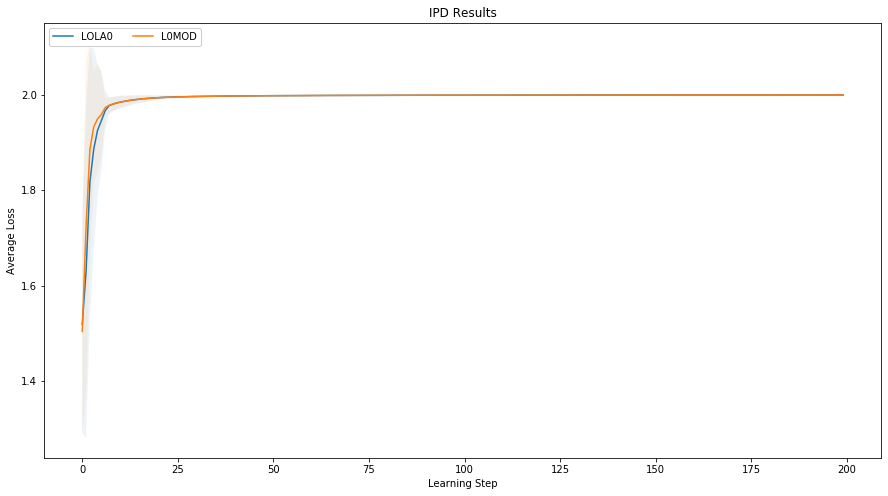

Jax time: 120.33550310134888


In [14]:
#@title Compare LOLA0 and L0MOD with similar coeff
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1
beta = 1e-3
eta = 1e-3

th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola')),
           'lola0':jit(partial(update_th,Ls,dims,alpha,'lola0')),
           'l0mod':jit(partial(update_th,Ls,dims,0.1,'l0mod')),
           'l0modflip':jit(partial(update_th,Ls,dims,0.1,'l0modflip')),
           'gpm':jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           'gpmflip':jit(partial(update_th,Ls,dims,1e-2,'gpmflip'))}

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

lossalgomap={}
t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['lola0', 'l0mod']:
  print(algo)
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
      th, th0, losses = update_fn[algo](th, th0, eta, beta)
      losses_out[i, k] = (1-gamma)*losses[0]
  lossalgomap[algo]=losses_out
  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['LOLA0', 'L0MOD'], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

In [0]:
#@title Testing code
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = ipd()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
th0 = jp.zeros(th.shape)

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
def alpha_fn(eta, beta):
    term1=eta*beta
    term2=1-beta
    return (2*term1+term2**2)/term1/term2
beta = 0.1
eta = 1

# Specify update function
update_fn1=partial(update_th,Ls,dims,alpha,'gpm_old')
update_fn2=partial(update_th,Ls,dims,alpha,'gpm')

# Run
print('th', th)
th1, _, losses1 = update_fn1(th,th0,eta,beta)
th2, _, losses2 = update_fn2(th,th0,eta,beta)
# print('th', th)
# print(th1, th2)
print(losses1, losses2)

th [[ 1.3284667   0.22779723 -0.5049753   1.3871989   0.56284374]
 [-0.56204265  0.5238776   0.29912323 -0.01665386  0.8827369 ]]
gpm_old alpha 1 eta 1 beta 0.1
Correct: [[-6.6634817e-03 -3.3572811e-01  3.4247965e-01 -1.9093212e-01
   4.1389614e-01]
 [ 1.1390075e-05 -1.9810706e-01 -7.4431106e-02  3.4468231e-01
   2.6144847e-01]]
gpm alpha 1 eta 1 beta 0.1
New: (2, 2, 5) [[ 0.01056281 -0.67986643 -0.34954175  0.538648    0.11579257]
 [-0.01581575 -1.1673965   0.4807525  -0.13486455  0.06806004]]
[35.509438 35.031433] [35.509438 35.031433]


In [0]:
#@title torch code
def torch_init_th(dims, std):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def torch_get_gradient(function, param):
  grad = torch.autograd.grad(function, param, create_graph=True)[0]
  return grad

def torch_get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(torch_get_gradient(grad_L[i][i][k], th[j]), dim=0) 
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)

def torch_update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
  n = len(th)
  losses = Ls(th)

  # Compute gradients
  grad_L = [[torch_get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'lola':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j])
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'sos':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    xi_0 = [grad_L[i][i]-alpha*torch_get_gradient(terms[i], th[i]) for i in range(n)]
    chi = [torch_get_gradient(sum([torch.dot(grad_L[j][i].detach(), grad_L[j][j])
              for j in range(n) if j != i]), th[i]) for i in range(n)]
    # Compute p
    dot = torch.dot(-alpha*torch.cat(chi), torch.cat(xi_0))
    p1 = 1 if dot >= 0 else min(1, -a*torch.norm(torch.cat(xi_0))**2/dot)
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    xi_norm = torch.norm(xi)
    p2 = xi_norm**2 if xi_norm < b else 1
    p = min(p1, p2)
    grads = [xi_0[i]-p*alpha*chi[i] for i in range(n)]
  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [torch_get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [torch_get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo == 'co':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    grads = [grad_L[i][i]+gam*torch_get_gradient(ham, th[i]) for i in range(n)]
  elif algo == 'eg':
    th_eg = [th[i]-alpha*torch_get_gradient(losses[i], th[i]) for i in range(n)]
    losses_eg = Ls(th_eg)
    grads = [torch_get_gradient(losses_eg[i], th_eg[i]) for i in range(n)]
  elif algo == 'cgd': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H_o = torch_get_hessian(th, grad_L, diag=False)
    grad = torch.matmul(torch.inverse(torch.eye(sum(dims))+alpha*H_o), xi)
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  elif algo == 'lss': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H = torch_get_hessian(th, grad_L)
    if torch.det(H) == 0:
      inv = torch.inverse(torch.matmul(H.T, H)+lss_lam*torch.eye(sum(dims)))
      H_inv = torch.matmul(inv, H.T)
    else:
      H_inv = torch.inverse(H)
    grad = torch.matmul(torch.eye(sum(dims))+torch.matmul(H.T, H_inv), xi)/2
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  else: # Naive Learning
    grads = [grad_L[i][i] for i in range(n)]

  # Update theta
  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses


nl alpha 1
Jax time: 2.439390182495117


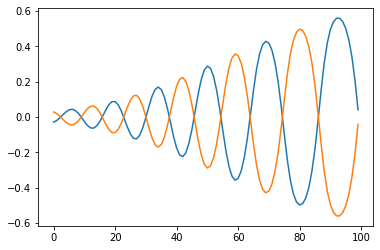

In [0]:
#@title Matching pennies NL
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'nl'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, _, losses = update_fn(th)
#   print(k,'th',th)
#   th_out.append([np.array(th[i]) for i in range(th.shape[0])])
  losses_out[k] = losses#[loss for loss in losses]
print('Jax time:', time.time()-t1)
plt.plot(losses_out)
plt.show()

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# print('Torch time:', time.time()-t1)
# plt.plot(losses_out)
# plt.show()


la alpha 1


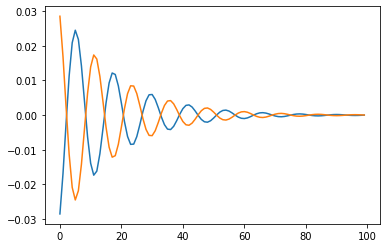

Jax time: 1.5636980533599854


In [0]:
#@title Matching pennies LA
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'la'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th,_, losses = update_fn(th)
  th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [loss for loss in losses]
plt.plot(losses_out)
plt.show()
print('Jax time:', time.time()-t1)

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# plt.plot(losses_out)
# plt.show()
# print('Torch time:', time.time()-t1)


lola alpha 1


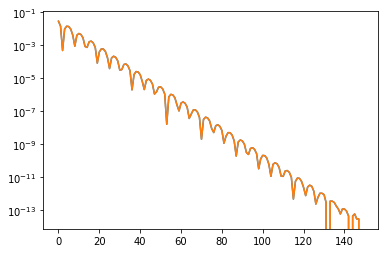

Jax time: 3.152292490005493


In [5]:
#@title Matching pennies full LOLA
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 150
alpha = 1
algo = 'lola'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, _, losses = update_fn(th)
#   th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [np.linalg.norm(loss-0) for loss in losses]
plt.plot(losses_out)
plt.yscale('log')
plt.show()
print('Jax time:', time.time()-t1)

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# plt.plot(losses_out)
# plt.show()
# print('Torch time:', time.time()-t1)


lola0 alpha 1


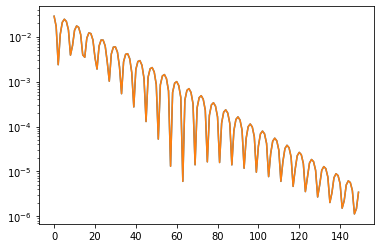

Jax time: 0.897456169128418


In [12]:
#@title Matching pennies original LOLA
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 150
alpha = 1
algo = 'lola0'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, _, losses = update_fn(th)
#   th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [np.linalg.norm(loss-0) for loss in losses]
plt.plot(losses_out)
plt.yscale('log')
plt.show()
print('Jax time:', time.time()-t1)

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# plt.plot(losses_out)
# plt.show()
# print('Torch time:', time.time()-t1)


l0mod alpha 0.01


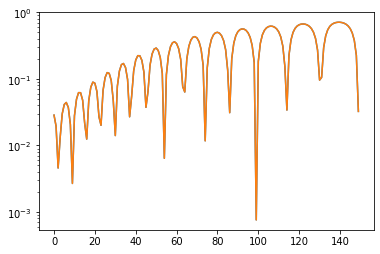

Jax time: 0.812854528427124


In [13]:
#@title Matching pennies original LOLA modified
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
th0 = jp.zeros(th.shape)
torch_th = [torch.from_numpy(np.array(x)) for x in th]
for x in torch_th:
    x.requires_grad=True

# Set num_epochs, learning rate and learning algo
num_epochs = 150
alpha = 0.01
algo = 'l0mod'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
for k in range(num_epochs):
  th, _, losses = update_fn(th, th0)
#   th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [np.linalg.norm(loss-0) for loss in losses]
plt.plot(losses_out)
plt.yscale('log')
plt.show()
print('Jax time:', time.time()-t1)

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# plt.plot(losses_out)
# plt.show()
# print('Torch time:', time.time()-t1)


2.2444444444444445
gpm alpha 2.2444444444444445 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>


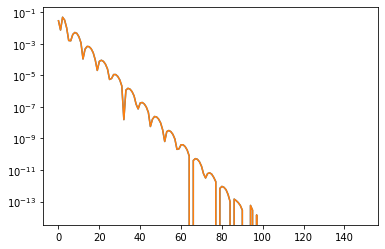

Jax time: 0.7263100147247314


In [9]:
#@title Matching pennies GPM
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()
# torch_dims, torch_Ls = torch_matching_pennies()

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)
# torch_th = [torch.from_numpy(np.array(x)) for x in th]
# for x in torch_th:
#     x.requires_grad=True

# Set num_epochs, learning rate and learning algo
def alpha_fn(eta, beta):
    term1=eta*beta
    term2=1-beta
    return (2*term1+term2**2)/term1/term2
num_epochs = 150
beta = 0.1
eta = 1
alpha = 0.2*alpha_fn(eta,beta)
print(alpha)
algo = 'gpm'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Specify update function
update_fn=jit(partial(update_th,Ls,dims,alpha,algo))

# Run
t1 = time.time()
losses_out = np.zeros((num_epochs, len(th)))
th_out = []
th0 = jp.zeros(th.shape)
for k in range(num_epochs):
  th, th0, losses = update_fn(th,th0,eta,beta)
#   th_out.append([np.array(th[i][0]) for i in range(len(th))])
  losses_out[k] = [np.linalg.norm(loss-0) for loss in losses]
plt.plot(losses_out)
plt.yscale('log')
plt.show()
print('Jax time:', time.time()-t1)

# t1 = time.time()
# losses_out = np.zeros((num_epochs, len(torch_th)))
# th_out = []
# for k in range(num_epochs):
#   torch_th, losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
#   th_out.append([torch_th[i].data.numpy() for i in range(len(torch_th))])
#   losses_out[k] = [loss.data.numpy() for loss in losses]
# plt.plot(losses_out)
# plt.show()
# print('Torch time:', time.time()-t1)


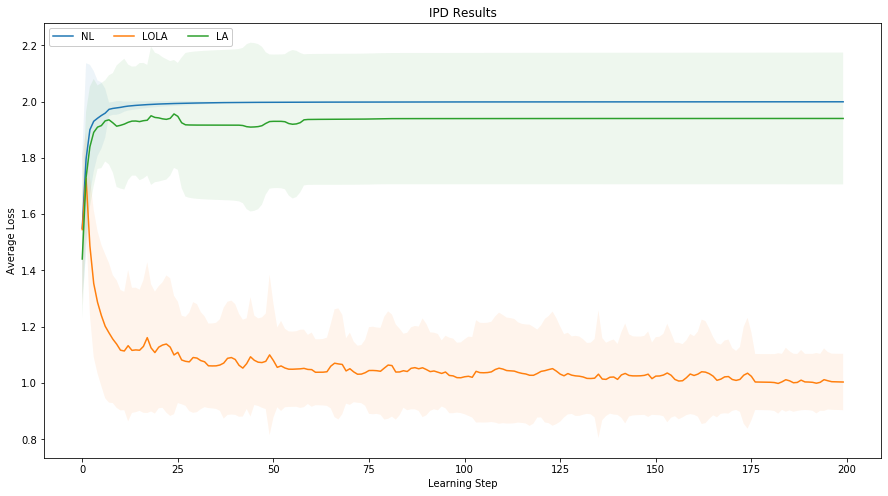

Torch time: 116.57268857955933


In [0]:
#@title IPD torch
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1

th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola'))}

def convert2torch(th):
    torch_th = [torch.from_numpy(np.array(x)) for x in th]
    for x in torch_th:
        x.requires_grad=True
    return torch_th

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['nl', 'lola', 'la', 'sos', 'sga', 'co' , 'eg', 'cgd', 'lss'][0:3]:
#   losses_out = np.zeros((num_runs, num_epochs))
  torch_losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    # th = init_th(dims, std)
    # torch_th = convert2torch(th)
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    for k in range(num_epochs):
      torch_th, torch_losses = torch_update_th(torch_th, torch_Ls, alpha, algo)
      torch_losses_out[i, k] = (1-gamma)*torch_losses[0].data.numpy()
    #   th, losses = update_fn[algo](th)
    #   losses_out[i, k] = (1-gamma)*losses[0]
  torch_mean = np.mean(torch_losses_out, axis=0)
  torch_dev = np.std(torch_losses_out, axis=0)
#   mean = np.mean(losses_out, axis=0)
#   dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), torch_mean)
  plt.fill_between(np.arange(num_epochs), torch_mean-torch_dev, torch_mean+torch_dev, alpha=0.08)
#   plt.plot(np.arange(num_epochs), mean)
#   plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LA', 'SOS', 'SGA', 'CO',  'EG', 'CGD', 'LSS' ][0:3], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Torch time:', time.time()-t1)

nl
nl alpha 1
lola
lola alpha 1
lola0
lola0 alpha 1
l0mod
l0mod alpha 0.1
l0modflip
l0modflip alpha 0.1
la
la alpha 1
gpm
gpm alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpmflip
gpmflip alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>


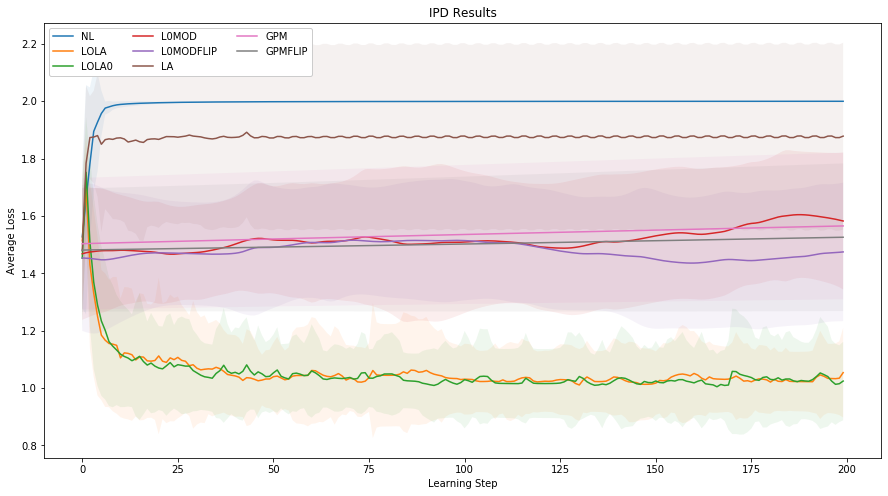

Jax time: 423.34341740608215


In [0]:
#@title IPD jax
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1
beta = 1e-3
eta = 1e-3

th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola')),
           'lola0':jit(partial(update_th,Ls,dims,alpha,'lola0')),
           'l0mod':jit(partial(update_th,Ls,dims,0.1,'l0mod')),
           'l0modflip':jit(partial(update_th,Ls,dims,0.1,'l0modflip')),
           'gpm':jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           'gpmflip':jit(partial(update_th,Ls,dims,1e-2,'gpmflip'))}

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

lossalgomap={}
t1 = time.time()
plt.figure(figsize=(15, 8))
for algo in ['nl', 'lola', 'lola0', 'l0mod', 'l0modflip', 'la', 'gpm', 'gpmflip']:
  print(algo)
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
      th, th0, losses = update_fn[algo](th, th0, eta, beta)
      losses_out[i, k] = (1-gamma)*losses[0]
  lossalgomap[algo]=losses_out
  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LOLA0', 'L0MOD', 'L0MODFLIP', 'LA', 'GPM', 'GPMFLIP'], loc='upper left', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

In [0]:
#@title Faster IPD jax using VMAP for LOLA - Not working
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
alpha = 1
std = 1
beta = 1e-3
eta = 1e-3

th = init_th(dims, std)
update_fn=vmap(jit(partial(update_th,Ls,dims,alpha,'lola')), in_axes=(0,0,None,None), out_axes=(0,0,0))

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

lossalgomap={}
t1 = time.time()
plt.figure(figsize=(15, 8))
th = jp.stack(num_runs*[jp.zeros_like(th)], axis=0)
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = index_update(th, index[i], convert2jax(torch_th))
th0 = jp.zeros_like(th)
losses_out = np.zeros((num_runs, num_epochs))
for k in range(num_epochs):
    th, th0, losses = update_fn(th, th0, eta, beta)
    # losses_out[i, k] = (1-gamma)*losses[0]
# lossalgomap[algo]=losses_out
# mean = np.mean(losses_out, axis=0)
# dev = np.std(losses_out, axis=0)
# plt.plot(np.arange(num_epochs), mean)
# plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

# plt.title('IPD Results')
# plt.xlabel('Learning Step')
# plt.ylabel('Average Loss')
# plt.legend(['LOLA'], loc='upper left', frameon=True, framealpha=1, ncol=3)
# plt.show()
print('Jax time:', time.time()-t1)

Jax time: 0.014696359634399414


<Figure size 1080x576 with 0 Axes>

gpmflip alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,1]):JaxprTrace(level=-1/1)>


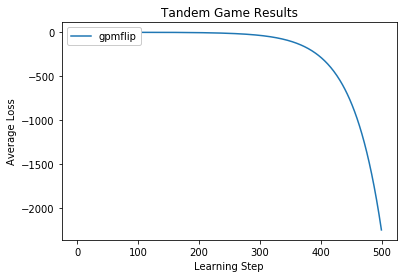

In [0]:
#@title Tandem Jax
'''Tandem Game - SOS vs LOLA'''

dims, Ls = tandem()

num_runs = 100
num_epochs = 500
alpha = 0.1
std = 0.1

beta = 1e-3
eta = 1e-3
th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola')),
           'lola0':jit(partial(update_th,Ls,dims,alpha,'lola0')),
           'l0mod':jit(partial(update_th,Ls,dims,alpha,'l0mod')),
           'gpmflip':jit(partial(update_th,Ls,dims,1e-2,'gpmflip'))}

for algo in ['nl', 'lola', 'lola0', 'l0mod', 'la', 'gpmflip'][-1:]:
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    th = init_th(dims, std)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
      th, _, losses = update_fn[algo](th, th0, eta, beta)
      losses_out[i, k] = losses[0]

  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.1)

plt.title('Tandem Game Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LOLA', 'LOLA0', 'L0MOD', 'LA', 'gpmflip'][-1:], loc='upper left', frameon=True, framealpha=1)
plt.show()

lola0 alpha 0.1


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


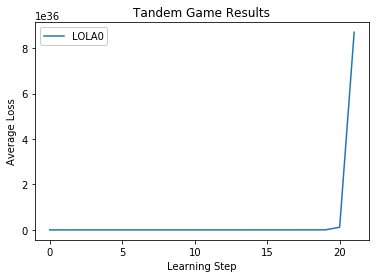

In [22]:
#@title Tandem Jax Compare LOLA0 with L0MOD with similar coeff
'''Tandem Game - SOS vs LOLA'''

dims, Ls = tandem()

num_runs = 10
num_epochs = 500
alpha = 0.1
std = 0.1

beta = 0
eta = 0.1
th = init_th(dims, std)
update_fn={'nl':jit(partial(update_th,Ls,dims,alpha,'nl')),
           'la':jit(partial(update_th,Ls,dims,alpha,'la')),
           'lola':jit(partial(update_th,Ls,dims,alpha,'lola')),
           'lola0':jit(partial(update_th,Ls,dims,alpha,'lola0')),
           'l0mod':jit(partial(update_th,Ls,dims,alpha,'l0mod')),
           'gpmflip':jit(partial(update_th,Ls,dims,1e-2,'gpmflip'))}

for algo in ['lola0', 'l0mod'][0:1]:
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    th = init_th(dims, std)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
      th, _, losses = update_fn[algo](th, th0, eta, beta)
      losses_out[i, k] = losses[0]

  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.1)

plt.title('Tandem Game Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['LOLA0', 'L0MOD'][0:1], loc='upper left', frameon=True, framealpha=1)
plt.show()

9 11 99 99 99 198
[1.42774579 1.45404293 1.56825365 1.63959688 1.66656022 1.67986853
 1.69312282 1.70513734 1.71329094 1.72053189 1.72931459 1.73997357
 1.75289012 1.76503414 1.7691836  1.7679701  1.76371343 1.77068094
 1.7842021  1.7916222  1.79231518 1.78985243 1.78645457 1.78686921
 1.79006223 1.78890601 1.78377621 1.77740512 1.77275722 1.77266791
 1.77407885 1.7730872  1.76960477 1.76608927 1.76567753 1.76786487
 1.77015259 1.77008193 1.76784965 1.76604906 1.76640279 1.76819419
 1.7716744  1.77593044 1.77672471 1.77607559 1.77623672 1.77546448
 1.77371108 1.77229445 1.77273221 1.77472818 1.7754788  1.77545822
 1.77676178 1.77989026 1.78100059 1.77445858 1.76852801 1.76509717
 1.76346717 1.76515154 1.77048839 1.77478625 1.77873078 1.78293581
 1.7838855  1.77773751 1.77589469 1.77068975 1.76895    1.77352648
 1.78205075 1.79054676 1.79388592 1.78939993 1.78980575 1.79488853
 1.80051983 1.80392002 1.80495131 1.80560388 1.80792104 1.80623634
 1.80195145 1.79943193 1.79729478 1.79280833

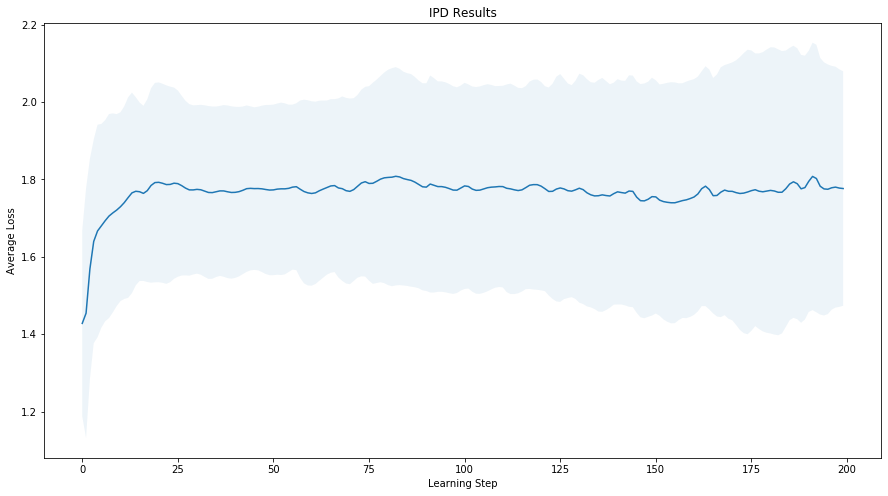

Jax time: 54.087127447128296
[1.42774579 1.42765047 1.48963619 1.49514974 1.47779907 1.47067939
 1.46909476 1.46528594 1.46393254 1.46635558 1.46647317 1.46473336
 1.46433002 1.46573766 1.4661381  1.46477245 1.46457995 1.46574158
 1.46657882 1.46572032 1.4654005  1.46633594 1.46730906 1.46698882
 1.46661745 1.46729375 1.46824986 1.46831402 1.46801094 1.46843879
 1.46931263 1.46961877 1.4694427  1.46968736 1.4704437  1.47089621
 1.47085688 1.47099274 1.47161841 1.47215308 1.47224127 1.47232743
 1.4728256  1.47339486 1.47359658 1.47367488 1.47406103 1.47462589
 1.47492553 1.47502539 1.4753216  1.47585161 1.47623011 1.47637208
 1.47660406 1.47707944 1.47751183 1.47771003 1.47790373 1.47831492
 1.47877475 1.47903487 1.47921535 1.47956301 1.48002379 1.48034279
 1.48053213 1.48082559 1.48126595 1.48163308 1.48184869 1.48210193
 1.48250732 1.48290643 1.48315902 1.48338934 1.48375277 1.48416579
 1.48445962 1.48468395 1.4850058  1.48541637 1.48574783 1.4859811
 1.48626834 1.48666099 1.48702239 

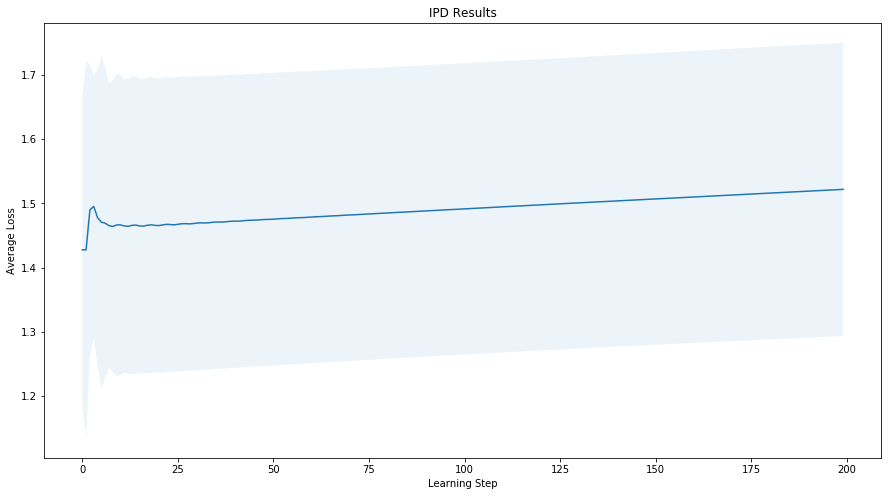

Jax time: 52.50982856750488
[1.42774579 1.41165748 1.43189905 1.46771153 1.47531871 1.47565202
 1.47309638 1.47108737 1.4722375  1.47395493 1.4763908  1.47954549
 1.48160807 1.4824481  1.48379127 1.48602354 1.48877529 1.49153824
 1.49373607 1.49541436 1.49715268 1.49927447 1.50170341 1.50411127
 1.50618941 1.50798599 1.50982467 1.5119275  1.51423321 1.51646264
 1.51839868 1.52012977 1.52194525 1.52402126 1.52624464 1.52831266
 1.53005781 1.53165565 1.53343782 1.53552998 1.53768753 1.53952165
 1.54096699 1.54241498 1.54428602 1.54652585 1.54855139 1.54989624
 1.55091247 1.55242764 1.55478687 1.55724894 1.55861313 1.55900142
 1.55984877 1.56223988 1.56550743 1.56731764 1.56702438 1.56679933
 1.56856034 1.57212673 1.57505807 1.57545681 1.57479941 1.57554651
 1.57821365 1.58119643 1.58281229 1.58317973 1.58377904 1.58559079
 1.58806546 1.58987222 1.59074332 1.59152351 1.5929586  1.59507837
 1.59702391 1.59815971 1.59896545 1.60010076 1.60183507 1.6038148
 1.6053272  1.60627438 1.60718435 1

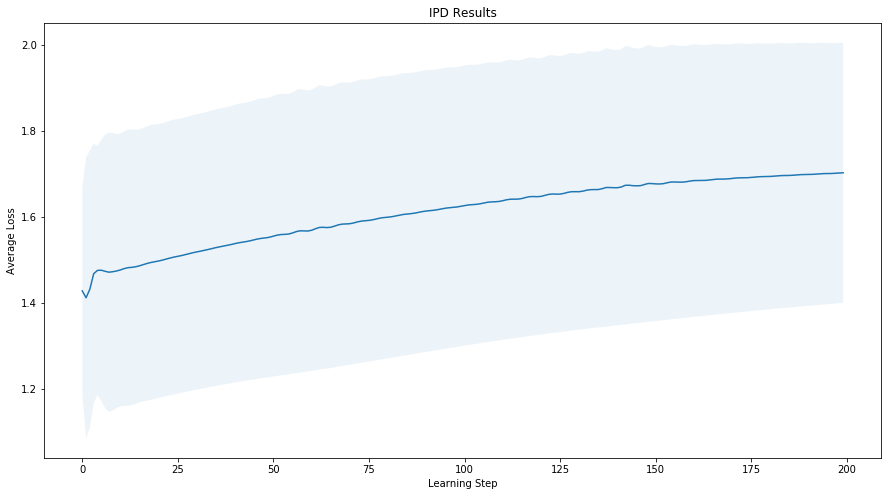

Jax time: 52.659645318984985
[1.42774579 1.61020264 1.86093026 1.84735449 1.91016972 1.91906894
 1.93269766 1.96051745 1.95853185 1.96619561 1.97279269 1.96999156
 1.98395682 1.9804685  1.99113084 1.97393551 1.98053187 1.97434341
 1.95977871 1.94443038 1.93802032 1.94975555 1.96431308 1.95368631
 1.94814358 1.94724348 1.9648044  1.98620042 1.99718642 1.99548031
 1.98935027 1.98761295 1.98568672 1.98197241 1.97503157 1.97663316
 1.97362911 1.96861055 1.96990003 1.9920119  2.00035682 1.99845471
 1.99467729 1.98986673 1.97710519 1.96625608 1.97382266 1.97241776
 1.966961   1.96856656 1.97693284 1.98058897 1.98191085 1.98727139
 1.98571424 1.9724245  1.9811495  1.98035783 1.97259361 1.96397074
 1.95720933 1.95037949 1.94787264 1.94718765 1.94695258 1.95429059
 1.95572489 1.95598604 1.95632601 1.9568933  1.96009572 1.97360647
 1.98170847 1.97889499 1.97038101 1.96456272 1.96410751 1.96395701
 1.96383965 1.96373421 1.96363518 1.96353604 1.9634297  1.96331012
 1.96317476 1.96302886 1.96288148

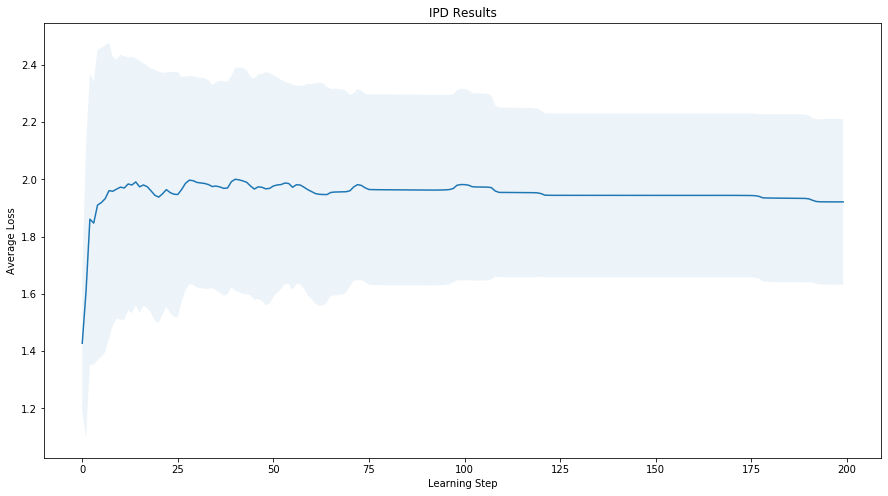

Jax time: 51.8653838634491
[1.42774579 1.40999552 1.42621387 1.4578785  1.46287667 1.46042024
 1.45403128 1.44919595 1.44972837 1.44998204 1.45024861 1.45052356
 1.44999255 1.44944446 1.44957808 1.44989295 1.44992073 1.44976083
 1.44965163 1.449783   1.45003869 1.45009824 1.44991344 1.44972937
 1.44976054 1.44998619 1.45017459 1.45014785 1.44998326 1.44988837
 1.44997232 1.45014916 1.45024716 1.45019907 1.45009939 1.45007846
 1.45016739 1.45028167 1.45032305 1.45028395 1.45024019 1.4502586
 1.45033268 1.45040032 1.45041639 1.45039572 1.45038846 1.45042144
 1.45047695 1.45051729 1.45052634 1.45052325 1.45053549 1.4505708
 1.45061099 1.45063765 1.4506481  1.45065711 1.45067857 1.45071073
 1.45074156 1.45076245 1.45077635 1.45079316 1.4508175  1.45084601
 1.45087141 1.45089087 1.45090841 1.45092879 1.45095357 1.45097892
 1.45100168 1.45102166 1.45104162 1.45106368 1.45108768 1.45111141
 1.4511329  1.45115354 1.45117504 1.45119762 1.45122101 1.45124367
 1.45126528 1.45128655 1.45130829 1.4

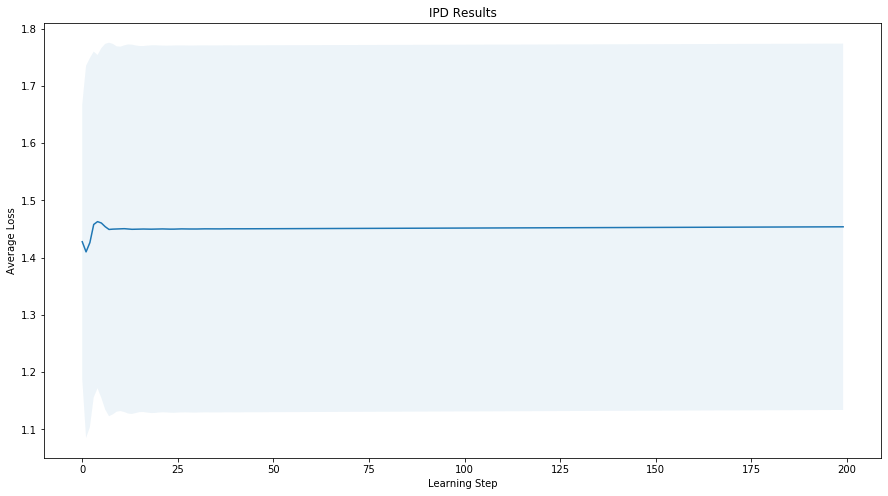

Jax time: 51.99420094490051
[1.42774579 1.4130592  1.43827571 1.47169356 1.4714357  1.46749876
 1.46286678 1.45991218 1.45899471 1.45833431 1.45947326 1.46082757
 1.46070413 1.46018781 1.46028021 1.46073967 1.46148194 1.4621064
 1.46244803 1.46269478 1.46293819 1.46329086 1.46379224 1.46432041
 1.46476898 1.46510119 1.46539315 1.46576557 1.46623377 1.46671809
 1.46713495 1.46748011 1.46782721 1.46823349 1.46868284 1.46911944
 1.46951077 1.46987794 1.47026335 1.47067951 1.4711054  1.47151364
 1.47190189 1.47228909 1.47268947 1.47310114 1.47351025 1.47390855
 1.4743018  1.47469832 1.47510115 1.47550551 1.47590637 1.47630336
 1.47670018 1.47709872 1.4774991  1.47789892 1.47829666 1.47869384
 1.47909102 1.47948868 1.47988612 1.48028369 1.48068022 1.48107638
 1.48147241 1.48186809 1.48226445 1.48265979 1.48305492 1.48344942
 1.48384395 1.484238   1.48463211 1.48502586 1.48541934 1.48581218
 1.48620473 1.48659718 1.48698966 1.48738133 1.48777295 1.48816364
 1.48855463 1.48894511 1.48933531 1

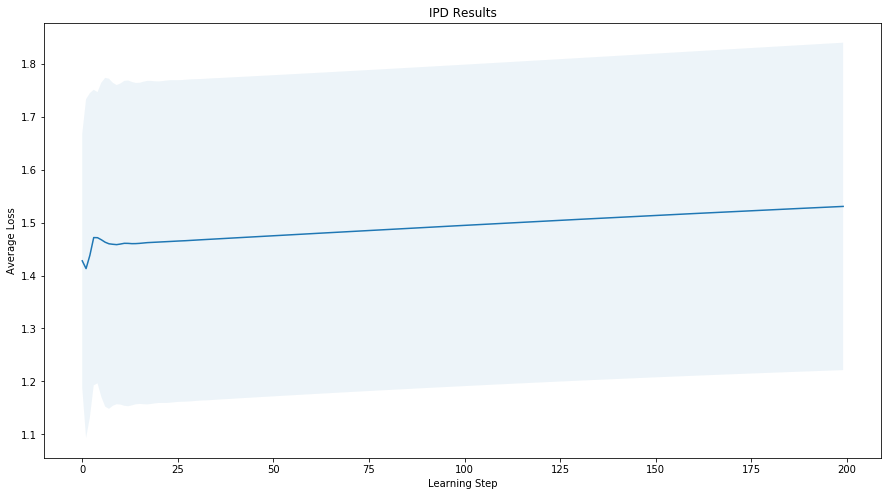

Jax time: 52.26992177963257
[1.42774579 1.42311115 1.47426699 1.49861917 1.48721091 1.4826377
 1.48178761 1.47695582 1.474591   1.47832861 1.48405144 1.4857518
 1.48472016 1.48489736 1.48821174 1.49169609 1.49255643 1.49246384
 1.49409073 1.49752385 1.49979251 1.50025163 1.50089245 1.5033253
 1.50628972 1.50776468 1.50827084 1.50960796 1.51226753 1.51459625
 1.51565759 1.51646806 1.51830216 1.52080031 1.52258194 1.52352697
 1.52471575 1.52678152 1.5289463  1.53035971 1.53138293 1.53289401
 1.53496284 1.53677646 1.53800125 1.53919632 1.54090644 1.54283183
 1.54435914 1.54553683 1.54691594 1.54868996 1.55040892 1.55174241
 1.55296368 1.55448412 1.55621138 1.55772084 1.55895138 1.5602588
 1.56185192 1.5634603  1.56479335 1.5659926  1.56738995 1.56898553
 1.57044452 1.57164573 1.57285665 1.57432514 1.57587707 1.57718508
 1.5782783  1.57951171 1.58105367 1.58257006 1.58369691 1.58460743
 1.58589789 1.58768689 1.58919533 1.58978868 1.59028207 1.59209766
 1.59472531 1.59551557 1.59434676 1.59

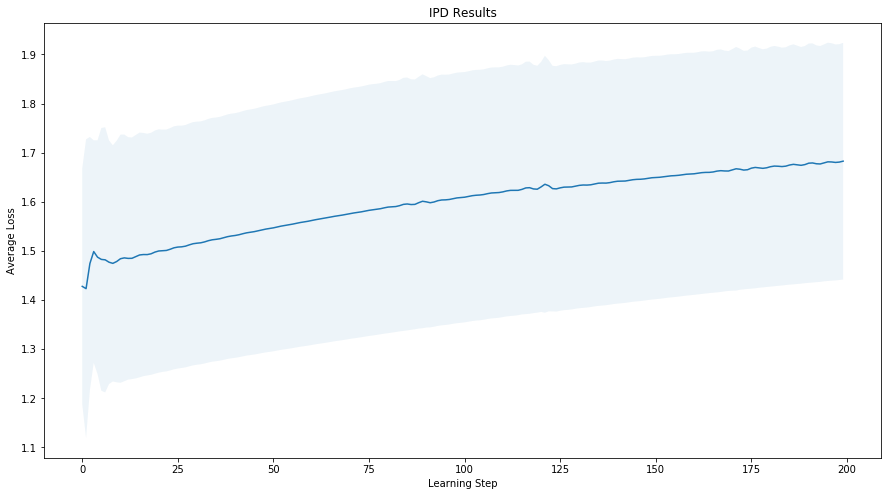

Jax time: 52.407113552093506
[1.42774579 1.44781542 1.57357946 1.65541033 1.68674814 1.70691352
 1.72039462 1.71898054 1.71767643 1.72522602 1.73043655 1.73742947
 1.74641735 1.75412674 1.75595028 1.75398057 1.75334504 1.75509107
 1.76224099 1.76527261 1.75936286 1.75558889 1.75795779 1.75847832
 1.76001977 1.75694571 1.7525992  1.74865344 1.74584743 1.74500607
 1.74218945 1.73896684 1.73947139 1.73737321 1.73541641 1.73388972
 1.72834889 1.73034947 1.72976291 1.72143553 1.71376102 1.71118468
 1.70948821 1.70896659 1.70714528 1.70042913 1.69826178 1.70241009
 1.69346163 1.68904878 1.68657559 1.67986156 1.67644996 1.6763976
 1.67458521 1.6750208  1.67628867 1.67450843 1.67120293 1.6677159
 1.66510305 1.6683418  1.67371818 1.67582645 1.6735904  1.67104317
 1.67161577 1.67491362 1.67548063 1.67412547 1.67560192 1.6795679
 1.68249522 1.68707513 1.68753415 1.67676507 1.67012685 1.66873373
 1.6710842  1.67627982 1.68043198 1.68461265 1.68892282 1.69175182
 1.6942107  1.69518397 1.6928098  1.

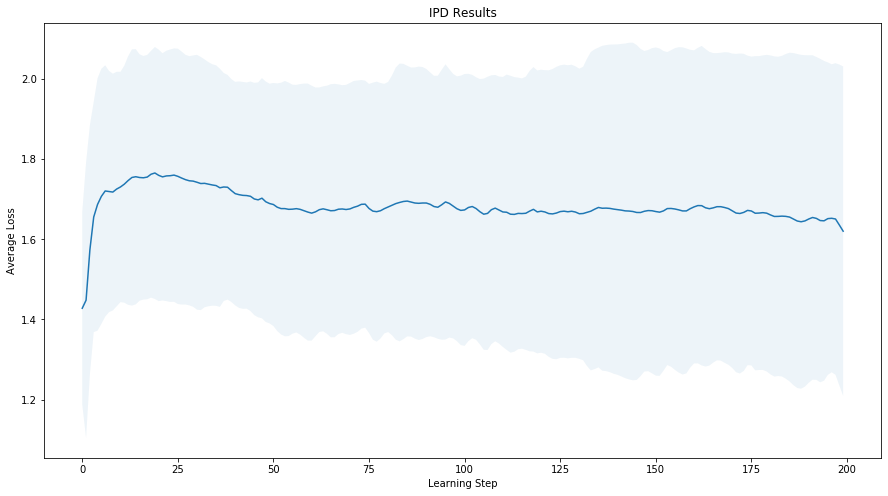

Jax time: 51.984288930892944
[1.42774579 1.42167194 1.46982207 1.49259315 1.47952646 1.47311754
 1.47018429 1.46404142 1.46082308 1.4633156  1.46727534 1.46702796
 1.46474992 1.46389403 1.46578102 1.46745957 1.4667347  1.46556332
 1.46599618 1.46786197 1.46842683 1.46752847 1.46708487 1.46821817
 1.46961092 1.46953691 1.46881089 1.46901378 1.4703264  1.47114246
 1.47079689 1.47043159 1.47108403 1.47223237 1.4725894  1.47223866
 1.47226739 1.47312396 1.47396821 1.47405077 1.47385427 1.47420323
 1.47505761 1.4756026  1.47558297 1.47560294 1.47614689 1.47687791
 1.47720159 1.47720473 1.47743066 1.47804498 1.47861202 1.47881248
 1.47890812 1.47928519 1.47987695 1.48029717 1.48046    1.48066905
 1.48112844 1.48164868 1.48196671 1.48215094 1.48245938 1.4829398
 1.48337664 1.4836428  1.48387814 1.48425357 1.48471382 1.48508131
 1.48533637 1.48562778 1.48603506 1.4864557  1.48677769 1.4870482
 1.4873855  1.48779574 1.48817531 1.48847678 1.48877381 1.48913916
 1.48953482 1.48988204 1.49018193 1

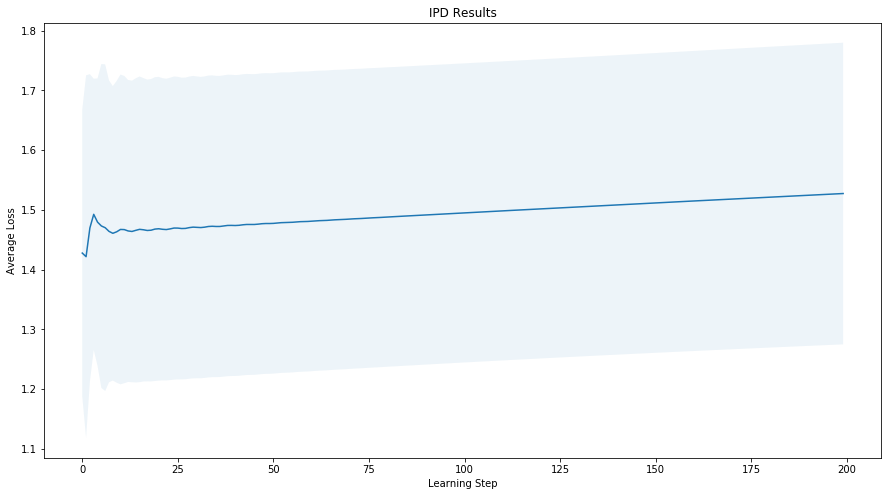

Jax time: 52.79247260093689
[1.42774579 1.43949216 1.53547994 1.57443961 1.58196211 1.58632233
 1.59973606 1.6088137  1.61586649 1.62885554 1.64151189 1.64763739
 1.65276039 1.658012   1.66835246 1.68008528 1.68859732 1.6927558
 1.69570368 1.70231934 1.71168374 1.71856318 1.7200887  1.7187424
 1.72226797 1.72878726 1.73339171 1.73156757 1.73088113 1.73891796
 1.74260087 1.73749023 1.73471926 1.73330068 1.73495674 1.73706823
 1.73899259 1.73882775 1.73931812 1.74095645 1.74155372 1.74231054
 1.74289413 1.74502483 1.7469224  1.745249   1.7434333  1.74307192
 1.74629509 1.74824669 1.74477711 1.73988022 1.73932132 1.74163671
 1.74364377 1.74616149 1.74695518 1.74292089 1.73945423 1.74028707
 1.74529899 1.75010974 1.74963232 1.74375976 1.74178834 1.74518409
 1.74878651 1.75137633 1.75223857 1.75371959 1.75375443 1.75336369
 1.75356388 1.75534698 1.75723929 1.75369785 1.75390652 1.75511016
 1.76196858 1.76727427 1.76611878 1.76281091 1.7605539  1.7651795
 1.76930738 1.76894572 1.76659352 1.7

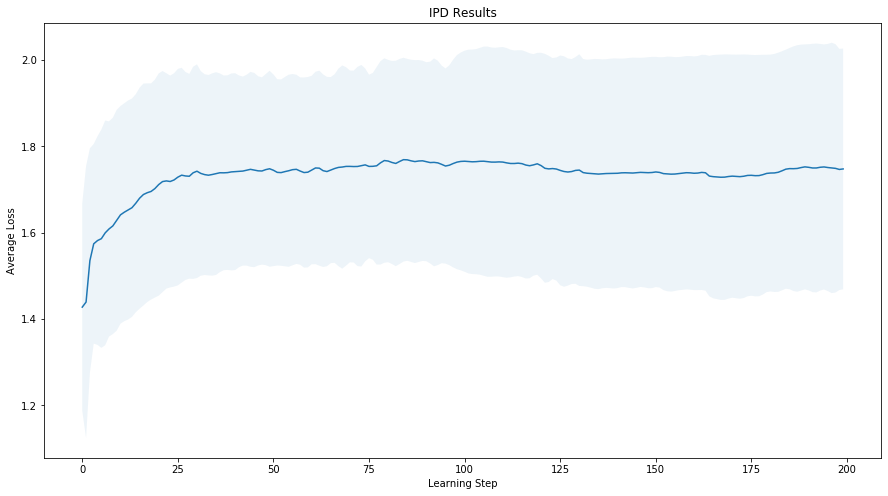

Jax time: 52.312251329422
[1.42774579 1.40473877 1.40518096 1.42865629 1.44209725 1.44414233
 1.44247115 1.43643787 1.43339708 1.43565461 1.43702037 1.4376981
 1.43782042 1.4372426  1.43651444 1.43639074 1.43683977 1.43732752
 1.43749291 1.4373368  1.43709735 1.43703923 1.43723176 1.43750188
 1.43763448 1.43758196 1.43746579 1.43743795 1.43755374 1.43773744
 1.43786275 1.43787381 1.43782252 1.43780516 1.43787364 1.43800131
 1.43811501 1.4381642  1.43816099 1.43815895 1.43820235 1.43829033
 1.43838596 1.43845101 1.43847958 1.43849677 1.43853266 1.43859684
 1.43867432 1.43874115 1.43878727 1.43882008 1.43885757 1.43891069
 1.43897481 1.43903836 1.43909145 1.43913446 1.43917644 1.43922566
 1.43928249 1.43934138 1.43939625 1.4394448  1.43949086 1.4395395
 1.43959256 1.43964796 1.43970277 1.43975366 1.43980267 1.43985168
 1.43990357 1.43995687 1.44001052 1.44006277 1.44011307 1.44016328
 1.44021424 1.44026667 1.44031967 1.44037202 1.44042306 1.4404741
 1.4405252  1.44057703 1.44062937 1.440

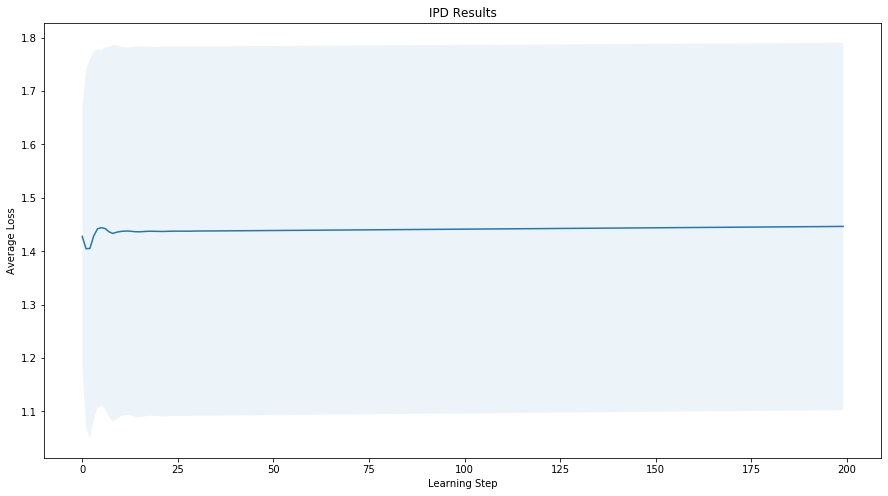

Jax time: 51.86958408355713
[1.42774579 1.41586856 1.44878298 1.48098721 1.47489567 1.47049079
 1.46735325 1.46363983 1.46011182 1.45907143 1.46152876 1.46361185
 1.46335035 1.46235348 1.46191171 1.46266807 1.46395036 1.46452844
 1.46441896 1.46425568 1.46462988 1.46544277 1.46605752 1.46626234
 1.46633758 1.46666459 1.46725949 1.46778967 1.46808873 1.46829968
 1.46864707 1.46914904 1.46961651 1.46994464 1.47022174 1.47058574
 1.47104328 1.47147721 1.47181999 1.47213104 1.4725007  1.47293214
 1.47334789 1.4737018  1.47403281 1.47440277 1.47481588 1.47522001
 1.47558197 1.47592694 1.4762963  1.47669591 1.47709108 1.47745885
 1.47781313 1.47818201 1.47857133 1.47895996 1.47933092 1.47969137
 1.48005983 1.48044235 1.4808257  1.48119767 1.48156196 1.48193069
 1.48230798 1.48268678 1.48305861 1.48342512 1.48379367 1.48416746
 1.48454235 1.48491347 1.48528077 1.48564882 1.48601995 1.48639221
 1.48676192 1.48712921 1.48749637 1.48786531 1.48823511 1.48860326
 1.48896983 1.48933599 1.48970296 

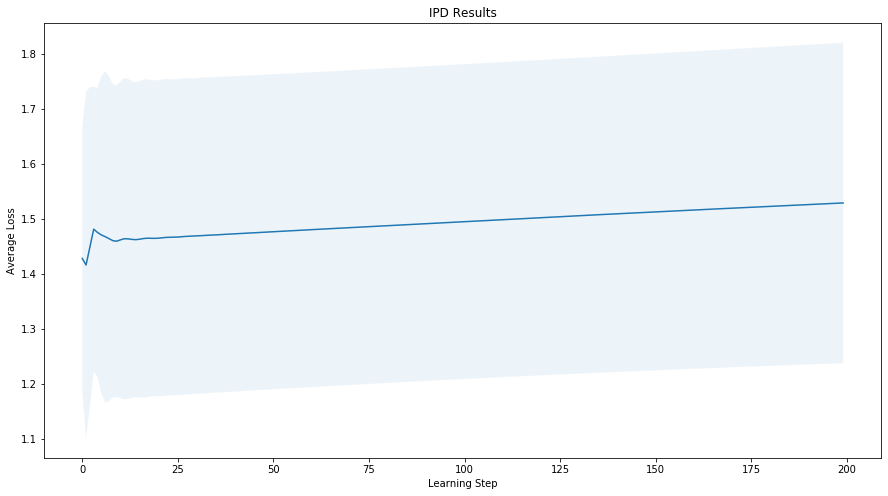

Jax time: 52.45674753189087
[1.42774579 1.63376196 1.8631187  1.89873757 1.94806029 1.96788161
 1.96770759 1.97228531 1.97989919 1.95156328 1.94011085 1.93838404
 1.95982714 1.94678034 1.94053128 1.94968991 1.9523413  1.95996306
 1.95478584 1.94713161 1.95187904 1.92835341 1.91338086 1.91218131
 1.92258564 1.9316461  1.92104339 1.91940651 1.91370642 1.90361469
 1.89259961 1.88798629 1.88475529 1.88542393 1.88597471 1.88635014
 1.8866654  1.88706734 1.88807984 1.89204164 1.89078842 1.88038478
 1.87245069 1.85458352 1.84771644 1.84750726 1.84766284 1.84827409
 1.85011961 1.85669041 1.8651869  1.86564493 1.86565142 1.86566535
 1.86570491 1.86575874 1.86582053 1.86588685 1.86595711 1.86603479
 1.86612109 1.86621985 1.86633352 1.8664663  1.86661731 1.86678835
 1.86698015 1.86719793 1.86746714 1.86786177 1.86861513 1.87068968
 1.8775599  1.87588289 1.87469477 1.87005633 1.86691501 1.86673756
 1.86672477 1.86673984 1.86676209 1.86678006 1.8667776  1.86672875
 1.86659679 1.86634973 1.86602804 

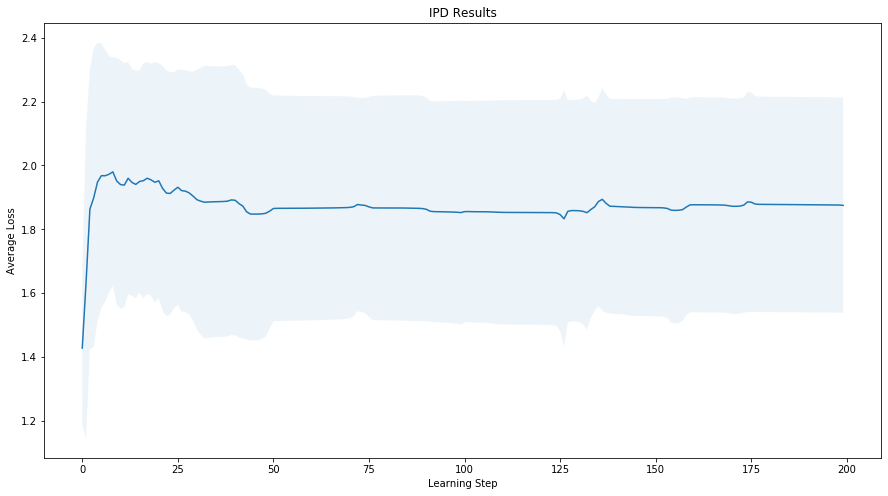

Jax time: 52.06033658981323
[1.42774579 1.41569555 1.4483249  1.4802721  1.47392302 1.46923252
 1.46574513 1.46191557 1.45836667 1.4572076  1.45942997 1.4612111
 1.46073695 1.45962484 1.45903622 1.45957497 1.46061672 1.46099085
 1.46072441 1.46039254 1.46056257 1.46116325 1.46158286 1.46161284
 1.46150717 1.46163549 1.46203033 1.46237039 1.4624885  1.46251406
 1.46266634 1.46297349 1.46325222 1.46339622 1.46348656 1.46365914
 1.46392547 1.46417081 1.46432728 1.46445068 1.46463206 1.46487507
 1.46510262 1.46526867 1.4654122  1.46559594 1.46582255 1.46603989
 1.46621383 1.46637078 1.46655495 1.46676966 1.46697974 1.46715991
 1.46732646 1.46751084 1.46771696 1.4679214  1.46810578 1.46827951
 1.46846425 1.46866404 1.46886435 1.46905127 1.46923018 1.4694151
 1.46961103 1.4698075  1.46999601 1.47017837 1.47036408 1.47055697
 1.47075132 1.47094033 1.47112492 1.47131142 1.47150222 1.47169482
 1.47188394 1.47207008 1.47225688 1.4724466  1.47263737 1.47282673
 1.47301378 1.4732005  1.47338959 1.

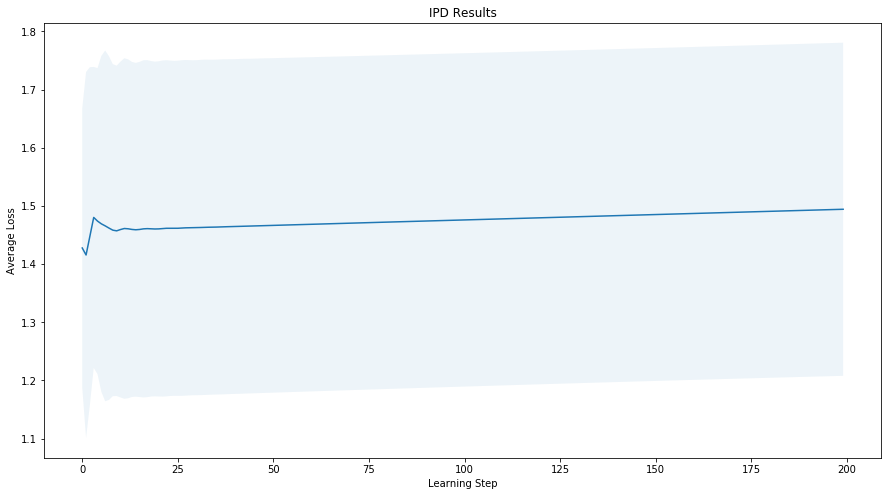

Jax time: 52.004026651382446
[1.42774579 1.62675808 1.86257118 1.88014727 1.93147405 1.93054657
 1.95840975 1.94948584 1.97307377 1.99078914 1.96799503 1.95723446
 1.95594087 1.96413121 1.96843508 1.98065059 1.97263232 1.95578483
 1.94272294 1.94461276 1.94312812 1.92881788 1.90994248 1.9168047
 1.90950502 1.93420989 1.94199398 1.93897971 1.93512464 1.93367006
 1.94424406 1.93728518 1.92982205 1.9232116  1.91837475 1.91840349
 1.91906983 1.91980577 1.92054272 1.92125631 1.92193141 1.9225565
 1.92311945 1.9236061  1.92400181 1.92429788 1.92448961 1.92458022
 1.92457705 1.92448887 1.92432325 1.92408608 1.92378265 1.92340355
 1.92276722 1.9185411  1.90516866 1.90391708 1.9030143  1.90256128
 1.90227952 1.90205891 1.90185507 1.90164331 1.90138883 1.90100933
 1.90023654 1.89811784 1.89500106 1.89424409 1.89379394 1.89279621
 1.88873667 1.88469082 1.88439869 1.88404086 1.88286692 1.87680212
 1.87272407 1.87282028 1.87308388 1.87393943 1.878463   1.8890035
 1.8917273  1.89092856 1.88969583 1.

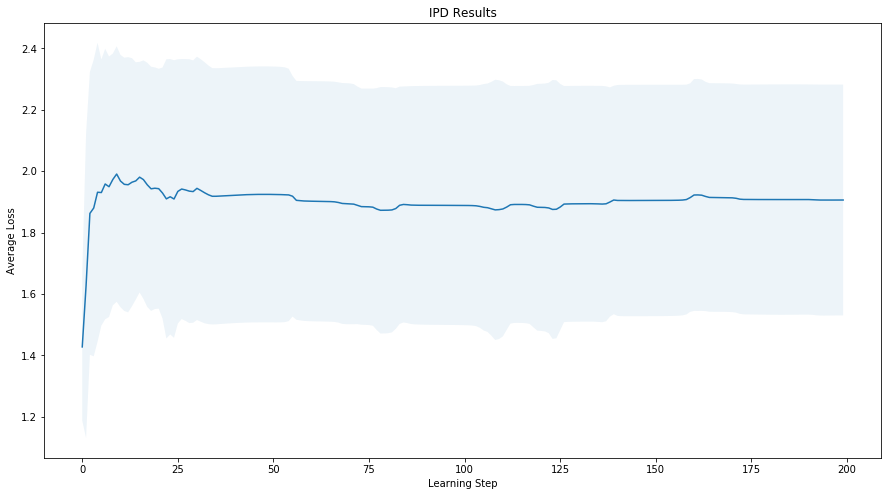

Jax time: 52.77442216873169
[1.42774579 1.40747473 1.41603963 1.44522406 1.45484056 1.45561441
 1.45113624 1.44481311 1.44457585 1.44631975 1.44717185 1.44776204
 1.44774145 1.44733066 1.44735249 1.4479144  1.44847635 1.44869535
 1.44866823 1.44869163 1.44899107 1.44949051 1.44989965 1.45005585
 1.45007404 1.45017661 1.45048043 1.45090247 1.45125564 1.45144566
 1.45154568 1.45169781 1.45197323 1.45232105 1.45263184 1.45284881
 1.45301075 1.45319931 1.45345654 1.45375589 1.4540373  1.45426789
 1.45446748 1.45467935 1.45492799 1.45519918 1.45546257 1.45569995
 1.45592016 1.45614574 1.45638998 1.45664718 1.45690033 1.45714007
 1.45737123 1.45760458 1.45784744 1.45809665 1.45834437 1.45858544
 1.45882197 1.45905944 1.45930166 1.45954699 1.45979197 1.46003344
 1.46027271 1.46051253 1.46075401 1.46099753 1.4612409  1.461483
 1.46172314 1.46196434 1.4622058  1.46244867 1.4626913  1.46293313
 1.46317421 1.4634157  1.46365731 1.46389949 1.46414144 1.46438324
 1.46462509 1.4648664  1.46510793 1.

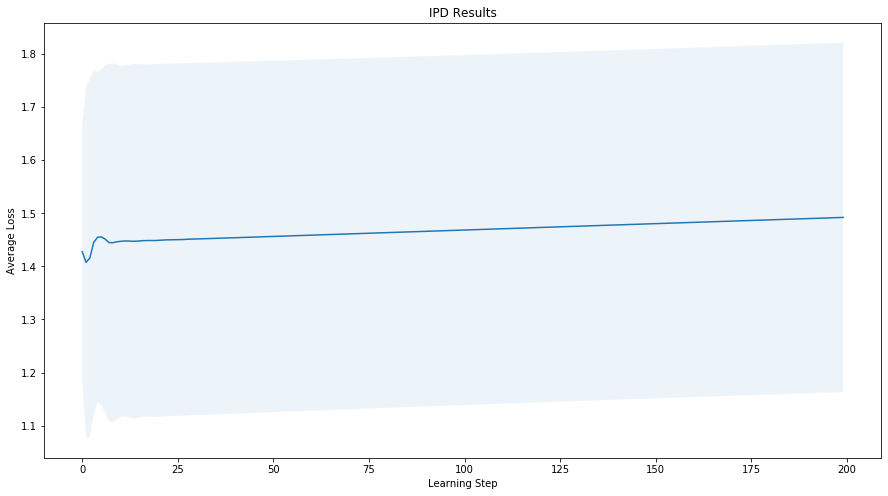

Jax time: 52.033679485321045
[1.42774579 1.42121526 1.47819526 1.55361471 1.59350629 1.61998992
 1.6333385  1.63433254 1.64130977 1.65222578 1.66626513 1.68230253
 1.69537827 1.70583365 1.71655702 1.72459329 1.72756618 1.72916752
 1.733654   1.74094026 1.74922592 1.75772132 1.76111936 1.75473907
 1.74612628 1.74133168 1.74035126 1.74211778 1.74504409 1.74536375
 1.74458596 1.74396053 1.74383537 1.74429735 1.74513773 1.74578366
 1.74611011 1.7462943  1.7467619  1.74801177 1.74824089 1.74702229
 1.74579496 1.74523167 1.74607058 1.74798075 1.74662488 1.74378875
 1.74252462 1.74359604 1.74460404 1.74124782 1.73607882 1.73304838
 1.73143508 1.73116919 1.73294969 1.73559993 1.73684976 1.73594926
 1.73357368 1.73059293 1.72982681 1.73348593 1.73809961 1.73800461
 1.73359694 1.72845956 1.72555929 1.72527416 1.72716934 1.72978433
 1.72236521 1.71434921 1.71276966 1.71627767 1.72186731 1.72265298
 1.71568545 1.70767254 1.70515216 1.70515972 1.70586657 1.70698485
 1.70866709 1.71136671 1.71517049

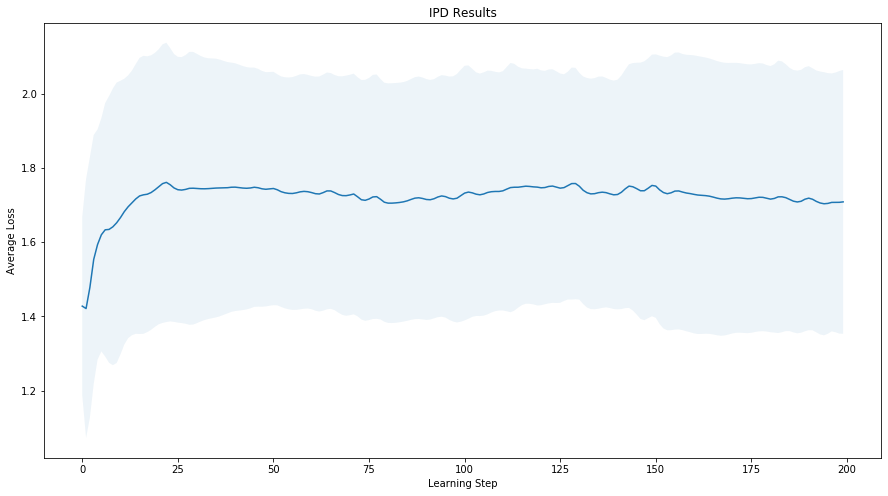

Jax time: 52.103822231292725
[1.42774579 1.42134859 1.46884642 1.49125852 1.4778211  1.47098426
 1.46758596 1.46118868 1.4577851  1.45997955 1.46351673 1.46283491
 1.46030396 1.45922048 1.46076487 1.46201733 1.46093917 1.45954028
 1.45969242 1.4611777  1.46134084 1.46014317 1.45945906 1.46027447
 1.46127899 1.46083815 1.45983965 1.45977802 1.46075075 1.46118549
 1.46050606 1.45987458 1.46023809 1.4610359  1.46102731 1.46036632
 1.46012221 1.46067096 1.46116215 1.46089813 1.46040413 1.46046882
 1.461003   1.46119848 1.46084897 1.46057632 1.46082458 1.46122756
 1.46120974 1.460896   1.46082776 1.46113662 1.46137278 1.46124117
 1.46102787 1.4611076  1.46138655 1.46147689 1.46131647 1.46122068
 1.4613783  1.4615808  1.46157238 1.46144029 1.46144541 1.46161978
 1.4617374  1.46168116 1.46160507 1.46167758 1.4618281  1.46187608
 1.46181319 1.46179721 1.46190017 1.4620095  1.46201307 1.46196957
 1.46200182 1.46210679 1.4621732  1.46215878 1.46214613 1.46220693
 1.46229604 1.46232994 1.46231687

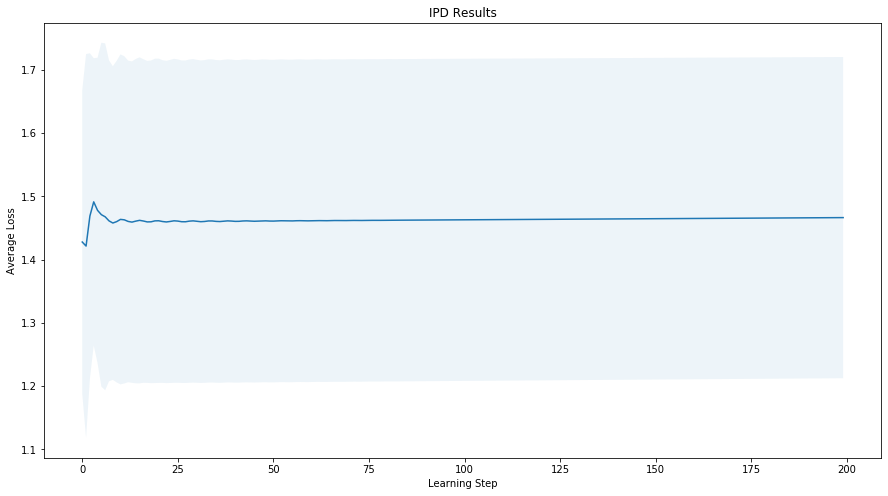

Jax time: 52.1854612827301
[1.42774579 1.46077387 1.58224688 1.63408377 1.64881866 1.65771691
 1.67520142 1.68760652 1.69567657 1.70413167 1.71493012 1.72756575
 1.73940109 1.74769677 1.75170737 1.75671216 1.76148127 1.76458868
 1.76544497 1.77068102 1.77191528 1.76810584 1.76630078 1.76339136
 1.76320837 1.76589799 1.7672695  1.76781407 1.76746753 1.76805242
 1.76968536 1.77298198 1.77506641 1.7748302  1.77470545 1.77619179
 1.78054033 1.78239322 1.78127085 1.78110596 1.78342453 1.78537436
 1.78368463 1.78110963 1.78366207 1.78715978 1.78572221 1.78222386
 1.77929814 1.78132924 1.78490947 1.78513699 1.78282708 1.78051381
 1.78088694 1.78360518 1.78495374 1.7841396  1.78052521 1.77841992
 1.78031265 1.78431252 1.78365098 1.77939775 1.77904712 1.78017109
 1.77995939 1.77853084 1.77562923 1.77397019 1.77580038 1.78286405
 1.77762285 1.77219093 1.76976187 1.76906025 1.77134239 1.77052358
 1.76672047 1.76210994 1.75956178 1.76003032 1.75977007 1.75721417
 1.75446178 1.75339699 1.75355613 1

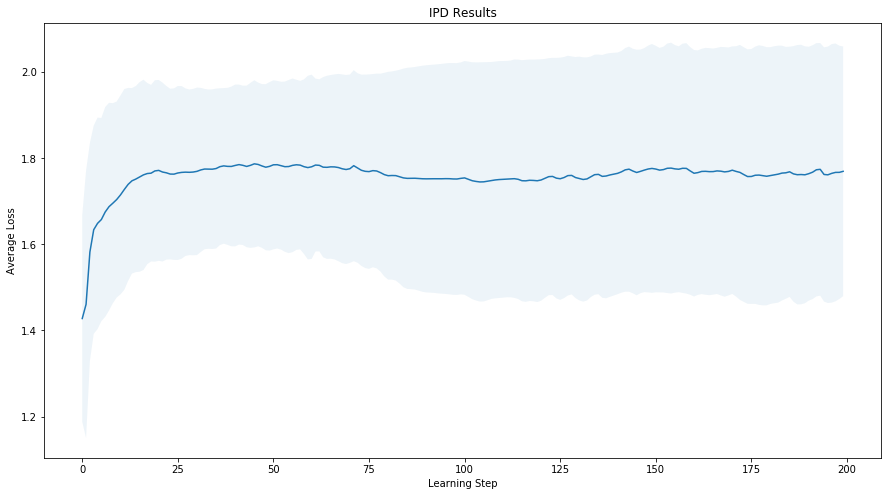

Jax time: 52.16817355155945
[1.42774579 1.4100123  1.42629115 1.45801565 1.46302989 1.46059421
 1.45424183 1.4494351  1.4499758  1.45024586 1.45053702 1.45084327
 1.45034058 1.44980718 1.44995196 1.45028463 1.4503391  1.45020983
 1.45012663 1.45027682 1.45054793 1.45062772 1.45046816 1.45031084
 1.45036487 1.45060961 1.45081693 1.45081289 1.45067352 1.45060264
 1.45070721 1.4509035  1.4510228  1.45099893 1.45092371 1.45092469
 1.45103403 1.45116854 1.45123232 1.45121752 1.45119734 1.45123696
 1.45133103 1.45141985 1.45145937 1.45146277 1.45147776 1.45153219
 1.45160813 1.45167036 1.45170267 1.45172286 1.45175742 1.45181353
 1.45187527 1.45192404 1.45195751 1.45198976 1.45203255 1.45208605
 1.45213875 1.45218237 1.45221893 1.45225784 1.45230411 1.45235397
 1.4524019  1.45244376 1.45248365 1.45252627 1.45257264 1.45261989
 1.45266524 1.45270757 1.45274957 1.45279376 1.45283969 1.45288537
 1.45292938 1.45297244 1.45301584 1.45306066 1.45310561 1.45315068
 1.45319448 1.45323774 1.45328194 

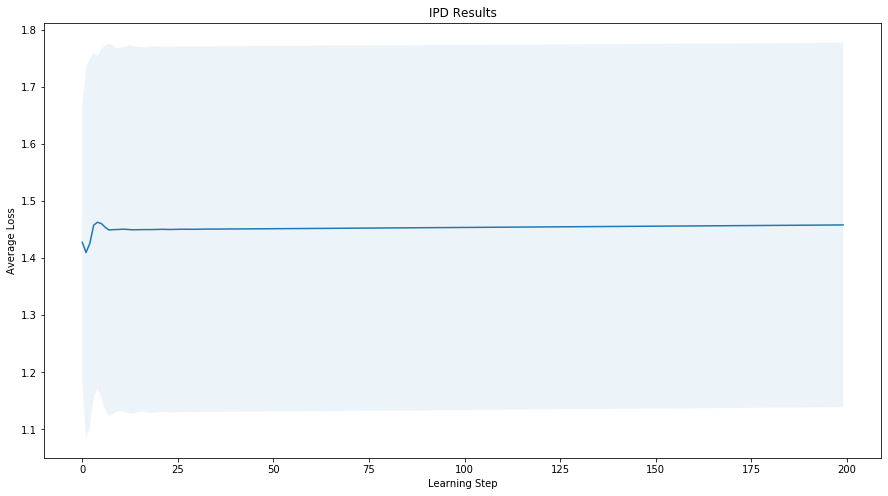

Jax time: 52.3714439868927
[1.42774579 1.412719   1.43692922 1.46952255 1.46895417 1.46445794
 1.45898865 1.45569436 1.45478693 1.4539409  1.45463734 1.45528808
 1.4546421  1.45393666 1.45382475 1.45387674 1.45406456 1.45418348
 1.45418117 1.45415039 1.45401965 1.45388978 1.45391417 1.45405925
 1.4541855  1.45415239 1.45399693 1.45390769 1.45397459 1.45411276
 1.45417002 1.45409338 1.45399026 1.45397983 1.4540637  1.45414131
 1.45413259 1.45406471 1.45402573 1.45405766 1.45411847 1.4541409
 1.45411142 1.4540757  1.45407817 1.45411427 1.45414257 1.45413782
 1.45411559 1.4541079  1.45412514 1.45414858 1.45415541 1.45414581
 1.45413763 1.45414434 1.45416013 1.45417066 1.45416973 1.45416447
 1.45416645 1.45417629 1.45418635 1.45418991 1.45418877 1.45418959
 1.45419567 1.4542037  1.4542091  1.45421088 1.45421213 1.45421613
 1.45422263 1.45422801 1.45423143 1.45423386 1.45423696 1.45424202
 1.45424764 1.45425171 1.45425482 1.45425799 1.45426257 1.45426737
 1.45427168 1.45427557 1.4542791  1.

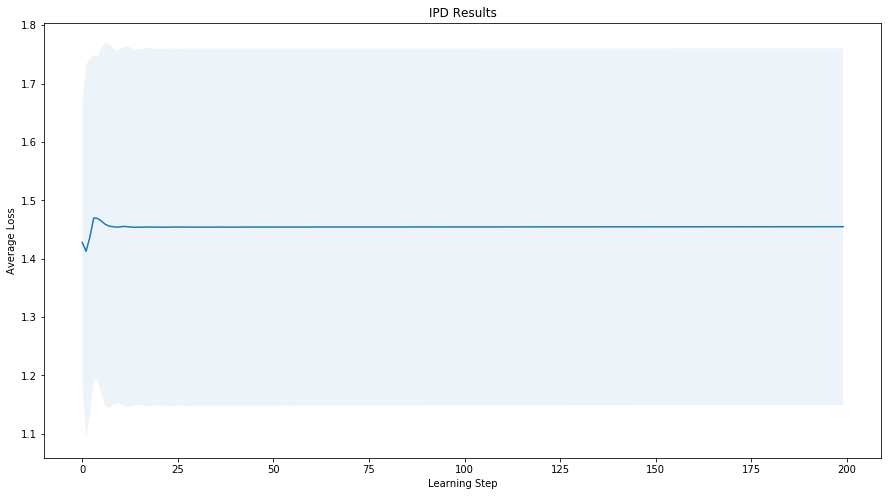

Jax time: 52.743809938430786
[1.42774579 1.41726228 1.45335232 1.4878951  1.48340293 1.48116612
 1.48095855 1.47828067 1.47463183 1.47434187 1.47860277 1.48327822
 1.48491978 1.48478683 1.48527525 1.48764098 1.49092043 1.49322935
 1.4943153  1.49530617 1.49717953 1.49969682 1.50188241 1.50338041
 1.5047073  1.50646459 1.50860311 1.51060159 1.51220681 1.5136802
 1.51538308 1.51731474 1.5191758  1.52079419 1.52231128 1.52395727
 1.52575161 1.52751197 1.52911108 1.5306244  1.53221225 1.53390947
 1.53559544 1.53716126 1.53864475 1.5401773  1.54181171 1.54345223
 1.54497781 1.5464063  1.54788533 1.54949686 1.55112604 1.55259347
 1.55391967 1.55534581 1.55700708 1.5586729  1.56000762 1.56111661
 1.56252295 1.5644259  1.56618376 1.56711206 1.56773899 1.56931511
 1.57195032 1.57370647 1.57349526 1.57324273 1.57526222 1.57883802
 1.5805226  1.57941145 1.57875898 1.5805008  1.58328885 1.58530853
 1.58594918 1.58636079 1.58759794 1.58946585 1.59118214 1.59230256
 1.59316466 1.59434966 1.59592462 

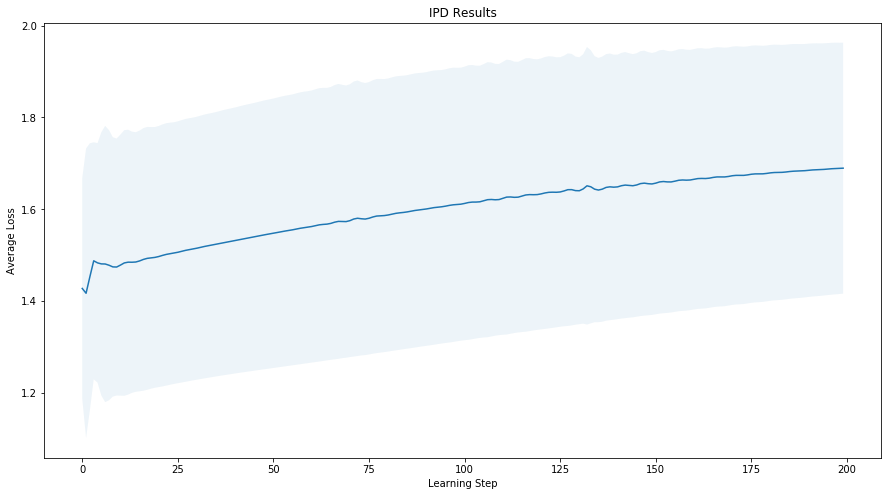

Jax time: 52.28849506378174
[1.42774579 1.40472236 1.40511742 1.42852005 1.4419283  1.44393867
 1.44223738 1.43617463 1.43310793 1.43534142 1.43667802 1.43731807
 1.43740001 1.4367852  1.43603073 1.43589097 1.4363256  1.43679246
 1.43692933 1.43673876 1.43646619 1.43638148 1.43655321 1.43680358
 1.43691276 1.43683205 1.43668563 1.4366295  1.43672048 1.43688188
 1.43698314 1.43696789 1.43688899 1.4368442  1.43688697 1.43699007
 1.43707937 1.43710285 1.43707258 1.43704383 1.43706146 1.43712478
 1.43719522 1.43723444 1.43723648 1.43722724 1.4372371  1.43727648
 1.43732856 1.43736992 1.43738916 1.43739564 1.437407   1.43743484
 1.43747402 1.4375119  1.43753878 1.43755535 1.43757126 1.43759463
 1.43762624 1.43765934 1.43768836 1.43771083 1.43773077 1.43775322
 1.43778121 1.43781084 1.43783966 1.43786474 1.43788738 1.43791056
 1.43793648 1.43796424 1.43799211 1.43801834 1.43804285 1.43806703
 1.43809206 1.43811866 1.43814575 1.43817211 1.4381974  1.43822241
 1.4382477  1.43827359 1.43830014 

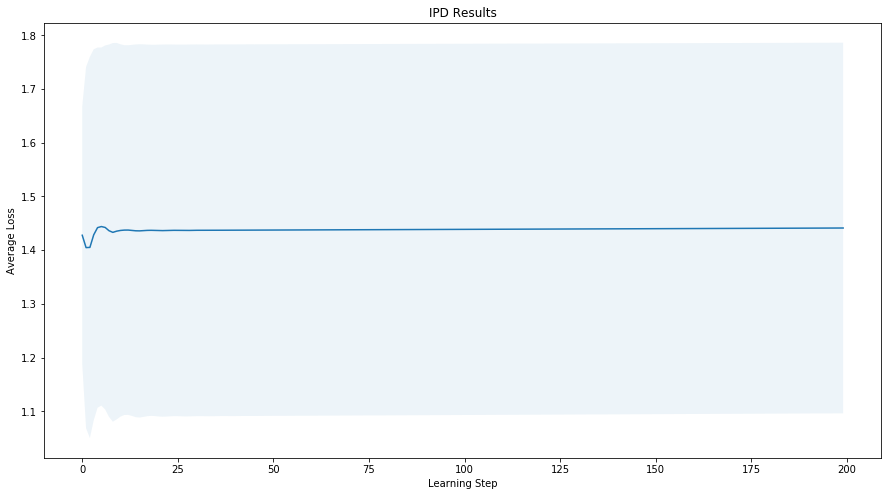

Jax time: 52.426249504089355
[1.42774579 1.41856683 1.45894517 1.4874613  1.47671252 1.47130189
 1.46843385 1.46285314 1.45828983 1.45867598 1.46253034 1.46377847
 1.46194825 1.46020356 1.46037221 1.46216907 1.46291675 1.46215711
 1.46134018 1.46169119 1.46282265 1.46318037 1.46268445 1.46233734
 1.46284603 1.46364777 1.46377785 1.46341025 1.46333737 1.46389883
 1.4644844  1.4645033  1.46425116 1.46434514 1.46488638 1.46531623
 1.46529478 1.46515257 1.4653459  1.46583207 1.46615041 1.46612811
 1.4660838  1.46633028 1.46675152 1.46699242 1.46699184 1.46702624
 1.46729604 1.46765517 1.46784676 1.46787618 1.46797096 1.46824463
 1.46855035 1.46871273 1.46877457 1.46891198 1.46917851 1.46944178
 1.46958951 1.46968159 1.4698472  1.47010089 1.47033242 1.47047567
 1.47059297 1.4707763  1.47101528 1.4712238  1.47136798 1.47150645
 1.47169878 1.47192388 1.47211707 1.4722657  1.47241961 1.47261586
 1.47282853 1.47301205 1.47316628 1.47333138 1.4735283  1.47373084
 1.47390841 1.47406851 1.47424175

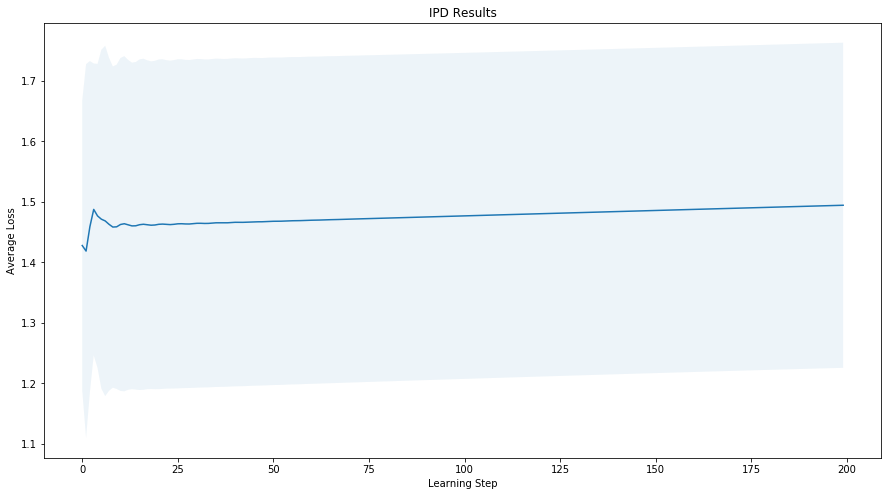

Jax time: 52.34848237037659
[1.42774579 1.40470932 1.40506691 1.42841123 1.44179341 1.44377589
 1.44205058 1.43596411 1.4328766  1.43509113 1.43640391 1.43701355
 1.43706341 1.43641964 1.43564408 1.43549113 1.43591422 1.43636477
 1.43647826 1.43626081 1.4359616  1.43585498 1.43601018 1.43624507
 1.4363357  1.43623225 1.43606163 1.43598296 1.43605392 1.43619725
 1.43628025 1.43624366 1.4361426  1.43607558 1.43609764 1.43618181
 1.43625163 1.43625414 1.43620249 1.4361523  1.43614954 1.43619282
 1.43624332 1.43626171 1.43624261 1.43621184 1.43620133 1.4362207
 1.43625283 1.4362736  1.43627172 1.43625712 1.43624778 1.43625507
 1.43627471 1.43629189 1.43629794 1.43629329 1.43628816 1.43629128
 1.43630242 1.43631575 1.43632397 1.43632519 1.43632408 1.4363263
 1.43633353 1.43634334 1.4363511  1.43635543 1.43635745 1.4363599
 1.43636524 1.43637272 1.43638014 1.43638551 1.43638921 1.43639235
 1.43639724 1.43640305 1.43640962 1.43641524 1.43642023 1.43642413
 1.43642861 1.43643414 1.43643994 1.4

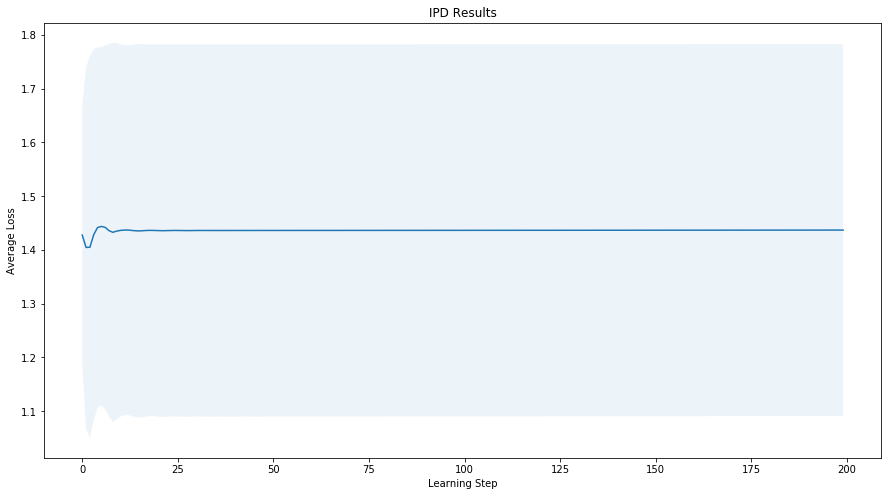

Jax time: 52.404648303985596
[1.42774579 1.4155552  1.44777988 1.47946217 1.47300485 1.46808287
 1.46427584 1.46039163 1.45688493 1.4556665  1.45768786 1.45917452
 1.4585106  1.45733002 1.45665677 1.45702563 1.457853   1.45804896
 1.45766438 1.45721371 1.45722099 1.45764101 1.4578987  1.45779556
 1.45755172 1.45751754 1.45774418 1.4579299  1.45790969 1.45779096
 1.45778267 1.45792607 1.458052   1.45805376 1.4579982  1.4580132
 1.45811931 1.45821143 1.45822193 1.45819816 1.45822497 1.45831064
 1.45838483 1.45840218 1.45839699 1.45842801 1.45850007 1.45856404
 1.4585874  1.45859483 1.4586272  1.45868935 1.45874633 1.45877504
 1.45879082 1.45882412 1.45887889 1.4589312  1.45896338 1.45898597
 1.45901962 1.45906898 1.45911754 1.45915231 1.45917969 1.45921399
 1.45925927 1.45930541 1.4593419  1.4593724  1.45940738 1.45944992
 1.45949402 1.45953147 1.45956446 1.45959978 1.45964122 1.45968325
 1.4597214  1.45975622 1.45979211 1.4598321  1.45987303 1.45991138
 1.45994723 1.45998409 1.4600231  

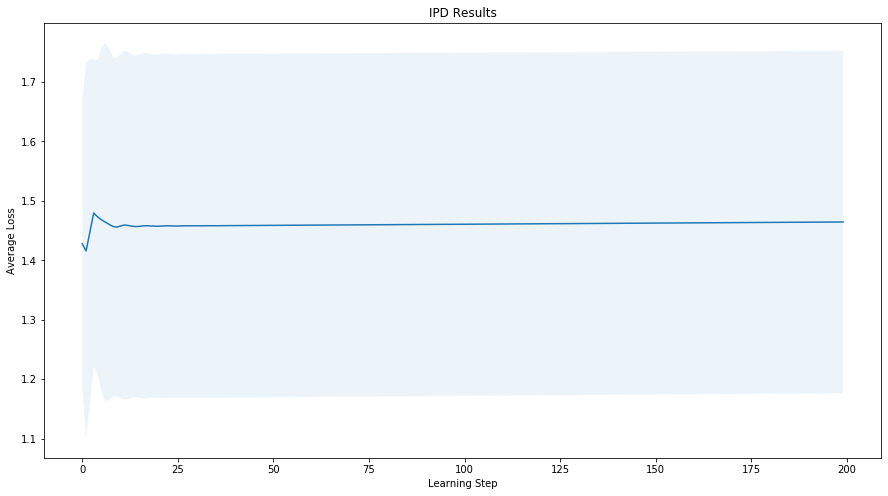

Jax time: 51.94319438934326
[1.42774579 1.4183921  1.45827627 1.48655017 1.47565046 1.47000612
 1.46682536 1.46116831 1.45658583 1.45682261 1.46039186 1.46133695
 1.45936905 1.4575537  1.45755923 1.45910866 1.45962161 1.45871328
 1.45777348 1.4579416  1.45884928 1.4590028  1.45835452 1.45786013
 1.45818074 1.45877274 1.45871081 1.45818503 1.45795383 1.45832979
 1.45871452 1.45854447 1.45812731 1.45805866 1.45841897 1.45865335
 1.45844318 1.45813146 1.45815996 1.45846915 1.45859499 1.45838411
 1.45816663 1.45824814 1.45849502 1.45854501 1.45835475 1.45821518
 1.45832047 1.45850552 1.45850683 1.45834702 1.45826773 1.45837706
 1.45850847 1.45848064 1.45835398 1.45831873 1.45842033 1.45850805
 1.45846561 1.45837083 1.45836512 1.45845282 1.45850694 1.45846037
 1.45839384 1.45840644 1.45847832 1.45850742 1.45846312 1.4584195
 1.45844216 1.45849832 1.45851071 1.45847189 1.45844641 1.45847327
 1.45851494 1.45851683 1.45848532 1.45847314 1.45850006 1.45852952
 1.45852548 1.45850165 1.45849868 1

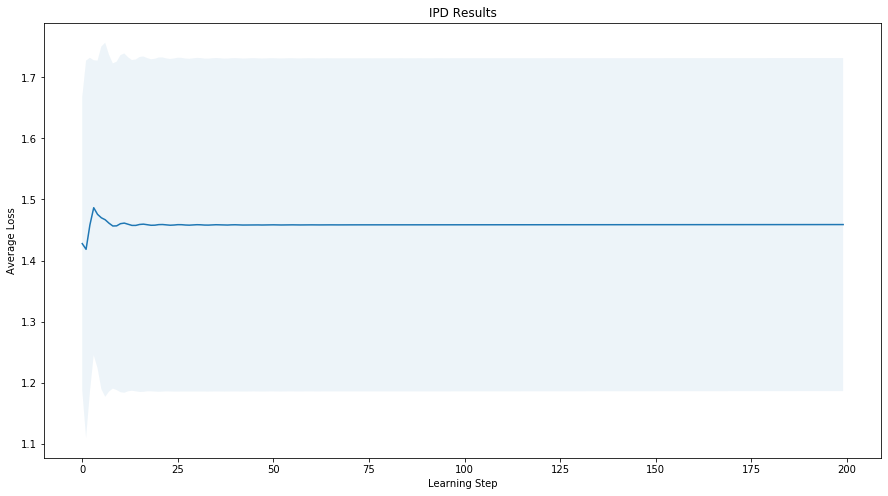

Jax time: 52.60755968093872
[1.42774579 1.41063123 1.42896899 1.4695372  1.48427015 1.49033614
 1.49164725 1.49184739 1.49423149 1.49835776 1.50300745 1.50809587
 1.51285238 1.51621848 1.51914949 1.52303887 1.52774667 1.53292083
 1.53781004 1.54166317 1.544693   1.5478542  1.55160285 1.55593698
 1.56036658 1.56412514 1.56689673 1.56925606 1.57206889 1.575745
 1.57994199 1.58357126 1.58581278 1.58748844 1.58996016 1.59378786
 1.59837021 1.60182409 1.60323252 1.60439597 1.60676894 1.61069253
 1.61499137 1.61777338 1.6188543  1.62006547 1.62256956 1.62625281
 1.62973771 1.63192154 1.63319604 1.63475657 1.63739432 1.64076184
 1.64361091 1.6453743  1.64663606 1.6483548  1.65114576 1.65444501
 1.65687504 1.65812635 1.65921955 1.66135162 1.66488321 1.66795169
 1.66919755 1.66989664 1.67125664 1.67499434 1.6791599  1.68008462
 1.68068672 1.68138005 1.68261269 1.68559555 1.68865464 1.69003103
 1.69078452 1.69114318 1.69189495 1.6937585  1.69626732 1.69808663
 1.6986764  1.6987297  1.69921731 1.

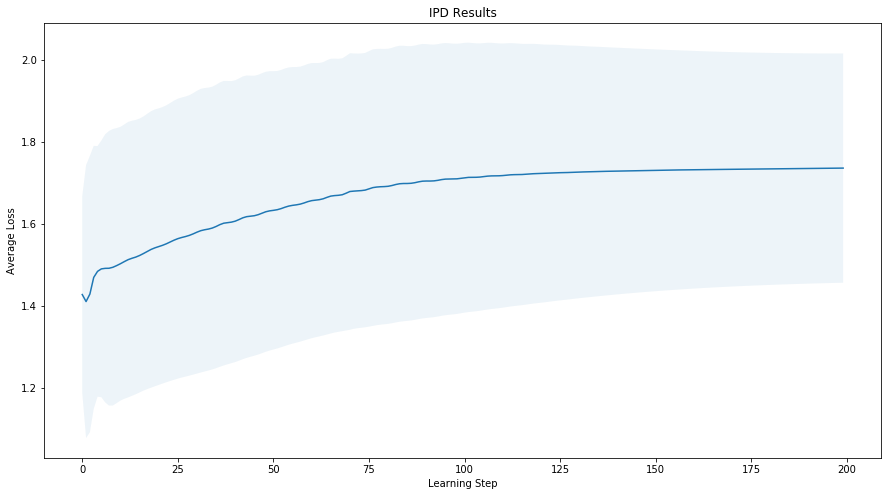

Jax time: 52.115185022354126
[1.42774579 1.41001197 1.4262711  1.45797792 1.46300181 1.46057317
 1.45422287 1.44941422 1.44995457 1.45022527 1.45051771 1.4508242
 1.45031924 1.4497854  1.44993029 1.45026477 1.45032082 1.45019149
 1.45010671 1.4502554  1.45052678 1.45060787 1.45044955 1.45029191
 1.45034502 1.4505888  1.45079672 1.45079347 1.45065413 1.45058325
 1.45068713 1.45088383 1.45100296 1.45097938 1.45090412 1.45090515
 1.45101393 1.45114845 1.45121267 1.45119791 1.45117761 1.45121717
 1.45131125 1.45140041 1.45143951 1.45144351 1.45145847 1.45151247
 1.45158875 1.4516509  1.45168337 1.45170349 1.45173796 1.45179418
 1.45185572 1.45190484 1.45193804 1.45197014 1.45201321 1.45206661
 1.45211932 1.45216259 1.45219985 1.45223872 1.45228467 1.45233483
 1.45238238 1.45242426 1.45246429 1.45250711 1.45255339 1.45260083
 1.4526457  1.45268825 1.45273046 1.45277463 1.4528205  1.45286613
 1.45291035 1.45295343 1.45299637 1.45304124 1.45308676 1.45313132
 1.4531754  1.45321895 1.45326315 

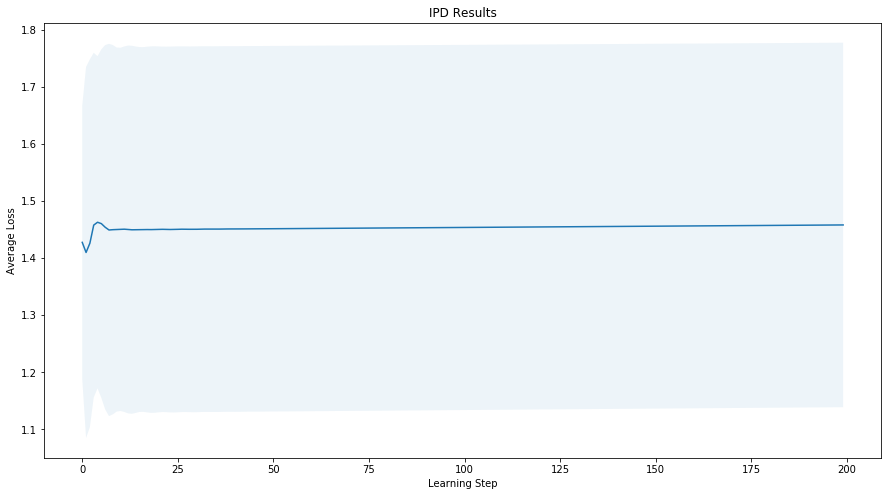

Jax time: 52.24563789367676
[1.42774579 1.41553771 1.44771183 1.47936074 1.4728898  1.46793891
 1.4640919  1.46020131 1.45669977 1.4554737  1.45746966 1.45891941
 1.45823168 1.45704295 1.45635916 1.45670643 1.45750709 1.45768066
 1.45728142 1.45681567 1.45680284 1.45720001 1.45743758 1.45731734
 1.45705649 1.45700195 1.45720694 1.457374   1.45733634 1.45719942
 1.45717101 1.45729355 1.45740037 1.45738477 1.4573108  1.45730573
 1.45739172 1.4574645  1.45745681 1.45741478 1.45742184 1.45748797
 1.45754272 1.45754152 1.45751774 1.45752964 1.45758226 1.45762683
 1.45763111 1.45761976 1.45763297 1.45767602 1.45771407 1.45772344
 1.45772033 1.45773471 1.45777025 1.45780347 1.4578164  1.45781997
 1.45783462 1.45786486 1.45789459 1.45791001 1.45791809 1.45793361
 1.45795984 1.45798671 1.45800402 1.45801574 1.45803164 1.45805527
 1.45808008 1.45809828 1.45811211 1.45812879 1.45815085 1.458174
 1.45819285 1.45820856 1.45822559 1.45824656 1.4582684  1.45828771
 1.45830428 1.45832207 1.4583422  1.

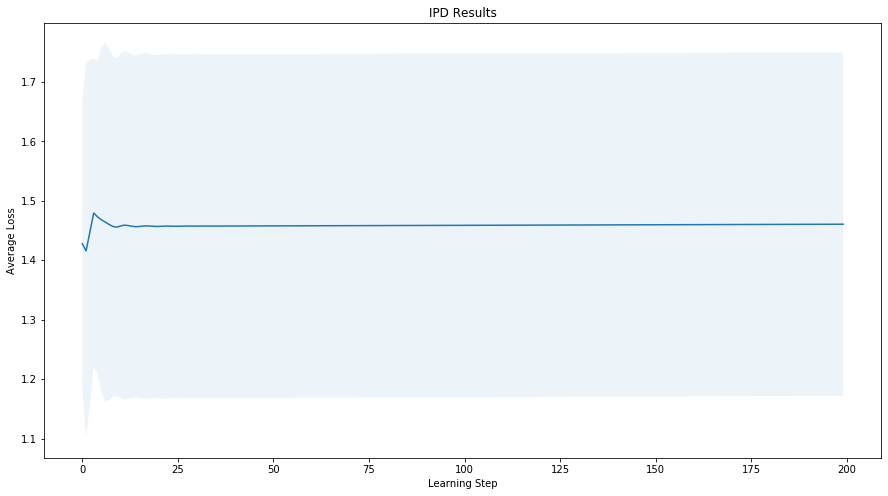

Jax time: 52.305009841918945
[1.42774579 1.42765185 1.48987625 1.49526917 1.47786165 1.47070636
 1.46919503 1.46540887 1.46403252 1.46643849 1.46656496 1.46482642
 1.464426   1.46581284 1.4661957  1.46484694 1.46467835 1.46583089
 1.46663641 1.46578722 1.46549731 1.46643833 1.46738298 1.46705685
 1.46670966 1.46739999 1.46833796 1.46838742 1.4680977  1.46854197
 1.4694082  1.46969805 1.46952576 1.46978469 1.47054146 1.47098042
 1.47093846 1.47108457 1.47171441 1.47224031 1.47232277 1.47241467
 1.47291877 1.47348313 1.47367882 1.4737591  1.47415031 1.47471359
 1.47500835 1.47510765 1.4754077  1.47593824 1.47631247 1.47645342
 1.4766873  1.47716404 1.47759391 1.47779036 1.47798513 1.47839774
 1.47885568 1.47911362 1.4792947  1.47964392 1.48010379 1.48042037
 1.48061005 1.48090458 1.48134432 1.48170954 1.48192466 1.48217917
 1.48258418 1.48298141 1.48323384 1.4834646  1.48382825 1.48423987
 1.4845328  1.48475764 1.48508005 1.48548884 1.48581892 1.48605302
 1.48634069 1.48673252 1.48709239

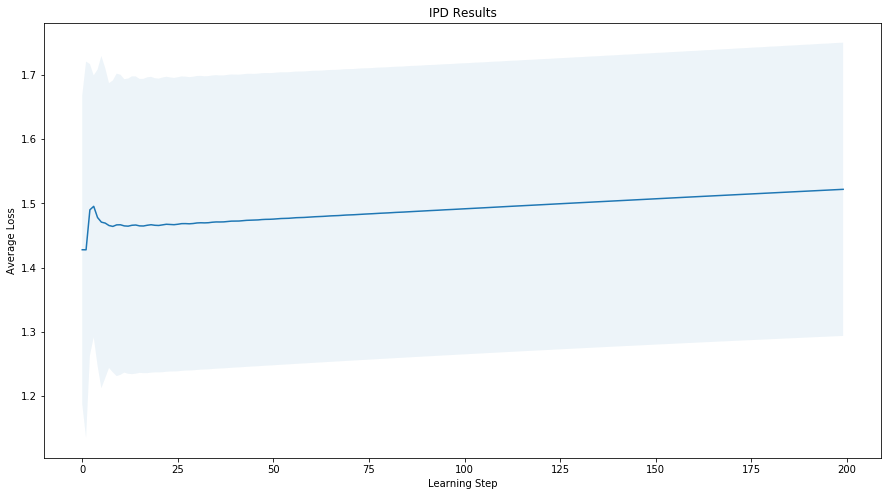

Jax time: 52.13614583015442
[1.42774579 1.41305709 1.43806213 1.47135635 1.47122135 1.46730312
 1.46263933 1.45968845 1.45881769 1.45819692 1.45934695 1.4606558
 1.46048566 1.45997616 1.46010769 1.46059846 1.46133732 1.46193516
 1.46226042 1.46251746 1.46278164 1.46314259 1.46363455 1.46415233
 1.46460133 1.46494303 1.46524228 1.4656133  1.46607619 1.4665593
 1.46698064 1.46733097 1.46767903 1.46808238 1.4685309  1.46897016
 1.46936497 1.46973352 1.47011839 1.47053411 1.47096136 1.47137193
 1.47176193 1.47214916 1.47254994 1.47296235 1.47337291 1.47377315
 1.47416719 1.474564   1.47496742 1.47537323 1.47577571 1.47617375
 1.47657141 1.47697074 1.47737209 1.47777309 1.47817238 1.47857036
 1.47896846 1.47936713 1.47976593 1.48016436 1.48056188 1.48095942
 1.48135607 1.48175293 1.48215009 1.48254679 1.48294285 1.48333846
 1.48373404 1.48412939 1.48452435 1.48491907 1.48531374 1.4857075
 1.48610141 1.48649494 1.48688818 1.48728124 1.48767351 1.4880658
 1.48845766 1.48884959 1.48924055 1.48

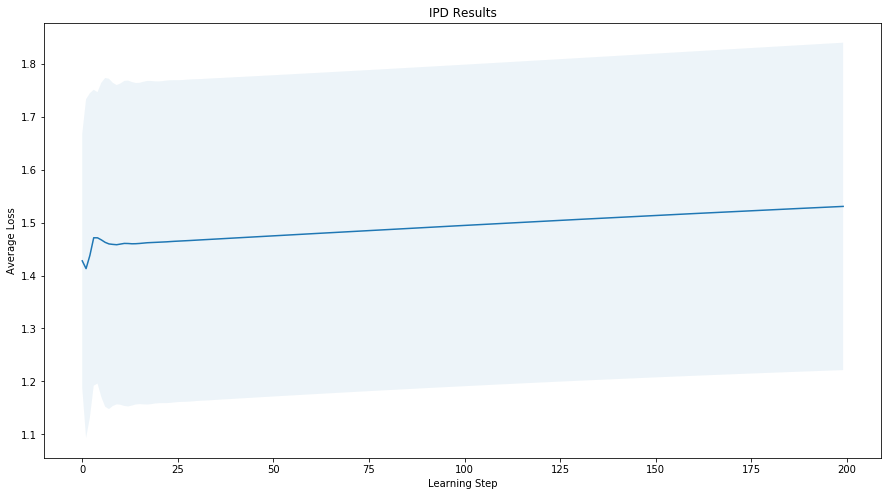

Jax time: 52.427417278289795
[1.42774579 1.42464548 1.4799588  1.49472526 1.47973568 1.47261773
 1.46995369 1.46454461 1.46253075 1.46546495 1.46771043 1.46611333
 1.46446862 1.46507132 1.46730332 1.46695822 1.46546279 1.46543111
 1.46733293 1.46816254 1.46702865 1.46641098 1.46757765 1.46906164
 1.46877146 1.4679204  1.46831449 1.46973676 1.47027131 1.46968151
 1.46953246 1.4705031  1.47145965 1.47138774 1.47106218 1.47152959
 1.47249319 1.47288695 1.47269367 1.4728142  1.47354951 1.47419351
 1.47427116 1.47426416 1.47472412 1.47540128 1.47572938 1.47576934
 1.47602616 1.4766029  1.47708048 1.47725025 1.47741626 1.47785187
 1.47836895 1.47867203 1.47884254 1.47916158 1.47964225 1.48003581
 1.4802629  1.48051863 1.48093    1.48135988 1.48165689 1.48189941
 1.48224432 1.48266712 1.48301965 1.48328297 1.48358341 1.48397457
 1.48435729 1.48465618 1.48493832 1.48529168 1.4856794  1.48601235
 1.48629812 1.48662057 1.48699592 1.48735204 1.48765507 1.48795937
 1.48831317 1.48867934 1.48900263

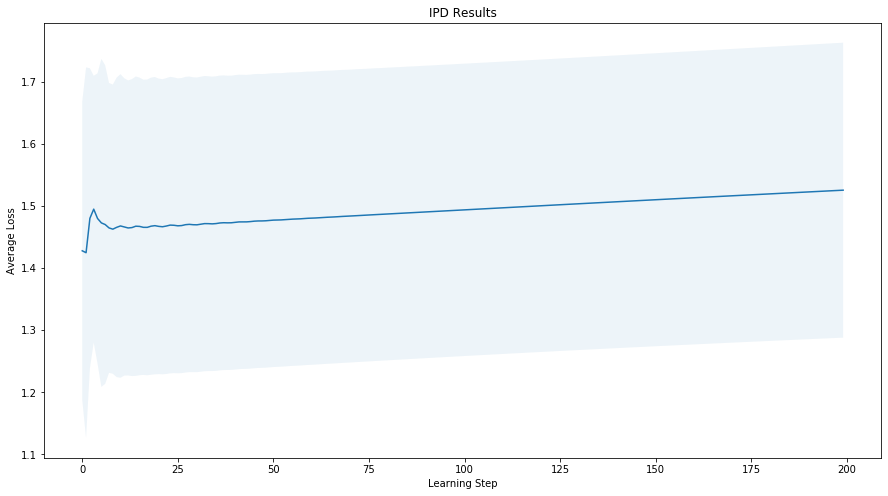

Jax time: 52.49154472351074
[1.42774579 1.40633659 1.41150075 1.44213765 1.45867026 1.46438085
 1.46580137 1.46295255 1.46186582 1.46538303 1.46920385 1.47294668
 1.47642696 1.47916962 1.48105637 1.48256317 1.48443311 1.48692533
 1.48984431 1.49289533 1.49574546 1.49813873 1.50014804 1.50216922
 1.50453756 1.50727532 1.51013034 1.51274017 1.5149246  1.51689023
 1.51903306 1.52155748 1.52432231 1.52694639 1.52913368 1.53100062
 1.53297191 1.5353456  1.53802638 1.54057829 1.54261281 1.54425667
 1.54604157 1.54833843 1.55100724 1.55343869 1.55513153 1.55637868
 1.55796321 1.56030936 1.56310323 1.56535526 1.56644922 1.56714182
 1.56857753 1.57116689 1.57427599 1.57627328 1.57654328 1.57664744
 1.5779637  1.58082179 1.58438813 1.58646648 1.58626989 1.58594154
 1.58694897 1.58958824 1.59323107 1.59597102 1.596498   1.59621353
 1.59682883 1.59883751 1.6019081  1.60475855 1.60613998 1.60641188
 1.60693828 1.60844824 1.61088973 1.61345907 1.61514692 1.61584739
 1.6164541  1.61771478 1.61974889 

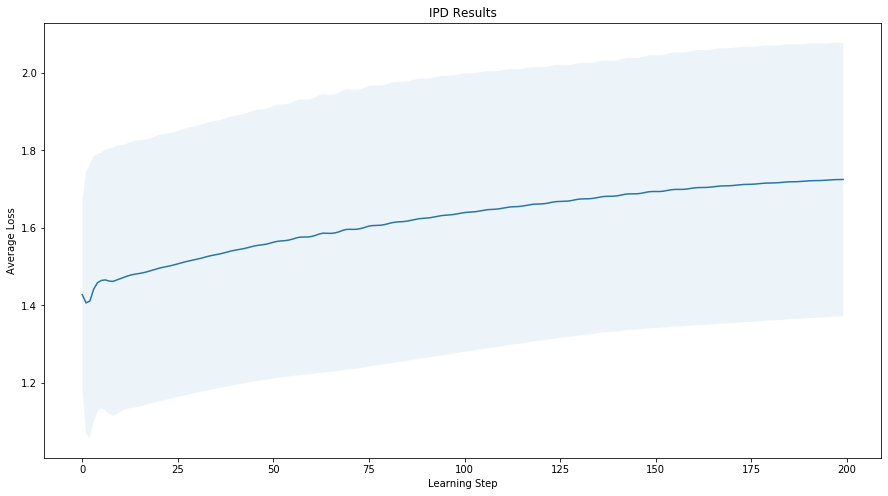

Jax time: 51.812012672424316
[1.42774579 1.42312168 1.47546946 1.49955761 1.48796439 1.48313684
 1.48248175 1.47771249 1.47528334 1.47893321 1.48471794 1.48649897
 1.48540357 1.4855021  1.48885331 1.49237942 1.49319666 1.49302652
 1.49465051 1.49815398 1.50042526 1.50081446 1.50140163 1.50386561
 1.50688166 1.50833363 1.50877354 1.51008636 1.51278901 1.51514338
 1.51616648 1.51692452 1.51875953 1.521299   1.52308288 1.52398256
 1.52513675 1.52722258 1.52941735 1.53081364 1.53179157 1.53328841
 1.53538524 1.53721328 1.53840783 1.53956568 1.54127915 1.54323168
 1.5447564  1.5458978  1.54725193 1.54904092 1.55077882 1.55209635
 1.55328073 1.55478962 1.5565378  1.55805721 1.55925903 1.56053132
 1.5621264  1.56376282 1.56509442 1.56624697 1.56760938 1.56923456
 1.57073684 1.57190541 1.57302304 1.57447991 1.57614756 1.57750572
 1.57842104 1.57947699 1.58120193 1.5830574  1.58398315 1.58421781
 1.5854664  1.58824189 1.59005615 1.58912083 1.58835958 1.59085133
 1.59443285 1.5949844  1.59318001

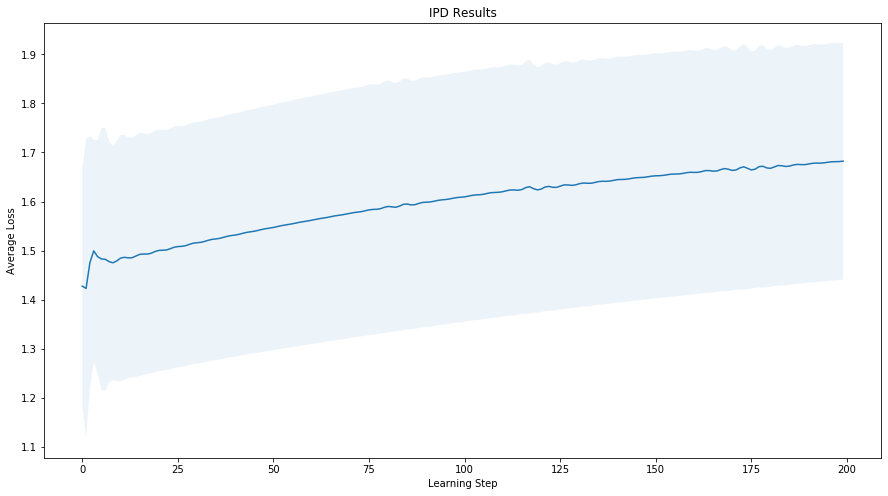

Jax time: 51.83705377578735
[1.42774579 1.40896815 1.42213017 1.4569139  1.46888204 1.47217592
 1.47040421 1.46702924 1.46785114 1.47095752 1.47395193 1.47714471
 1.479919   1.48164124 1.48292611 1.48479782 1.48729654 1.49012445
 1.49295275 1.49541198 1.49741814 1.49930454 1.5014404  1.50392113
 1.506567   1.50904691 1.51115986 1.51305475 1.51507737 1.51742545
 1.51997776 1.52239031 1.52441816 1.52619371 1.52810202 1.53038043
 1.53288025 1.53516971 1.53697373 1.53852682 1.54034079 1.54265687
 1.54516167 1.54720927 1.54856936 1.5498136  1.55167133 1.55426381
 1.55680324 1.55827007 1.55888044 1.55989914 1.56219854 1.56540118
 1.56766962 1.56793886 1.56780529 1.56903101 1.57216876 1.57570487
 1.57714081 1.57657116 1.57647997 1.57829398 1.58166005 1.58456449
 1.58557991 1.58556929 1.58622827 1.58832229 1.59121641 1.59345857
 1.59443742 1.59496905 1.59605229 1.59805734 1.60047853 1.60237358
 1.60341377 1.60417841 1.60536554 1.60722046 1.60934267 1.61103126
 1.6120556  1.61287601 1.61407618 

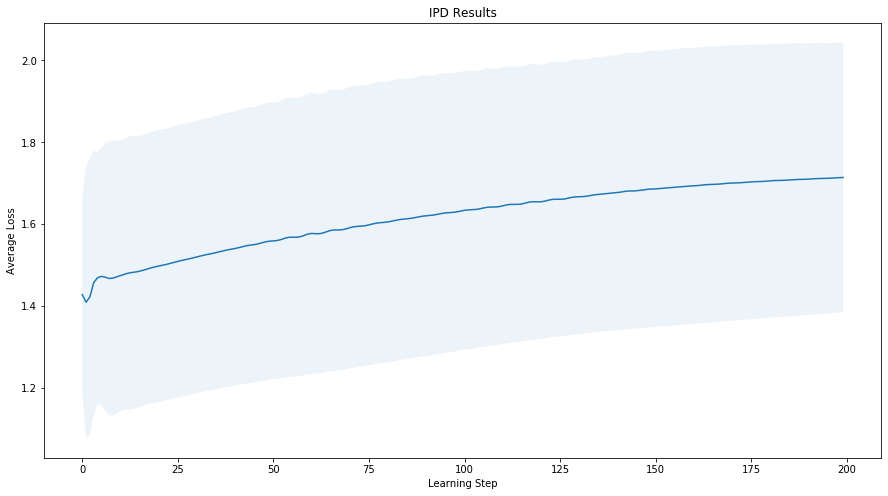

Jax time: 51.91728663444519
[1.42774579 1.42167393 1.47006082 1.49278577 1.47967358 1.47321453
 1.47031777 1.46416904 1.46093651 1.46341886 1.46740414 1.46717651
 1.46488094 1.46400623 1.46590014 1.46758904 1.46685676 1.46567171
 1.46610538 1.46798453 1.4685489  1.46763757 1.46718669 1.4683273
 1.46972832 1.46964987 1.46891425 1.46911512 1.47043401 1.47125336
 1.47090351 1.47053314 1.47118554 1.47233771 1.47269554 1.47234228
 1.47236864 1.473225   1.4740706  1.47415398 1.47395618 1.47430323
 1.47515735 1.47570301 1.47568428 1.47570409 1.47624627 1.47697636
 1.47730084 1.47730528 1.47753037 1.47814271 1.47870907 1.47891121
 1.47900808 1.47938416 1.4799735  1.48039373 1.4805585  1.48076789
 1.48122568 1.48174388 1.48206318 1.48224899 1.48255722 1.48303522
 1.48347169 1.48373873 1.48397509 1.48434986 1.48480816 1.48517549
 1.48543191 1.48572388 1.48612967 1.486549   1.48687187 1.48714354
 1.48748    1.48788897 1.48826803 1.48857026 1.48886813 1.48923242
 1.48962715 1.48997427 1.49027476 1

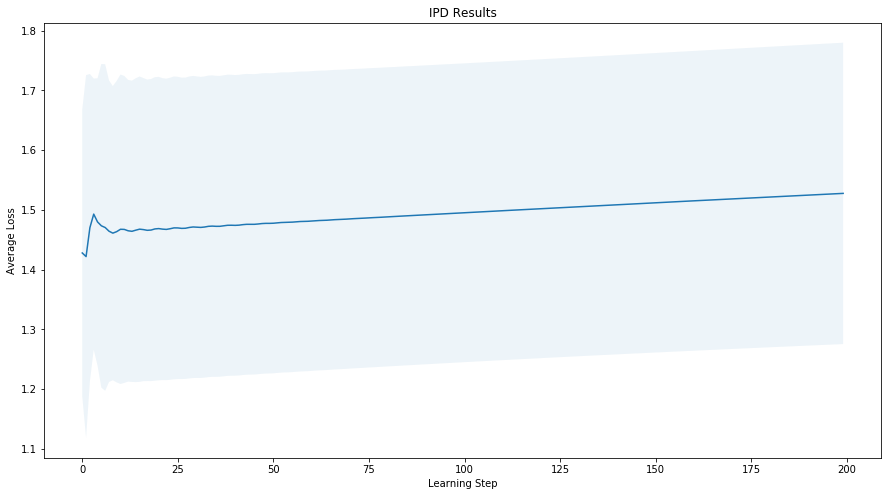

Jax time: 51.73702025413513
[1.42774579 1.42107348 1.46571613 1.53906885 1.58049324 1.60920446
 1.62846329 1.63655002 1.6447077  1.65747353 1.67266101 1.68650651
 1.69786336 1.70661394 1.71266325 1.71825041 1.72371218 1.73018032
 1.73659039 1.74122184 1.7447724  1.74691579 1.74866882 1.75061942
 1.75287409 1.75547756 1.75768564 1.75915878 1.76012454 1.76033749
 1.76000008 1.75966948 1.75989183 1.76065644 1.76174125 1.76280018
 1.7623239  1.75997433 1.75697538 1.75459964 1.75396271 1.75532765
 1.75694826 1.75547082 1.75191267 1.74827695 1.74561877 1.74409415
 1.74345194 1.74330533 1.74340379 1.74406868 1.74567654 1.74715475
 1.74613615 1.74386666 1.74236338 1.74177249 1.74155625 1.74148003
 1.74147398 1.74160338 1.74201426 1.74281656 1.74393514 1.74510729
 1.74606595 1.74640927 1.74573112 1.74468842 1.74482125 1.74636059
 1.74771882 1.74567527 1.73870339 1.73092417 1.72663087 1.72536639
 1.72670736 1.72938108 1.73011213 1.72640239 1.72216868 1.71968813
 1.71933765 1.72036655 1.72190915 

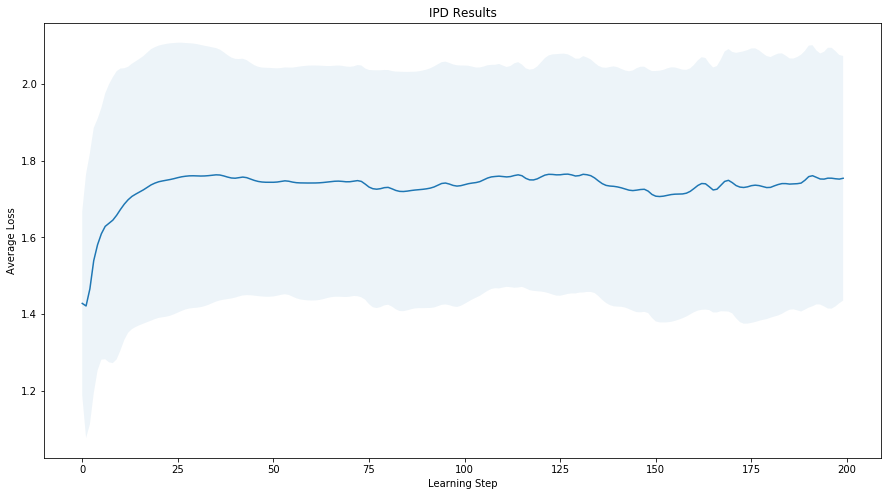

Jax time: 52.43029260635376
[1.42774579 1.41874479 1.45962533 1.48838789 1.47779565 1.47261712
 1.4700663  1.46457589 1.46003845 1.46057694 1.46471653 1.46627349
 1.46458921 1.46291816 1.46324971 1.46529588 1.46628355 1.46567787
 1.46498562 1.46552007 1.46687755 1.46744445 1.46710571 1.46690787
 1.4676047  1.46861818 1.46894527 1.46874039 1.4688277  1.46957417
 1.4703618  1.4705736  1.47049057 1.47074913 1.47147069 1.47209639
 1.47226681 1.47229882 1.47265753 1.47332042 1.47383017 1.47400028
 1.47413177 1.47454436 1.47513996 1.47557014 1.47576082 1.4759722
 1.47640747 1.47693973 1.47731914 1.47753918 1.47780959 1.47824857
 1.47872766 1.47907716 1.47932737 1.47963918 1.4800708  1.48050763
 1.48084199 1.48111969 1.4814581  1.48187719 1.4822829  1.48261151
 1.48291193 1.4832658  1.4836708  1.48405478 1.48438285 1.48470098
 1.48506253 1.48545452 1.48582309 1.48615379 1.48648481 1.4868492
 1.48722927 1.4875885  1.4879224  1.48826182 1.48862587 1.48899665
 1.4893496  1.48968698 1.49003185 1.

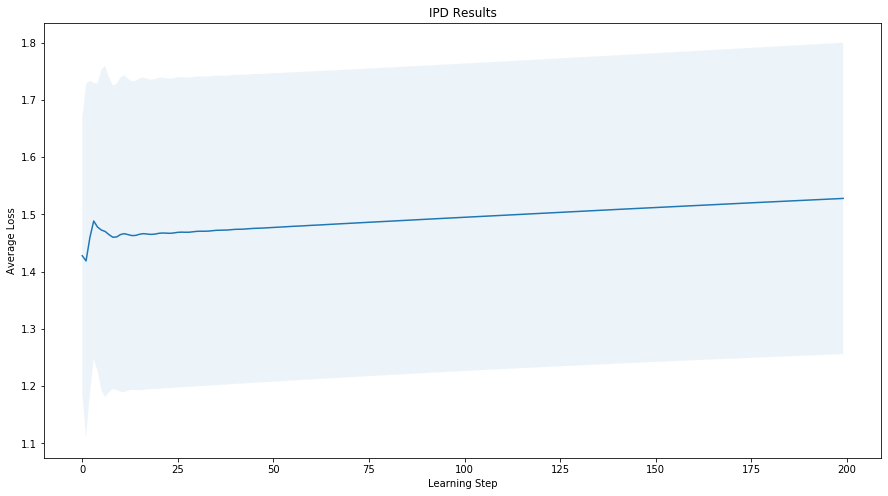

Jax time: 52.070512533187866
[1.42774579 1.42729994 1.48864302 1.49385678 1.47614524 1.46861067
 1.46657212 1.46249657 1.4609408  1.46301222 1.46269042 1.46068419
 1.46008999 1.46115697 1.46108773 1.45940613 1.45904914 1.45989985
 1.46029142 1.4590811  1.45857899 1.45923782 1.45980096 1.45911483
 1.45852396 1.45894518 1.45952386 1.45922096 1.45866436 1.45884259
 1.45936422 1.45930936 1.45885674 1.45884794 1.45926973 1.45936771
 1.459039   1.45891608 1.45921862 1.45940247 1.45919389 1.45901805
 1.45920272 1.45942141 1.4593205  1.45913522 1.45921826 1.45943219
 1.4594203  1.4592558  1.45926125 1.4594426  1.4594972  1.45937232
 1.4593257  1.45946018 1.45955573 1.45947939 1.45940576 1.45948898
 1.45960145 1.45957371 1.45949467 1.45953168 1.45964049 1.45965485
 1.45958657 1.4595877  1.45967894 1.45972359 1.45967693 1.45965451
 1.45972128 1.45978291 1.45976174 1.45972923 1.45977011 1.45983622
 1.4598396  1.45980758 1.45982574 1.45988723 1.45991028 1.45988656
 1.45988843 1.45993858 1.45997518

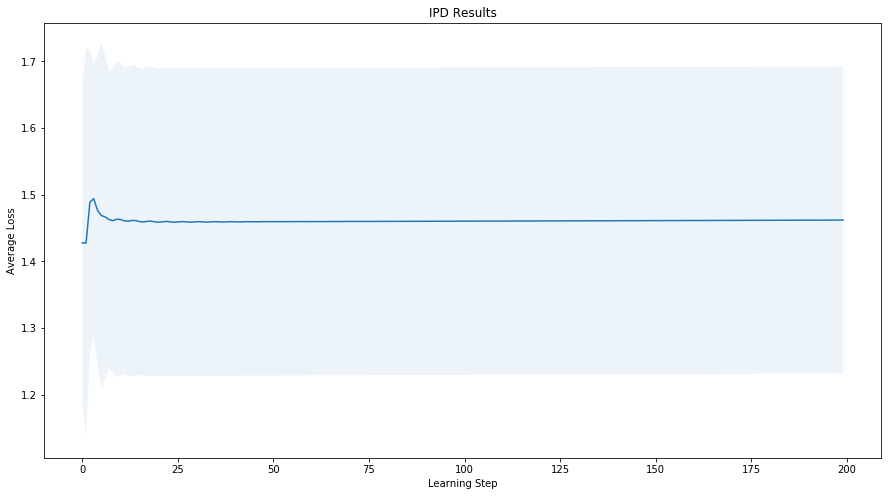

Jax time: 51.708120584487915
[1.42774579 1.4274666  1.4892272  1.49452577 1.47695763 1.46960286
 1.46781404 1.46387542 1.46240371 1.46463315 1.46452434 1.46264495
 1.46214236 1.46336126 1.46350666 1.46198268 1.46171489 1.46270893
 1.46329767 1.46225824 1.46185627 1.46264927 1.46339448 1.46287893
 1.46240327 1.46295209 1.46370197 1.46356706 1.46313694 1.46344071
 1.46412637 1.46423655 1.46391738 1.46403463 1.4646153  1.46487695
 1.46468519 1.46468949 1.46514685 1.46549398 1.46542532 1.46537684
 1.46571222 1.46609535 1.46613721 1.46607934 1.46630807 1.46668741
 1.46682279 1.46678567 1.46693075 1.46727734 1.46748489 1.4674884
 1.46757596 1.46787217 1.4681268  1.46818221 1.4682381  1.4684776
 1.46875356 1.46886367 1.46891078 1.46909688 1.46937128 1.46953076
 1.46958797 1.46973007 1.46998599 1.47018342 1.47026459 1.47037606
 1.47060322 1.47082408 1.47093569 1.4710319  1.47122655 1.4714557
 1.47159903 1.47169358 1.47185775 1.47208275 1.47225317 1.47235652
 1.47249717 1.47270874 1.47289884 1.

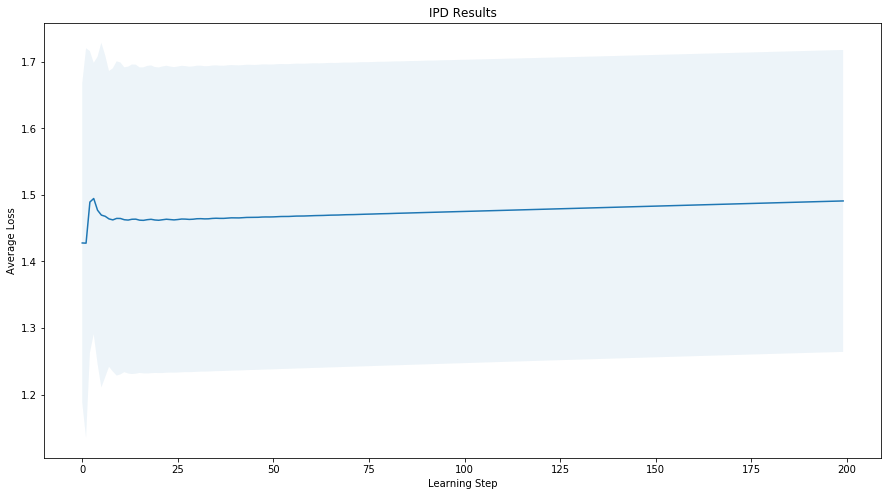

Jax time: 51.939581871032715
[1.42774579 1.4213483  1.46882238 1.49123909 1.47780661 1.47097422
 1.46757276 1.4611765  1.45777444 1.45996971 1.46350363 1.46281993
 1.46029104 1.45920969 1.46075314 1.4620043  1.46092724 1.45952987
 1.45968181 1.46116547 1.46132887 1.46013227 1.45944877 1.46026348
 1.46126721 1.46082723 1.4598294  1.45976785 1.46074022 1.46117457
 1.46049519 1.459864   1.46022786 1.46102546 1.46101699 1.46035588
 1.4601118  1.46066096 1.46115178 1.4608878  1.46039379 1.46045849
 1.4609927  1.4611885  1.46083893 1.46056564 1.46081426 1.4612174
 1.46119956 1.46088553 1.4608174  1.46112634 1.46136289 1.46123078
 1.46101755 1.46109719 1.46137659 1.46146674 1.46130588 1.46121032
 1.46136815 1.46157114 1.46156211 1.46142954 1.46143484 1.46160999
 1.46172752 1.46167052 1.46159483 1.46166721 1.46181846 1.4618661
 1.46180287 1.4617868  1.46189019 1.46199926 1.46200297 1.46195973
 1.46199135 1.46209662 1.46216321 1.46214845 1.46213579 1.46219679
 1.46228622 1.46231993 1.46230652 1

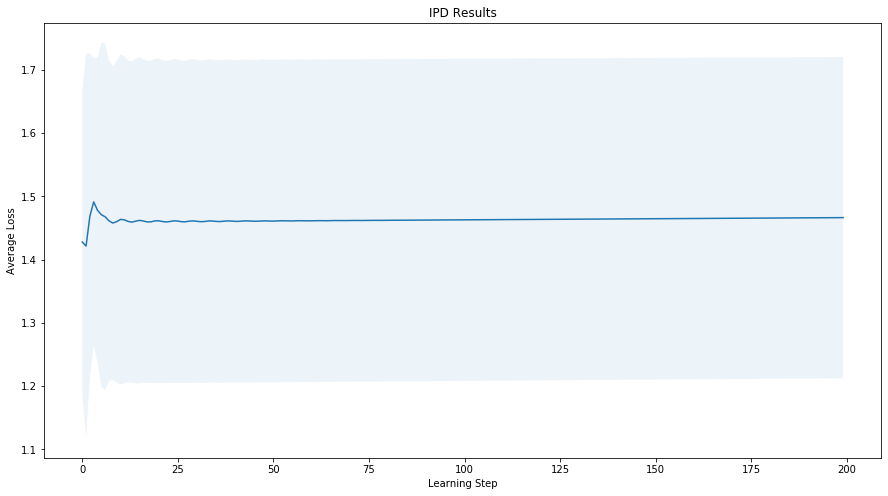

Jax time: 52.43470048904419
[1.42774579 1.40473826 1.40516469 1.42861185 1.44205709 1.44410611
 1.44244255 1.43641853 1.43337359 1.43562313 1.43698448 1.43765871
 1.43778076 1.43720462 1.43647821 1.4363542  1.43680177 1.43728877
 1.43745499 1.43730031 1.43706163 1.4370031  1.43719433 1.43746372
 1.43759669 1.43754498 1.43742955 1.43740197 1.43751706 1.43770006
 1.43782529 1.43783678 1.43778611 1.43776872 1.43783682 1.43796446
 1.43807804 1.43812743 1.43812424 1.4381227  1.4381659  1.4382535
 1.43834866 1.43841423 1.43844301 1.43846045 1.43849616 1.43856014
 1.43863779 1.43870476 1.43875045 1.43878364 1.43882101 1.43887407
 1.43893841 1.43900172 1.439055   1.43909816 1.43913993 1.439189
 1.43924578 1.439305   1.43935974 1.43940827 1.43945444 1.43950313
 1.43955609 1.43961167 1.43966602 1.43971762 1.43976654 1.43981553
 1.43986722 1.43992084 1.4399741  1.4400265  1.44007712 1.44012693
 1.44017815 1.44023073 1.4402835  1.44033577 1.44038711 1.44043804
 1.44048907 1.44054079 1.44059308 1.4

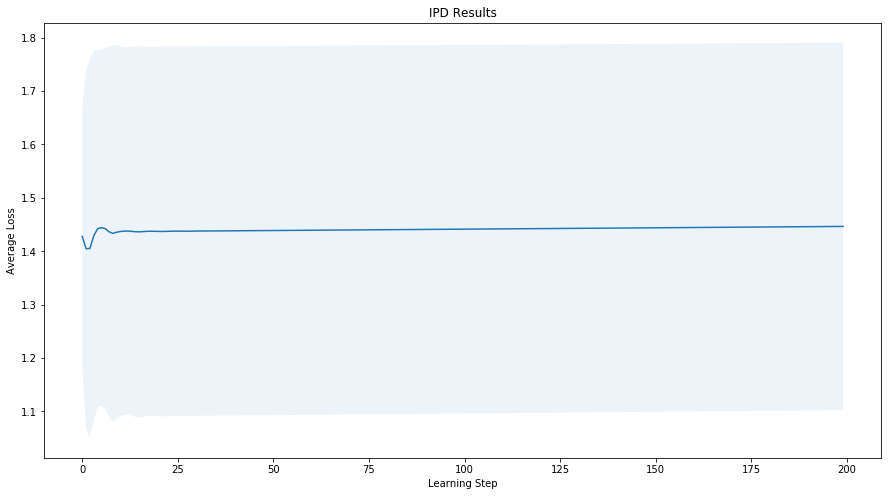

Jax time: 51.623944997787476
[1.42774579 1.42491111 1.47982556 1.506171   1.49689855 1.49456025
 1.49620894 1.49321471 1.49192399 1.49709699 1.50480209 1.50879962
 1.50946542 1.51099375 1.51591002 1.52134799 1.52402672 1.5253151
 1.5283058  1.53337746 1.53741318 1.53939341 1.54129209 1.54507627
 1.54958608 1.55259892 1.55440605 1.55692121 1.5608906  1.5646294
 1.56698714 1.56888165 1.57182501 1.57560418 1.57863667 1.58055102
 1.58257295 1.5857877  1.58932365 1.59169301 1.59304984 1.59520696
 1.5989741  1.60237868 1.6033839  1.60367144 1.60663819 1.61167314
 1.61390202 1.6125372  1.6128851  1.6167561  1.62045754 1.62174492
 1.62241605 1.62506982 1.62800345 1.62889561 1.62963911 1.63388812
 1.63793233 1.63602771 1.63394003 1.63340494 1.63592958 1.63952953
 1.64168246 1.6423864  1.64300564 1.64519222 1.64815564 1.65011397
 1.65057173 1.65121141 1.65359594 1.65635767 1.65780752 1.65784204
 1.65884807 1.66140388 1.66378463 1.66459921 1.66468248 1.66624659
 1.66886631 1.67068429 1.67089013 1

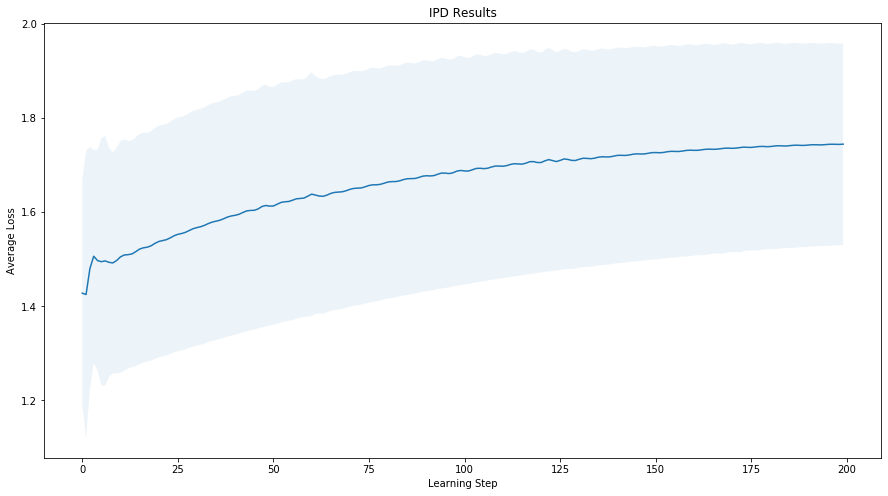

Jax time: 52.27649259567261
[1.42774579 1.40732663 1.41553982 1.44428151 1.45362845 1.45412135
 1.44933276 1.44271192 1.44235733 1.44394739 1.44455985 1.44485231
 1.44451436 1.44385999 1.4437438  1.4441891  1.4445737  1.44453722
 1.44421534 1.44397131 1.44407061 1.44441097 1.44464131 1.44457075
 1.44433169 1.44418974 1.44428411 1.44451848 1.44467242 1.44463554
 1.4444955  1.44441956 1.44448882 1.44463844 1.44473804 1.44472548
 1.44465383 1.44462129 1.44467314 1.44476983 1.44483555 1.44483744
 1.44480666 1.44480007 1.44484136 1.44490622 1.44495324 1.44496367
 1.44495664 1.444964   1.44499897 1.44504624 1.44508238 1.44509804
 1.4451047  1.4451197  1.44515027 1.44518741 1.445218   1.44523695
 1.44525131 1.44527045 1.44529872 1.44533008 1.44535753 1.44537845
 1.44539709 1.44541859 1.44544501 1.44547297 1.44549909 1.44552151
 1.44554227 1.44556502 1.44559043 1.44561721 1.44564185 1.44566483
 1.44568732 1.44571077 1.44573548 1.44576078 1.4457853  1.44580884
 1.44583203 1.44585571 1.44588014 

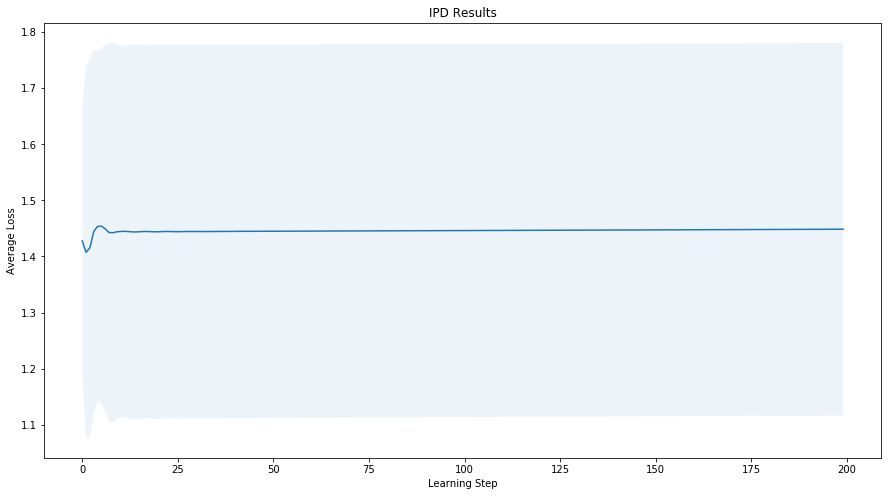

Jax time: 51.67663526535034
[1.42774579 1.42131612 1.46872492 1.49110556 1.47763616 1.47076146
 1.46731331 1.4608923  1.45747169 1.45963696 1.4631281  1.46240122
 1.45984784 1.45874381 1.46025229 1.46146113 1.46034819 1.45892876
 1.45905207 1.46049745 1.46062062 1.45939468 1.45868715 1.45946943
 1.46043369 1.45995698 1.45893291 1.45884456 1.45978191 1.46017794
 1.45946569 1.45880836 1.45914274 1.45990443 1.45985893 1.45916715
 1.45889618 1.45941401 1.45986854 1.45956976 1.45904621 1.45908274
 1.45958393 1.45974401 1.45936098 1.45905924 1.45927786 1.45964738
 1.45959469 1.45924875 1.45915117 1.45942935 1.45963173 1.45946586
 1.45922156 1.45927144 1.45951869 1.45957499 1.45938135 1.45925501
 1.45938211 1.45955243 1.45951026 1.45934572 1.45932035 1.45946395
 1.45954853 1.45945868 1.45935114 1.45939263 1.45951208 1.45952721
 1.45943112 1.45938371 1.45945603 1.45953303 1.45950387 1.45942829
 1.45942883 1.45950277 1.45953638 1.45948917 1.45944474 1.45947461
 1.45953208 1.45953338 1.45948725 

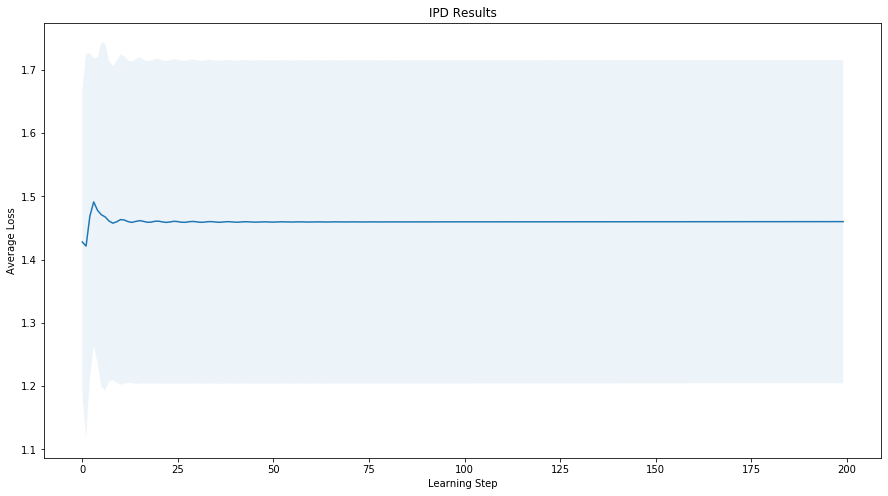

Jax time: 51.83705377578735
[1.42774579 1.40732651 1.41553079 1.44426068 1.45361129 1.45410706
 1.44932328 1.44270388 1.44234701 1.44393573 1.44454828 1.44484113
 1.44450363 1.44384852 1.4437318  1.44417671 1.44456165 1.44452579
 1.44420437 1.44396012 1.44405878 1.44439874 1.4446294  1.44455903
 1.44432064 1.44417818 1.4442722  1.44450665 1.4446608  1.44462364
 1.44448436 1.44440826 1.44447685 1.44462669 1.44472642 1.44471392
 1.44464248 1.44461005 1.44466191 1.44475789 1.44482391 1.44482566
 1.44479545 1.44478848 1.44482983 1.44489493 1.44494148 1.44495199
 1.44494516 1.44495274 1.44498731 1.44503478 1.44507083 1.44508656
 1.44509302 1.44510822 1.44513893 1.44517578 1.4452066  1.44522533
 1.44523955 1.44525901 1.44528701 1.44531826 1.44534606 1.4453667
 1.44538557 1.44540702 1.44543368 1.4454618  1.44548769 1.44550976
 1.44553058 1.44555352 1.44557894 1.44560506 1.44563038 1.44565352
 1.44567575 1.44569914 1.4457241  1.44574955 1.44577397 1.44579746
 1.44582044 1.44584438 1.44586891 1

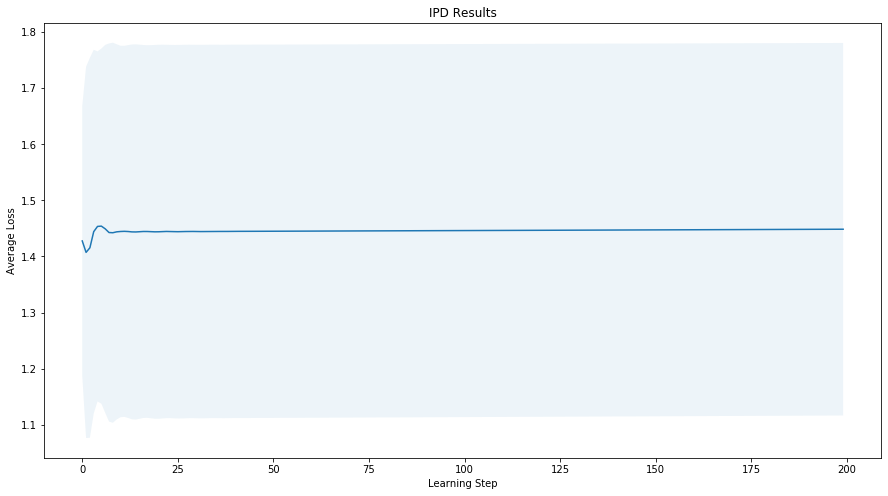

Jax time: 51.91699504852295
[1.42774579 1.43821338 1.55405758 1.64655257 1.7027818  1.72474232
 1.73467982 1.73935355 1.74184561 1.74420356 1.74569674 1.74732797
 1.74373536 1.73475565 1.72574327 1.71904404 1.71453571 1.7046261
 1.68974312 1.67935541 1.67320847 1.67326054 1.67888978 1.68245476
 1.67956144 1.67406612 1.66957011 1.66554244 1.67228781 1.67967048
 1.68146356 1.67849971 1.67347418 1.66655855 1.6612008  1.65891309
 1.65599477 1.65458244 1.65183877 1.64643119 1.63823674 1.63246808
 1.6293662  1.62870696 1.63043454 1.63209608 1.62919334 1.62309417
 1.6165197  1.61136737 1.60938665 1.61007892 1.61148806 1.61083742
 1.60640761 1.5986922  1.59360613 1.59305724 1.59497643 1.59863017
 1.60588565 1.61177185 1.6131774  1.61221999 1.61251036 1.61342179
 1.61492941 1.61698481 1.61923985 1.62568273 1.62779423 1.62840437
 1.6248012  1.6162924  1.60877298 1.60923733 1.61223927 1.6108524
 1.60724354 1.60577831 1.60708448 1.60919167 1.6096604  1.61017417
 1.60915242 1.60833145 1.60624411 1.

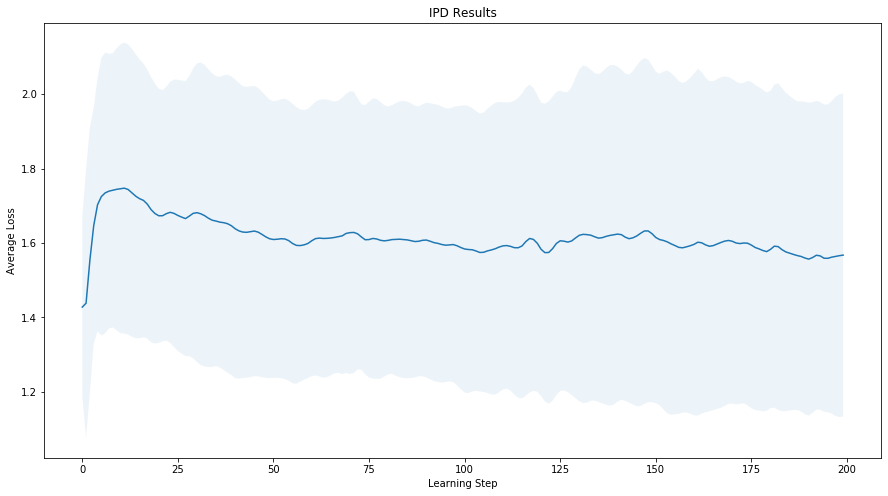

Jax time: 51.83161926269531
[1.42774579 1.64707976 1.87118202 1.87574449 1.93486594 1.97661952
 2.00696559 2.01725609 2.01176658 1.99165449 1.96994576 1.97032277
 1.9704184  1.93968884 1.94532609 1.94922705 1.9461942  1.94651017
 1.95706482 1.96174667 1.95624166 1.95080802 1.94793629 1.94561056
 1.93721557 1.92720442 1.93408411 1.93171452 1.92990511 1.92188007
 1.91952096 1.9149327  1.91137038 1.91125636 1.91104754 1.91050784
 1.90899632 1.90645803 1.90742948 1.91529771 1.93368033 1.92355487
 1.92210621 1.93698748 1.95070221 1.94662403 1.9468246  1.94707231
 1.9472683  1.94735019 1.94726965 1.94697479 1.94634363 1.94439266
 1.9314996  1.9270141  1.93515421 1.93524557 1.93499561 1.93444251
 1.93300001 1.93537418 1.93540072 1.93544725 1.93558042 1.9359758
 1.93924108 1.94471347 1.9441776  1.94118252 1.93583245 1.93565591
 1.93595185 1.93726007 1.94413816 1.95366971 1.95390418 1.95383899
 1.95374753 1.9536354  1.95348502 1.95325003 1.95282537 1.95199976
 1.9508892  1.95032208 1.94850032 1

Jax time: 51.4421865940094
[1.42774579 1.42728504 1.48859106 1.49379729 1.4760728  1.46852273
 1.46646194 1.46237416 1.46081073 1.46286807 1.46252781 1.46051019
 1.45990757 1.46096125 1.46087302 1.45917731 1.45881265 1.45965039
 1.46002425 1.45879881 1.45828781 1.45893471 1.45948159 1.45877973
 1.45817916 1.45858873 1.45915204 1.45883419 1.45826648 1.45843357
 1.45894069 1.45887082 1.45840631 1.45838666 1.45879429 1.45887767
 1.45853653 1.45840225 1.45869111 1.45886037 1.45863932 1.4584521
 1.45862325 1.45882732 1.45871348 1.45851701 1.45858723 1.45878618
 1.45876098 1.4585853  1.45857782 1.4587452  1.45878589 1.45864935
 1.4585905  1.45871083 1.4587921  1.45870376 1.45861859 1.45868833
 1.45878581 1.45874562 1.45865517 1.45867936 1.45877335 1.45877447
 1.45869507 1.45868312 1.45875998 1.45879081 1.45873271 1.45869832
 1.45875074 1.4587982  1.45876491 1.45872067 1.45874749 1.45879977
 1.45879034 1.45874662 1.45875185 1.45879897 1.45880879 1.45877336
 1.4587626  1.4587988  1.45882148 1.

Jax time: 52.39519166946411
[1.42774579 1.41840655 1.45832168 1.48661502 1.47573073 1.47010696
 1.46695029 1.46130057 1.45672121 1.45697081 1.46056161 1.46152967
 1.45957332 1.4577655  1.45778513 1.4593537  1.45988491 1.45898934
 1.45806052 1.4582434  1.45916893 1.45933899 1.45870364 1.45822191
 1.45855766 1.45916591 1.45911964 1.45860721 1.45838937 1.45878017
 1.45918072 1.45902644 1.45862338 1.45856817 1.45894272 1.45919305
 1.45899849 1.45870091 1.4587431  1.45906632 1.45920761 1.45901278
 1.45880954 1.4589046  1.45916514 1.45923119 1.45905666 1.45893166
 1.45905002 1.45924943 1.45926613 1.45912203 1.45905735 1.45917984
 1.45932545 1.45931319 1.45920254 1.45918107 1.45929607 1.45939809
 1.45937179 1.45929265 1.45930075 1.45940207 1.45947042 1.45943967
 1.45938814 1.45941506 1.45950049 1.4595444  1.45951567 1.4594871
 1.45952391 1.45959352 1.45962105 1.45959785 1.45958695 1.4596275
 1.45968332 1.45970001 1.45968445 1.45968669 1.45972764 1.45977161
 1.45978238 1.45977401 1.45978561 1.

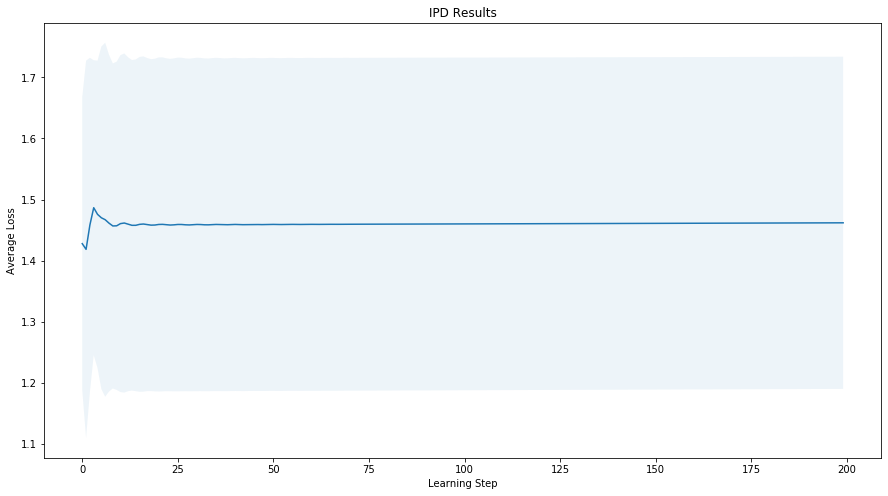

Jax time: 51.88277626037598
[1.42774579 1.55451899 1.80316106 1.82996811 1.8765217  1.88857203
 1.9043659  1.91550778 1.90300329 1.91555034 1.91692659 1.90077441
 1.88485256 1.88926513 1.88684298 1.87869176 1.86245966 1.85564151
 1.85805517 1.86042128 1.86766019 1.85950095 1.86445792 1.84741237
 1.83490539 1.8336267  1.84939377 1.83394989 1.82715017 1.83207325
 1.84251643 1.85119231 1.84167382 1.84137194 1.84403785 1.84675033
 1.84157071 1.83477618 1.82929977 1.82530653 1.82249903 1.81436472
 1.80458309 1.82235132 1.82755732 1.8142455  1.79893512 1.78245243
 1.77938161 1.77624644 1.7737763  1.77207819 1.77006874 1.76735565
 1.76528765 1.76411155 1.76347025 1.7630035  1.76259795 1.76204146
 1.76102592 1.75919231 1.75759436 1.75759077 1.75942164 1.76546048
 1.7694276  1.76957077 1.76914815 1.76863044 1.76807359 1.76741663
 1.76641924 1.76402382 1.76313577 1.76765048 1.77423753 1.7743821
 1.77217759 1.76788221 1.76440388 1.76423061 1.7657547  1.77064151
 1.7781437  1.78059862 1.78202222 1

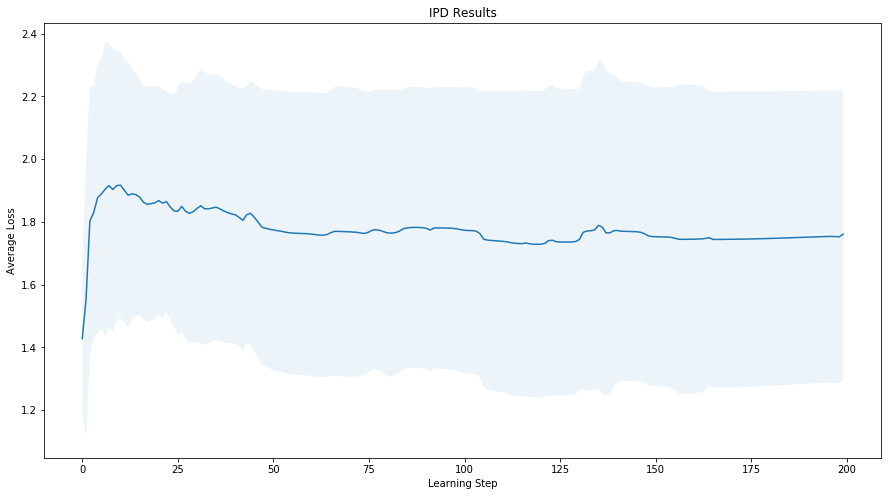

Jax time: 51.65701127052307
[1.42774579 1.61894867 1.86184493 1.86877381 1.90304477 1.91265771
 1.97201127 1.99467764 1.99443527 1.99059471 1.99865529 1.98477296
 1.95673267 1.95330596 1.9552115  1.93941863 1.93965014 1.95203617
 1.96719982 1.97079347 1.96123106 1.95632252 1.97303219 1.96281481
 1.95776835 1.95571316 1.95000151 1.94849773 1.94746525 1.94402379
 1.94879331 1.95670566 1.95363723 1.9521115  1.9699721  1.97267313
 1.97500378 1.98137811 1.99092921 1.98665483 1.98256687 1.982203
 1.98397809 1.9840274  1.98279098 1.97748782 1.97633703 1.97654735
 1.97685904 1.97726433 1.97795708 1.97982294 1.98801163 2.01065981
 2.00667432 1.992794   1.97498363 1.96822287 1.96647509 1.96353807
 1.95577671 1.9428496  1.94070045 1.94067559 1.94080174 1.9409485
 1.94108324 1.94117731 1.94118856 1.94102265 1.94050704 1.93962922
 1.93893082 1.93795394 1.93319876 1.91960471 1.91852885 1.91617479
 1.909789   1.90856987 1.90646659 1.90003752 1.89449427 1.88181847
 1.87900337 1.87783568 1.8768024  1.8

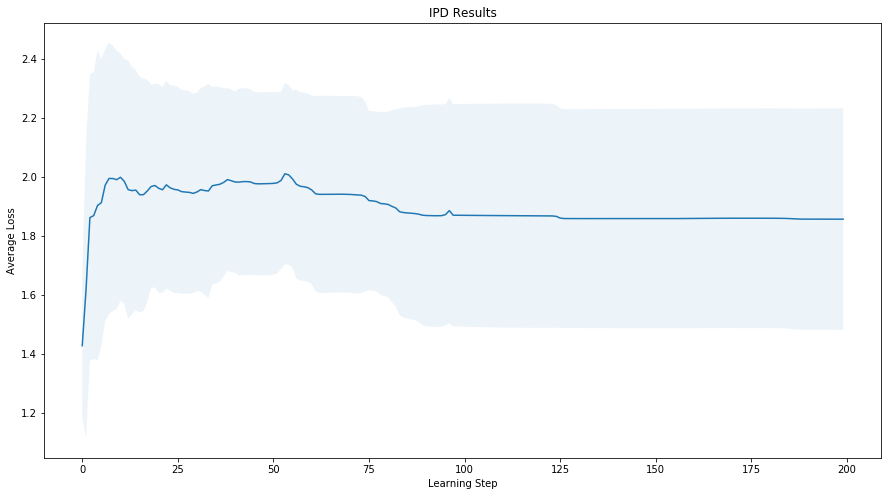

Jax time: 52.011642932891846
[1.42774579 1.56352501 1.81178752 1.8511733  1.88924148 1.90768508
 1.89171055 1.88014641 1.87946405 1.89191065 1.89266557 1.88661083
 1.87592309 1.87767304 1.90036048 1.90584913 1.89410026 1.89668126
 1.88993258 1.8751557  1.86939241 1.86490928 1.86532646 1.85227552
 1.84834751 1.83207911 1.82878288 1.82623758 1.82322594 1.82386463
 1.81853429 1.81450356 1.82614182 1.82189335 1.81533692 1.80600785
 1.78996954 1.78269421 1.78518889 1.79068828 1.79318302 1.78822532
 1.78090637 1.78247046 1.78223219 1.78208114 1.78837816 1.79069848
 1.78798643 1.78271417 1.77719164 1.77409681 1.7698904  1.76158788
 1.76235476 1.76331219 1.75775673 1.75543939 1.75690174 1.75339944
 1.75138751 1.75263337 1.74886258 1.73973064 1.74256987 1.76277907
 1.76989571 1.7690325  1.7576149  1.75986084 1.78515969 1.78898693
 1.78583204 1.78593979 1.78127602 1.77300608 1.76819202 1.76269545
 1.75887662 1.75447649 1.75186341 1.75209657 1.75210929 1.75034279
 1.74984846 1.75171606 1.7439747 

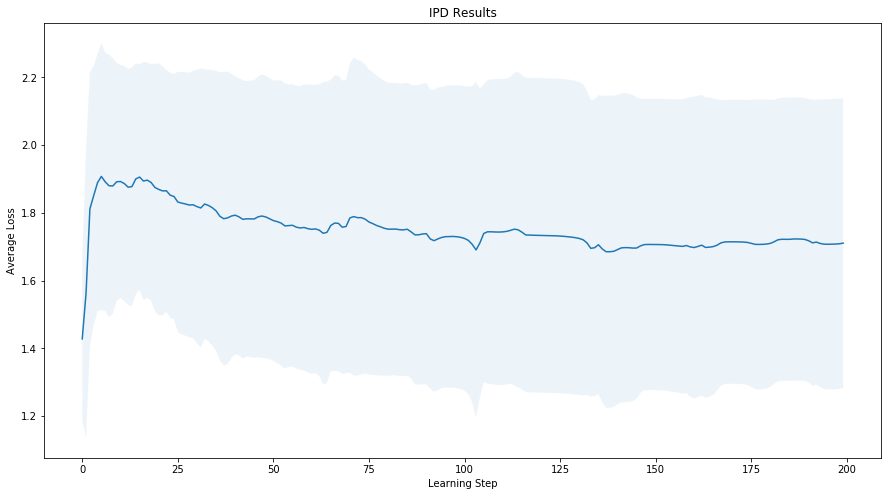

Jax time: 52.14329791069031
[1.42774579 1.42015982 1.46391129 1.49457607 1.48567801 1.48240868
 1.48217353 1.47783252 1.47385063 1.47564491 1.48170659 1.48548009
 1.48520917 1.48440535 1.48599271 1.4897792  1.49259252 1.49334145
 1.49375033 1.49562954 1.49859982 1.5007847  1.50177759 1.50277708
 1.50480711 1.50731635 1.50914767 1.51027127 1.51158344 1.51360931
 1.51579491 1.51743586 1.51867091 1.520146   1.5220905  1.5240352
 1.52557407 1.5268985  1.52844902 1.53028945 1.53205927 1.53354077
 1.53492609 1.53650072 1.5382415  1.53988653 1.54133319 1.54275134
 1.54431966 1.54597579 1.54753187 1.54894972 1.55037461 1.55192013
 1.5535094  1.55499818 1.55638013 1.55778759 1.55930706 1.56085252
 1.56228275 1.56359965 1.56496699 1.56648931 1.56803102 1.5693709
 1.57054426 1.57187973 1.57353087 1.57511382 1.57617231 1.5770244
 1.5785243  1.58069048 1.58213761 1.58219997 1.58254495 1.58500565
 1.58815992 1.58838074 1.5866864  1.58699906 1.58987081 1.59263605
 1.59324013 1.59288202 1.59378446 1.5

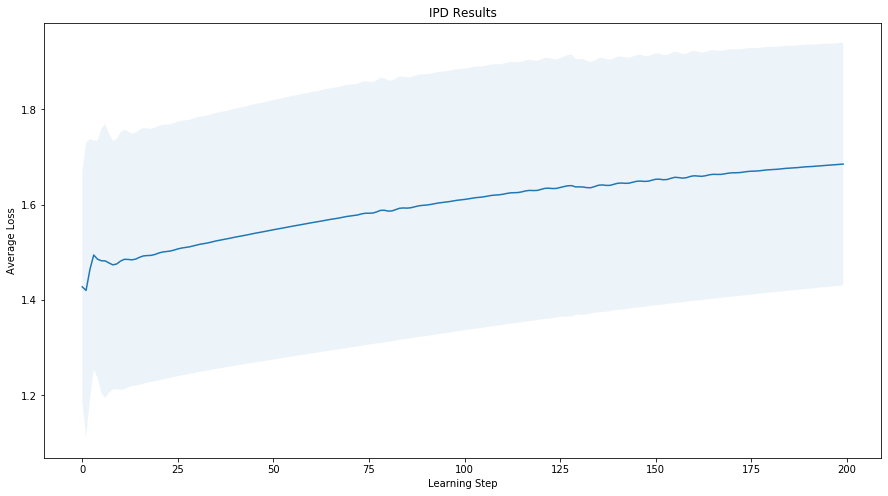

Jax time: 51.73006796836853
[1.42774579 1.40998209 1.4261703  1.4578028  1.46277904 1.46029985
 1.45388009 1.44902305 1.44954949 1.44978895 1.4500354  1.45028516
 1.4497324  1.4491739  1.44929817 1.44959745 1.44960202 1.44941828
 1.44928912 1.44940707 1.44965035 1.4496925  1.44948638 1.44928102
 1.44929464 1.4495058  1.44967869 1.44963293 1.44944825 1.44933458
 1.44940201 1.44956377 1.44964423 1.44957677 1.4494574  1.4494189
 1.44949201 1.44958996 1.44961301 1.44955443 1.44949179 1.44949337
 1.44955156 1.44960211 1.44959936 1.44955998 1.44953437 1.44955073
 1.44958976 1.44961214 1.44960271 1.44958104 1.44957581 1.44959406
 1.4496174  1.44962575 1.44961808 1.44960889 1.44961275 1.4496279
 1.44964138 1.44964385 1.44964011 1.44963878 1.44964589 1.44965675
 1.44966436 1.44966585 1.44966535 1.44966826 1.44967549 1.4496836
 1.44968856 1.44969018 1.44969235 1.449697   1.4497037  1.4497094
 1.4497134  1.44971604 1.44971979 1.44972472 1.44973061 1.44973526
 1.44973902 1.44974257 1.44974683 1.44

Jax time: 52.20578670501709
[1.42774579 1.40734317 1.41560552 1.44440942 1.45378214 1.45430238
 1.44954345 1.44295418 1.44261557 1.44422356 1.44486319 1.44518832
 1.44488548 1.44425857 1.44415847 1.44461792 1.44502167 1.44501241
 1.44472264 1.44450865 1.44463052 1.44498904 1.44523961 1.44519335
 1.44498239 1.4448673  1.44498538 1.4452408  1.44541706 1.44540483
 1.44529148 1.44524047 1.44533254 1.44550461 1.44562746 1.44564047
 1.44559479 1.44558685 1.44566108 1.44577992 1.44586979 1.44589715
 1.44589203 1.44590944 1.44597324 1.44606114 1.44613206 1.44616791
 1.4461862  1.44621751 1.44627538 1.44634588 1.44640622 1.44644669
 1.44647844 1.44651742 1.44657119 1.44663202 1.44668651 1.44673022
 1.44676934 1.44681232 1.44686426 1.44691931 1.44697069 1.44701631
 1.44705946 1.44710505 1.44715507 1.44720715 1.44725725 1.44730376
 1.44734922 1.44739604 1.4474451  1.44749578 1.44754491 1.44759223
 1.44763874 1.4476861  1.447735   1.44778443 1.44783312 1.44788068
 1.44792802 1.44797575 1.4480244  

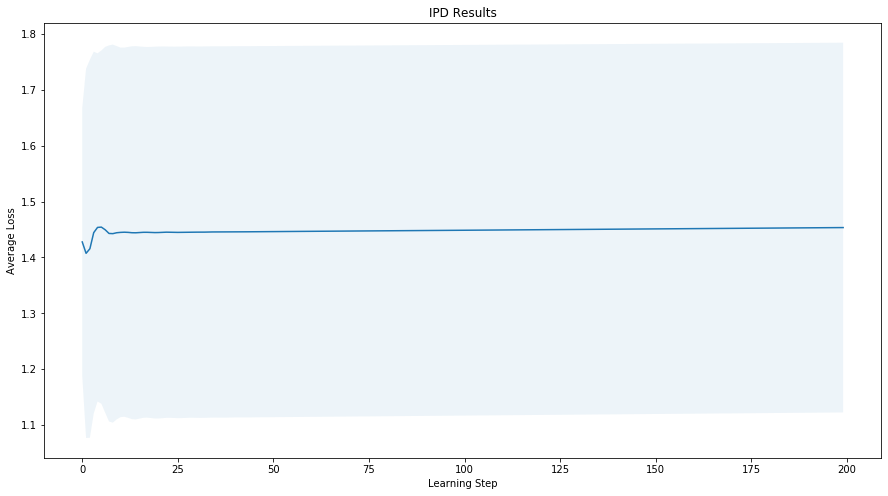

Jax time: 51.58927822113037
[1.42774579 1.41874277 1.45939303 1.48814233 1.47763244 1.47248752
 1.46990505 1.46444798 1.45995147 1.46050026 1.46459624 1.46610417
 1.46443782 1.46281236 1.46315694 1.46517716 1.46614831 1.46555626
 1.46488523 1.46541673 1.46675545 1.46732059 1.46699869 1.46681208
 1.46749879 1.46849712 1.46882866 1.46864033 1.46873361 1.46946806
 1.47024487 1.47046332 1.47039366 1.47065467 1.47136497 1.47198406
 1.47216156 1.4722041  1.47256302 1.47321622 1.47372238 1.47389987
 1.4740391  1.47445004 1.47503735 1.47546641 1.475664   1.47588077
 1.47631311 1.47683945 1.47721943 1.47744545 1.47771921 1.47815483
 1.47862965 1.47898089 1.47923604 1.47954966 1.47997792 1.48041237
 1.48074885 1.48103047 1.48136964 1.48178601 1.4821901  1.48252098
 1.48282475 1.48317856 1.48358142 1.48396464 1.4842947  1.48461548
 1.48497681 1.4853671  1.4857358  1.48606815 1.48640089 1.48676508
 1.48714404 1.48750338 1.48783904 1.4881796  1.48854327 1.4889137
 1.48926659 1.48960574 1.48995142 1

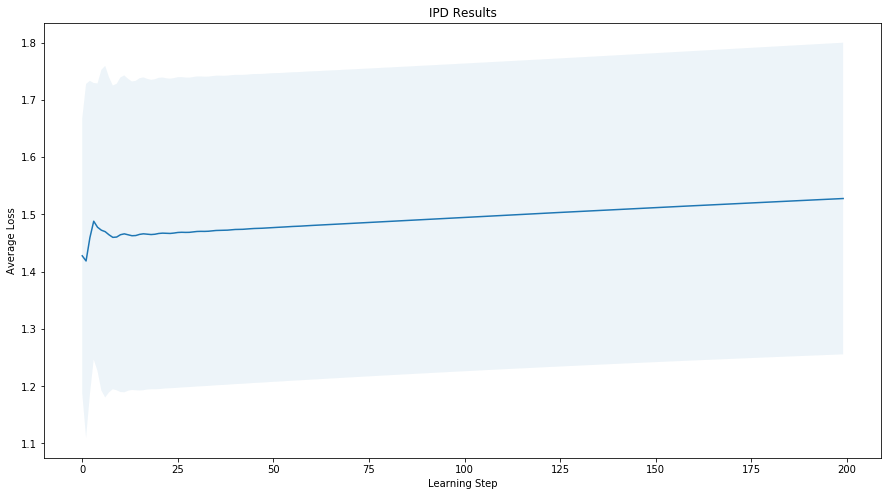

Jax time: 51.57389855384827
[1.42774579 1.42017043 1.46508848 1.4957659  1.4865044  1.48298075
 1.48285494 1.47849571 1.47442741 1.47617738 1.48236195 1.48635344
 1.48606491 1.48506136 1.48655084 1.49042827 1.49332245 1.49401437
 1.4943095  1.49618405 1.49924481 1.50144793 1.50235654 1.50327619
 1.50533582 1.50792201 1.50974763 1.51078846 1.51204384 1.51410748
 1.5163504  1.51797407 1.51913736 1.52057484 1.5225554  1.52454044
 1.52605515 1.52731986 1.52884683 1.53071879 1.53251487 1.53397071
 1.53530655 1.5368661  1.5386345  1.5402969  1.54171708 1.54309219
 1.5446508  1.546334   1.54790338 1.54928999 1.55067172 1.55221455
 1.55384    1.55534017 1.55667203 1.55802598 1.55956754 1.56118113
 1.56260298 1.56380693 1.56511302 1.56675115 1.5684256  1.56963851
 1.57052678 1.57188348 1.5739613  1.57568125 1.57609651 1.57634998
 1.57834735 1.58151099 1.58251231 1.58108686 1.58092826 1.58361962
 1.58674483 1.58762664 1.58694192 1.58752601 1.58963751 1.59179755
 1.59291153 1.59340296 1.5943992  

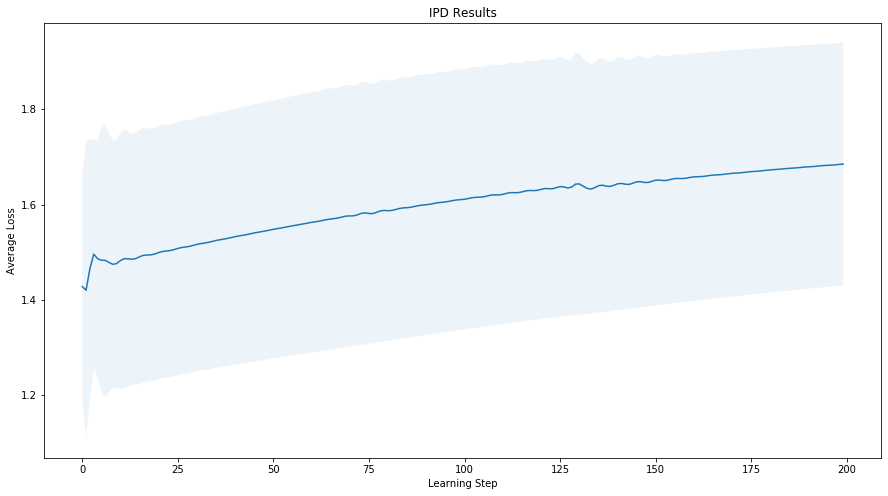

Jax time: 52.20122241973877
[1.42774579 1.41288733 1.43759618 1.47059904 1.47018354 1.46596396
 1.46090807 1.45778143 1.45687288 1.45612343 1.45704339 1.4580415
 1.45764743 1.45703359 1.45702671 1.45728492 1.45774833 1.45811592
 1.45828259 1.45839009 1.45844702 1.45855769 1.45881811 1.45915195
 1.45943857 1.4595885  1.45965614 1.45979657 1.46006128 1.46037071
 1.46060793 1.46074274 1.46086419 1.46106013 1.46132433 1.4615807
 1.46177322 1.46192372 1.4620961  1.46231761 1.46255934 1.46277545
 1.46295625 1.46313215 1.46333283 1.46355472 1.46377299 1.46397143
 1.46415862 1.46435275 1.46456134 1.46477464 1.46497988 1.46517555
 1.4653708  1.46557309 1.46578079 1.46598671 1.46618701 1.46638499
 1.4665853  1.46678938 1.46699378 1.46719615 1.46739601 1.46759609
 1.46779839 1.46800143 1.46820382 1.46840486 1.46860552 1.46880673
 1.46900889 1.46921074 1.46941245 1.46961343 1.46981413 1.47001574
 1.47021703 1.47041859 1.47061983 1.4708205  1.4710215  1.47122265
 1.4714238  1.47162474 1.4718254  1.

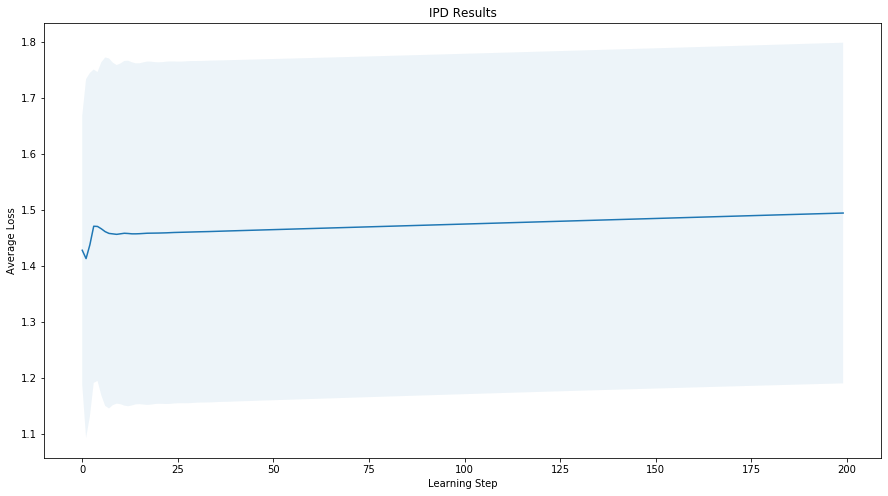

Jax time: 51.85878825187683
[1.42774579 1.41553789 1.44770079 1.4793459  1.47288096 1.46792982
 1.46408071 1.46019203 1.45669433 1.45547052 1.45746568 1.45891224
 1.45822319 1.45703552 1.45635397 1.45670155 1.45750091 1.45767342
 1.45727479 1.45680993 1.45679744 1.45719353 1.45743103 1.45731128
 1.45705092 1.45699578 1.45720093 1.45736763 1.45733022 1.45719387
 1.45716543 1.45728745 1.45739438 1.45737871 1.45730511 1.45730022
 1.4573856  1.45745839 1.45745083 1.45740912 1.45741618 1.45748176
 1.45753648 1.45753548 1.45751187 1.45752374 1.45757618 1.45762072
 1.4576253  1.45761399 1.45762725 1.45767011 1.45770787 1.45771759
 1.45771488 1.45772872 1.4577641  1.45779732 1.45781061 1.4578141
 1.45782878 1.45785896 1.4578882  1.45790409 1.45791237 1.45792771
 1.45795395 1.45798073 1.45799835 1.45800962 1.45802565 1.45804936
 1.45807383 1.45809242 1.45810638 1.45812288 1.45814511 1.458168
 1.45818694 1.45820277 1.45821977 1.45824078 1.45826236 1.45828141
 1.45829863 1.45831622 1.45833637 1.4

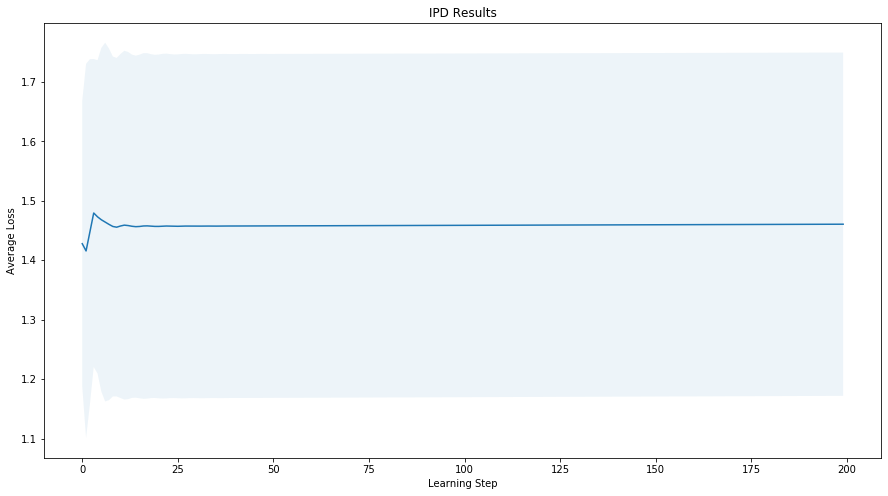

Jax time: 51.87428164482117
[1.42774579 1.41274972 1.43703187 1.46968912 1.46916023 1.46471649
 1.45932039 1.4560567  1.4551536  1.45432943 1.45506826 1.45577836
 1.45517372 1.45448578 1.45439708 1.45448997 1.45472804 1.45489014
 1.45491725 1.454913   1.45481917 1.45473365 1.45480075 1.45497898
 1.45513498 1.45513663 1.45502289 1.45497608 1.45507811 1.45524759
 1.45533831 1.45530127 1.45523964 1.45526685 1.45538341 1.45549425
 1.45552324 1.45549578 1.45549568 1.45556235 1.45565607 1.45571447
 1.45572423 1.45572766 1.45576656 1.45583655 1.45590002 1.45593329
 1.4559497  1.45597923 1.4560316  1.45608959 1.45613327 1.45616211
 1.45619178 1.45623416 1.45628527 1.45633208 1.45636848 1.4564014
 1.45643996 1.45648514 1.45653122 1.45657171 1.45660793 1.45664543
 1.4566879  1.45673205 1.45677379 1.4568125  1.45685109 1.4568916
 1.45693401 1.45697642 1.45701626 1.45705563 1.45709569 1.4571369
 1.45717905 1.45721947 1.45725933 1.45729966 1.45734036 1.45738188
 1.45742264 1.45746303 1.45750317 1.4

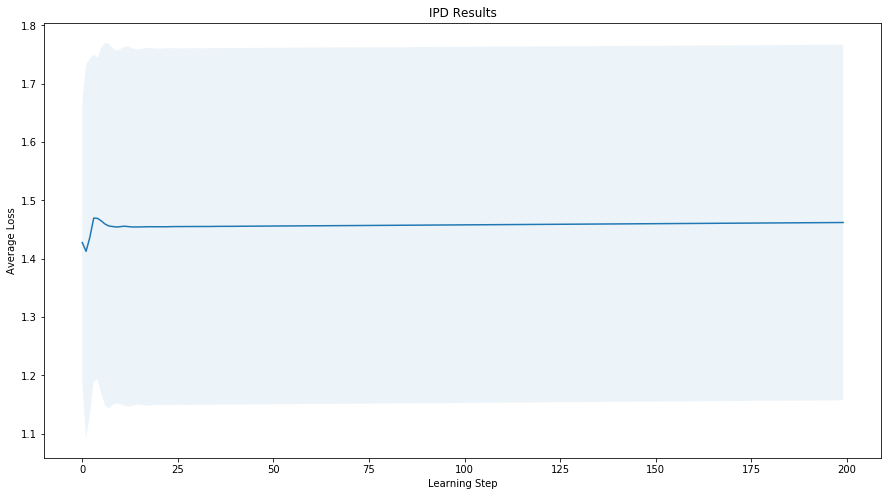

Jax time: 52.46943926811218
[1.42774579 1.40895719 1.42117013 1.45486624 1.46719264 1.47082085
 1.4694332  1.46619416 1.46700514 1.47009904 1.47314934 1.47643701
 1.47929616 1.48107568 1.48237894 1.48422418 1.48672454 1.48960062
 1.49249125 1.49499633 1.49702134 1.49891118 1.5010587  1.50357313
 1.50626639 1.50878966 1.51093043 1.51284009 1.51487711 1.51725027
 1.51983802 1.52228885 1.52434759 1.52614552 1.5280728  1.53037302
 1.53290078 1.53522295 1.53706029 1.53864287 1.54047724 1.54280728
 1.54533026 1.54741142 1.54881993 1.5501032  1.55196914 1.55454831
 1.55709489 1.55862585 1.55932579 1.56038416 1.56264409 1.5657842
 1.56808376 1.56850107 1.56849007 1.56971777 1.57277563 1.57628051
 1.57777527 1.57730973 1.57727248 1.57906231 1.58242106 1.58535298
 1.58637237 1.58633085 1.58697589 1.5891095  1.59205483 1.59426689
 1.59518905 1.59570606 1.59682559 1.5989142  1.60138394 1.60322578
 1.60420325 1.60497223 1.60621778 1.60814816 1.61029722 1.61194121
 1.61293018 1.61377117 1.6150264  1

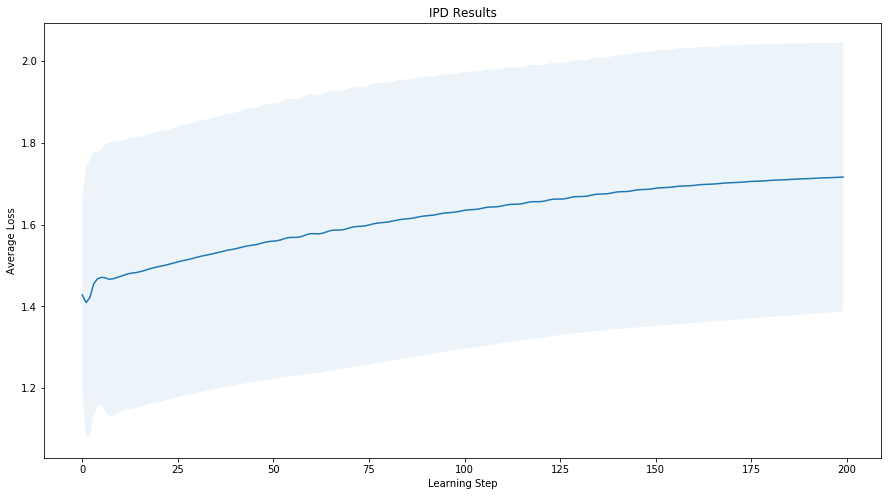

Jax time: 52.06243109703064
[1.42774579 1.42431751 1.47900427 1.49345774 1.47810515 1.47055803
 1.46744326 1.46176474 1.45956572 1.46220296 1.46402442 1.46207447
 1.46023183 1.46056163 1.46239123 1.46163452 1.45990798 1.45965859
 1.46119703 1.46160251 1.46016723 1.45935539 1.46021573 1.46128916
 1.4606466  1.45957601 1.45972018 1.46076591 1.46091951 1.46006298
 1.45968904 1.46033238 1.46090374 1.46051949 1.45995995 1.46014512
 1.46074161 1.4607922  1.46033795 1.46020049 1.46060009 1.46088805
 1.46067401 1.46041248 1.46056749 1.460893   1.46090461 1.46067972
 1.4606534  1.46089346 1.46103902 1.46092728 1.46082089 1.46093938
 1.46111964 1.46112291 1.46102174 1.4610421  1.46118961 1.46126801
 1.46121744 1.46118808 1.46127752 1.46138267 1.46138955 1.46135437
 1.46139167 1.46148733 1.46153644 1.46152143 1.46152873 1.46159771
 1.46166565 1.46167914 1.46167814 1.46172045 1.46178743 1.46182408
 1.46183047 1.46185411 1.46191012 1.46195926 1.46197944 1.46199581
 1.46203786 1.46208953 1.46212206 

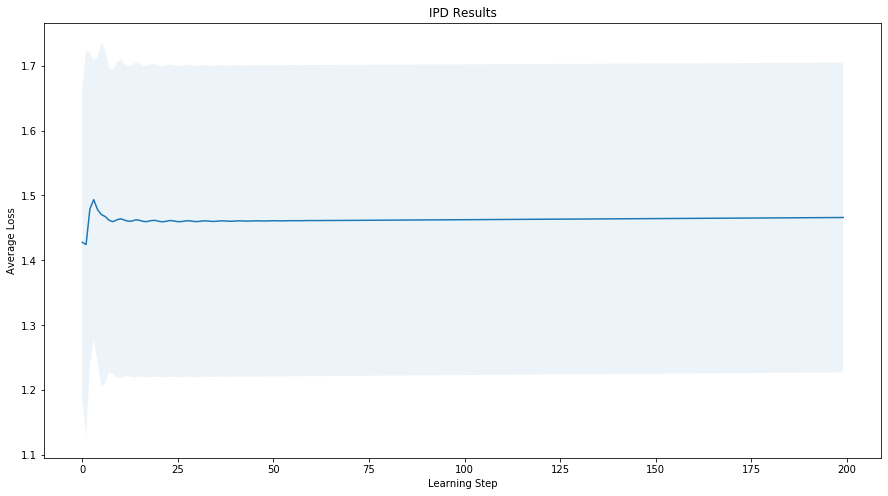

Jax time: 51.405768394470215
[1.42774579 1.57132887 1.81765438 1.85937802 1.88187423 1.88111451
 1.85860266 1.88835801 1.87221014 1.89083258 1.90228652 1.90058263
 1.89103384 1.8730846  1.84652895 1.82284334 1.8137463  1.81950256
 1.82525306 1.83026692 1.82889504 1.81626209 1.79375577 1.78376788
 1.77937758 1.77209038 1.76845777 1.76584496 1.75908349 1.76680567
 1.75872805 1.7405541  1.73361874 1.72561171 1.72615284 1.72199299
 1.71096081 1.70144545 1.69494151 1.69293289 1.69132189 1.68987636
 1.68916217 1.68789665 1.68992795 1.69448394 1.69178459 1.69201357
 1.69975531 1.70540315 1.69610454 1.69175716 1.69075633 1.69423919
 1.69417708 1.69440249 1.69740775 1.70460117 1.71994643 1.7341226
 1.7309747  1.711558   1.7032278  1.70674279 1.70782516 1.70127874
 1.70248674 1.69794089 1.69541908 1.69417571 1.7015963  1.70693367
 1.69680512 1.69620052 1.69132975 1.68571335 1.68287921 1.68747392
 1.68445688 1.68004477 1.67805768 1.68239835 1.69087206 1.69249939
 1.69635239 1.69339113 1.70078025 

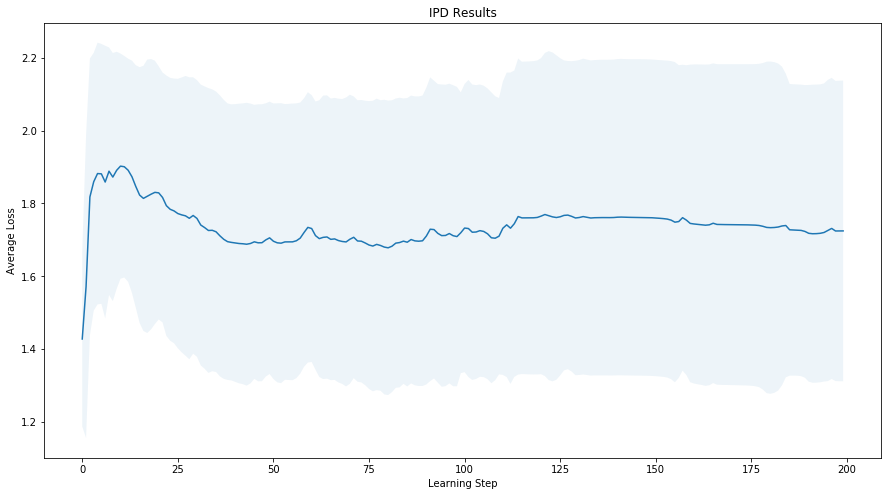

Jax time: 52.11940383911133
[1.42774579 1.40486756 1.40560724 1.42952451 1.44324788 1.44559071
 1.44420058 1.4384544  1.43559788 1.43799904 1.439576   1.4405369
 1.44097594 1.44070084 1.44019663 1.44020207 1.44075961 1.44140805
 1.44180735 1.44193107 1.44196267 1.44211993 1.44247257 1.44289548
 1.44321627 1.44339436 1.44352595 1.44372821 1.44404069 1.44440261
 1.44471515 1.44493721 1.44511328 1.44531934 1.44559484 1.44591602
 1.44622469 1.44648095 1.44669557 1.44691136 1.44716308 1.44745109
 1.44774599 1.44801771 1.44826025 1.44849238 1.44873788 1.44900518
 1.44928415 1.4495575  1.44981469 1.4500608  1.4503089  1.45056754
 1.45083536 1.45110451 1.45136691 1.45162192 1.45187494 1.45213132
 1.45239327 1.45265826 1.45292072 1.45318007 1.4534367  1.45369393
 1.45395383 1.4542159  1.45447784 1.45473846 1.45499685 1.45525527
 1.45551475 1.45577537 1.4560363  1.45629717 1.45655697 1.45681612
 1.45707566 1.45733553 1.45759617 1.45785672 1.45811665 1.45837651
 1.45863605 1.45889618 1.45915627 1

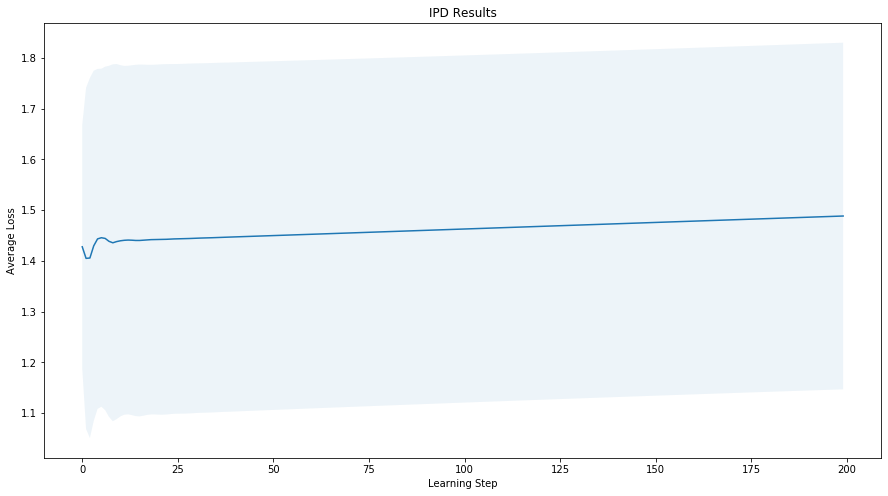

Jax time: 51.67294883728027
[1.42774579 1.4273182  1.48868365 1.49391903 1.47622905 1.46871842
 1.46669997 1.46263747 1.46109347 1.46318405 1.46288511 1.46089305
 1.46030848 1.46139426 1.46135096 1.45968507 1.45933576 1.46020302
 1.46061986 1.45942727 1.4589332  1.45960681 1.4601931  1.45952605
 1.45894558 1.45937957 1.45997918 1.45969607 1.45915264 1.45934288
 1.45988375 1.45984864 1.45941061 1.4594145  1.45985407 1.4599715
 1.4596581  1.45954843 1.45986761 1.46007055 1.45987854 1.45971616
 1.45991674 1.4601541  1.46006984 1.45989878 1.4599973  1.46022966
 1.46023485 1.46008502 1.46010515 1.46030493 1.46037691 1.46026678
 1.46023488 1.460387   1.46050031 1.4604392  1.46037978 1.46048037
 1.46061104 1.46059895 1.4605342  1.46058762 1.46071483 1.46074554
 1.46069168 1.46070828 1.46081765 1.46087958 1.46084735 1.46084008
 1.46092449 1.46100376 1.46099762 1.46097978 1.46103724 1.46112202
 1.46114114 1.46112352 1.46115784 1.46123752 1.46127724 1.46126797
 1.46128543 1.46135352 1.46140703 1

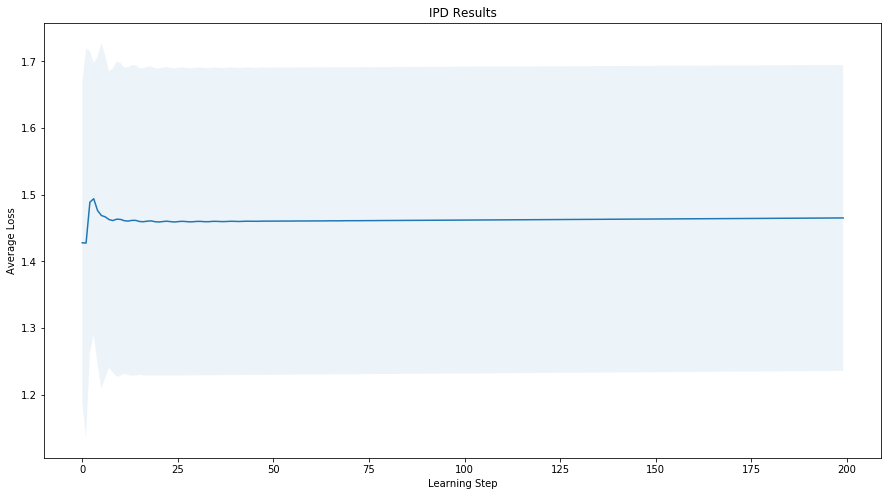

Jax time: 51.619030714035034
[1.42774579 1.44740117 1.55322296 1.63852243 1.6797533  1.70135391
 1.71608431 1.72924208 1.73283076 1.74106753 1.75785995 1.76742777
 1.77005335 1.77176142 1.77437825 1.77621457 1.77886532 1.78067296
 1.78124783 1.7819207  1.78467484 1.78625712 1.78500555 1.78132607
 1.77538721 1.76880089 1.76828992 1.76880143 1.76832912 1.7671009
 1.76570096 1.76392596 1.76310307 1.76356698 1.763549   1.76372734
 1.76446931 1.76436351 1.76346678 1.76194936 1.75962164 1.76048849
 1.76262529 1.76096852 1.7567654  1.75263279 1.75285964 1.76162358
 1.76354389 1.75728226 1.75155558 1.7475584  1.74858289 1.75608012
 1.76666795 1.77082193 1.762263   1.74714925 1.7406676  1.73913994
 1.74010022 1.74118819 1.7408634  1.74109976 1.74518394 1.75392273
 1.76390965 1.77017179 1.77042161 1.76570478 1.76165594 1.76057987
 1.76456434 1.77530563 1.78318488 1.77927485 1.76802875 1.76009507
 1.75963686 1.76571718 1.77560332 1.7841969  1.78469363 1.77567574
 1.76350315 1.75909473 1.76360245 

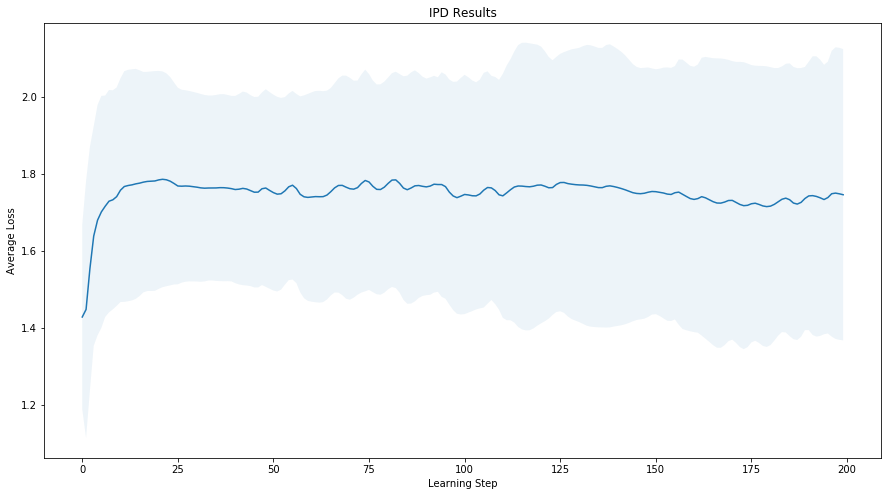

Jax time: 52.5037100315094
[1.42774579 1.42731839 1.48870787 1.49393104 1.47623493 1.46872095
 1.46671019 1.46264994 1.46110307 1.46319201 1.46289444 1.46090197
 1.46031792 1.46140184 1.46135644 1.45969231 1.45934526 1.46021229
 1.46062551 1.45943431 1.45894304 1.45961689 1.46020064 1.45953305
 1.45895483 1.45939057 1.4599882  1.4597039  1.45916193 1.45935366
 1.45989379 1.45985732 1.45941957 1.45942488 1.45986427 1.45998076
 1.45966697 1.45955844 1.45987787 1.46008006 1.45988747 1.4597258
 1.45992677 1.46016388 1.4600789  1.45990824 1.46000737 1.4602394
 1.46024426 1.46009409 1.46011476 1.46031495 1.46038609 1.460276
 1.46024447 1.46039685 1.46050982 1.46044847 1.46038942 1.46049018
 1.46062073 1.46060845 1.46054369 1.46059721 1.46072449 1.46075489
 1.4607012  1.46071759 1.46082744 1.46088897 1.46085668 1.46084957
 1.46093377 1.46101315 1.46100727 1.46098923 1.46104691 1.46113161
 1.4611506  1.46113298 1.46116746 1.46124689 1.46128658 1.46127751
 1.46129488 1.46136309 1.46141645 1.461

Jax time: 51.77712416648865
[1.42774579 1.5969841  1.82983658 1.87852094 1.89914132 1.90026549
 1.88244843 1.8610367  1.85380686 1.86253442 1.87544766 1.88152714
 1.88009993 1.87650678 1.8742235  1.87524789 1.87970449 1.88487562
 1.88676784 1.88453457 1.87976835 1.87277017 1.87796514 1.89767414
 1.89849768 1.88731961 1.88150011 1.8728694  1.87131423 1.87429178
 1.87777065 1.88060438 1.87677182 1.87072415 1.87096884 1.87053081
 1.8675593  1.86611156 1.8687782  1.8714753  1.87290023 1.87473704
 1.87775195 1.87576502 1.87164212 1.87529052 1.86175286 1.84625479
 1.83878587 1.84340778 1.84890568 1.84542198 1.83958641 1.84540689
 1.8456082  1.83301227 1.81969103 1.81822677 1.82376622 1.83286819
 1.83913093 1.83258076 1.82847986 1.83050081 1.83728531 1.84197397
 1.84334853 1.83787443 1.83448261 1.83399762 1.83295024 1.82613428
 1.81861788 1.8126199  1.82221198 1.84549559 1.84289464 1.84206339
 1.84335062 1.84279261 1.84045988 1.83827018 1.82729954 1.81197828
 1.80825514 1.81525806 1.81489387 

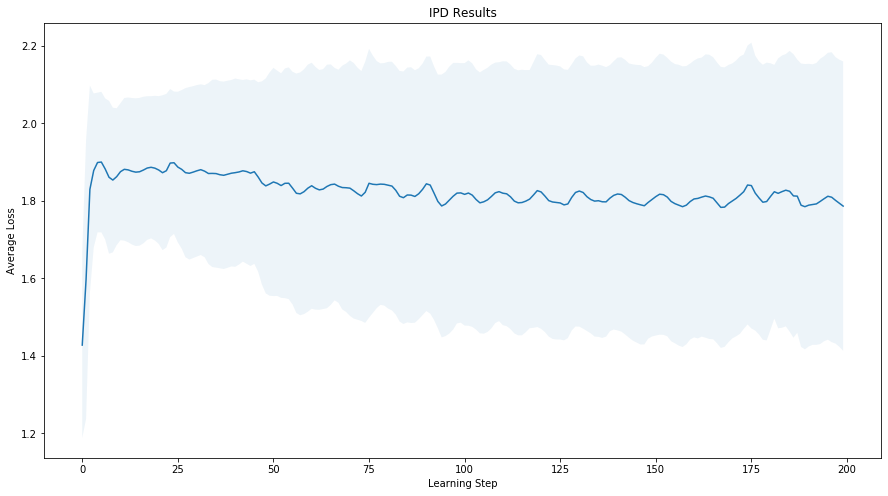

Jax time: 51.8889594078064
[1.42774579 1.43780843 1.53097418 1.62403597 1.68437132 1.72057405
 1.74128774 1.75863167 1.7782351  1.78990553 1.78975403 1.78548174
 1.77960977 1.77210814 1.76491282 1.75934734 1.75686069 1.75751716
 1.75954296 1.75955425 1.75475264 1.74640461 1.73827348 1.73350394
 1.73289478 1.73338164 1.73584331 1.73931561 1.73933492 1.73556865
 1.73119023 1.72376569 1.71819254 1.71954836 1.72653156 1.7331463
 1.73284467 1.7266499  1.71870618 1.71088052 1.71336658 1.71607774
 1.71403862 1.70739513 1.69967232 1.69275984 1.68678251 1.68173725
 1.67703484 1.67131511 1.66581762 1.6627388  1.6607714  1.65941938
 1.6594771  1.66099219 1.66323253 1.66620628 1.66962584 1.67261358
 1.67516849 1.67688202 1.67573019 1.66997368 1.66669699 1.66556647
 1.66499249 1.66385312 1.66244159 1.66411498 1.67071742 1.67810899
 1.68316604 1.68666682 1.69067377 1.69613975 1.70195365 1.70659515
 1.70898089 1.7093909  1.71000046 1.71245824 1.71712354 1.71813327
 1.71169878 1.69648174 1.68704331 1.

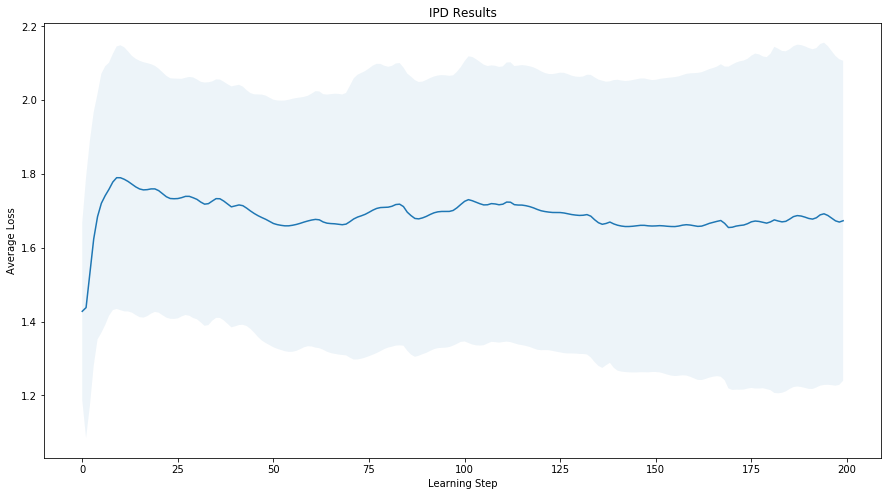

Jax time: 51.848249673843384
[1.42774579 1.40794543 1.41634987 1.45147409 1.47171613 1.4816743
 1.48707138 1.48820287 1.48956981 1.49365019 1.49922585 1.50524507
 1.51109865 1.51616709 1.52010571 1.5235892  1.52765812 1.53258097
 1.53802247 1.5432744  1.54764844 1.55117517 1.55463589 1.55862756
 1.56320442 1.56788457 1.57192862 1.57506419 1.5778302  1.58089004
 1.58455073 1.58854606 1.59217493 1.59496388 1.59727473 1.59985284
 1.60320331 1.60717923 1.611049   1.61402935 1.61620998 1.6184406
 1.62140402 1.62507031 1.62878998 1.63160449 1.63339329 1.63511423
 1.6375606  1.64078685 1.64423867 1.64692838 1.64858354 1.6500469
 1.65210045 1.65491925 1.65806982 1.66063351 1.66225684 1.66360741
 1.66537713 1.66788965 1.67084581 1.67333352 1.67486451 1.67607929
 1.67768057 1.68006723 1.68301851 1.68551923 1.68690016 1.68798881
 1.68958385 1.69198421 1.69498362 1.69747056 1.69868929 1.69962625
 1.70106853 1.70316101 1.70574208 1.70791416 1.70894082 1.70959249
 1.71064845 1.71221542 1.71419917 1.

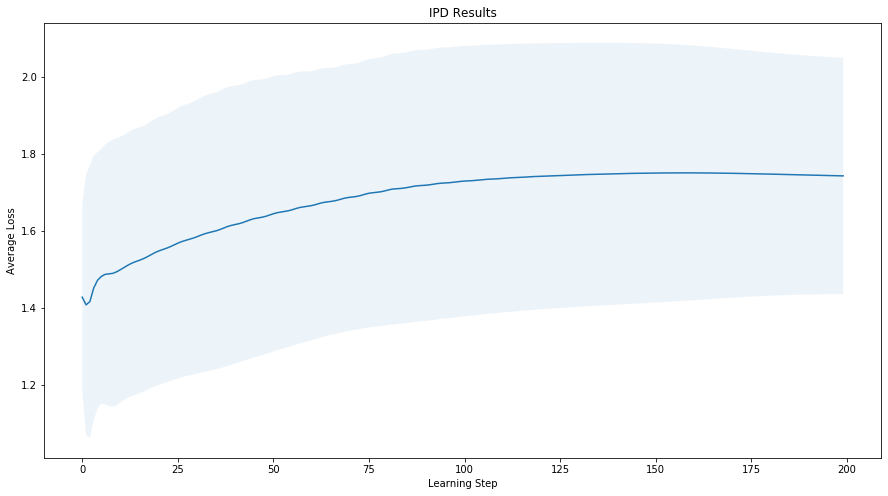

Jax time: 51.467214584350586
[1.42774579 1.40503191 1.40632418 1.43111551 1.44513714 1.44781794
 1.4466973  1.44120983 1.43861144 1.44125447 1.44313486 1.44447428
 1.44530523 1.44538645 1.44514971 1.44532648 1.44603676 1.44689116
 1.44757054 1.44802558 1.44838615 1.44881844 1.44938596 1.45000606
 1.45055672 1.45101226 1.45144582 1.45193611 1.45250104 1.45308924
 1.45363283 1.45411205 1.45456722 1.45505318 1.45559146 1.4561562
 1.45670444 1.45721271 1.45769484 1.45818331 1.45869966 1.45923934
 1.45978039 1.46030276 1.46080642 1.46130542 1.46181516 1.46233937
 1.46286881 1.46339295 1.46390662 1.46441523 1.46492643 1.46544395
 1.46596586 1.46648715 1.46700381 1.46751739 1.46803089 1.46854699
 1.46906496 1.46958299 1.47009996 1.47061476 1.47112971 1.47164516
 1.47216131 1.47267788 1.47319384 1.47370845 1.47422321 1.4747384
 1.47525411 1.47576919 1.47628383 1.47679795 1.47731171 1.47782643
 1.47834087 1.47885536 1.47936893 1.479882   1.48039496 1.48090846
 1.4814215  1.48193485 1.48244725 1

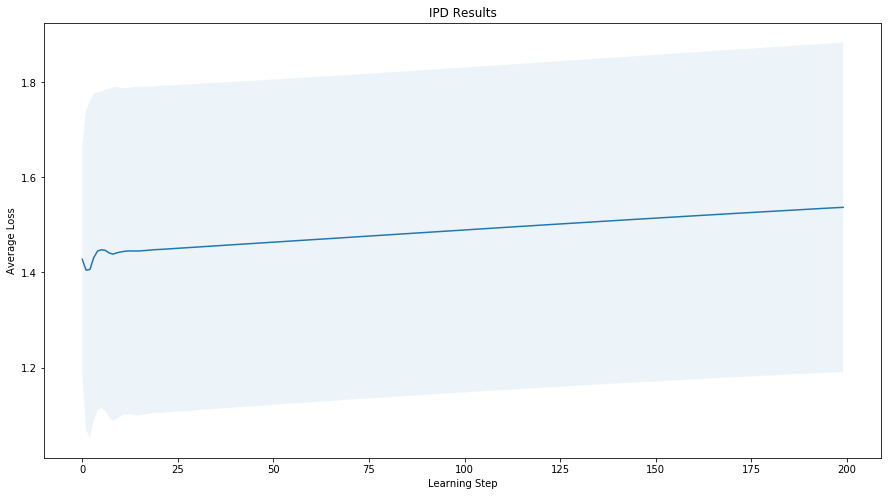

Jax time: 51.701735973358154
[1.42774579 1.40486885 1.40568776 1.42974791 1.44344766 1.44577298
 1.44434492 1.43855111 1.43571314 1.43815167 1.43974969 1.44072553
 1.4411666  1.44088212 1.44036867 1.44037681 1.44094294 1.4415949
 1.44198977 1.44210566 1.44213245 1.44229144 1.44265016 1.44307713
 1.44339689 1.44357054 1.44369784 1.4438992  1.44421407 1.44457839
 1.44489161 1.44511189 1.44528549 1.44548976 1.44576567 1.44608859
 1.44639778 1.44665335 1.44686647 1.44708123 1.44733288 1.4476211
 1.44791623 1.44818769 1.44842943 1.44866069 1.44890584 1.44917298
 1.44945235 1.44972507 1.44998177 1.45022752 1.45047512 1.45073332
 1.45100152 1.45127033 1.45153231 1.45178649 1.45203913 1.45229529
 1.45255734 1.45282176 1.45308446 1.45334302 1.45359922 1.45385605
 1.45411556 1.4543774  1.4546391  1.45489934 1.45515769 1.45541566
 1.45567477 1.45593481 1.45619589 1.45645599 1.45671562 1.45697432
 1.45723356 1.45749344 1.45775354 1.45801367 1.45827341 1.4585328
 1.45879226 1.45905178 1.45931157 1.

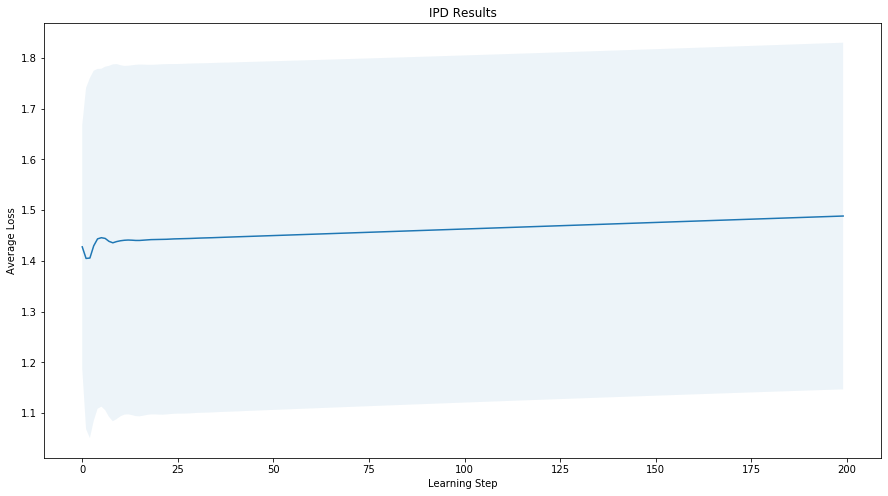

Jax time: 52.38243532180786
[1.42774579 1.41273267 1.43698532 1.46961352 1.4690565  1.46458297
 1.45914747 1.45586654 1.45495917 1.45412149 1.45483571 1.45551546
 1.45488997 1.45419155 1.4540883  1.45415706 1.45436744 1.45450686
 1.4545186  1.45449914 1.45438376 1.45427332 1.45431733 1.45447747
 1.45461686 1.45459906 1.45446193 1.45439163 1.45447416 1.45462649
 1.45469848 1.45463923 1.45455451 1.45456095 1.45465953 1.45475181
 1.45475978 1.45471002 1.45468863 1.45473579 1.45481126 1.45484969
 1.45483737 1.4548192  1.45483797 1.45488893 1.45493291 1.45494487
 1.45494    1.454949   1.45498171 1.45502041 1.45504376 1.45505129
 1.45505969 1.45508228 1.45511389 1.45514042 1.45515599 1.45516793
 1.45518643 1.45521174 1.45523783 1.45525767 1.45527331 1.45529054
 1.4553126  1.45533671 1.45535856 1.45537657 1.45539438 1.45541465
 1.45543679 1.45545897 1.45547852 1.45549727 1.45551731 1.4555383
 1.45555961 1.4555801  1.45559952 1.45561958 1.45564001 1.45566094
 1.45568152 1.45570165 1.45572173 1

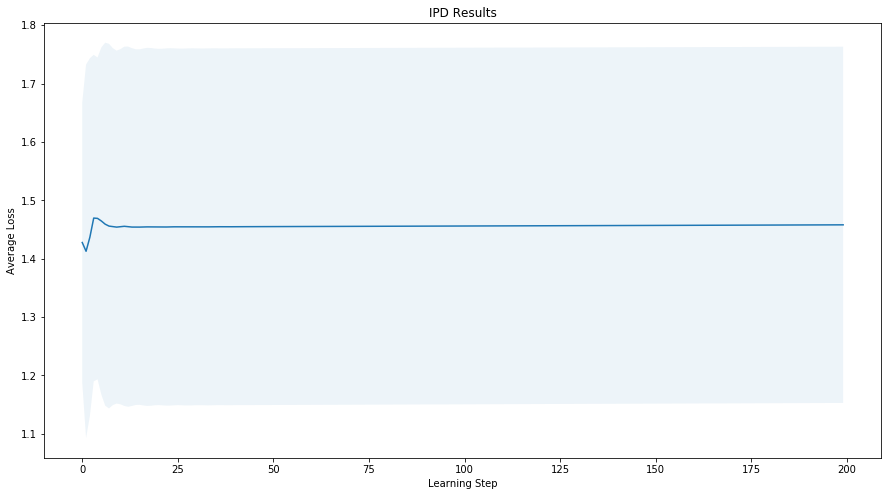

Jax time: 52.0694317817688
[1.42774579 1.68136568 1.89431577 1.95941977 1.98763928 1.98541601
 1.98233594 1.95419014 1.95528003 1.95363234 1.94152304 1.93269154
 1.92894041 1.92535944 1.92196208 1.92593795 1.92501791 1.9171586
 1.91013627 1.92170252 1.9373624  1.94079455 1.94087382 1.9408125
 1.94075418 1.94076986 1.94102982 1.94143818 1.94148014 1.94076193
 1.93897386 1.93976743 1.93681201 1.92622245 1.92468456 1.92320484
 1.91845352 1.91527417 1.91526611 1.91537804 1.91551606 1.91567026
 1.9158389  1.91601157 1.91617442 1.91632172 1.91645474 1.91657624
 1.91668478 1.91677352 1.91683734 1.91687395 1.91688537 1.91687517
 1.91684562 1.91679805 1.91673346 1.91665694 1.91657704 1.91650426
 1.91644924 1.91641687 1.9164069  1.91641593 1.91643694 1.91646283
 1.91648384 1.9164904  1.91647436 1.91643187 1.9163636  1.91627404
 1.91617014 1.91605195 1.91590896 1.915724   1.91547917 1.91515491
 1.91449618 1.91270308 1.91138484 1.91361623 1.91185515 1.90228379
 1.90109529 1.89890454 1.89858508 1.8

Jax time: 51.94335722923279
[1.42774579 1.43099037 1.50152199 1.50872332 1.4942023  1.4906529
 1.49361118 1.49253577 1.49311124 1.4988153  1.50291888 1.50361428
 1.50505134 1.50935492 1.5136491  1.51524418 1.51683401 1.52059656
 1.52489441 1.52710831 1.52871884 1.53207376 1.53615861 1.53874086
 1.54040813 1.54339087 1.54726823 1.55003068 1.55175446 1.55433451
 1.55802056 1.56092098 1.56270541 1.56486617 1.56827997 1.57134629
 1.57322627 1.57499438 1.57799805 1.58125391 1.58332093 1.58468639
 1.58711246 1.59061427 1.59305672 1.59377581 1.59529952 1.59915775
 1.6018363  1.60125805 1.60191827 1.60673345 1.60705693 1.60467168
 1.60449924 1.60728097 1.61053982 1.61251073 1.61372192 1.61556983
 1.61822267 1.62045421 1.62194845 1.62358663 1.62592126 1.62815261
 1.62973163 1.63123051 1.63331657 1.63551708 1.63715363 1.6385621
 1.64040395 1.64251466 1.64419595 1.64559351 1.64722771 1.64915401
 1.65081734 1.65229083 1.65384664 1.65548404 1.65698421 1.65854795
 1.66029904 1.66157875 1.66277408 1.

Jax time: 51.854854345321655
[1.42774579 1.41900687 1.45909033 1.49651671 1.49407973 1.49419703
 1.4973461  1.49665125 1.4932191  1.49389036 1.50020893 1.50776873
 1.51177721 1.51281663 1.51436645 1.5184749  1.52395278 1.52819567
 1.53054644 1.53263032 1.53601185 1.54037921 1.54422375 1.5468511
 1.54911094 1.55217836 1.55604705 1.55963092 1.5622003  1.5643389
 1.56721154 1.57098423 1.57448505 1.57668955 1.57832435 1.58107974
 1.58524762 1.5887814  1.58999745 1.59060473 1.5933971  1.59838957
 1.60198676 1.60208843 1.6018365  1.60439232 1.60893263 1.6125909
 1.61375287 1.61424089 1.6165237  1.62039679 1.62358432 1.62477345
 1.62542443 1.62783191 1.6317691  1.6345191  1.63494867 1.63520627
 1.63804467 1.64250455 1.64465976 1.64393433 1.64383439 1.64744699
 1.65198613 1.65295766 1.65137082 1.65248054 1.6583387  1.65989053
 1.65903316 1.65686838 1.65637813 1.66152071 1.66595767 1.66564924
 1.66362415 1.66270884 1.66620871 1.67103272 1.67242531 1.67064034
 1.66959836 1.67234366 1.67679143 1.

Jax time: 51.823458194732666
[1.42774579 1.42446305 1.47941483 1.49401253 1.47882322 1.4714692
 1.46855104 1.46299155 1.46087573 1.46364608 1.46565535 1.46386177
 1.4621075  1.46255884 1.464568   1.46399517 1.46237038 1.46221769
 1.46391916 1.46451371 1.46321149 1.46248496 1.46348304 1.46474073
 1.46425452 1.46327958 1.46353512 1.46475069 1.46507443 1.46433523
 1.46406044 1.46485048 1.46559515 1.46534975 1.46489306 1.46520377
 1.46596576 1.46617016 1.46583145 1.46580831 1.46635798 1.46680634
 1.46672245 1.46657418 1.4668647  1.46734815 1.46750242 1.46739567
 1.46749484 1.46788541 1.46818061 1.46819528 1.46821074 1.46847042
 1.46880158 1.46894025 1.46896128 1.46911484 1.46941108 1.46963148
 1.46970642 1.46980496 1.47003782 1.47028867 1.47042697 1.47051722
 1.4706921  1.47093381 1.47111986 1.47123173 1.47137079 1.47158343
 1.47179286 1.47193621 1.47206401 1.47224522 1.4724558  1.47262679
 1.47276082 1.47291936 1.47311777 1.47330554 1.47345477 1.4736025
 1.4737842  1.4739769  1.47414217 1

Jax time: 51.910038232803345
[1.42774579 1.45070445 1.56079647 1.64007382 1.67397221 1.69149385
 1.70435746 1.71469888 1.72108215 1.72971344 1.73869078 1.74839078
 1.75787577 1.76626207 1.77184669 1.77440135 1.77461012 1.77322387
 1.77300184 1.77927309 1.78345089 1.77707705 1.77362056 1.77118685
 1.77118604 1.77357538 1.77238707 1.76980855 1.76769948 1.76667477
 1.76675377 1.76676346 1.76582632 1.76433922 1.76283651 1.76191534
 1.76303365 1.76538632 1.76755709 1.76718816 1.76488331 1.76312652
 1.7634165  1.76554972 1.7690617  1.76881282 1.76294246 1.75966116
 1.75960891 1.76508273 1.76923853 1.76941155 1.76900695 1.76736401
 1.76449574 1.76396929 1.76492715 1.76564307 1.76703805 1.76891318
 1.77099333 1.77088637 1.76519825 1.76194071 1.76348736 1.76578647
 1.76844844 1.77205703 1.77668706 1.78217864 1.78117348 1.77618419
 1.7731281  1.77208116 1.77210982 1.7707874  1.76666941 1.76112512
 1.75699084 1.76132767 1.76745686 1.76567487 1.76225329 1.7588178
 1.7576506  1.7587455  1.76006907 

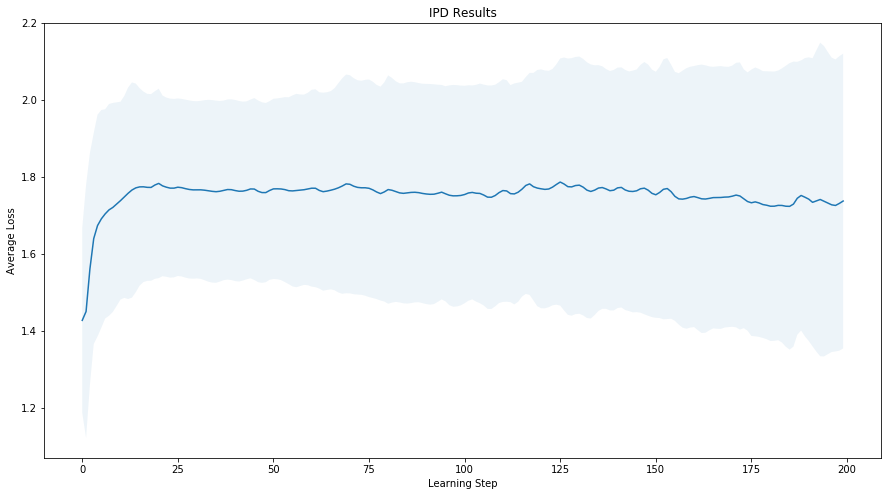

Jax time: 52.021159648895264
[1.42774579 1.42396652 1.47579353 1.5461928  1.58351798 1.6071851
 1.6198471  1.62751433 1.63822129 1.6524206  1.6669644  1.6792917
 1.68886142 1.69653622 1.70549758 1.7153633  1.72302758 1.72692708
 1.7304321  1.73444294 1.73917342 1.74253029 1.74384732 1.74539092
 1.74749776 1.74984617 1.75184671 1.75268251 1.75240621 1.75183796
 1.75199231 1.75324246 1.7541042  1.75361751 1.75233166 1.75106036
 1.75056692 1.75110047 1.75191909 1.75233073 1.75177791 1.75084562
 1.75017956 1.75015752 1.75113355 1.75330395 1.75450118 1.75370924
 1.75211248 1.75016624 1.7482546  1.74667689 1.74609388 1.74706146
 1.74897503 1.74890205 1.74568129 1.74238949 1.74014798 1.73926332
 1.73922342 1.73939409 1.73936306 1.73921069 1.73920327 1.73946202
 1.74002087 1.74079323 1.74164682 1.74247171 1.74262653 1.74066733
 1.73667844 1.73377871 1.73336226 1.73436049 1.73562809 1.73531524
 1.73182329 1.72804018 1.72757454 1.72819182 1.72870631 1.72975317
 1.73214929 1.73559435 1.73896887 1

Jax time: 51.782487630844116
[1.42774579 1.57822846 1.82206183 1.86296193 1.889651   1.83991404
 1.82362283 1.82078567 1.81674928 1.81242095 1.80797777 1.81941447
 1.80557815 1.80450622 1.80301642 1.8000569  1.80634839 1.81038908
 1.79010446 1.76890945 1.75642984 1.74562407 1.74127437 1.74845591
 1.74653714 1.75246534 1.75376135 1.74843377 1.72461622 1.7194321
 1.71562448 1.70285002 1.7022781  1.70761957 1.71359361 1.70394073
 1.70354169 1.7003141  1.69548255 1.69640841 1.68422895 1.70077246
 1.69962694 1.68863854 1.68150264 1.68523538 1.6895429  1.68876679
 1.68259806 1.68780103 1.687537   1.6903785  1.69245403 1.68917615
 1.67783515 1.67479288 1.67142089 1.67190416 1.68093366 1.6722974
 1.67006627 1.66950523 1.67320075 1.67559957 1.67243696 1.67077683
 1.67151998 1.67877342 1.67722763 1.66829419 1.66769089 1.67511436
 1.66699726 1.66309289 1.66455407 1.66439807 1.66152587 1.66863435
 1.66597396 1.66223598 1.66069949 1.65965579 1.65954432 1.67111388
 1.671166   1.67047656 1.67115324 1

Jax time: 51.939560890197754
[1.42774579 1.41569448 1.44821318 1.4801231  1.47383481 1.4691442
 1.46563224 1.46182388 1.45831259 1.45717641 1.45939203 1.46114097
 1.46065222 1.45955423 1.45898742 1.45953051 1.46055831 1.46092174
 1.4606598  1.46033943 1.46051136 1.46110521 1.46152018 1.46155436
 1.46145409 1.46158199 1.46197232 1.46231055 1.46243269 1.46246148
 1.46261307 1.46291659 1.46319398 1.46334078 1.46343454 1.46360633
 1.46386932 1.46411391 1.46427262 1.46439891 1.46457925 1.46482027
 1.46504712 1.46521466 1.46536045 1.46554372 1.46576903 1.46598544
 1.46616047 1.46631916 1.46650349 1.46671723 1.46692646 1.46710745
 1.46727559 1.46745982 1.46766536 1.46786935 1.46805415 1.4682288
 1.46841379 1.46861317 1.46881311 1.46900034 1.46918    1.46936534
 1.46956096 1.46975748 1.46994618 1.47012892 1.47031518 1.47050792
 1.47070192 1.47089122 1.47107611 1.47126298 1.47145403 1.4716461
 1.47183575 1.47202199 1.47220898 1.47239909 1.47258983 1.47277916
 1.47296636 1.4731538  1.47334293 1.

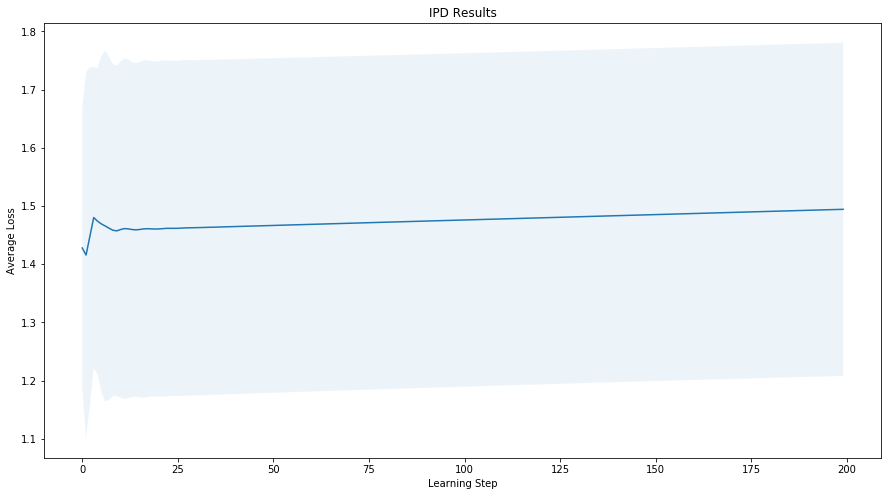

Jax time: 51.77585959434509
[1.42774579 1.42133063 1.46877899 1.49117374 1.47771838 1.47086034
 1.46743435 1.46102386 1.45761081 1.4597888  1.46330071 1.46259391
 1.46005018 1.45895553 1.46047998 1.46170783 1.46061093 1.45920041
 1.45933666 1.4607994  1.46094025 1.4597271  1.45902994 1.45982719
 1.46080919 1.46034862 1.45933586 1.45925898 1.46021238 1.46062577
 1.45992788 1.459282   1.4596295  1.46040736 1.46037825 1.45969981
 1.45944106 1.45997274 1.46044358 1.46016009 1.45964962 1.45969854
 1.46021457 1.46039047 1.46002259 1.45973354 1.45996522 1.4603494
 1.46031238 1.45998093 1.45989643 1.46018795 1.46040553 1.46025514
 1.46002452 1.4600877  1.46034899 1.46042044 1.46024151 1.46012885
 1.46026931 1.46045392 1.46042684 1.46027671 1.46026469 1.46042206
 1.46052149 1.46044646 1.46035296 1.46040837 1.46054182 1.46057142
 1.46049004 1.46045648 1.46054242 1.46063363 1.46061917 1.46055801
 1.4605726  1.46066044 1.46070876 1.46067587 1.46064556 1.46068916
 1.4607608  1.46077673 1.46074529 1

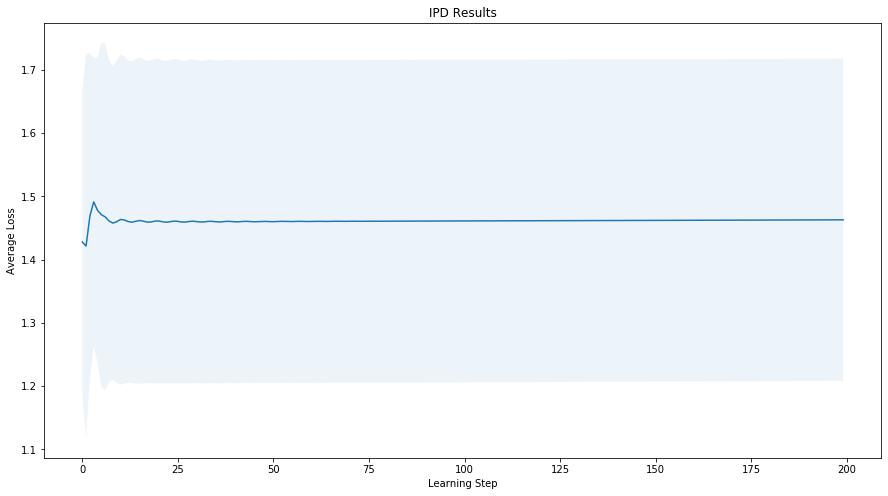

Jax time: 51.584023237228394
[1.42774579 1.43617802 1.51476547 1.56632967 1.57887147 1.58968673
 1.60432207 1.61348022 1.62112753 1.63024722 1.64294271 1.65469427
 1.66296196 1.67156744 1.68442937 1.68935106 1.6930271  1.69533994
 1.69715856 1.70263154 1.71019223 1.71746687 1.72232578 1.72504112
 1.72754868 1.73115581 1.73627308 1.73909788 1.73965163 1.74082459
 1.74623315 1.75089104 1.74900879 1.7476095  1.74645198 1.74669328
 1.74824172 1.75056481 1.75046567 1.7496576  1.750684   1.75269419
 1.75417486 1.75308499 1.75186979 1.75270146 1.75473679 1.75602683
 1.75477466 1.75322867 1.75335536 1.75475713 1.7561971  1.75519203
 1.75326365 1.75281345 1.75392636 1.75565454 1.7549836  1.75263772
 1.75156946 1.75223418 1.75406757 1.75402087 1.75132818 1.74946166
 1.74959266 1.75149099 1.75271422 1.75074428 1.74846279 1.74826514
 1.75005223 1.7520112  1.75102113 1.74839668 1.74806247 1.75047084
 1.75377247 1.75429524 1.75175198 1.75072109 1.75195686 1.7540288
 1.75428261 1.7514394  1.74968191 

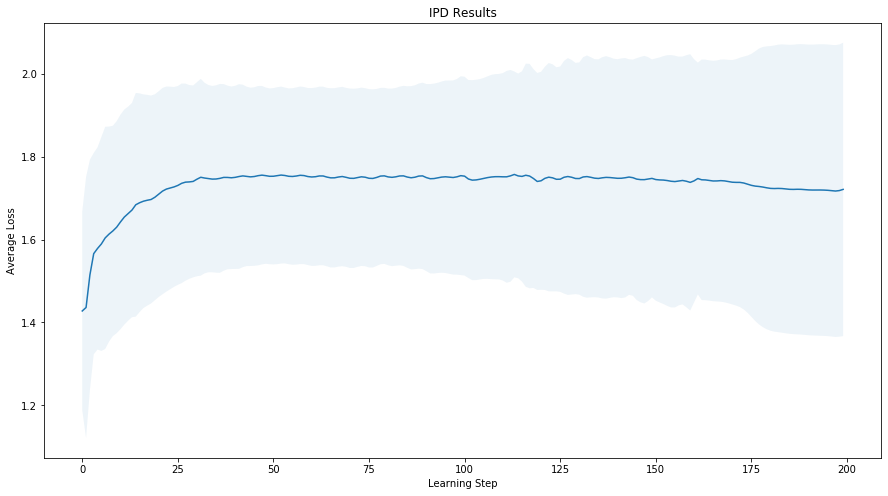

Jax time: 52.01723027229309
[1.42774579 1.4445732  1.56682704 1.65508595 1.69396543 1.71744323
 1.73209574 1.73328374 1.73600007 1.74001362 1.73958731 1.73626439
 1.74155114 1.74022262 1.73846478 1.73439684 1.73167197 1.72818083
 1.72582088 1.72981467 1.73478141 1.73340715 1.72448807 1.71310349
 1.71992573 1.72345153 1.72769146 1.72618645 1.72482214 1.72082119
 1.71777884 1.71551755 1.71041212 1.70390272 1.70459219 1.70254361
 1.70095464 1.70007344 1.69807788 1.69104192 1.68228597 1.67870501
 1.68019339 1.68052362 1.68055813 1.67656943 1.67209004 1.66898448
 1.66426946 1.66224991 1.66340809 1.6624736  1.661845   1.66443095
 1.66278044 1.6546276  1.65431827 1.65244413 1.64809633 1.64578558
 1.64448701 1.64580702 1.64840628 1.6455898  1.64041037 1.63439978
 1.63333042 1.63832409 1.6446799  1.65248835 1.65914522 1.66530463
 1.66981533 1.67146996 1.67495093 1.68118966 1.68620919 1.69221844
 1.70114074 1.71077915 1.72220456 1.72873007 1.71634821 1.71019199
 1.7031911  1.7010037  1.70965629 

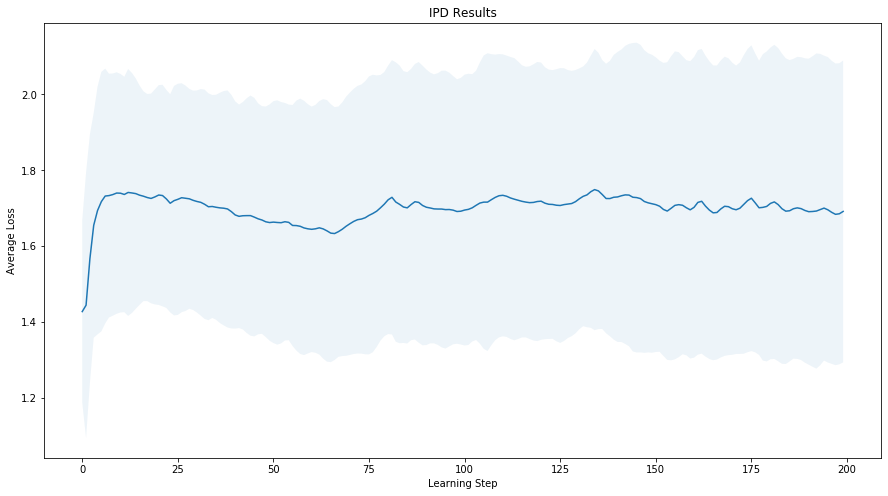

Jax time: 52.19700622558594
[1.42774579 1.41166759 1.43293456 1.46954141 1.4766862  1.47671206
 1.47414744 1.47218791 1.47323735 1.47482913 1.47713187 1.48027084
 1.48240821 1.48323088 1.4844722  1.48658616 1.48924684 1.49199663
 1.4942458  1.49595535 1.49764579 1.49967139 1.50202191 1.5044077
 1.50650199 1.50829605 1.51008281 1.51211141 1.51436393 1.51657858
 1.51851411 1.52021811 1.5219735  1.52398828 1.52618035 1.52824178
 1.52997031 1.53151599 1.53323276 1.53528701 1.53744071 1.53926756
 1.54065918 1.5420281  1.54385513 1.54610919 1.54814971 1.54943044
 1.55032773 1.55177868 1.55419029 1.55672554 1.55801108 1.55820069
 1.55892219 1.56137323 1.56477143 1.56657054 1.56609442 1.56570882
 1.56742537 1.57091554 1.57381851 1.57438907 1.57388799 1.57466512
 1.57722141 1.58004851 1.58157843 1.58199611 1.58268655 1.58452758
 1.58697083 1.58869135 1.58946195 1.59021422 1.59166851 1.59381493
 1.59577999 1.59687883 1.59760274 1.59868163 1.60039807 1.60240582
 1.60396524 1.60489043 1.60571738 1

Jax time: 52.09803295135498
[1.42774579 1.42428461 1.47888478 1.49331576 1.47793127 1.47034538
 1.46717882 1.46147321 1.45925777 1.46186673 1.46364399 1.46165891
 1.4597977  1.46010016 1.46188922 1.46109225 1.45934281 1.45907132
 1.46057341 1.46093648 1.45947127 1.45863948 1.45946909 1.46050218
 1.45982431 1.45873063 1.45884914 1.45985806 1.45997418 1.45908948
 1.45869229 1.45930342 1.45983699 1.45942101 1.45883669 1.45899356
 1.45955442 1.45957048 1.45908881 1.45892475 1.45929137 1.45954408
 1.45930013 1.45901218 1.45913623 1.45942736 1.45940713 1.45915412
 1.45909904 1.45930576 1.4594184  1.45927746 1.45914314 1.45922979
 1.45937638 1.45934891 1.45921946 1.45920976 1.45932409 1.45937056
 1.45929123 1.45923239 1.45928951 1.45936217 1.45933914 1.45927497
 1.45928151 1.4593445  1.4593623  1.45931831 1.45929545 1.45933235
 1.45936824 1.45935222 1.4593215  1.45933209 1.45936714 1.45937348
 1.4593499  1.45934339 1.45936759 1.45938523 1.45937518 1.45936194
 1.45937238 1.45939245 1.45939468 

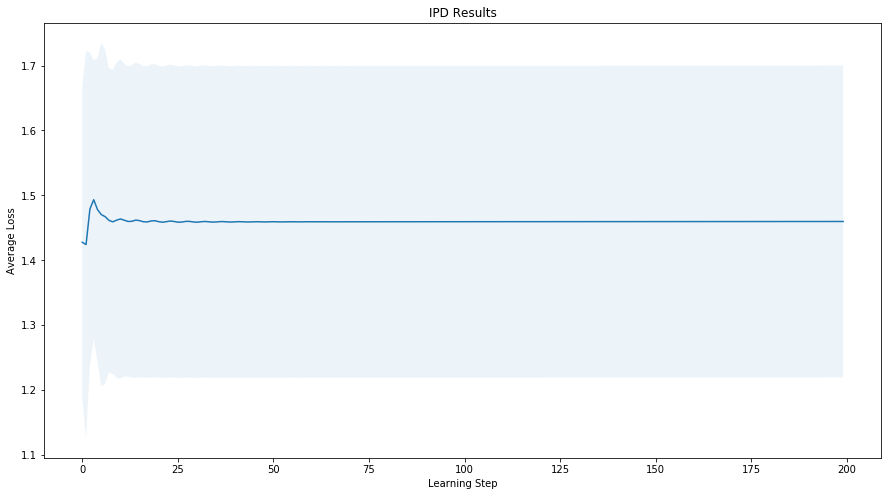

Jax time: 52.15923523902893
[1.42774579 1.40998189 1.42616825 1.45779916 1.46277639 1.46029744
 1.45387817 1.44902081 1.44954757 1.44978715 1.45003387 1.45028351
 1.44973055 1.44917186 1.44929614 1.44959581 1.44960076 1.44941652
 1.44928723 1.44940494 1.44964818 1.44969046 1.44948451 1.4492794
 1.44929292 1.44950381 1.44967668 1.44963145 1.44944626 1.44933277
 1.44940006 1.44956177 1.44964246 1.44957482 1.44945543 1.44941689
 1.44949023 1.44958806 1.449611   1.44955259 1.44949025 1.44949142
 1.44954958 1.44960005 1.44959744 1.44955815 1.44953264 1.44954901
 1.44958756 1.44961012 1.4496005  1.44957901 1.44957406 1.44959204
 1.44961564 1.44962394 1.44961603 1.44960708 1.44961108 1.44962616
 1.44963926 1.44964196 1.44963794 1.44963681 1.44964373 1.44965494
 1.44966241 1.44966376 1.44966342 1.44966625 1.44967348 1.44968179
 1.44968654 1.44968846 1.44969022 1.44969496 1.44970147 1.44970749
 1.4497118  1.44971436 1.44971781 1.44972277 1.44972849 1.44973332
 1.44973718 1.44974084 1.44974495 1

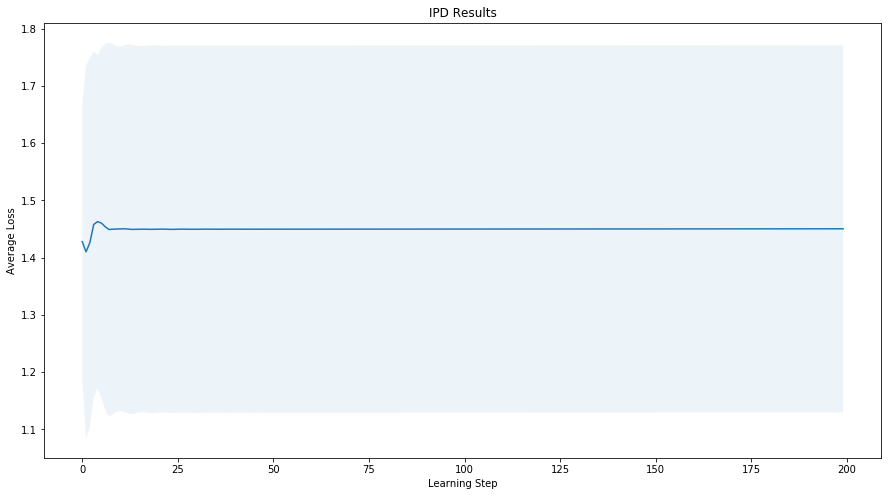

Jax time: 52.3433723449707
[1.42774579 1.44574863 1.54035233 1.56324592 1.56198189 1.57043006
 1.58543604 1.5950474  1.60389165 1.61716287 1.62707565 1.63449337
 1.64263823 1.65446357 1.66552094 1.67215911 1.67742607 1.68560019
 1.6933854  1.69693903 1.69978018 1.70439922 1.71134003 1.71688677
 1.71962288 1.72156375 1.72527745 1.73092788 1.73251513 1.73288768
 1.73460834 1.73857195 1.74207983 1.74239421 1.74289334 1.74533096
 1.74927365 1.74954393 1.74702046 1.7466263  1.74880095 1.75156921
 1.75408554 1.7548296  1.75458925 1.7558411  1.75772034 1.75902749
 1.75714746 1.75697015 1.76013382 1.76367528 1.75959218 1.75453494
 1.75355708 1.75299542 1.75377177 1.75459519 1.75561681 1.75610614
 1.75733842 1.75868839 1.75934428 1.75991263 1.76162251 1.76367004
 1.76417079 1.76404758 1.76533728 1.76805354 1.76905899 1.76827641
 1.76821687 1.77088221 1.77281302 1.77196316 1.77074866 1.77232548
 1.77484194 1.77449846 1.77261544 1.77297927 1.77548571 1.77587471
 1.77353648 1.77306945 1.77543917 1

Jax time: 51.95344829559326
[1.42774579 1.42193341 1.46957243 1.50261789 1.49581638 1.49461218
 1.49707336 1.49464505 1.49177509 1.49504668 1.50312255 1.50950417
 1.5113337  1.51180073 1.51468235 1.52024073 1.52512004 1.52755036
 1.5292322  1.53248167 1.53713457 1.54106776 1.54347493 1.5456414
 1.54898872 1.5530839  1.55647352 1.55880133 1.56113488 1.5644393
 1.56818944 1.57121194 1.57331833 1.57560017 1.57892054 1.58256731
 1.58515307 1.58665926 1.58880497 1.59261602 1.5964383  1.5978918
 1.59809838 1.60044916 1.60548654 1.60915121 1.60874587 1.60808122
 1.61081766 1.61536245 1.61851943 1.61914613 1.61980751 1.62256211
 1.62623272 1.62850869 1.6290776  1.63039503 1.63343232 1.63629687
 1.63737291 1.63809907 1.64116871 1.64381458 1.6437     1.64313239
 1.64590425 1.653233   1.65347004 1.6492998  1.64752392 1.64807006
 1.65112245 1.6543649  1.65599215 1.65604289 1.6566308  1.65933418
 1.6624702  1.66379045 1.66320403 1.66368087 1.66704177 1.67076297
 1.67108183 1.66910556 1.66951836 1.6

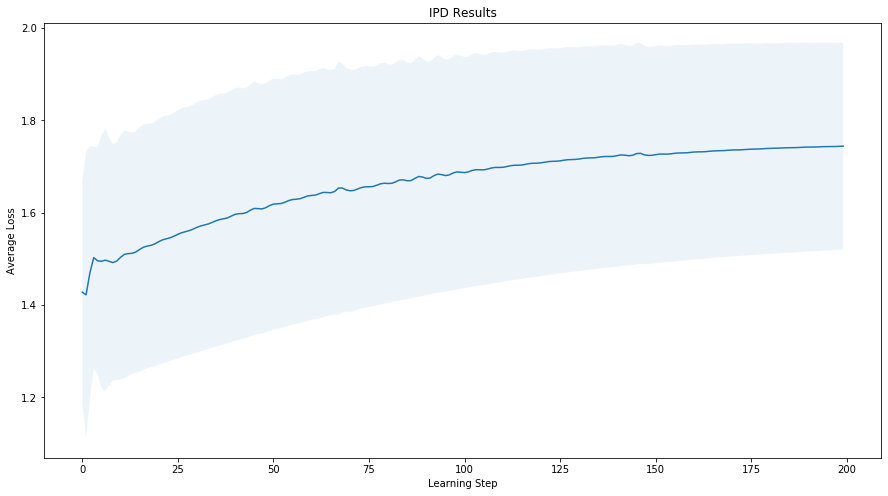

Jax time: 52.085551500320435
[1.42774579 1.40632365 1.41064024 1.43987073 1.45671064 1.46255764
 1.4643705  1.46194326 1.46093342 1.46434992 1.46807089 1.47179176
 1.47532762 1.47817466 1.48014713 1.48166779 1.48349157 1.48595818
 1.48891191 1.49204006 1.49496665 1.4973939  1.49939212 1.50139491
 1.50377102 1.50655175 1.50946679 1.51212137 1.51431817 1.51627723
 1.51842018 1.52096631 1.52377187 1.52643567 1.52864361 1.53051444
 1.53248697 1.53487178 1.53758024 1.54016863 1.54223315 1.54389139
 1.54567759 1.54797039 1.55065179 1.55312576 1.55487373 1.55615687
 1.55773294 1.56003795 1.56281551 1.56513021 1.56633768 1.56710293
 1.56850937 1.57099407 1.5740277  1.57610144 1.57656409 1.57680351
 1.57812449 1.58088495 1.58428574 1.58625144 1.58619305 1.58609072
 1.58725155 1.5899661  1.59353473 1.59599023 1.59632197 1.59616645
 1.59701338 1.59922279 1.60238262 1.60511463 1.60625842 1.6064672
 1.60711611 1.60878931 1.6113457  1.61390102 1.6154536  1.61606927
 1.6167223  1.61808101 1.62019188 

Jax time: 52.49546456336975
[1.42774579 1.41552403 1.44765746 1.47927992 1.47279797 1.46782367
 1.4639448  1.4600492  1.45655185 1.45531958 1.45729493 1.45871513
 1.4580087  1.45681343 1.45612109 1.45645121 1.4572302  1.45738622
 1.45697516 1.4564972  1.45646779 1.4568467  1.45706873 1.45693527
 1.45666029 1.45658925 1.45677769 1.45692909 1.45687755 1.45672633
 1.45668164 1.45678775 1.45687945 1.45684895 1.45676078 1.45674008
 1.4568095  1.45686722 1.45684472 1.45678799 1.45677924 1.4568296
 1.45686894 1.4568529  1.45681428 1.45681053 1.45684777 1.45687652
 1.45686613 1.45683937 1.45683757 1.45686506 1.45688777 1.45688176
 1.45686383 1.4568628  1.45688292 1.45690054 1.45689826 1.45688677
 1.45688615 1.45690101 1.45691537 1.45691573 1.45690843 1.45690872
 1.45691973 1.45693114 1.45693328 1.45692953 1.45693017 1.45693874
 1.45694797 1.45695109 1.45694983 1.45695111 1.45695797 1.45696561
 1.45696946 1.45696968 1.45697113 1.45697717 1.45698381 1.4569876
 1.45698937 1.45699147 1.45699637 1.

Jax time: 52.152594804763794
[1.42774579 1.41442604 1.4426602  1.47876007 1.48040629 1.47877507
 1.47735291 1.47596479 1.47508372 1.47509097 1.4777694  1.48175586
 1.48397083 1.48447004 1.48530701 1.48720306 1.49002744 1.49269782
 1.4944808  1.49579553 1.49738963 1.49953948 1.50191198 1.50396772
 1.50560872 1.50720584 1.50909101 1.51121587 1.51325415 1.51500244
 1.51660476 1.51834279 1.52029609 1.52227319 1.52404666 1.52562641
 1.52723707 1.5290425  1.53095355 1.5327307  1.53427488 1.53575816
 1.53742477 1.53928568 1.54107957 1.5425792  1.54391041 1.54543728
 1.54730329 1.54918023 1.55062179 1.55170899 1.55306143 1.55505924
 1.5571885  1.55851253 1.55909609 1.56014675 1.56252771 1.56526265
 1.56630648 1.56589622 1.56632108 1.56907945 1.5726457  1.57386009
 1.57279293 1.57251785 1.57461969 1.57777752 1.57992971 1.58035817
 1.58053059 1.58189137 1.58419282 1.58620326 1.58722141 1.58787021
 1.58911717 1.59106738 1.59287263 1.59389957 1.59464517 1.59588009
 1.59774492 1.5995059  1.60047976

Jax time: 52.30478310585022
[1.42774579 1.41614045 1.44844895 1.48799103 1.49190847 1.492934
 1.49535027 1.49643669 1.49553409 1.49588906 1.49987911 1.5067269
 1.51244916 1.51511203 1.51655415 1.51929767 1.52396328 1.52915004
 1.53299908 1.53534997 1.53770412 1.54121323 1.5455776  1.54949541
 1.55215959 1.55426961 1.5571177  1.56103745 1.56501894 1.56779268
 1.56955225 1.57184706 1.57563979 1.57998278 1.58276414 1.58377545
 1.58523745 1.58895589 1.5939599  1.59690266 1.59706563 1.59747535
 1.60049588 1.60534112 1.60914428 1.61017723 1.61046533 1.61253886
 1.61647698 1.62034498 1.62227498 1.62295211 1.62449544 1.62773031
 1.63145134 1.63369679 1.63445425 1.63560342 1.6383881  1.6420824
 1.64453993 1.64514294 1.64580249 1.64827304 1.65206285 1.65457121
 1.65470535 1.65476023 1.65729095 1.66138857 1.66338275 1.66253941
 1.66201339 1.66588381 1.67001438 1.67082595 1.66924542 1.66720456
 1.67030179 1.67571286 1.67682361 1.67606371 1.67367473 1.67279751
 1.67544188 1.67976105 1.68180964 1.68

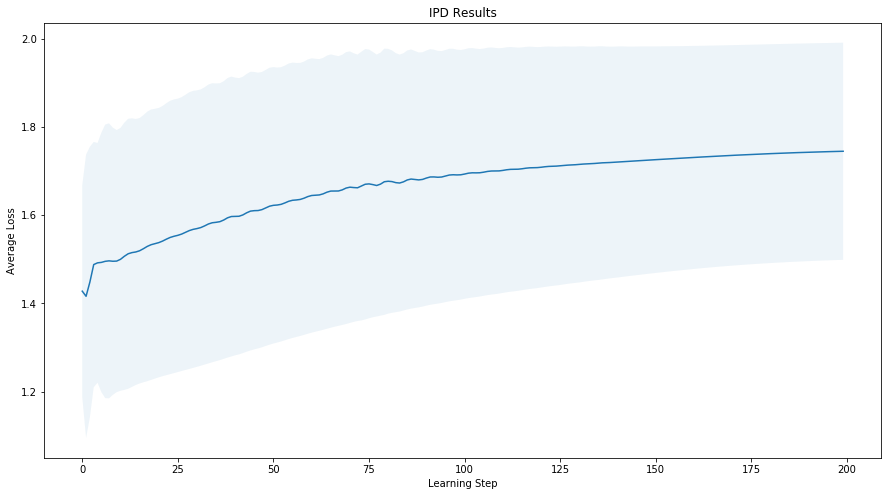

Jax time: 52.43460965156555
[1.42774579 1.42709694 1.4982654  1.56679648 1.59381532 1.61171287
 1.61845693 1.62525725 1.63650176 1.64658725 1.65522747 1.66153136
 1.67051697 1.68395059 1.6939872  1.69917326 1.70308171 1.70582263
 1.71682045 1.73142439 1.73890791 1.74114896 1.74063983 1.74039116
 1.74286728 1.74554823 1.7458931  1.74243075 1.7378227  1.73653011
 1.73640974 1.73777261 1.74024649 1.74013259 1.73757798 1.73481858
 1.73473325 1.73956217 1.74563516 1.7467194  1.74406594 1.7410718
 1.74002568 1.74386678 1.74785589 1.74737316 1.74403164 1.74064257
 1.73870373 1.74098759 1.74376682 1.74349711 1.74078988 1.73765998
 1.73503255 1.7357775  1.73716408 1.73740573 1.73667482 1.73487452
 1.73169007 1.73034234 1.72971264 1.72897295 1.72946486 1.72896408
 1.72518073 1.72186571 1.72081401 1.72108536 1.72309165 1.72468513
 1.72228357 1.71744818 1.71340292 1.71056389 1.70881278 1.70685821
 1.70459276 1.70351225 1.70250191 1.70110127 1.70028133 1.69871686
 1.69639974 1.69535924 1.6949727  1

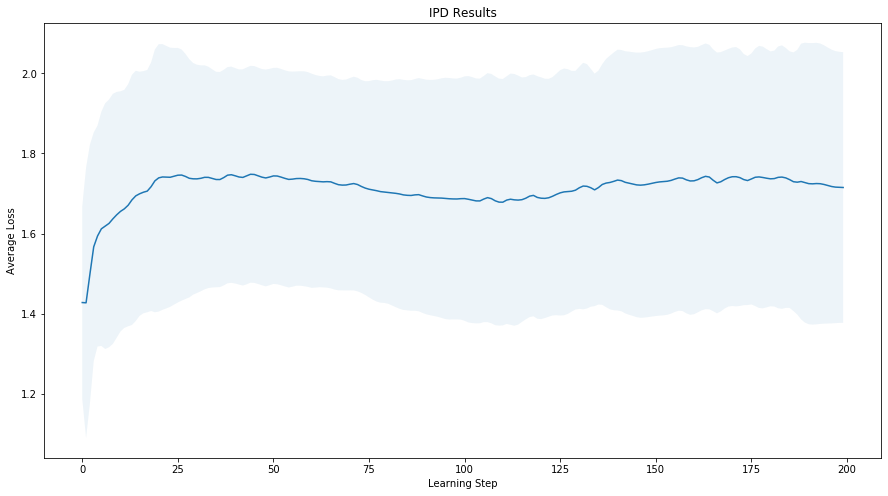

Jax time: 51.999622106552124
[1.42774579 1.40470939 1.40506553 1.42840649 1.44178944 1.44377246
 1.44204775 1.43596185 1.4328739  1.43508782 1.43640018 1.43700963
 1.4370595  1.43641581 1.43564025 1.4354873  1.43591013 1.43636059
 1.43647432 1.4362571  1.43595803 1.43585135 1.43600653 1.43624143
 1.43633188 1.43622837 1.43605812 1.43597932 1.43605037 1.43619331
 1.43627625 1.43623997 1.43613882 1.43607173 1.43609391 1.43617803
 1.43624785 1.43625037 1.43619851 1.43614866 1.43614583 1.43618914
 1.43623958 1.43625798 1.43623874 1.43620829 1.43619762 1.43621678
 1.43624918 1.43626985 1.43626826 1.43625342 1.43624398 1.43625149
 1.43627074 1.43628833 1.43629421 1.43628975 1.43628483 1.43628753
 1.43629874 1.43631188 1.43632027 1.43632166 1.4363204  1.43632272
 1.43632966 1.43633971 1.43634744 1.4363519  1.43635376 1.4363562
 1.43636174 1.43636876 1.43637629 1.4363814  1.43638535 1.43638884
 1.43639349 1.43639966 1.43640577 1.43641161 1.43641616 1.4364205
 1.43642511 1.43643053 1.43643645 1

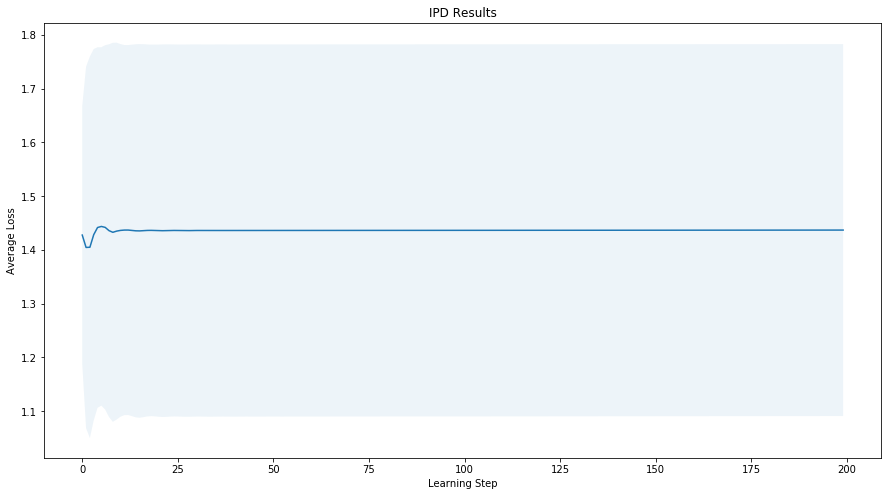

Jax time: 52.26166796684265
[1.42774579 1.42429901 1.47892564 1.49337104 1.47800269 1.47043617
 1.46728959 1.46159576 1.45938853 1.46201095 1.46380682 1.46183746
 1.45998501 1.46029974 1.46210702 1.46132801 1.45958899 1.45932678
 1.46084556 1.4612277  1.45977548 1.45895217 1.45979562 1.46084752
 1.46018521 1.459101   1.4592306  1.46025688 1.46038992 1.45951708
 1.45912962 1.45975533 1.46030645 1.45990437 1.45933055 1.45949953
 1.46007702 1.46010871 1.45963838 1.45948583 1.45986764 1.46013681
 1.45990545 1.45962905 1.45976693 1.46007386 1.46006777 1.45982701
 1.45978425 1.46000614 1.46013375 1.46000558 1.45988329 1.4599841
 1.46014595 1.46013227 1.46001511 1.46001875 1.46014795 1.46020931
 1.46014226 1.46009618 1.46016769 1.46025522 1.46024542 1.46019372
 1.46021419 1.46029183 1.46032351 1.46029257 1.46028261 1.4603341
 1.46038429 1.46038122 1.46036392 1.46038817 1.4604376  1.46045738
 1.46044732 1.46045424 1.46049227 1.46052434 1.46052764 1.46052748
 1.46055215 1.46058609 1.46060173 1.

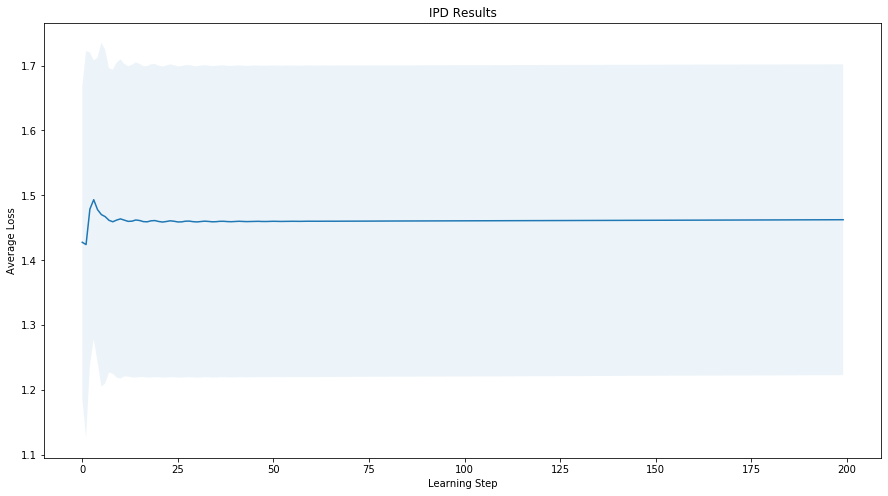

Jax time: 52.675392150878906
[1.42774579 1.57593309 1.82408808 1.88692752 1.92014764 1.93108055
 1.94537909 1.92738325 1.89379599 1.86825308 1.86978119 1.86747657
 1.86679923 1.86146097 1.84315122 1.83365601 1.83389497 1.83852232
 1.83470528 1.82981299 1.81594823 1.79977942 1.78863861 1.77961925
 1.77300317 1.76865461 1.76399179 1.75374886 1.74797877 1.74417139
 1.741687   1.74123497 1.74283851 1.74342876 1.74076578 1.74492157
 1.74991994 1.75126588 1.74453557 1.74126707 1.73811783 1.73671783
 1.73922476 1.74599617 1.74570041 1.74310649 1.73962229 1.73574417
 1.73463334 1.73916758 1.74114993 1.73920226 1.73541284 1.73001654
 1.72418235 1.72057381 1.72224316 1.72512198 1.73076544 1.74948962
 1.74527528 1.7368631  1.73638313 1.7330486  1.72868804 1.72867296
 1.73063976 1.73158293 1.72983233 1.72911662 1.7295172  1.73299213
 1.73789653 1.73618257 1.73388347 1.73080062 1.73065766 1.73243864
 1.73553165 1.73608097 1.73050568 1.72887022 1.7298214  1.73289916
 1.73947444 1.74637878 1.7441286 

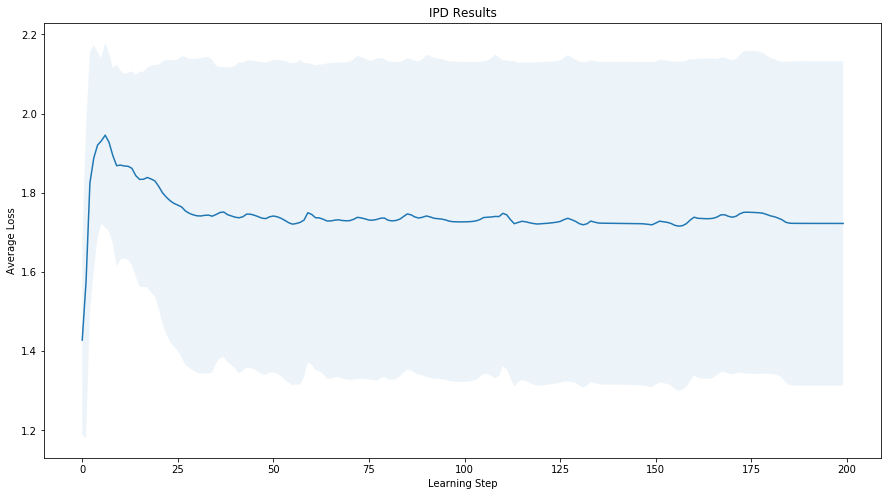

Jax time: 51.554808139801025
[1.42774579 1.4133618  1.43985196 1.48114934 1.49053311 1.49304216
 1.49433509 1.49578638 1.49738459 1.49930142 1.50256997 1.50797411
 1.51343366 1.51652626 1.51842444 1.52126973 1.52545765 1.5305531
 1.53527578 1.53869274 1.54116937 1.54389883 1.54758972 1.55195155
 1.55590389 1.55861583 1.5605881  1.56312622 1.56689903 1.57121525
 1.57444408 1.57604392 1.57755951 1.58062474 1.58529286 1.58945525
 1.59106283 1.59152504 1.59331129 1.59734498 1.60211856 1.60502955
 1.60565487 1.60644657 1.60914985 1.61331617 1.61698443 1.61873779
 1.61956514 1.62132571 1.62462306 1.6283156  1.63067276 1.63171047
 1.6329289  1.63542944 1.63898532 1.64196704 1.64333354 1.64414687
 1.64588464 1.64906353 1.65247557 1.65435072 1.65494836 1.65622616
 1.65937445 1.66260378 1.66416042 1.66459923 1.66542915 1.66982495
 1.67290096 1.67317786 1.67336523 1.67309583 1.67499219 1.67981251
 1.68117129 1.68106674 1.68040719 1.67965182 1.68093132 1.68453683
 1.68736866 1.68766779 1.68667982 

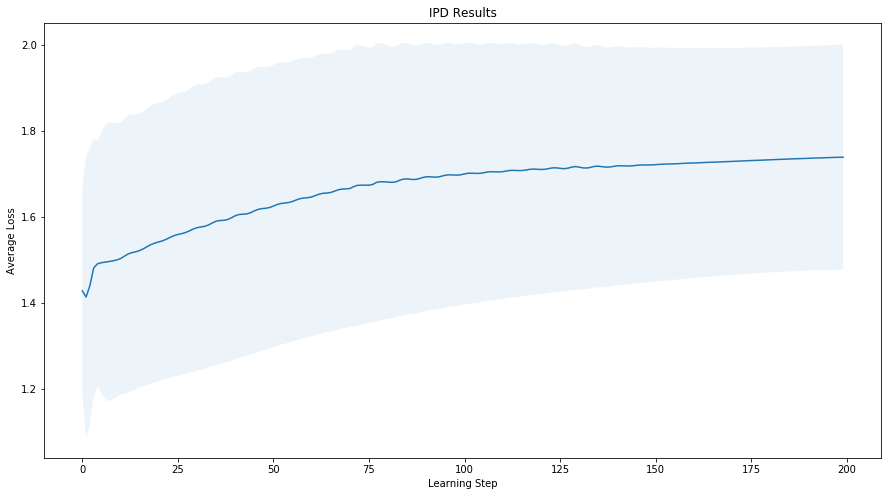

Jax time: 52.03630495071411
[1.42774579 1.40764145 1.41679008 1.44671044 1.45655079 1.45757281
 1.45334809 1.4473277  1.44725226 1.44918024 1.45029393 1.45119871
 1.45151934 1.45138309 1.45157104 1.45227232 1.45302674 1.45351467
 1.45380529 1.45412963 1.45466259 1.45534436 1.45594515 1.45634264
 1.4566398  1.45701866 1.45756427 1.45819795 1.4587663  1.45919848
 1.45956076 1.45997033 1.46048228 1.46105298 1.46159234 1.46205502
 1.46247228 1.46290958 1.46340105 1.46392801 1.46444348 1.46491987
 1.46537053 1.4658273  1.46631074 1.46681292 1.46731218 1.46779351
 1.46826119 1.46872974 1.4692102  1.46970055 1.4701906  1.47067258
 1.47114745 1.47162232 1.47210204 1.47258687 1.47307121 1.47355236
 1.47403037 1.47450753 1.47498728 1.47546876 1.47595011 1.47643068
 1.47690895 1.47738752 1.47786641 1.47834589 1.47882576 1.47930481
 1.47978289 1.48026097 1.48073889 1.48121714 1.48169532 1.48217314
 1.4826502  1.48312716 1.48360427 1.48408099 1.48455782 1.48503389
 1.48551    1.48598581 1.48646154 

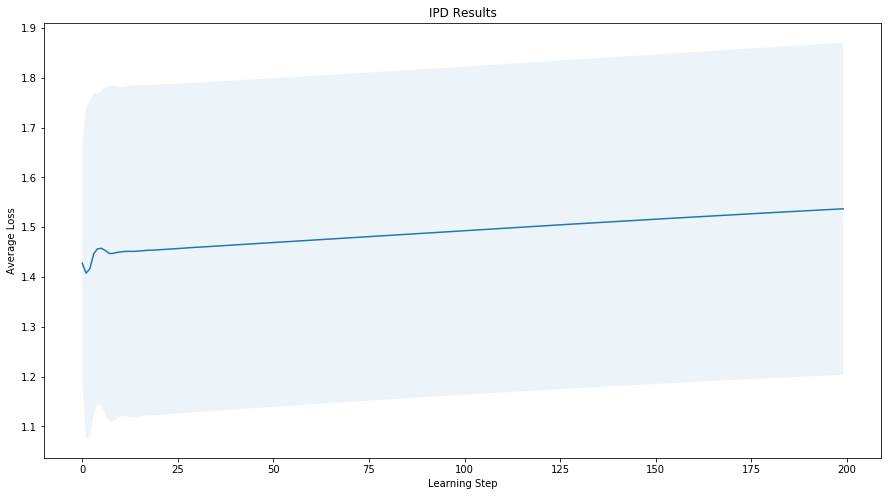

Jax time: 53.50603246688843
[1.42774579 1.43304415 1.50535813 1.56388114 1.58104008 1.59288359
 1.60700687 1.61787512 1.62660804 1.63465339 1.64534534 1.65839429
 1.66964077 1.67718491 1.68477753 1.69542592 1.69937305 1.70369708
 1.70720767 1.71011821 1.71514555 1.72044811 1.72397171 1.72659971
 1.7293363  1.73214437 1.73339675 1.73668314 1.73934571 1.740435
 1.74148651 1.74392659 1.74757026 1.75014508 1.75053494 1.74977736
 1.75010757 1.75243587 1.75489006 1.7552753  1.75378375 1.75247093
 1.75286255 1.75457208 1.75632715 1.75553614 1.75318487 1.75205403
 1.75264101 1.75470363 1.75465935 1.75176444 1.74953428 1.7493083
 1.75121082 1.75276979 1.75068944 1.74760933 1.74646376 1.74746837
 1.74965909 1.74922992 1.74553116 1.74274801 1.74252318 1.74450887
 1.74622226 1.74431665 1.74102287 1.73992471 1.74100408 1.74285231
 1.74223025 1.73835263 1.73591798 1.73663756 1.7393804  1.74113274
 1.73865511 1.7349831  1.73441695 1.73615418 1.73868969 1.73945151
 1.737002   1.73531934 1.7375479  1.7

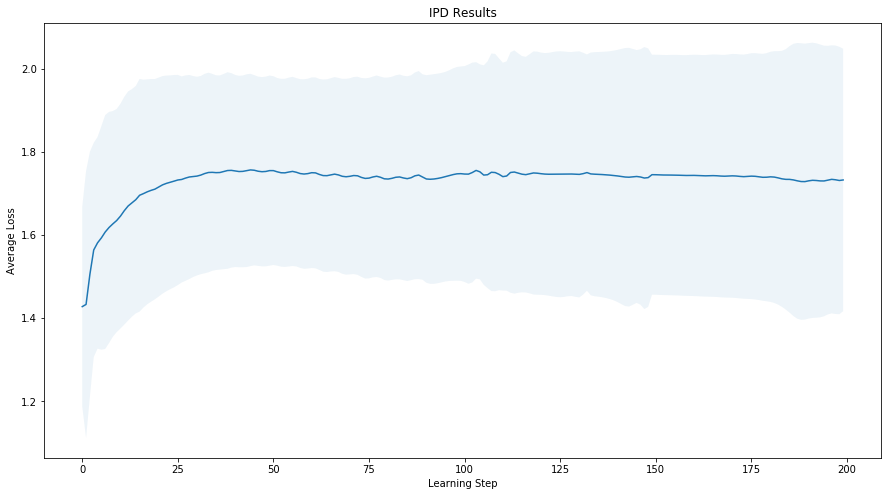

Jax time: 52.542707443237305
[1.42774579 1.40797091 1.41818394 1.45597119 1.47551772 1.48518218
 1.4897168  1.49002909 1.49114705 1.49526605 1.50087458 1.50678141
 1.51242894 1.51714801 1.52067954 1.52400398 1.52823015 1.53332519
 1.53880948 1.54394434 1.54807267 1.55135997 1.55475154 1.55878647
 1.56338493 1.56803413 1.57201266 1.57503421 1.57766727 1.58062714
 1.58419782 1.58813436 1.59177094 1.59453579 1.5966799  1.59905011
 1.6022345  1.60615056 1.61012277 1.61318958 1.61518206 1.61714988
 1.61994376 1.62359237 1.62751019 1.63050313 1.63207734 1.63347652
 1.63572764 1.63892418 1.64257081 1.64549417 1.64703776 1.64818583
 1.65002099 1.65282217 1.65620277 1.65905112 1.66058407 1.66154171
 1.66307468 1.66572716 1.66916314 1.67191358 1.67298564 1.67360068
 1.67505823 1.67800955 1.68194149 1.68407392 1.68446221 1.68507632
 1.68651078 1.68916974 1.69280454 1.69523177 1.69602001 1.69665634
 1.69785773 1.69978971 1.70236475 1.70475772 1.70600283 1.70651572
 1.70731652 1.70869781 1.71064736

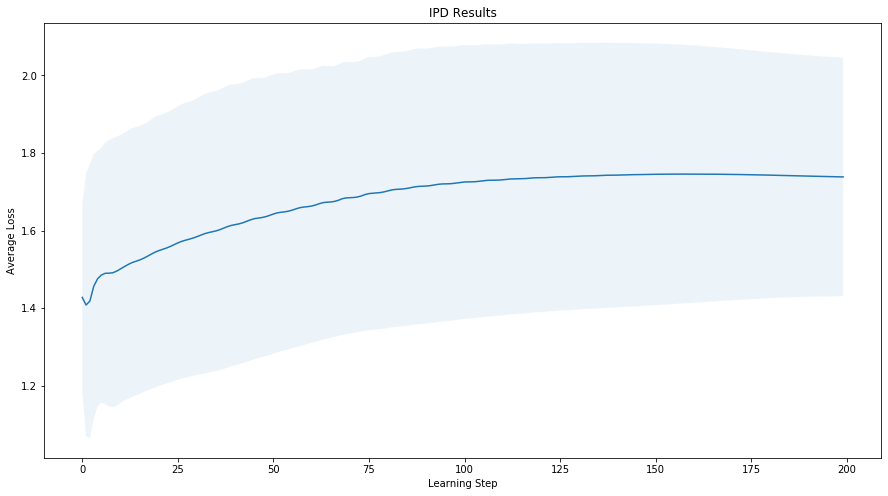

Jax time: 52.510698318481445
[1.42774579 1.42446393 1.47953536 1.49408752 1.47887798 1.47150385
 1.46861769 1.46306159 1.46093597 1.4636989  1.46571753 1.46392375
 1.46216398 1.46261359 1.46462253 1.46404734 1.46242227 1.46227123
 1.4639699  1.46456132 1.46326075 1.46253857 1.46353523 1.46478596
 1.46430057 1.46333252 1.46359034 1.46479836 1.46511848 1.46438582
 1.46411717 1.464903   1.46564007 1.46539754 1.46494818 1.46526005
 1.4660144  1.46621609 1.46588374 1.46586524 1.46641082 1.46685313
 1.4667718  1.46662924 1.46691945 1.4673975  1.46755001 1.46744792
 1.46755036 1.46793722 1.46822862 1.46824552 1.46826455 1.46852375
 1.46885129 1.46898924 1.46901322 1.46916832 1.46946193 1.46968047
 1.46975712 1.46985736 1.47008962 1.47033834 1.47047661 1.47056842
 1.47074422 1.47098427 1.47116951 1.47128176 1.47142214 1.47163417
 1.47184234 1.47198565 1.47211417 1.47229582 1.47250556 1.47267607
 1.4728107  1.47296975 1.47316768 1.47335463 1.47350415 1.47365231
 1.47383388 1.474026   1.47419089

Jax time: 53.02513074874878
[1.42774579 1.43013122 1.50803864 1.57189007 1.59419065 1.60932207
 1.61712316 1.62521624 1.63595275 1.6437514  1.65068909 1.66041794
 1.67275334 1.68170059 1.68636218 1.68965334 1.70035369 1.71456932
 1.72389727 1.72880442 1.73123338 1.73190668 1.73250244 1.73425545
 1.73705195 1.74036092 1.74053055 1.73639483 1.7348568  1.73779157
 1.74454437 1.74764818 1.74436296 1.74044554 1.74052596 1.74446613
 1.74987682 1.75123304 1.74828758 1.74508532 1.74382724 1.7466442
 1.75040082 1.75029013 1.7477334  1.74394454 1.7414204  1.74328967
 1.74599334 1.74666285 1.74517687 1.74051996 1.73695104 1.73853053
 1.7405727  1.74186594 1.73980904 1.73413381 1.72972591 1.73034949
 1.73450324 1.73740651 1.73526955 1.73074548 1.72811551 1.72920346
 1.73166073 1.73144915 1.72713391 1.72348154 1.72184231 1.72183568
 1.72332216 1.72255003 1.71990718 1.71837744 1.71672664 1.71595726
 1.71614908 1.71536001 1.71353399 1.7115978  1.71047109 1.7100392
 1.70970379 1.70964527 1.70930324 1.

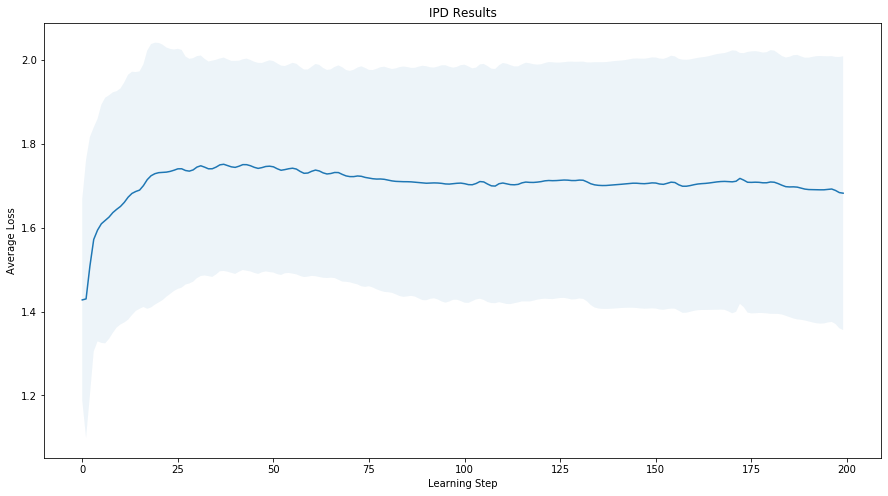

Jax time: 52.58957266807556
[1.42774579 1.5612747  1.81350637 1.87944562 1.87875377 1.90512802
 1.92655975 1.97284356 1.94476954 1.92440252 1.90962264 1.87838454
 1.84707921 1.86656699 1.86128064 1.85197584 1.8217887  1.80766616
 1.79280475 1.78542788 1.77545001 1.76703783 1.75746211 1.77817739
 1.79365621 1.79245896 1.77994645 1.78567121 1.79101443 1.79470337
 1.79528234 1.7886033  1.77765223 1.77031371 1.76707181 1.77221774
 1.7785908  1.77398629 1.77171425 1.77899464 1.79124771 1.80033852
 1.8107224  1.8205645  1.82487604 1.82430699 1.82679639 1.82995704
 1.83142986 1.82194963 1.80966609 1.80022655 1.79891601 1.79744031
 1.79548738 1.79165205 1.7873799  1.78638485 1.78607038 1.78591672
 1.78583799 1.78580024 1.78578014 1.78576236 1.78573984 1.78570825
 1.78566645 1.78561339 1.78554822 1.78547055 1.78537902 1.78527334
 1.78515072 1.78500939 1.78485091 1.78469804 1.78465427 1.78493887
 1.78522158 1.78492225 1.78465916 1.78447694 1.78432828 1.78419854
 1.78408108 1.78397554 1.78388158 

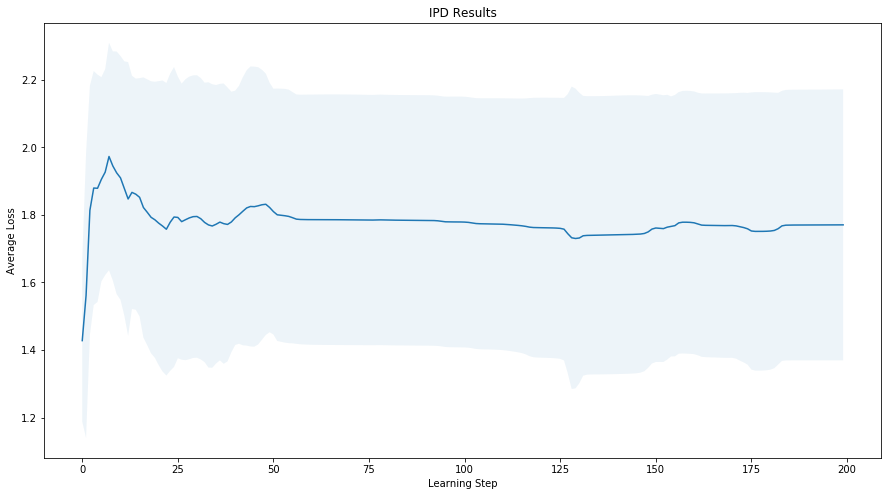

Jax time: 52.283344984054565
[1.42774579 1.46091568 1.59963595 1.64108711 1.65074185 1.64349154
 1.65772857 1.67050531 1.67852606 1.68721267 1.69745776 1.71007602
 1.72238438 1.72694818 1.72545105 1.73680443 1.74582995 1.74183147
 1.72964692 1.72869954 1.7442652  1.74545949 1.74490716 1.7367044
 1.72542225 1.73184861 1.73635288 1.73458609 1.73222116 1.73603506
 1.7439333  1.74181787 1.73767612 1.74021861 1.746821   1.74621152
 1.7354948  1.72961306 1.73013262 1.73573256 1.74142358 1.73640451
 1.7324262  1.7354049  1.74802278 1.75999885 1.75629875 1.75081546
 1.75319731 1.7689274  1.77254747 1.76619709 1.76118515 1.75835767
 1.76513577 1.773211   1.76215844 1.74767044 1.74102395 1.73571617
 1.73011293 1.7260295  1.73049956 1.73514246 1.73075899 1.72952263
 1.72784544 1.72869575 1.72895835 1.73289809 1.73560316 1.7281317
 1.71552733 1.71494873 1.71258185 1.70992486 1.71061606 1.71619993
 1.72283017 1.7210157  1.71321584 1.71341659 1.72409463 1.73268328
 1.7235818  1.70486975 1.703154   1

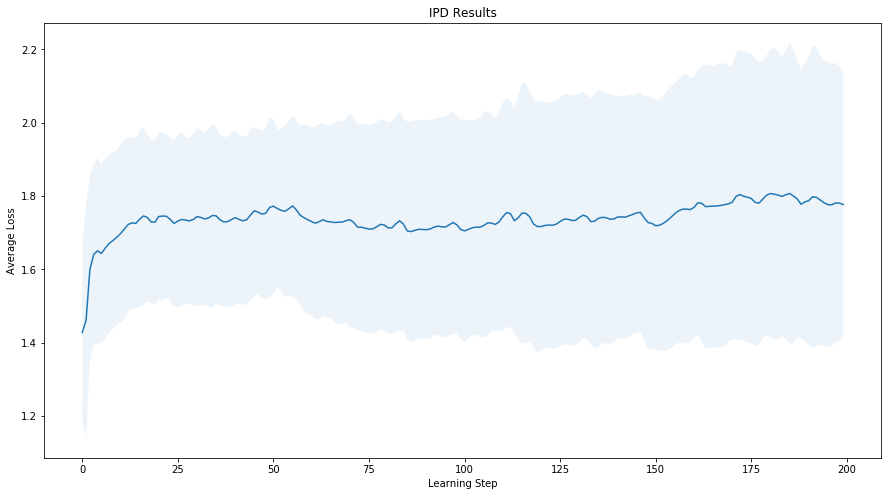

Jax time: 52.09993553161621
[1.42774579 1.42431739 1.47898015 1.49344229 1.47809393 1.47055096
 1.46742972 1.46175073 1.45955383 1.46219239 1.4640123  1.46206243
 1.46022071 1.46055075 1.46238051 1.46162449 1.45989781 1.45964803
 1.46118708 1.4615928  1.4601574  1.45934475 1.46020521 1.46128013
 1.46063734 1.45956518 1.45970888 1.46075616 1.46091063 1.46005251
 1.4596773  1.46032174 1.46089455 1.46050984 1.4599487  1.46013354
 1.46073196 1.46078265 1.46032706 1.46018889 1.46058906 1.46087863
 1.46066369 1.46040136 1.46055617 1.46088297 1.460895   1.46066914
 1.46064186 1.46088284 1.46102882 1.46091678 1.4608099  1.46092828
 1.46110919 1.46111274 1.46101085 1.46103124 1.461179   1.46125815
 1.46120695 1.46117698 1.46126661 1.46137207 1.46137918 1.46134335
 1.46138091 1.46147675 1.46152601 1.46151077 1.46151802 1.46158707
 1.46165509 1.46166864 1.46166756 1.46170933 1.46177683 1.46181369
 1.46181969 1.46184348 1.46189914 1.4619487  1.46196855 1.46198521
 1.46202709 1.46207896 1.46211154 

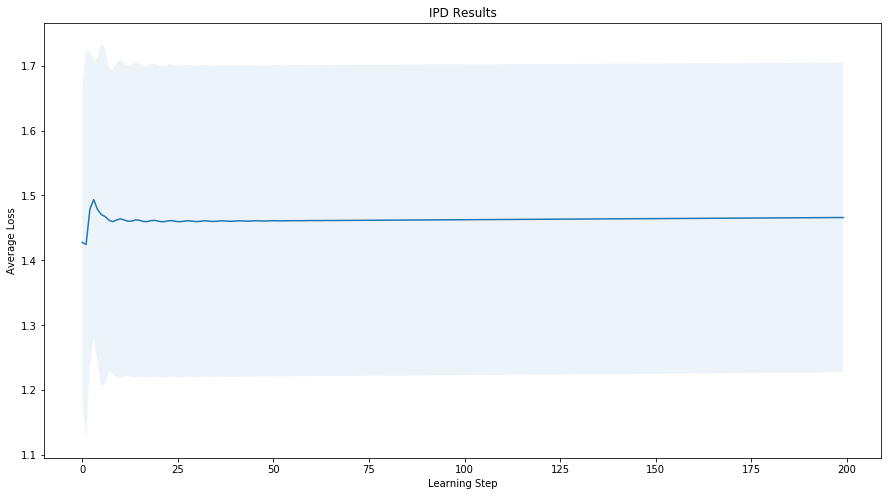

Jax time: 52.253981590270996
[1.42774579 1.42995847 1.49568786 1.55933178 1.58251233 1.5959054
 1.6081699  1.62004252 1.6311483  1.64018498 1.64961314 1.66104695
 1.67408326 1.68484099 1.69132884 1.69682274 1.70460913 1.71534493
 1.71747219 1.71937042 1.72187148 1.72519387 1.72823558 1.73074898
 1.7334565  1.73550995 1.73795373 1.73887812 1.73977386 1.74102752
 1.74171171 1.74244337 1.74415223 1.74730244 1.75029376 1.7511853
 1.75107206 1.75081798 1.75172391 1.75398816 1.75581482 1.75563693
 1.75421505 1.75292428 1.75313425 1.75471192 1.75619062 1.75549627
 1.75312516 1.75129929 1.75112061 1.75251429 1.75377532 1.75196863
 1.7485137  1.74643324 1.74638066 1.7482239  1.75027566 1.7487643
 1.74468764 1.74184834 1.7409887  1.74182954 1.74310911 1.7421996
 1.73907772 1.73720094 1.73801849 1.74065467 1.74160317 1.73755902
 1.73241023 1.72981035 1.72873018 1.72867123 1.72920858 1.73010308
 1.73110283 1.73167549 1.73135062 1.73060034 1.73083827 1.73252107
 1.73333234 1.73035477 1.72562301 1.7

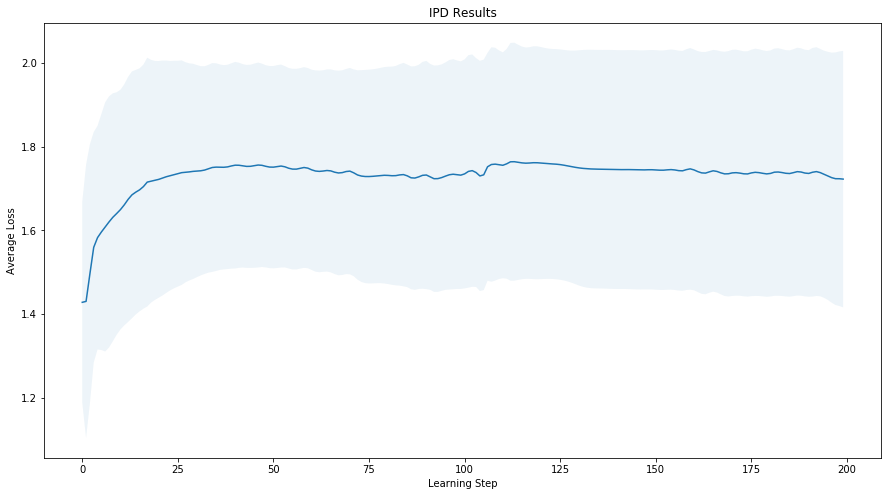

Jax time: 52.1675066947937
[1.42774579 1.42149332 1.46938583 1.49193746 1.47864382 1.47197583
 1.46879971 1.4625092  1.45918093 1.46150474 1.46524377 1.4647634
 1.4623349  1.46134383 1.46304489 1.46449233 1.46356669 1.46226193
 1.46254021 1.46420154 1.46454368 1.46347203 1.46289128 1.46385264
 1.46503465 1.46475464 1.46387217 1.46392725 1.46505556 1.46566257
 1.46512893 1.46461271 1.46510554 1.46606279 1.46621794 1.46569314
 1.46556911 1.46625572 1.46690655 1.46679748 1.46643469 1.46662542
 1.46730306 1.46765621 1.46745461 1.46731153 1.46769114 1.4682409
 1.4683776  1.4682061  1.46826821 1.46871295 1.46909806 1.46911676
 1.46904206 1.469254   1.46967228 1.46991163 1.46989771 1.46993826
 1.47023047 1.47057541 1.47071493 1.47072602 1.47086678 1.47117765
 1.47143977 1.47152957 1.47159432 1.4718022  1.47209176 1.47228482
 1.47236618 1.47248888 1.47272834 1.472978   1.47312674 1.47322594
 1.47339528 1.47363759 1.47384618 1.47397589 1.4741039  1.47430176
 1.47452975 1.47470667 1.47483606 1.4

Jax time: 53.11593985557556
[1.42774579 1.55920062 1.80791731 1.84401112 1.89068786 1.89937975
 1.9197599  1.89234537 1.90549013 1.89202309 1.88638103 1.87546288
 1.87715319 1.87479107 1.87324544 1.85680197 1.83566599 1.84430215
 1.85402048 1.84925665 1.84518914 1.84433388 1.83947372 1.82808548
 1.82414972 1.8222438  1.8129738  1.81067281 1.81382584 1.82324826
 1.82855195 1.82997619 1.83271403 1.83281032 1.8304064  1.82594126
 1.82006757 1.81643106 1.81611698 1.8124047  1.81039634 1.81450015
 1.81758184 1.80979655 1.80616643 1.80649823 1.80912455 1.80279484
 1.79960837 1.80304282 1.79840258 1.7891501  1.77961042 1.76673232
 1.76224832 1.75927446 1.75736417 1.75491071 1.75179771 1.74744151
 1.74329093 1.74261499 1.74551094 1.7483413  1.74481565 1.74530792
 1.74437462 1.74177044 1.73684847 1.72656564 1.72789967 1.72684665
 1.72141776 1.7178827  1.71771086 1.72043044 1.72390604 1.72940808
 1.72565671 1.72479586 1.72353387 1.71367589 1.70847911 1.70867372
 1.71050673 1.717382   1.74022691 

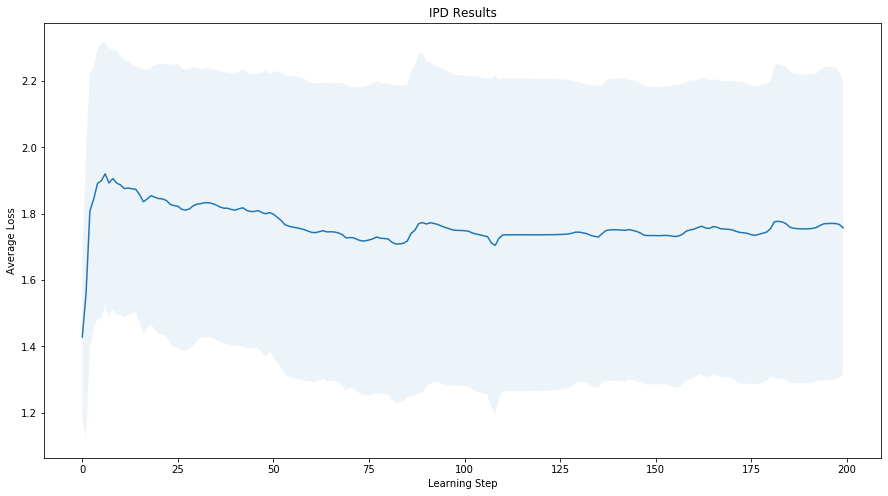

Jax time: 52.21469473838806
[1.42774579 1.41727248 1.45449271 1.48933874 1.48426196 1.48195523
 1.4819612  1.47918753 1.47517006 1.47466431 1.47894033 1.48386552
 1.48562248 1.48534768 1.48563541 1.48796674 1.49136081 1.49374289
 1.49476597 1.4956435  1.49748952 1.50006489 1.50228334 1.50373414
 1.50498845 1.50672685 1.50890071 1.51091683 1.51248558 1.51390358
 1.5155861  1.51753781 1.51941081 1.52100229 1.52247417 1.5240974
 1.52590155 1.52767105 1.52924823 1.53072034 1.5322839  1.53398765
 1.53568369 1.53722808 1.5386662  1.54017328 1.54182238 1.54347949
 1.54497428 1.54633861 1.5477939  1.5494505  1.55111419 1.55251423
 1.55372337 1.55514452 1.55694208 1.5586685  1.55980626 1.56067138
 1.56216947 1.56445247 1.56623784 1.56658    1.56673872 1.56864432
 1.57194092 1.57353938 1.57251465 1.57190808 1.57387467 1.5770193
 1.57901066 1.57910258 1.57917073 1.58059134 1.58280529 1.58464655
 1.58558896 1.58626684 1.58748932 1.58923223 1.59085701 1.59194392
 1.5928061  1.59402641 1.59564894 1.

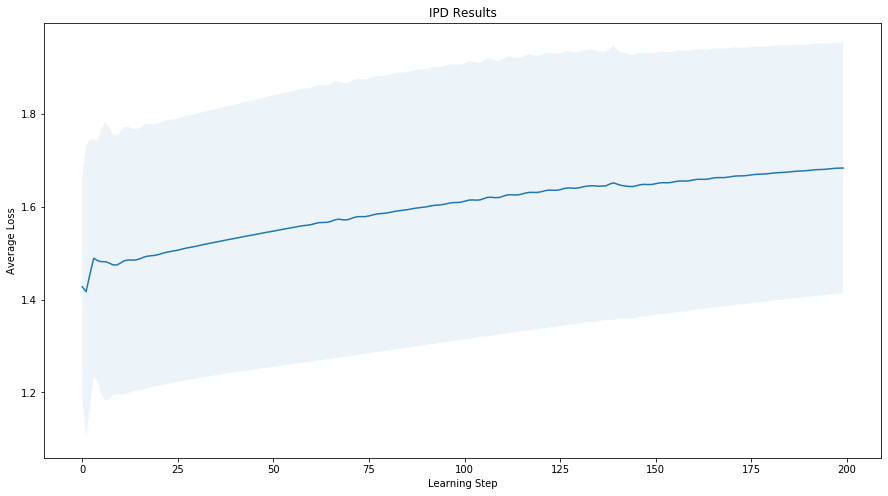

Jax time: 52.44004583358765
[1.42774579 1.66078611 1.87996569 1.92635992 1.99470279 2.01698445
 2.00758184 1.99720562 1.98652783 1.96611578 1.97158869 1.98664384
 1.99038601 1.99545565 1.99339873 1.97204833 1.96461662 1.96142524
 1.95787928 1.96187541 1.96353974 1.96605208 1.95296902 1.94493624
 1.94442413 1.95565818 1.95704959 1.94012594 1.93549228 1.92184188
 1.90807968 1.89844146 1.8999919  1.90890911 1.91639906 1.9186273
 1.92834429 1.9325792  1.93236206 1.93209371 1.93192873 1.93185103
 1.93185616 1.93198963 1.93253718 1.93858646 1.94140308 1.94154247
 1.94161218 1.94168723 1.94174756 1.94175258 1.94159724 1.94077774
 1.9364361  1.93311923 1.93327945 1.93360302 1.93403208 1.93465728
 1.93584901 1.93971866 1.95200758 1.95433615 1.95464199 1.95477668
 1.95484761 1.95487897 1.95487904 1.95485046 1.95478973 1.95468646
 1.9545181  1.95423549 1.95371621 1.95272011 1.95151694 1.95094172
 1.95065806 1.95039634 1.94999405 1.94895159 1.94365618 1.93139086
 1.93045096 1.93018333 1.92982264 1

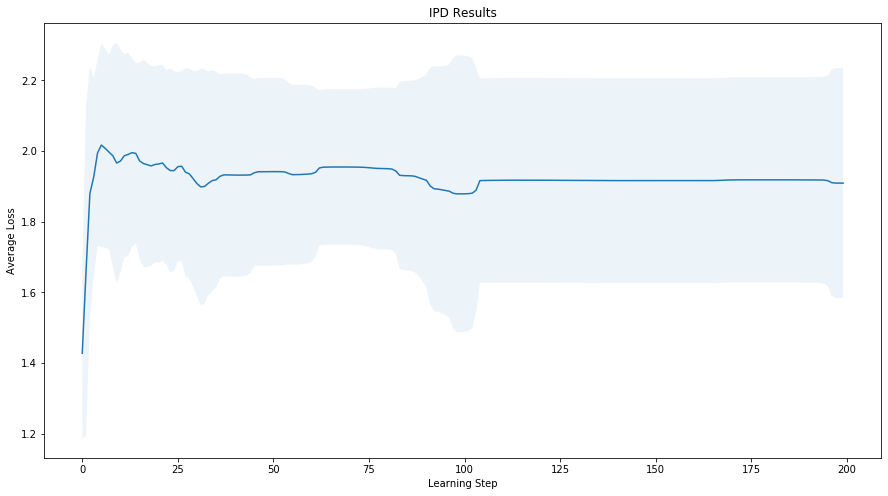

Jax time: 52.18353724479675
[1.42774579 1.71307428 1.91212628 1.94704714 1.94939335 1.95021923
 1.95451174 1.95571713 1.96617304 1.96168085 1.96457201 1.96341632
 1.9638673  1.96365587 1.96210271 1.9572286  1.94924617 1.9526353
 1.9507649  1.94920676 1.94879522 1.95090125 1.9520969  1.95260633
 1.95293022 1.95319041 1.95339169 1.9535087  1.95354174 1.9537922
 1.95553898 1.95533636 1.95524349 1.95537369 1.95553958 1.95571518
 1.95589509 1.95607964 1.95626607 1.95645376 1.95663622 1.95680929
 1.95696985 1.95711495 1.95724611 1.95736307 1.95746762 1.95756156
 1.95764743 1.95772563 1.95779763 1.9578632  1.95792526 1.9579823
 1.95803561 1.95808621 1.95813357 1.9581782  1.9582206  1.95826145
 1.95830003 1.958336   1.9583711  1.95840397 1.95843629 1.95846655
 1.95849625 1.95852407 1.95855123 1.95857769 1.95860251 1.95862675
 1.95864994 1.95867275 1.95869446 1.95871626 1.95873629 1.95875574
 1.95877476 1.95879303 1.95881172 1.95882899 1.95884608 1.95886256
 1.9588785  1.95889371 1.95890912 1.9

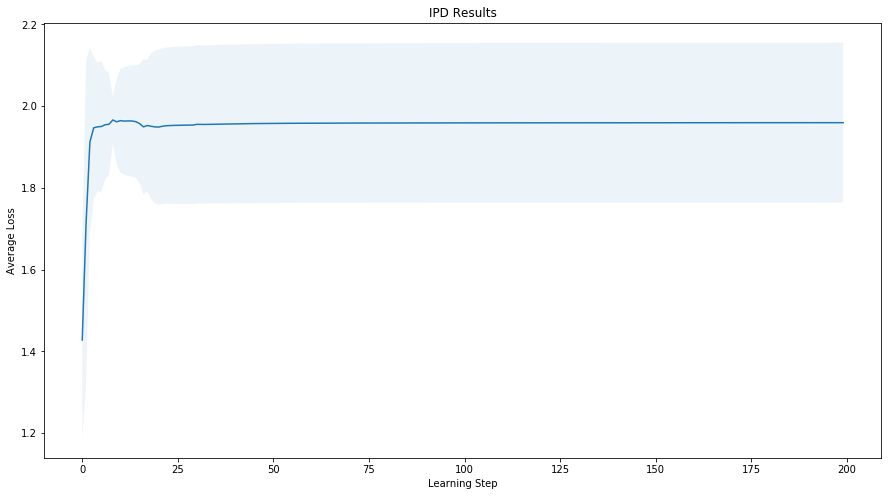

Jax time: 51.83561134338379
[1.42774579 1.58928871 1.85483749 1.83795007 1.83987515 1.90371112
 1.9481126  1.94941186 1.93278156 1.92612243 1.91877836 1.91374593
 1.91101227 1.91442045 1.93424739 1.93442826 1.92711715 1.9518245
 1.95606076 1.9405459  1.92555198 1.90595123 1.9094631  1.90523901
 1.91478394 1.92840556 1.94297044 1.96480056 1.97702231 1.97454707
 1.96990079 1.96610468 1.96331261 1.95806166 1.95453993 1.9535471
 1.95289522 1.94001609 1.94300909 1.95183202 1.96364561 1.97499718
 1.99441171 1.98825417 1.98679581 1.99537139 1.99190629 1.98900037
 1.98928715 1.99009458 1.99278    2.00309471 2.00629963 2.00410123
 1.99787875 1.9919613  1.99250609 1.99905482 1.99949934 1.99903464
 2.00138591 2.00167158 2.00167012 2.00166721 2.00168253 2.00172148
 2.00178591 2.00188314 2.00202281 2.00221674 2.00248489 2.00287007
 2.00356312 2.0057663  2.02233407 2.03960135 2.03646739 2.03149272
 2.03130663 2.03118219 2.03056213 2.02716037 2.02242285 2.02234737
 2.02235729 2.02233673 2.02228935 2.

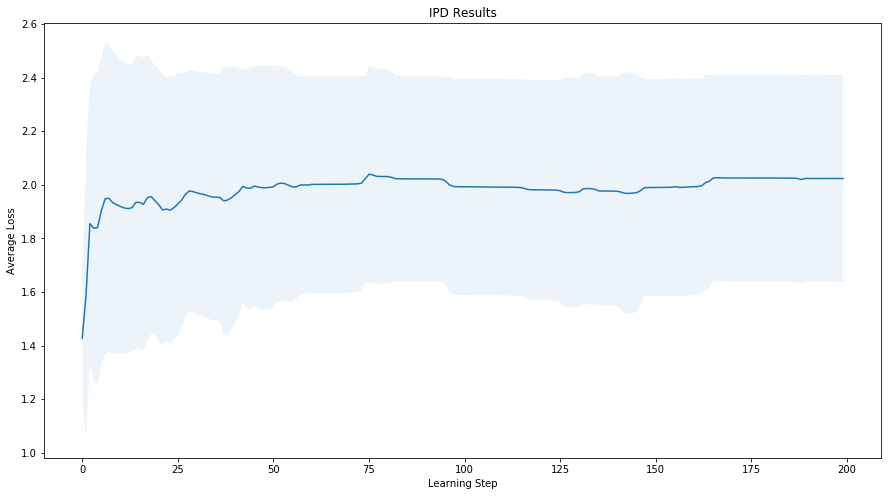

Jax time: 52.009674072265625
[1.42774579 1.43934852 1.52382357 1.56681748 1.57500382 1.58474432
 1.59944147 1.60741626 1.61480822 1.62591296 1.63912456 1.64807832
 1.65508235 1.66681091 1.67820657 1.68221875 1.68288367 1.68494606
 1.68895156 1.69563625 1.70303677 1.70880702 1.71198759 1.71493906
 1.71889758 1.7245183  1.73054553 1.73384215 1.73476328 1.73701753
 1.74146284 1.74725666 1.74918766 1.74991634 1.75161573 1.75414822
 1.75682399 1.75673685 1.75773309 1.75918023 1.75864581 1.75821518
 1.76036697 1.76275478 1.7594014  1.75587535 1.75280327 1.75107635
 1.75210034 1.75354395 1.75312497 1.75156118 1.75118135 1.75226535
 1.75353244 1.75372588 1.75278678 1.75282078 1.75368465 1.7551412
 1.75574342 1.75520871 1.75536249 1.75625401 1.75804094 1.75865738
 1.75815631 1.75825858 1.75939024 1.76143117 1.76186533 1.76123129
 1.76130705 1.76271688 1.76474767 1.76460679 1.76337229 1.76309186
 1.76441788 1.76623146 1.76537087 1.76350103 1.76307154 1.76445484
 1.76646114 1.76547842 1.76257374 

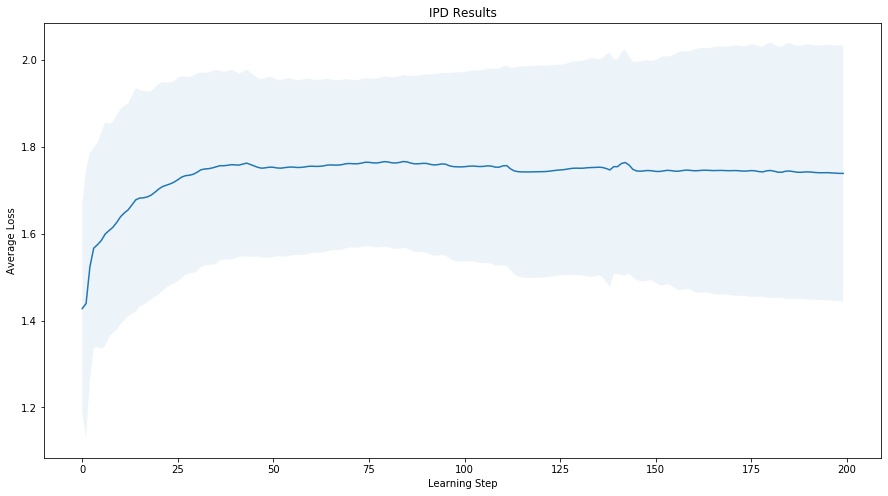

Jax time: 52.92580246925354
[1.42774579 1.54938959 1.79746763 1.80860063 1.84113997 1.87088079
 1.85144192 1.87422929 1.89884241 1.89722371 1.90572457 1.91786715
 1.90751216 1.88611604 1.87817176 1.86684381 1.84600766 1.84109524
 1.83996123 1.82463152 1.8133543  1.80655397 1.79895012 1.78223679
 1.77231835 1.7771397  1.79660705 1.81135334 1.81193053 1.81274676
 1.81711922 1.82243134 1.81503441 1.79380141 1.79072541 1.79535173
 1.79135297 1.7952536  1.79594121 1.80620115 1.81227892 1.81296154
 1.82212858 1.81893156 1.80793348 1.80437259 1.80554483 1.80658552
 1.80957381 1.81807943 1.82563365 1.83241585 1.83217988 1.82712834
 1.82481393 1.8236419  1.82471506 1.82212842 1.81383003 1.80300493
 1.79832382 1.79335405 1.79087862 1.79587816 1.7987937  1.80615386
 1.80878135 1.80715926 1.80258137 1.80063003 1.80908552 1.80545096
 1.80342875 1.80278583 1.80969317 1.80406733 1.80320655 1.80309119
 1.80289135 1.80271163 1.80257978 1.80248322 1.80240448 1.80233537
 1.80227143 1.80221429 1.8021673  

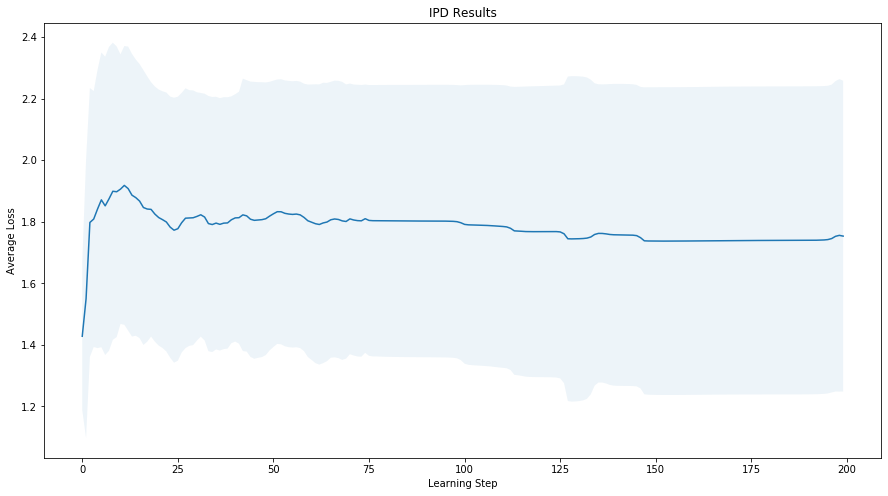

Jax time: 52.366570472717285
[1.42774579 1.42428448 1.47888209 1.49331406 1.47792954 1.47034441
 1.46717719 1.46147178 1.45925643 1.46186536 1.46364252 1.46165746
 1.4597965  1.46009899 1.46188827 1.46109101 1.45934144 1.45906985
 1.46057251 1.46093552 1.45947019 1.45863829 1.4594676  1.46050124
 1.45982328 1.4587294  1.45884766 1.45985704 1.45997302 1.45908825
 1.45869091 1.459302   1.45983586 1.45941982 1.45883536 1.45899214
 1.45955311 1.45956938 1.45908759 1.45892338 1.45929011 1.45954305
 1.45929864 1.45901065 1.45913489 1.45942625 1.45940588 1.45915291
 1.45909773 1.45930447 1.45941702 1.45927621 1.45914167 1.45922839
 1.45937507 1.45934752 1.45921816 1.45920844 1.45932277 1.45936982
 1.4592898  1.45923094 1.45928818 1.45936085 1.45933803 1.45927377
 1.45928012 1.45934303 1.45936129 1.4593172  1.45929382 1.4593312
 1.459367   1.45935058 1.45932029 1.45933091 1.45936588 1.45937207
 1.45934886 1.45934234 1.45936582 1.45938395 1.45937385 1.45936046
 1.45937104 1.45939114 1.45939318 

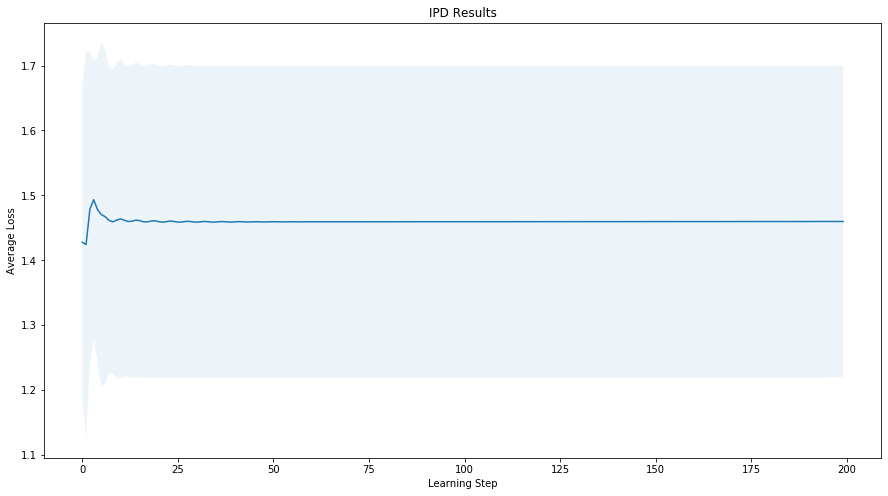

Jax time: 52.459850788116455
[1.42774579 1.40502908 1.40616137 1.43066696 1.44473795 1.44745299
 1.44640773 1.44101377 1.43838522 1.44096113 1.44280196 1.44411374
 1.44494257 1.44504337 1.44482165 1.44499273 1.44568617 1.44653361
 1.44722182 1.44769363 1.44806564 1.44849607 1.44905272 1.44966444
 1.45021686 1.45068192 1.45112485 1.45161855 1.45218022 1.4527634
 1.45330593 1.4537888  1.45424991 1.45473985 1.45527868 1.45584163
 1.45638899 1.45689874 1.45738381 1.45787554 1.45839385 1.45893416
 1.45947473 1.45999748 1.46050292 1.46100455 1.46151663 1.46204187
 1.46257205 1.46309644 1.46361183 1.46412201 1.46463478 1.46515391
 1.46567683 1.46619886 1.46671658 1.46723157 1.46774644 1.46826421
 1.46878318 1.46930273 1.46982026 1.47033621 1.47085245 1.47136964
 1.47188714 1.47240478 1.47292145 1.47343742 1.4739532  1.47446993
 1.47498699 1.47550293 1.47601897 1.47653383 1.47704932 1.47756471
 1.47808046 1.47859591 1.4791107  1.47962489 1.48013898 1.48065344
 1.48116792 1.48168236 1.4821958  

Jax time: 52.37943434715271
[1.42774579 1.60037046 1.86009649 1.83219803 1.86222172 1.92709128
 1.94043604 1.94030387 1.93202842 1.95221465 1.95539245 1.9491649
 1.93853408 1.95198537 1.95309452 1.940543   1.93475679 1.95137563
 1.96214033 1.96755396 1.97939044 1.9835063  1.98781106 1.98114065
 1.95694927 1.95438343 1.97024593 1.98847633 1.99935289 1.99669212
 1.99101862 1.98796657 1.97734144 1.96719868 1.96397051 1.95937136
 1.96848197 1.97429948 1.97241436 1.9816896  1.98576068 1.98341877
 1.97819791 1.97414967 1.97549381 1.98566511 1.98340062 1.97273386
 1.970787   1.96846765 1.96805598 1.96791565 1.96766069 1.96681965
 1.96247053 1.94522427 1.94208159 1.94150412 1.94118259 1.94076593
 1.93952316 1.9361212  1.93443799 1.93440293 1.94104338 1.94798903
 1.94801685 1.94800488 1.94800127 1.94800062 1.94799442 1.94795743
 1.94776939 1.94687079 1.95118229 1.95312413 1.94818655 1.94710764
 1.95106234 1.96231761 1.96615449 1.96651634 1.96652547 1.96535372
 1.97119214 1.97681623 1.97843483 1

Jax time: 52.14950752258301
[1.42774579 1.58036026 1.82635752 1.88622202 1.92009585 1.92799021
 1.93647889 1.91139421 1.88661718 1.87352257 1.86683941 1.86256542
 1.8588924  1.85736243 1.86059821 1.86563915 1.86110415 1.84705033
 1.83461903 1.82675409 1.82349962 1.81397854 1.80509924 1.7975732
 1.79487369 1.79092667 1.78322179 1.77549656 1.77262846 1.77158944
 1.77526751 1.77738046 1.78077057 1.79319877 1.78466629 1.77518284
 1.76844933 1.76532903 1.7634306  1.76251038 1.76296912 1.76499636
 1.76896619 1.77178213 1.76798974 1.76662902 1.76370713 1.75950817
 1.7565514  1.75647476 1.76040481 1.76860145 1.77566301 1.78261968
 1.78348954 1.77918674 1.77479179 1.77104824 1.76733194 1.76412867
 1.76294517 1.76273149 1.75999223 1.75230335 1.74206869 1.76667016
 1.77339259 1.77340688 1.77376476 1.77519459 1.7703266  1.76430683
 1.75811906 1.75463031 1.75499345 1.75633326 1.76005777 1.77560567
 1.7875214  1.77926445 1.77000441 1.76633179 1.76348439 1.76190913
 1.76179236 1.76272237 1.76530114 1

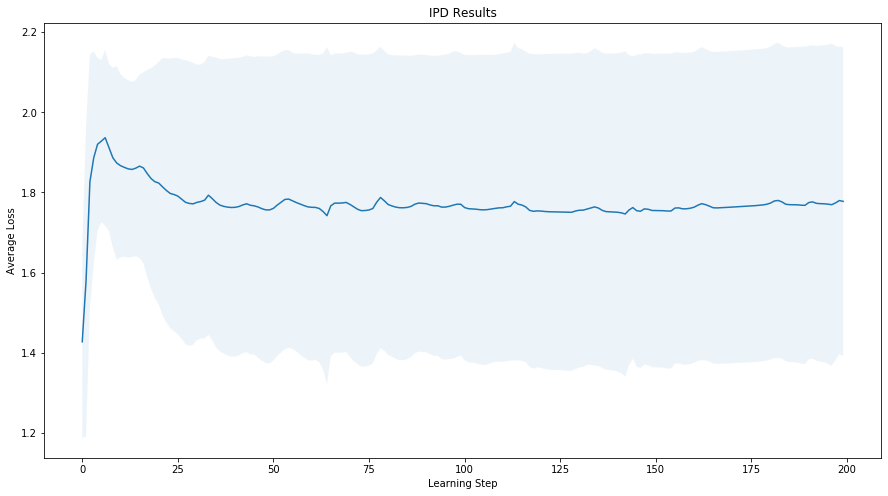

Jax time: 52.40055298805237
[1.42774579 1.45108372 1.5804264  1.65382431 1.6791639  1.69112621
 1.70095103 1.7013153  1.70699713 1.70632619 1.7049042  1.71125518
 1.7205361  1.72707143 1.73294588 1.73289665 1.73568918 1.74196768
 1.74975704 1.75115103 1.75052828 1.74955377 1.75359939 1.75458509
 1.75327086 1.7502792  1.74654589 1.74442854 1.74245102 1.74160262
 1.74531059 1.74519885 1.74134723 1.73366286 1.72732862 1.73289397
 1.7371905  1.73604801 1.73735915 1.73887937 1.74180825 1.74436435
 1.73811144 1.72860125 1.72314097 1.71978699 1.71947665 1.72055105
 1.71862984 1.71578603 1.71370452 1.7102468  1.70862128 1.70623997
 1.70725615 1.70616279 1.70172257 1.70102591 1.70115319 1.69940914
 1.69857014 1.70296777 1.70502984 1.70626233 1.70741273 1.6988835
 1.68922055 1.68690083 1.68601414 1.68155432 1.67607207 1.67340084
 1.67336997 1.67669234 1.68313694 1.68652663 1.68335914 1.67562846
 1.67500708 1.68051064 1.68998538 1.69689329 1.70257927 1.70731228
 1.70896828 1.70750586 1.70972796 1

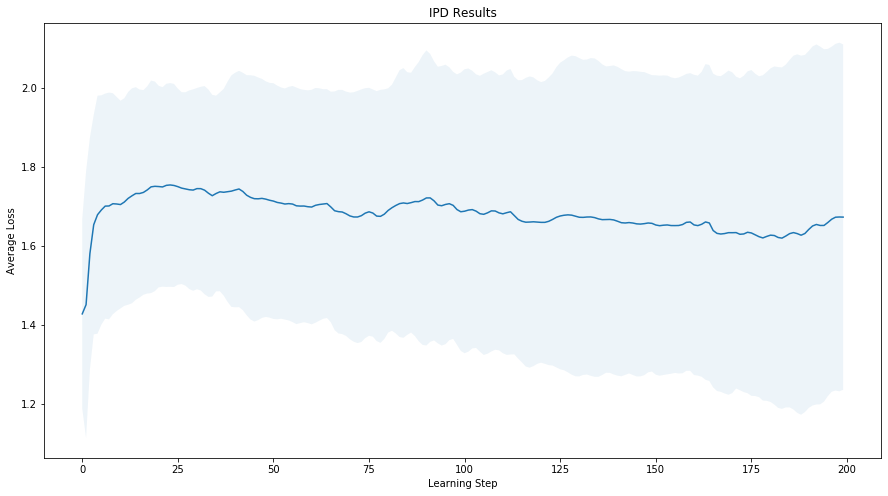

Jax time: 52.726053953170776
[1.42774579 1.45436552 1.58720476 1.6507364  1.67129163 1.67407951
 1.67743303 1.69307041 1.70052854 1.69725599 1.70235501 1.71161253
 1.72086896 1.72856369 1.73599706 1.73073904 1.72982448 1.73994165
 1.74295221 1.73829389 1.73163697 1.73842046 1.74678252 1.74905164
 1.74141945 1.72977343 1.72660981 1.72958667 1.7397761  1.74354841
 1.73750265 1.72717975 1.71956112 1.73219344 1.74031285 1.73818358
 1.73344185 1.729877   1.7356749  1.7455301  1.74680654 1.74012721
 1.73581313 1.73699695 1.74108515 1.73793789 1.7343928  1.73920544
 1.74703656 1.75237796 1.74992608 1.7410163  1.73850538 1.74666716
 1.7595349  1.75435956 1.72870575 1.71857103 1.71538674 1.71426919
 1.71023591 1.70230826 1.69676232 1.70290229 1.70687044 1.70802761
 1.70421095 1.70009707 1.70061573 1.70432139 1.70777763 1.70734753
 1.70438928 1.70436547 1.709954   1.72058317 1.72499719 1.71597709
 1.70493215 1.70540605 1.71359396 1.72094735 1.71779248 1.70893481
 1.6978932  1.70169964 1.71481604

Jax time: 52.14741539955139
[1.42774579 1.42412309 1.48829222 1.56028963 1.59424529 1.61738153
 1.62532224 1.62990253 1.63997671 1.64969305 1.66099559 1.67176999
 1.68040024 1.69008556 1.70069291 1.70926219 1.71690303 1.72347155
 1.72824177 1.73322035 1.73855585 1.74355695 1.74285541 1.73650176
 1.73379082 1.73429477 1.73777906 1.74071312 1.74031417 1.7372117
 1.73310817 1.73209602 1.73586652 1.73904794 1.74048334 1.73821835
 1.73340173 1.73073395 1.73195237 1.73581325 1.7404761  1.74149994
 1.73883954 1.73590797 1.73547986 1.7383978  1.74362209 1.74613945
 1.74418507 1.74045393 1.73832963 1.73973572 1.74411414 1.74636508
 1.74445452 1.74036375 1.73683445 1.73562452 1.7377704  1.74161275
 1.7429735  1.74030231 1.7363471  1.73342242 1.73232062 1.73219705
 1.73140616 1.72960889 1.72725244 1.72522404 1.72391792 1.72239189
 1.72017624 1.71804655 1.71689981 1.71694299 1.71773336 1.71719319
 1.71464329 1.7123098  1.70966522 1.70634686 1.70333662 1.70177389
 1.70215849 1.70352797 1.70475853 1

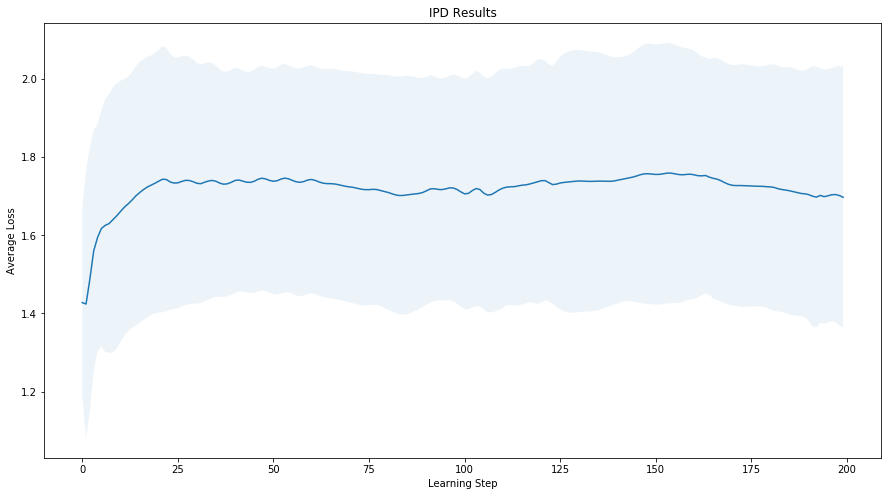

Jax time: 52.229727268218994
[1.42774579 1.42792939 1.48973449 1.50762529 1.49627538 1.49340487
 1.49506277 1.49224945 1.49198763 1.49790248 1.50420524 1.50606436
 1.50654882 1.50973746 1.51561205 1.51903126 1.51995122 1.52202874
 1.5271204  1.53163782 1.53335048 1.53467477 1.53850497 1.54344607
 1.54618803 1.54739571 1.54996523 1.5545325  1.5581547  1.55978539
 1.56149256 1.56516357 1.56920861 1.57149927 1.57288004 1.57553294
 1.57946639 1.58239878 1.58387937 1.58568077 1.58907709 1.59249767
 1.59434454 1.59551776 1.59808262 1.6018456  1.60433858 1.60492493
 1.60621763 1.61018393 1.61391839 1.61382118 1.61326911 1.61675358
 1.61991802 1.61947577 1.61889322 1.62416896 1.62795143 1.62529872
 1.62425546 1.6261543  1.63000505 1.63267247 1.6336767  1.63459513
 1.63680507 1.63970376 1.64160979 1.64259024 1.64400732 1.64650009
 1.64880191 1.65004375 1.65104878 1.65296506 1.65539049 1.65699935
 1.65787522 1.65917083 1.66139875 1.66339884 1.66443498 1.66524445
 1.66694094 1.66916799 1.67063418

Jax time: 51.87539339065552
[1.42774579 1.40731322 1.4154876  1.44417916 1.4535055  1.45397629
 1.44916428 1.44251845 1.44215101 1.44372648 1.44431703 1.44458374
 1.44421759 1.44354106 1.44341184 1.44384635 1.44421544 1.44415664
 1.4438099  1.44354179 1.44362274 1.4439487  1.44416323 1.44407261
 1.44381123 1.44364744 1.44372332 1.44394081 1.44407699 1.44401981
 1.4438589  1.44376309 1.4438137  1.44394583 1.44402689 1.44399369
 1.44390155 1.44384982 1.44388364 1.4439618  1.44400839 1.44398988
 1.44393904 1.44391305 1.44393628 1.44398317 1.44401055 1.44400048
 1.44397367 1.44396174 1.44397827 1.4440073  1.44402383 1.44401942
 1.44400605 1.44400207 1.4440142  1.44403294 1.44404366 1.44404318
 1.44403746 1.44403759 1.44404689 1.44405966 1.44406767 1.444069
 1.44406791 1.44407068 1.44407786 1.44408692 1.44409365 1.44409632
 1.44409787 1.44410168 1.44410774 1.44411482 1.44412073 1.4441245
 1.44412719 1.44413134 1.4441373  1.44414337 1.44414866 1.44415272
 1.4441565  1.44416095 1.44416636 1.4

Jax time: 52.1942925453186
[1.42774579 1.41842419 1.45837812 1.48669529 1.47583035 1.47023236
 1.46710621 1.46146559 1.45689065 1.45715571 1.4607734  1.46176994
 1.45982862 1.45803009 1.45806701 1.45965986 1.46021406 1.45933417
 1.45841897 1.45862076 1.45956761 1.4597585  1.45913988 1.45867367
 1.45902806 1.4596572  1.459631   1.45913506 1.45893382 1.45934272
 1.45976345 1.45962897 1.45924322 1.45920484 1.45959722 1.45986717
 1.4596926  1.45941274 1.45947146 1.45981249 1.45997358 1.45979816
 1.45961313 1.45972495 1.46000307 1.46008847 1.45993346 1.45982668
 1.45996162 1.46017877 1.46021509 1.46009077 1.46004377 1.46018279
 1.46034614 1.46035376 1.46026238 1.46025878 1.46039061 1.46051046
 1.46050371 1.46044383 1.4604696  1.46058764 1.4606745  1.46066325
 1.46063093 1.46067504 1.46077738 1.46083991 1.46083091 1.46082099
 1.46087477 1.46096201 1.46100829 1.46100452 1.46101211 1.4610701
 1.4611433  1.4611791  1.46118229 1.46120248 1.46126103 1.46132281
 1.46135248 1.46136293 1.46139277 1.

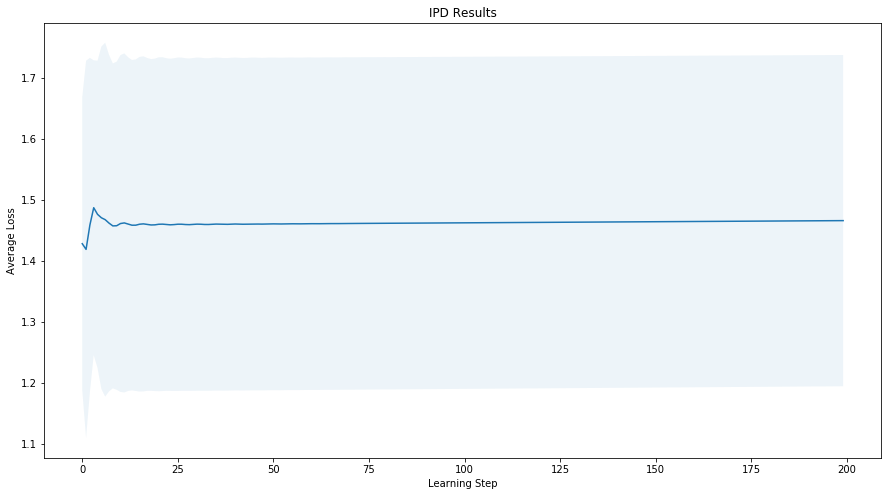

Jax time: 52.6244912147522
[1.42774579 1.41443631 1.44375376 1.48040742 1.4814355  1.47971973
 1.47849389 1.47708062 1.47585473 1.47557596 1.47809407 1.48225505
 1.48482317 1.48544524 1.48604858 1.48768095 1.49043463 1.49323451
 1.49514293 1.4964117  1.49785368 1.4999037  1.50229197 1.50440941
 1.50605049 1.50756826 1.50936952 1.51146868 1.51352706 1.51527954
 1.51683511 1.51850514 1.52041945 1.52239587 1.52416982 1.52571447
 1.52726538 1.52902961 1.53093495 1.53271137 1.53421896 1.53563876
 1.53726465 1.53913173 1.54093349 1.54238376 1.54362555 1.54511094
 1.54702106 1.54893719 1.5502929  1.55121916 1.55252352 1.55466087
 1.55690232 1.55804285 1.55830062 1.55927418 1.56193956 1.56489234
 1.56565329 1.56480545 1.56509768 1.56786045 1.57135562 1.572816
 1.57210096 1.57197618 1.57389632 1.57677644 1.57884317 1.57944087
 1.57977549 1.58113718 1.58335946 1.58527282 1.5862075  1.58683633
 1.58812036 1.59012817 1.59192197 1.59281486 1.59343841 1.59466086
 1.59660508 1.59843468 1.59933582 1.5

Jax time: 53.454214096069336
[1.42774579 1.41288616 1.43748976 1.47043021 1.47007586 1.46586618
 1.46079535 1.45766937 1.45678298 1.45605203 1.45697644 1.45795171
 1.45753615 1.45692653 1.45693824 1.45721044 1.45767186 1.45802608
 1.45818495 1.4582974  1.45836446 1.45847812 1.45873399 1.45906243
 1.45934911 1.45950356 1.45957474 1.45971403 1.45997545 1.46028441
 1.46052379 1.46066089 1.46078229 1.46097658 1.46124011 1.46149757
 1.46169135 1.46184263 1.46201435 1.46223536 1.46247752 1.46269454
 1.46287609 1.46305224 1.4632521  1.46347429 1.46369325 1.46389235
 1.46407948 1.46427385 1.46448243 1.46469596 1.46490172 1.46509774
 1.46529274 1.46549516 1.46570337 1.46590946 1.46611018 1.46630844
 1.46650898 1.46671309 1.46691797 1.46712041 1.46732075 1.4675211
 1.4677233  1.46792695 1.46812955 1.46833112 1.46853171 1.46873307
 1.4689355  1.46913786 1.46933959 1.46954067 1.46974228 1.46994343
 1.47014554 1.47034692 1.47054829 1.47074933 1.47095061 1.47115197
 1.4713535  1.47155474 1.47175574 

Jax time: 52.43164038658142
[1.42774579 1.44254363 1.53240461 1.5656836  1.56928479 1.57821165
 1.59302849 1.60110654 1.60894711 1.62187196 1.6335019  1.64167121
 1.65025227 1.66217055 1.67210424 1.67545348 1.67905291 1.68520406
 1.69467771 1.70340923 1.70956793 1.71275192 1.71656414 1.72206547
 1.72652966 1.72918897 1.73165717 1.73762683 1.74234207 1.73990503
 1.73832155 1.73715248 1.73766499 1.74117237 1.74333453 1.74363595
 1.74336298 1.74636133 1.75001398 1.75043483 1.74974598 1.75120787
 1.75541013 1.75763566 1.75740852 1.75648967 1.75767897 1.75973773
 1.76090551 1.76041141 1.75797098 1.75822114 1.76237166 1.76570641
 1.75976355 1.75364697 1.75239321 1.75200153 1.75200748 1.7523987
 1.75318944 1.75407568 1.75473101 1.75542786 1.75615313 1.75703772
 1.75832627 1.75963261 1.76045803 1.76085076 1.76158719 1.76327678
 1.76459163 1.76481831 1.76459286 1.76535119 1.76727078 1.76802385
 1.7675295  1.76698379 1.76819038 1.76980515 1.76984762 1.76888417
 1.76852342 1.77002161 1.77090076 1

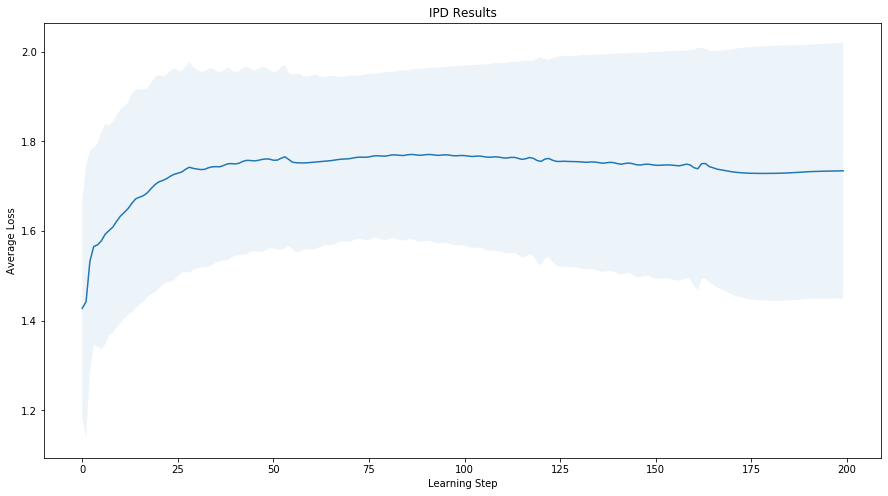

Jax time: 52.04213881492615
[1.42774579 1.40999536 1.42622393 1.45789724 1.46289075 1.46043064
 1.45404083 1.449206   1.44973897 1.4499921  1.45025854 1.45053361
 1.45000276 1.44945586 1.4495889  1.44990321 1.44992997 1.44977031
 1.44966177 1.44979393 1.45004946 1.45010815 1.44992296 1.44973903
 1.44977064 1.44999643 1.45018516 1.45015773 1.44999281 1.44989841
 1.44998234 1.45015932 1.45025714 1.45020888 1.45010927 1.45008823
 1.45017708 1.45029148 1.45033309 1.45029404 1.45024978 1.45026831
 1.45034252 1.45041036 1.4504264  1.45040583 1.45039839 1.45043142
 1.45048707 1.45052697 1.45053619 1.45053322 1.45054585 1.45058075
 1.4506209  1.45064764 1.45065799 1.45066721 1.45068869 1.45072056
 1.45075137 1.45077242 1.45078641 1.45080295 1.45082763 1.45085588
 1.45088103 1.45090071 1.45091836 1.45093864 1.45096349 1.45098898
 1.45101158 1.45103129 1.45105113 1.4510736  1.45109739 1.45112115
 1.45114288 1.45116385 1.4511849  1.45120733 1.45123058 1.4512532
 1.45127519 1.45129633 1.45131832 1

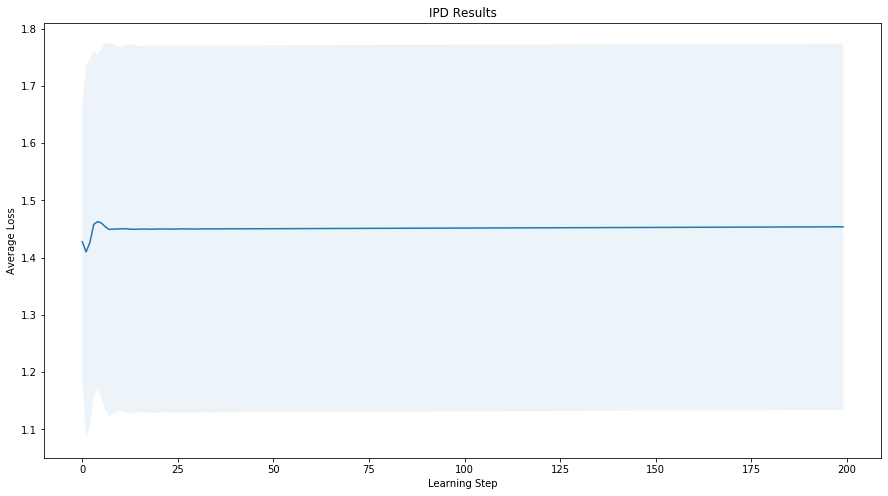

Jax time: 51.71964955329895
[1.42774579 1.44265764 1.54362391 1.57189714 1.57274556 1.57445162
 1.58911566 1.60123693 1.61122494 1.62452559 1.63410941 1.64155029
 1.64651304 1.65539419 1.66970119 1.68050461 1.68492794 1.68655006
 1.69298012 1.70436542 1.71056237 1.71105663 1.71229527 1.71635102
 1.71769584 1.72052648 1.72043858 1.71937835 1.72351322 1.72936373
 1.73335179 1.73272451 1.73293282 1.73639965 1.74074258 1.74184385
 1.73989418 1.74194914 1.74422016 1.74497671 1.743012   1.74227514
 1.74682411 1.74614226 1.74412714 1.74134026 1.74099952 1.74304211
 1.74480793 1.7424625  1.73930356 1.73775693 1.73809252 1.74023917
 1.74159235 1.74170262 1.7419558  1.74373405 1.74558716 1.74533589
 1.74445638 1.74549343 1.74826655 1.74914548 1.74715283 1.74469475
 1.74754279 1.7477441  1.74709628 1.74661996 1.75042108 1.75315087
 1.75201503 1.7509738  1.75228318 1.75525846 1.75360168 1.75139177
 1.7494444  1.75069419 1.7556603  1.75820956 1.75609531 1.75400274
 1.7560614  1.76010174 1.75946554 

Jax time: 52.14890003204346
[1.42774579 1.56755345 1.81496151 1.85579702 1.88380586 1.9073674
 1.87324434 1.88548389 1.87352223 1.86599284 1.86487862 1.88863048
 1.92747851 1.92792948 1.9050404  1.87883608 1.85881513 1.85084187
 1.84629797 1.83952915 1.83435218 1.82789333 1.81920735 1.82819266
 1.81905395 1.80465831 1.79372073 1.78674231 1.77862762 1.7759866
 1.76671389 1.75958913 1.75524659 1.75100269 1.74676165 1.74380571
 1.74401943 1.74927678 1.75078056 1.75713372 1.75890188 1.76744065
 1.77741317 1.78608287 1.76833553 1.7597654  1.75970872 1.76166321
 1.75925843 1.75417821 1.75959625 1.7615219  1.75768311 1.74819341
 1.74451115 1.74207506 1.74044102 1.74317408 1.74332232 1.74683704
 1.74493788 1.74334282 1.74291331 1.7424599  1.74133293 1.73935352
 1.73715854 1.73559546 1.73453079 1.73363527 1.73252213 1.73042527
 1.72609401 1.72063873 1.72240351 1.72106576 1.71401082 1.71154663
 1.71136554 1.71130666 1.7120804  1.71998916 1.72382735 1.73359212
 1.72933905 1.72423781 1.71976539 1.

Jax time: 52.39057970046997
[1.42774579 1.41842439 1.45840119 1.4867199  1.47584675 1.47024582
 1.46712242 1.46147815 1.45689857 1.45716306 1.46078535 1.46178674
 1.45984346 1.45804041 1.45807609 1.4596715  1.46022761 1.45934643
 1.45842905 1.45863093 1.45957999 1.45977103 1.45915039 1.45868315
 1.45903881 1.45966945 1.45964253 1.45914528 1.45894351 1.45935396
 1.45977585 1.45964049 1.45925344 1.45921445 1.45960837 1.45987883
 1.45970363 1.45942268 1.45948165 1.45982375 1.45998497 1.45980879
 1.45962303 1.45973504 1.46001389 1.46009974 1.45994425 1.45983641
 1.4599722  1.46018963 1.46022585 1.46010081 1.46005388 1.46019316
 1.46035712 1.46036465 1.46027276 1.46026905 1.46040132 1.46052146
 1.46051425 1.46045407 1.46047977 1.46059845 1.46068538 1.46067389
 1.4606409  1.46068528 1.46078804 1.46085052 1.46084118 1.46083104
 1.46088522 1.46097245 1.46101863 1.46101464 1.46102223 1.46108054
 1.46115378 1.46118962 1.46119251 1.46121315 1.46127148 1.46133329
 1.46136289 1.46137339 1.461403   

Jax time: 52.50433039665222
[1.42774579 1.41856566 1.45882883 1.48733838 1.47663103 1.47123565
 1.46835183 1.46278977 1.45824826 1.45863944 1.46247123 1.46369486
 1.46187391 1.46015189 1.46032707 1.46211067 1.46284998 1.46209723
 1.46129039 1.46163975 1.46276176 1.46311867 1.46263138 1.46228964
 1.46279295 1.4635873  1.46371978 1.46336018 1.46328998 1.46384525
 1.46442545 1.46444771 1.46420237 1.46429727 1.46483233 1.46525905
 1.46524143 1.4651047  1.46529715 1.46577854 1.46609473 1.46607676
 1.46603594 1.46628112 1.4666983  1.46693882 1.4669417  1.4669785
 1.46724674 1.46760277 1.46779409 1.46782707 1.46792331 1.46819467
 1.46849852 1.4686617  1.46872634 1.46886449 1.46912869 1.46939097
 1.46953978 1.46963339 1.46979968 1.47005146 1.47028242 1.47042661
 1.4705458  1.47072877 1.47096626 1.4711746  1.47131998 1.47145948
 1.47165137 1.47187532 1.47206863 1.47221817 1.47237295 1.47256857
 1.47278052 1.47296428 1.47311953 1.47328517 1.47348141 1.47368346
 1.47386132 1.47402224 1.47419546 1

Jax time: 52.557498931884766
[1.42774579 1.41334011 1.43770774 1.47760679 1.48792724 1.49103957
 1.49222259 1.49345851 1.49538292 1.49784255 1.50160056 1.50707137
 1.51209152 1.51498879 1.5174237  1.52085085 1.5254786  1.5306691
 1.53509946 1.53818755 1.54081108 1.54401508 1.54813516 1.55262033
 1.5564097  1.55904292 1.56127499 1.5642004  1.56819062 1.57246062
 1.57561982 1.57742667 1.57931286 1.58260159 1.58723148 1.59128121
 1.59302613 1.59384697 1.59591693 1.60009981 1.6049122  1.60763968
 1.60819292 1.60912001 1.611994   1.61629717 1.62000331 1.62176236
 1.62266464 1.62450958 1.62780879 1.63144313 1.63391629 1.63523703
 1.63665567 1.639161   1.64251582 1.64536216 1.64700631 1.64821016
 1.65007833 1.65305959 1.6562313  1.65825866 1.6593172  1.66064348
 1.66318308 1.6664394  1.66870726 1.66957146 1.67037632 1.67265061
 1.67588453 1.67761585 1.67818392 1.67841082 1.6799789  1.68354501
 1.68488578 1.68542052 1.68558859 1.68569707 1.68728469 1.68977968
 1.69137867 1.69202147 1.6918467  

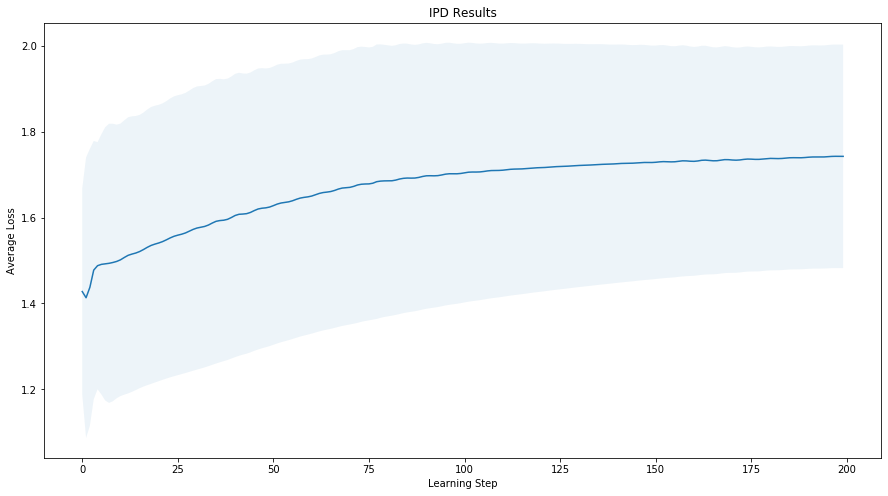

Jax time: 52.222984075546265
[1.42774579 1.46413798 1.58844766 1.62972909 1.6387842  1.64830525
 1.66854355 1.68084153 1.69042207 1.70173741 1.71522723 1.72874813
 1.73879259 1.74166449 1.74598902 1.75379632 1.76007458 1.75792564
 1.75551708 1.76102272 1.7665897  1.76762349 1.76251827 1.76269403
 1.76634612 1.76895318 1.77104669 1.77056206 1.77094643 1.77363089
 1.77833375 1.78035213 1.77737518 1.77667747 1.77990698 1.78455039
 1.78467183 1.78074112 1.78121925 1.78249083 1.78489886 1.7838246
 1.78241154 1.78289235 1.78519922 1.78746115 1.7855268  1.78091824
 1.78141167 1.78383298 1.78463268 1.78287798 1.7810924  1.78361553
 1.78726769 1.78685807 1.78047761 1.77720074 1.78729222 1.78900187
 1.78581447 1.78162449 1.78118275 1.78309155 1.78426749 1.78277235
 1.77994439 1.78008736 1.78145712 1.78236858 1.78088495 1.78005053
 1.78051605 1.78134037 1.78096533 1.77974039 1.78094951 1.78229256
 1.77831684 1.77431905 1.77144657 1.76933476 1.7681104  1.76772536
 1.76808854 1.76856799 1.76840339 

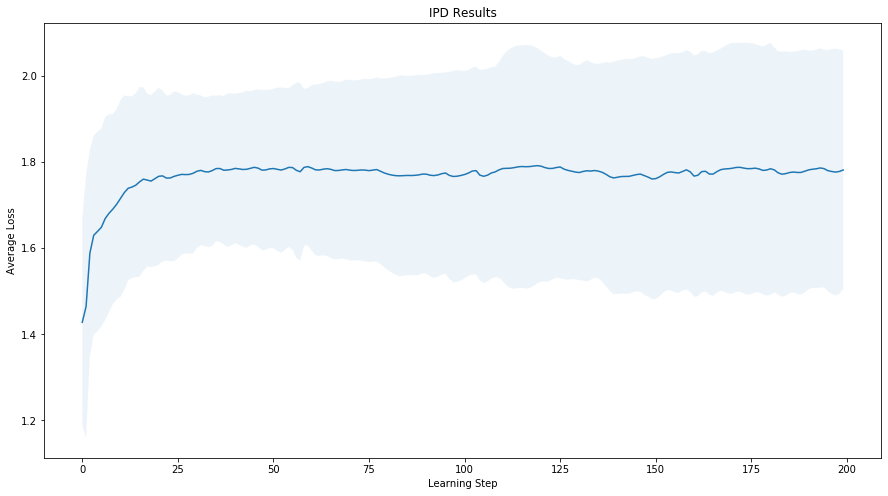

Jax time: 52.021925926208496
[1.42774579 1.43321608 1.51755461 1.57476112 1.59310956 1.60470958
 1.61411756 1.62230174 1.63023314 1.63693999 1.64706389 1.65916881
 1.66772799 1.67327919 1.68183079 1.69515939 1.70568303 1.71320181
 1.71572676 1.71638238 1.72217089 1.72800997 1.7327627  1.73673001
 1.73897219 1.7365171  1.735422   1.7386696  1.74209837 1.74445345
 1.74368688 1.74313283 1.74637913 1.74762565 1.74874729 1.74833218
 1.74672392 1.74748257 1.74883349 1.7491749  1.7481553  1.74623888
 1.74707775 1.74867624 1.74738297 1.74562966 1.74338186 1.74349066
 1.74427814 1.74261763 1.74078483 1.73946994 1.73881305 1.73847429
 1.73734328 1.73653957 1.73613329 1.7356396  1.73504677 1.73418682
 1.73489882 1.73637697 1.73557392 1.73288985 1.72967027 1.72891979
 1.731082   1.73163145 1.72904472 1.72546655 1.72425702 1.72699334
 1.73021261 1.72835576 1.72183413 1.7169742  1.71534885 1.7148112
 1.71398731 1.71177692 1.70966606 1.71022305 1.71149033 1.71234663
 1.71153858 1.71002397 1.71103412 

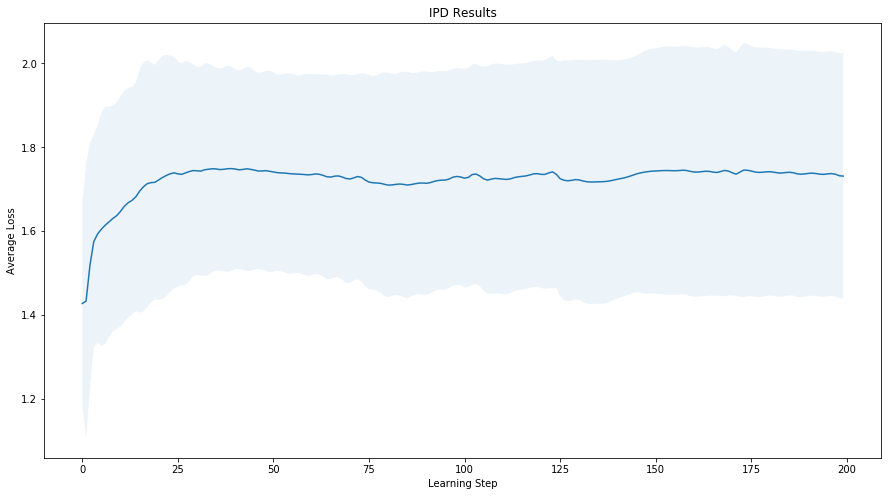

Jax time: 52.525416135787964
[1.42774579 1.58885793 1.82903462 1.88255507 1.91346942 1.9174653
 1.91141515 1.88872287 1.86491962 1.86058698 1.86260997 1.86910432
 1.87124563 1.87276929 1.87134386 1.86932333 1.86504201 1.85332447
 1.84072546 1.83990634 1.85767843 1.86807556 1.87506565 1.87301683
 1.86270416 1.85434657 1.84678095 1.84159459 1.83075721 1.83025656
 1.84199406 1.83690068 1.82490512 1.81225446 1.80437704 1.80048243
 1.79772387 1.79577469 1.79540406 1.80085882 1.81039874 1.80963039
 1.79953191 1.78870274 1.78813833 1.79004583 1.7895213  1.7875157
 1.789282   1.78331951 1.77346833 1.76413931 1.76842614 1.78834149
 1.79216815 1.78694249 1.77506195 1.77010547 1.77731678 1.77139113
 1.76450455 1.76126278 1.76406726 1.76437828 1.76490893 1.76382746
 1.75348214 1.75904507 1.77590187 1.77922029 1.77212698 1.76163572
 1.75333593 1.76121439 1.76965164 1.77456612 1.77708498 1.77257188
 1.76048795 1.76071532 1.75991279 1.75402182 1.74854937 1.74761794
 1.75003478 1.75221498 1.75280326 1

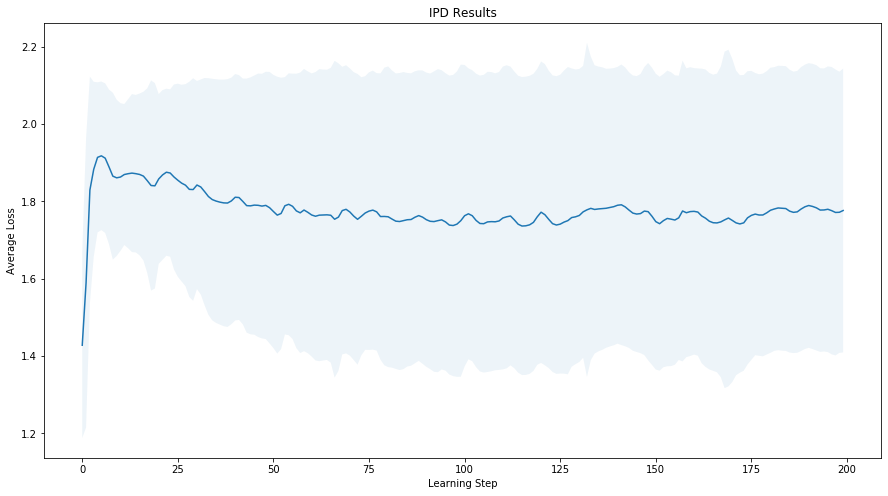

Jax time: 52.311638832092285
[1.42774579 1.41587039 1.44900695 1.48128339 1.47507107 1.47066654
 1.46757717 1.46382262 1.46021905 1.45913221 1.46159978 1.46374664
 1.46351484 1.46249023 1.46200427 1.46275195 1.46406126 1.46466074
 1.46454152 1.46435671 1.46472565 1.46555136 1.46617467 1.46637222
 1.46643608 1.46676294 1.46736719 1.46790058 1.46819249 1.46839553
 1.46874425 1.46925323 1.46972296 1.47004503 1.4703156  1.47068013
 1.4711437  1.47157939 1.47191755 1.47222332 1.4725932  1.47302852
 1.47344524 1.47379608 1.47412318 1.47449301 1.4749084  1.47531366
 1.47567339 1.47601542 1.47638431 1.47678462 1.47718084 1.47754733
 1.47789917 1.47826707 1.478657   1.4790461  1.47941622 1.47977479
 1.48014255 1.48052511 1.48090855 1.48127957 1.48164241 1.48201037
 1.48238754 1.4827663  1.4831378  1.48350298 1.48387039 1.48424405
 1.48461905 1.48498939 1.48535575 1.48572289 1.48609369 1.48646554
 1.48683472 1.48720096 1.48756759 1.48793618 1.48830522 1.48867316
 1.48903886 1.4894043  1.48977085

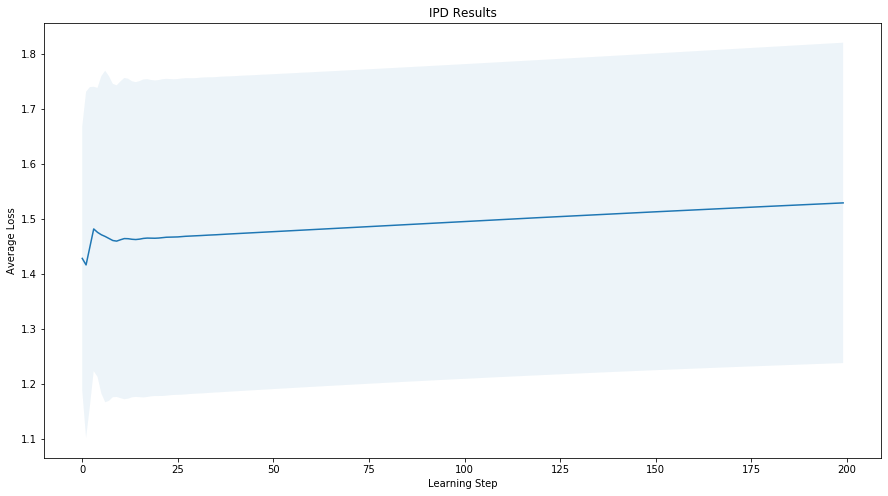

Jax time: 52.84792923927307
[1.42774579 1.44582237 1.55101325 1.56816685 1.5617823  1.56262788
 1.57805507 1.59266433 1.60437918 1.61475918 1.62162806 1.62915006
 1.63543679 1.64617811 1.66003462 1.66894478 1.67076288 1.67352219
 1.68703103 1.69862038 1.69933151 1.69758845 1.70312617 1.71009561
 1.71334204 1.71560163 1.72062621 1.72317512 1.72196092 1.7237438
 1.72207738 1.72347901 1.72813585 1.73348731 1.73305006 1.73164019
 1.73677029 1.73934173 1.74227696 1.74103887 1.74116093 1.74280717
 1.74540814 1.74696886 1.74499109 1.74445438 1.74648009 1.74930627
 1.74783982 1.74648548 1.74901886 1.75204085 1.75018802 1.7464826
 1.75045265 1.75649242 1.75471266 1.74487433 1.74419266 1.75203311
 1.75412049 1.7504015  1.74744823 1.7521086  1.75701275 1.75723013
 1.7526287  1.75073496 1.75407344 1.75840585 1.75856291 1.75563879
 1.75463264 1.7582384  1.76077246 1.75958442 1.75756204 1.75962729
 1.76305555 1.76345697 1.76064343 1.75891116 1.76131677 1.76182871
 1.76041197 1.76172687 1.76573201 1.

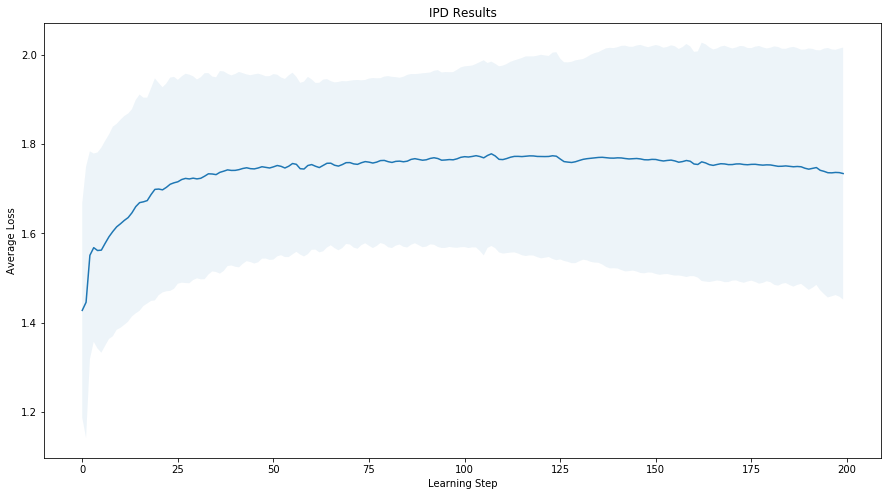

Jax time: 52.27060890197754
[1.42774579 1.70241666 1.90582147 1.95464721 1.96801536 1.95353724
 1.94751183 1.94273379 1.96448202 1.97521735 1.97538251 1.96732389
 1.96772266 1.95586612 1.95490958 1.95418372 1.9505869  1.9504375
 1.95044348 1.9504477  1.95037229 1.95005165 1.94897208 1.94596968
 1.94165145 1.93725686 1.94917562 1.95200234 1.95268041 1.95316767
 1.95359887 1.95400049 1.95437438 1.95471996 1.95503478 1.95532011
 1.95558214 1.95582434 1.95605163 1.95626237 1.95645349 1.95662166
 1.95676629 1.95689209 1.9570054  1.95711384 1.95721925 1.95732424
 1.95742735 1.95752795 1.95762471 1.95771774 1.95780526 1.95788713
 1.95796358 1.95803427 1.95809947 1.95815989 1.95821631 1.95826904
 1.95831897 1.95836555 1.95841068 1.95845315 1.95849331 1.95853132
 1.9585676  1.95860169 1.95863451 1.95866572 1.95869488 1.95872289
 1.95874943 1.95877495 1.95880001 1.95882328 1.95884553 1.958867
 1.95888759 1.95890785 1.95892628 1.95894547 1.95896224 1.95897928
 1.95899594 1.95901207 1.9590275  1.9

Jax time: 52.40277886390686
[1.42774579 1.45740413 1.5754589  1.6374788  1.6580841  1.66823636
 1.68303807 1.69633634 1.70374797 1.7106831  1.71873666 1.72856062
 1.74141394 1.7516476  1.75863991 1.76067011 1.76155499 1.76552581
 1.77073106 1.77492261 1.77542211 1.76907184 1.7685895  1.77069059
 1.76791583 1.76486786 1.76357561 1.76342188 1.76368066 1.7627907
 1.7616837  1.76103455 1.76146822 1.76365929 1.76523148 1.76524108
 1.76497288 1.7668504  1.77099653 1.77353388 1.77383445 1.77341729
 1.77576959 1.77932153 1.77943902 1.77751793 1.77632375 1.77883943
 1.7819272  1.78004636 1.77677923 1.77605366 1.77799068 1.77741194
 1.77492838 1.77291182 1.77553556 1.77954865 1.77683812 1.77306054
 1.77036539 1.76992288 1.772493   1.77672155 1.7762295  1.76853769
 1.76743163 1.76531431 1.76293143 1.76166291 1.76250395 1.76318707
 1.76204791 1.76016567 1.75882728 1.75915849 1.76018858 1.76042832
 1.75717524 1.75322144 1.75291313 1.75235761 1.75081428 1.74959404
 1.75056392 1.75404289 1.75651827 1

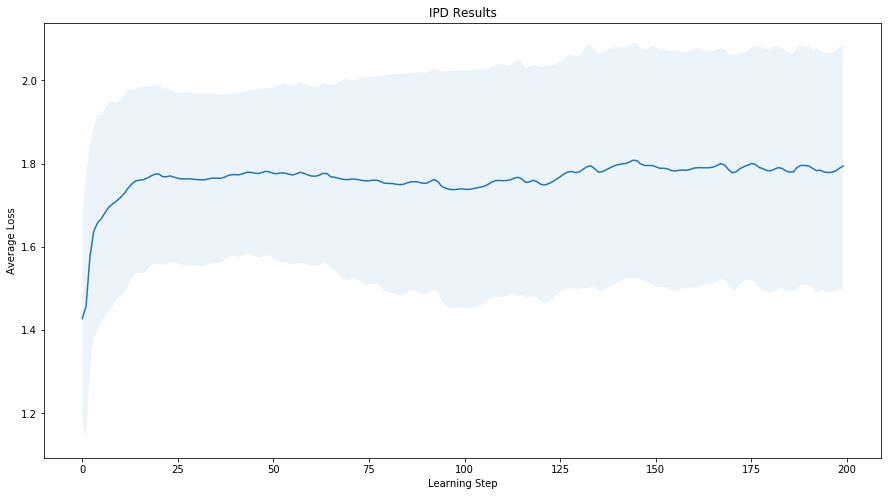

Jax time: 52.100446939468384
[1.42774579 1.57678236 1.8313514  1.84565622 1.84305216 1.9193035
 1.92101553 1.9357054  1.95478456 1.94852581 1.93793992 1.92987687
 1.9241872  1.91727264 1.91357705 1.91447378 1.91880515 1.92190476
 1.92027432 1.9129168  1.90407684 1.89972405 1.88936602 1.87479208
 1.87134209 1.88609417 1.88913242 1.89062664 1.88422013 1.88358596
 1.88288953 1.88025311 1.86924222 1.87250681 1.88321327 1.88169582
 1.87879902 1.8891814  1.88932258 1.88793237 1.88644597 1.88078826
 1.87787354 1.87496819 1.90117041 1.91496891 1.91878284 1.93005813
 1.93239483 1.93153582 1.92736764 1.91722928 1.90273522 1.89503021
 1.89269107 1.89198101 1.89089357 1.89035718 1.89029127 1.89035912
 1.89052872 1.89090573 1.89195523 1.90110097 1.91304702 1.90704586
 1.89359335 1.89264781 1.89206095 1.89253094 1.89282341 1.89714306
 1.91261396 1.91319526 1.91349718 1.91404607 1.91545979 1.92133411
 1.9333451  1.93613271 1.94530531 1.96686184 1.96980876 1.97011799
 1.97029452 1.97039944 1.97016865 

Jax time: 52.131767988204956
[1.42774579 1.40763905 1.41660607 1.44629474 1.45620805 1.45729249
 1.45315584 1.44716399 1.44705342 1.44896569 1.45008028 1.4509974
 1.45132555 1.4511829  1.45135568 1.45204648 1.45280673 1.45331205
 1.45361509 1.45393744 1.45446014 1.45513417 1.4557373  1.45614473
 1.45645067 1.45683047 1.45737125 1.45800103 1.4585703  1.45900753
 1.45937505 1.45978612 1.46029734 1.4608665  1.4614064  1.46187174
 1.4622921  1.46273094 1.46322294 1.46374978 1.46426575 1.46474436
 1.46519669 1.46565512 1.46613947 1.46664261 1.46714296 1.46762532
 1.46809437 1.46856448 1.46904622 1.46953774 1.4700285  1.47051156
 1.47098798 1.47146413 1.47194526 1.47243058 1.47291627 1.47339871
 1.4738782  1.4743566  1.47483737 1.4753199  1.47580281 1.4762841
 1.47676397 1.47724347 1.47772346 1.47820434 1.47868522 1.47916501
 1.47964471 1.48012357 1.48060322 1.48108233 1.48156175 1.48204052
 1.48251878 1.48299718 1.4834754  1.48395314 1.48443096 1.48490835
 1.4853857  1.4858624  1.48633926 1

Jax time: 52.58887767791748
[1.42774579 1.41616208 1.45069467 1.49118868 1.49385379 1.49462742
 1.49741267 1.49861339 1.49698314 1.49667785 1.50018654 1.50699866
 1.51311049 1.51623092 1.51765726 1.5199636  1.52426397 1.52941567
 1.5334595  1.53588938 1.53802457 1.54124566 1.54548502 1.54944412
 1.5521194  1.55405991 1.55669084 1.56054021 1.56455399 1.56723661
 1.56872637 1.57081118 1.57465955 1.57913618 1.58172653 1.58230622
 1.58349562 1.58719978 1.59221826 1.59525254 1.59541392 1.59572843
 1.59855054 1.60309575 1.60686313 1.60819939 1.60862449 1.61060479
 1.61444792 1.61824933 1.61999819 1.62040866 1.62190941 1.62545967
 1.6294252  1.63125676 1.63125463 1.6322132  1.63567196 1.63999338
 1.64192102 1.64132998 1.64162569 1.64530333 1.65009311 1.65161577
 1.65016749 1.65004481 1.6547177  1.65919385 1.65965198 1.65766693
 1.65736652 1.66439877 1.66721635 1.66699538 1.66484227 1.66198593
 1.6624518  1.66756004 1.67232162 1.67264528 1.67052755 1.6699799
 1.67314839 1.67755221 1.679063   1

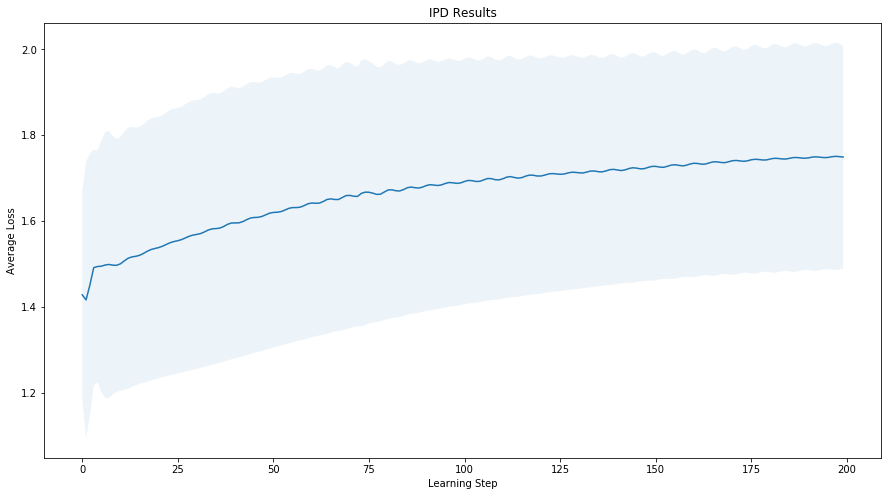

Jax time: 52.700926542282104
[1.42774579 1.5436789  1.79094375 1.79874555 1.80801929 1.85263841
 1.86807379 1.86324898 1.8756491  1.89457486 1.88937029 1.90586963
 1.91146128 1.91007444 1.91490602 1.91837068 1.91072929 1.90371526
 1.8754285  1.86448813 1.8606576  1.85520481 1.85327334 1.84183092
 1.83856539 1.83141432 1.82821783 1.82407063 1.81865504 1.81627317
 1.80559417 1.78870819 1.77243515 1.76275132 1.75427146 1.73922292
 1.71784173 1.71577451 1.71297819 1.70997308 1.70365537 1.69220609
 1.6909289  1.69757654 1.69865574 1.7013586  1.70821561 1.71396868
 1.72006452 1.72176534 1.7241332  1.72329454 1.72160151 1.7215753
 1.72290867 1.72695034 1.73813105 1.7476284  1.73973846 1.73356813
 1.73198308 1.72874783 1.717384   1.71233345 1.72468123 1.72994432
 1.73213124 1.73250249 1.73210209 1.73132165 1.73487815 1.73619547
 1.73019262 1.72198717 1.73060768 1.72965529 1.7302593  1.73091782
 1.73085974 1.73013856 1.72759643 1.71801018 1.70815472 1.70514099
 1.70249126 1.70498211 1.71180255 

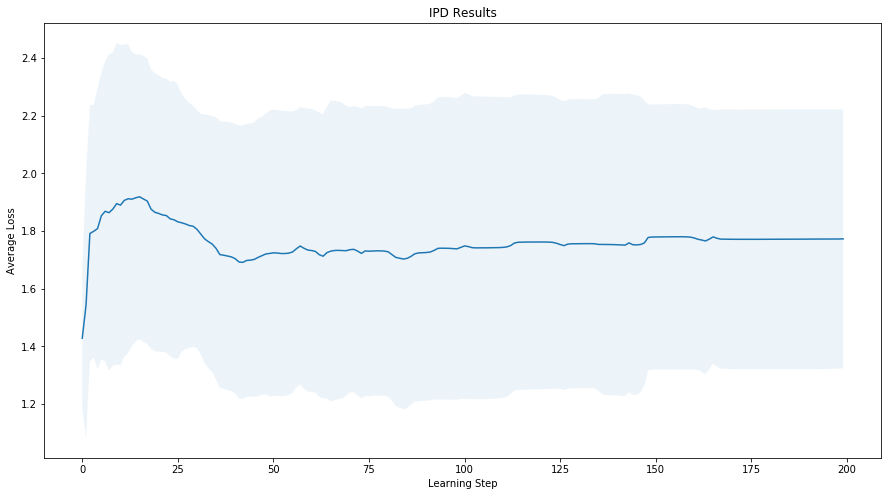

Jax time: 52.41032266616821
[1.42774579 1.41273276 1.43697469 1.46959654 1.46904569 1.46457322
 1.45913617 1.45585546 1.45494978 1.4541138  1.45482861 1.45550596
 1.45487839 1.45418016 1.45407899 1.45414907 1.45435942 1.45449731
 1.45450822 1.45448932 1.4543751  1.4542646  1.45430841 1.45446796
 1.45460737 1.45458981 1.45445275 1.45438254 1.45446505 1.45461739
 1.4546894  1.45463015 1.45454539 1.45455199 1.45464996 1.45474265
 1.45475075 1.45470077 1.45467911 1.45472621 1.45480198 1.45484031
 1.45482829 1.45480999 1.45482842 1.4548799  1.45492381 1.45493591
 1.45493099 1.45493955 1.45497257 1.45501122 1.45503458 1.45504202
 1.45505076 1.45507315 1.45510482 1.45513133 1.45514704 1.45515895
 1.45517706 1.45520275 1.45522888 1.45524878 1.45526404 1.45528162
 1.4553034  1.45532799 1.45534946 1.45536742 1.45538512 1.45540566
 1.45542784 1.45544997 1.45546949 1.455488   1.4555079  1.45552903
 1.45555042 1.45557112 1.4555906  1.45561018 1.45563086 1.45565191
 1.45567251 1.45569251 1.45571241 

Jax time: 52.292378187179565
[1.42774579 1.41555519 1.44775766 1.47943218 1.47298704 1.46806467
 1.46425284 1.46037328 1.4568742  1.45566003 1.45767995 1.45915994
 1.45849289 1.45731539 1.45664681 1.45701613 1.45784069 1.45803457
 1.45765107 1.45720213 1.4572103  1.4576285  1.45788568 1.45778277
 1.45754023 1.45750585 1.45773159 1.4579173  1.45789752 1.45777974
 1.4577712  1.45791343 1.45803939 1.45804167 1.45798668 1.45800173
 1.45810712 1.45819869 1.45820964 1.45818666 1.45821309 1.45829847
 1.45837245 1.45838984 1.45838539 1.4584163  1.45848846 1.4585517
 1.45857553 1.45858283 1.4586155  1.45867727 1.45873427 1.45876304
 1.45877932 1.45881244 1.45886682 1.4589191  1.45895186 1.4589741
 1.45900794 1.45905714 1.45910556 1.45914051 1.4591679  1.45920215
 1.45924766 1.45929338 1.45932998 1.45936067 1.45939557 1.45943835
 1.45948208 1.45951973 1.45955277 1.45958829 1.45962941 1.45967142
 1.45970958 1.45974436 1.45978068 1.45982037 1.45986138 1.45989972
 1.45993586 1.45997222 1.46001146 1

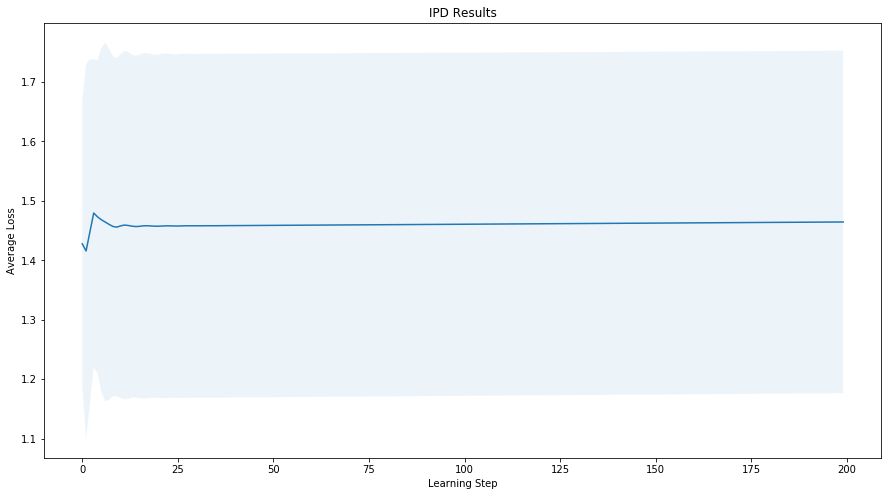

Jax time: 52.11442041397095
[1.42774579 1.44414439 1.54564315 1.63479576 1.68336832 1.70903243
 1.7270827  1.74224773 1.74909302 1.7519715  1.75690391 1.76457435
 1.76863625 1.76340032 1.76093834 1.75787956 1.75493316 1.75488894
 1.7559399  1.75610658 1.75596339 1.75706473 1.75879913 1.75824796
 1.75663292 1.75550661 1.75486432 1.75485857 1.75712028 1.7567257
 1.7555478  1.75529193 1.75622839 1.75686273 1.75525171 1.75231937
 1.74941905 1.74933569 1.75510472 1.76122556 1.76038088 1.75479624
 1.74750043 1.74230022 1.74508605 1.75616234 1.76385626 1.7589201
 1.74989901 1.73958205 1.73289648 1.72895227 1.72698546 1.726714
 1.72648527 1.72859907 1.7357536  1.74399489 1.74532414 1.7358749
 1.72390124 1.71761187 1.71870846 1.72417552 1.73070126 1.73574295
 1.73883345 1.74024972 1.73834492 1.73557074 1.73850821 1.74395484
 1.74717985 1.74913894 1.75045067 1.74568056 1.73119267 1.72446341
 1.72464164 1.72607349 1.72656398 1.72712939 1.72772824 1.7234218
 1.71672068 1.71598196 1.71772782 1.7197

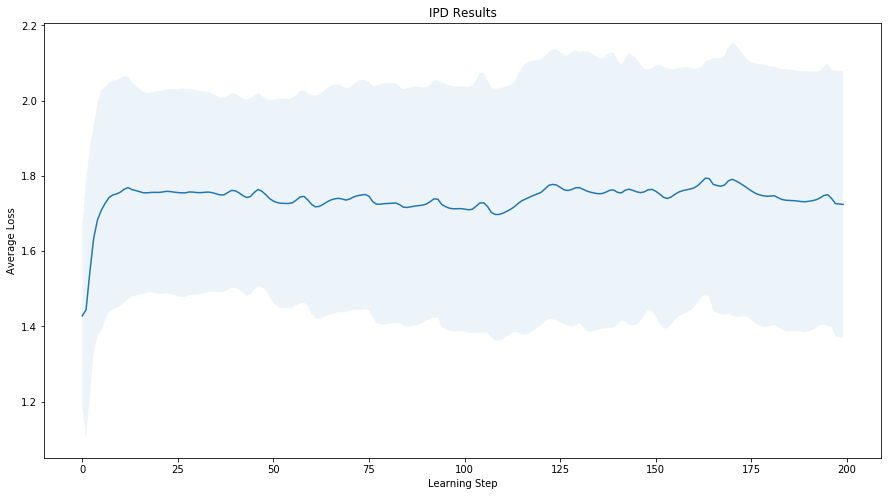

Jax time: 51.82182598114014
[1.42774579 1.42913521 1.49506274 1.50123335 1.48511222 1.47956259
 1.48020084 1.47763329 1.47707631 1.48093244 1.48290093 1.48227747
 1.48269041 1.48539577 1.48761546 1.48765352 1.48828141 1.49064411
 1.49310767 1.49374035 1.49435156 1.49642376 1.49887169 1.49998476
 1.50065004 1.50244182 1.50479161 1.50620252 1.50697843 1.50851737
 1.510756   1.51235112 1.51324593 1.51457838 1.5166875  1.51841959
 1.51942594 1.52059994 1.52254678 1.5243894  1.52551171 1.52657484
 1.52832694 1.53023952 1.53149582 1.53249485 1.53403642 1.53595822
 1.53736381 1.53834716 1.5396871  1.54154647 1.54309714 1.54411386
 1.54528189 1.54701555 1.54868197 1.54977802 1.55081704 1.5523808
 1.55411157 1.55532222 1.5562825  1.55765714 1.55938774 1.56072982
 1.56166483 1.56285457 1.564518   1.56598635 1.56695058 1.56797843
 1.56951596 1.57108294 1.57212537 1.57303006 1.57439625 1.57601282
 1.57717644 1.57800867 1.5791739  1.58077135 1.5820894  1.58291928
 1.58386276 1.58534376 1.58684579 1

Jax time: 52.451141357421875
[1.42774579 1.70797792 1.90917516 1.95069662 1.95765724 1.95110949
 1.94535344 1.96350902 1.96247986 1.97086482 1.96253875 1.96515704
 1.96388141 1.96217979 1.95826278 1.95292846 1.95008152 1.94824323
 1.94459959 1.93733233 1.92744745 1.94060131 1.95089237 1.95203343
 1.95274222 1.95332336 1.95381809 1.95423764 1.95459483 1.95489948
 1.95516255 1.95539377 1.95560314 1.95579465 1.95597612 1.95615046
 1.95632241 1.95649108 1.95665715 1.9568173  1.95696798 1.95710608
 1.95723127 1.95734337 1.9574456  1.95753841 1.957624   1.95770366
 1.9577774  1.9578465  1.95791122 1.95797253 1.95803081 1.95808497
 1.9581365  1.95818514 1.95823149 1.95827578 1.95831699 1.95835693
 1.9583949  1.95843093 1.95846556 1.95849819 1.9585296  1.95855986
 1.95858886 1.95861598 1.95864274 1.95866814 1.95869282 1.95871665
 1.95873933 1.95876085 1.95878188 1.95880253 1.95882213 1.95884173
 1.9588599  1.95887745 1.95889528 1.95891208 1.95892802 1.9589437
 1.95895851 1.95897431 1.95898843 

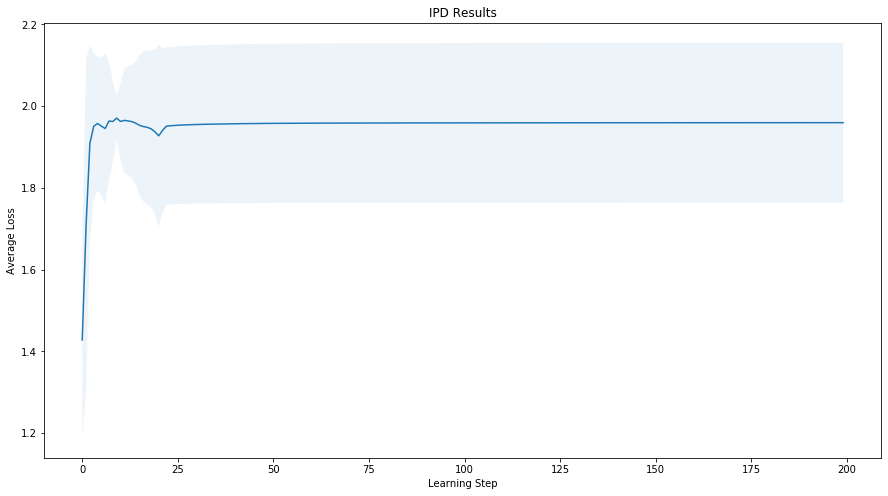

Jax time: 52.7880117893219
[1.42774579 1.64007312 1.86421221 1.92245724 1.95875184 1.97262396
 1.95849598 1.95675982 1.94377509 1.95725013 1.98160956 1.97377501
 1.96499743 1.97011436 1.97705909 1.97365629 1.97094172 1.96076397
 1.95213375 1.93010084 1.92101599 1.92095994 1.93758214 1.92984524
 1.9255875  1.91190343 1.89290413 1.87879895 1.86022174 1.8566723
 1.85436345 1.85286224 1.85139349 1.8495877  1.84544008 1.8286372
 1.82999407 1.83185321 1.82907084 1.81662495 1.80972966 1.80968869
 1.79980823 1.79818677 1.79514307 1.79123174 1.79161829 1.78964919
 1.78909693 1.78895309 1.78893051 1.78897229 1.78905452 1.78916599
 1.78929747 1.78944599 1.7896131  1.78980241 1.79002155 1.79028039
 1.79060131 1.79104468 1.79182259 1.7938922  1.80161801 1.80769354
 1.80541643 1.79943097 1.7980688  1.79758492 1.80173787 1.80818841
 1.81812206 1.8165286  1.81140908 1.81069581 1.80955065 1.80584701
 1.80708638 1.80432971 1.80189462 1.80168828 1.80164467 1.80163566
 1.80163963 1.8016459  1.80164706 1.8

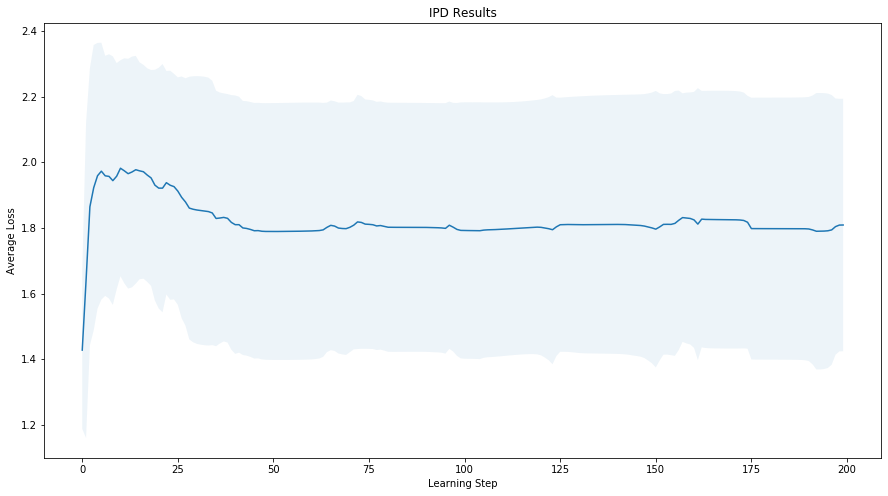

Jax time: 52.10239887237549
[1.42774579 1.42693005 1.48581397 1.55313752 1.58385841 1.60174314
 1.61240157 1.62283596 1.63542738 1.64759523 1.65854887 1.66858407
 1.67879516 1.69077444 1.70192602 1.70830624 1.71198775 1.71649053
 1.72423639 1.73212994 1.73222126 1.73401783 1.73561642 1.73757904
 1.73975515 1.74117249 1.74201676 1.74285714 1.74418555 1.74594141
 1.74685886 1.7466573  1.74625075 1.74666229 1.74812686 1.75031412
 1.75216261 1.75229177 1.75192732 1.75198282 1.75275744 1.75451522
 1.75662004 1.75671463 1.7552555  1.75350285 1.7523551  1.75224163
 1.75341439 1.75507053 1.75454829 1.75214119 1.74999169 1.74891242
 1.74925759 1.75104484 1.75172036 1.74890653 1.74560961 1.74404195
 1.74396019 1.74451806 1.74522289 1.74571431 1.7454256  1.74366696
 1.7411661  1.73986842 1.74047076 1.7413525  1.73935628 1.7349354
 1.73196565 1.73025179 1.72930876 1.72890461 1.72926538 1.73040523
 1.73197961 1.73367918 1.73520997 1.73600125 1.73574745 1.73503255
 1.73542132 1.73767204 1.73955893 1

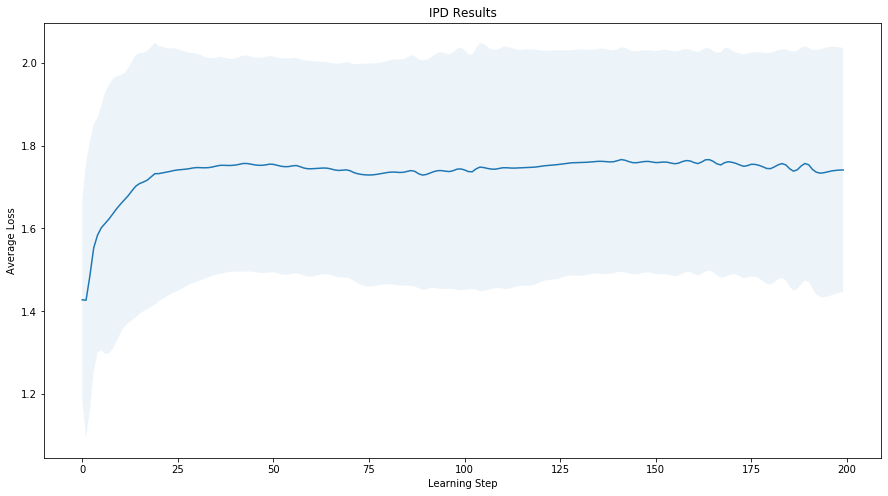

Jax time: 51.880324602127075
[1.42774579 1.40472185 1.40510961 1.42849771 1.44190831 1.44392075
 1.44222311 1.43616473 1.43309595 1.43532588 1.43666012 1.43729845
 1.43738012 1.43676657 1.4360132  1.43587278 1.4363067  1.43677341
 1.43691034 1.4367209  1.4364486  1.43636367 1.43653463 1.43678481
 1.43689416 1.43681388 1.43666781 1.43661143 1.43670242 1.43686313
 1.4369649  1.43694955 1.43687095 1.43682601 1.43686854 1.43697182
 1.43706117 1.43708446 1.43705459 1.43702576 1.43704341 1.43710628
 1.43717672 1.43721607 1.43721828 1.43720903 1.43721888 1.43725786
 1.43731028 1.43735171 1.43737096 1.43737746 1.43738913 1.43741663
 1.43745572 1.43749387 1.43752048 1.43753716 1.43755307 1.43757631
 1.43760789 1.43764117 1.43767012 1.43769272 1.43771265 1.4377352
 1.43776272 1.43779278 1.43782149 1.43784648 1.43786927 1.43789278
 1.43791863 1.43794613 1.43797424 1.4380003  1.43802468 1.43804861
 1.43807415 1.43810067 1.43812772 1.43815406 1.43817939 1.43820431
 1.43822942 1.43825536 1.43828183 

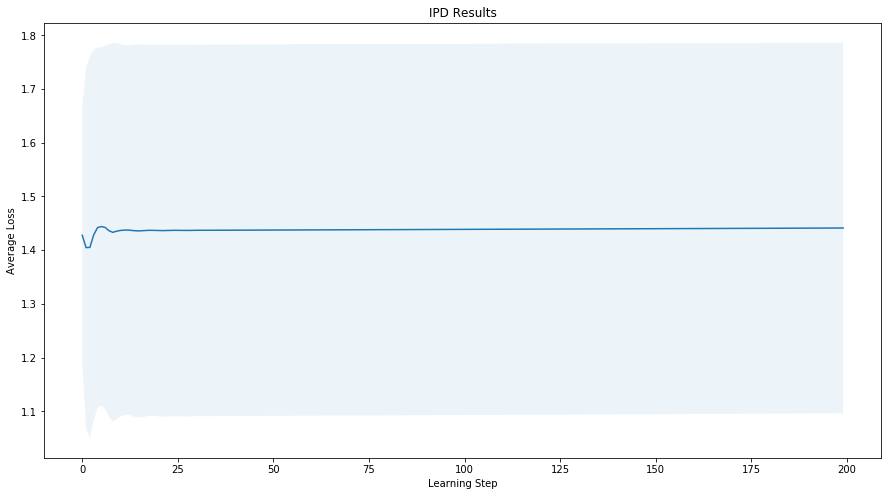

Jax time: 52.182758808135986
[1.42774579 1.41840642 1.45833309 1.48662694 1.47573847 1.47011341
 1.46695853 1.46130664 1.45672522 1.45697419 1.46056724 1.46153776
 1.45958048 1.45777036 1.45778912 1.45935928 1.45989154 1.45899537
 1.45806529 1.45824849 1.45917481 1.45934463 1.45870887 1.4582264
 1.45856281 1.45917212 1.45912537 1.45861207 1.45839435 1.45878543
 1.45918655 1.45903183 1.45862831 1.45857298 1.45894801 1.45919871
 1.4590037  1.45870578 1.45874779 1.45907194 1.4592131  1.45901767
 1.45881428 1.45890955 1.45917093 1.45923675 1.45906169 1.45893638
 1.45905509 1.45925485 1.45927135 1.45912726 1.45906202 1.45918473
 1.4593309  1.45931854 1.45920757 1.459186   1.45930129 1.45940361
 1.45937684 1.45929733 1.45930552 1.45940709 1.45947592 1.45944491
 1.45939325 1.45942001 1.45950574 1.45954971 1.45952087 1.45949194
 1.45952884 1.45959882 1.45962606 1.45960296 1.45959179 1.45963268
 1.45968867 1.45970519 1.45968916 1.45969147 1.45973284 1.45977677
 1.45978735 1.45977895 1.45979044 

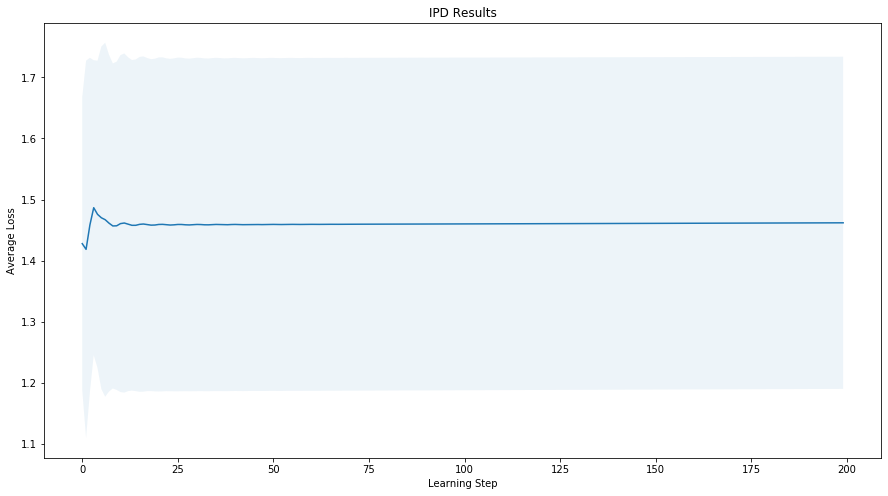

Jax time: 52.1151978969574
[1.42774579 1.42746616 1.48910726 1.49446566 1.47692691 1.46958988
 1.46776427 1.46381474 1.46235514 1.46459305 1.46447969 1.46259902
 1.46209524 1.46332446 1.46347908 1.46194591 1.46166659 1.46266523
 1.46326941 1.46222537 1.46180826 1.46259871 1.4633577  1.46284508
 1.46235711 1.46289912 1.46365788 1.46352992 1.46309294 1.46338899
 1.46407812 1.46419593 1.46387484 1.46398538 1.46456566 1.46483347
 1.46464305 1.46464258 1.46509748 1.46544866 1.46538275 1.46533177
 1.46566411 1.46604914 1.46609401 1.46603507 1.46626119 1.46664126
 1.46677909 1.46674187 1.4668854  1.46723138 1.46744076 1.46744517
 1.46753126 1.46782691 1.46808281 1.46813897 1.46819434 1.46843278
 1.46870953 1.46882065 1.46886748 1.46905264 1.46932758 1.46948762
 1.46954529 1.4696864  1.46994225 1.4701407  1.47022186 1.47033323
 1.47055994 1.47078165 1.47089337 1.47098907 1.47118362 1.47141352
 1.47155706 1.47165122 1.47181527 1.47204074 1.47221187 1.472315
 1.47245531 1.47266701 1.47285787 1.4

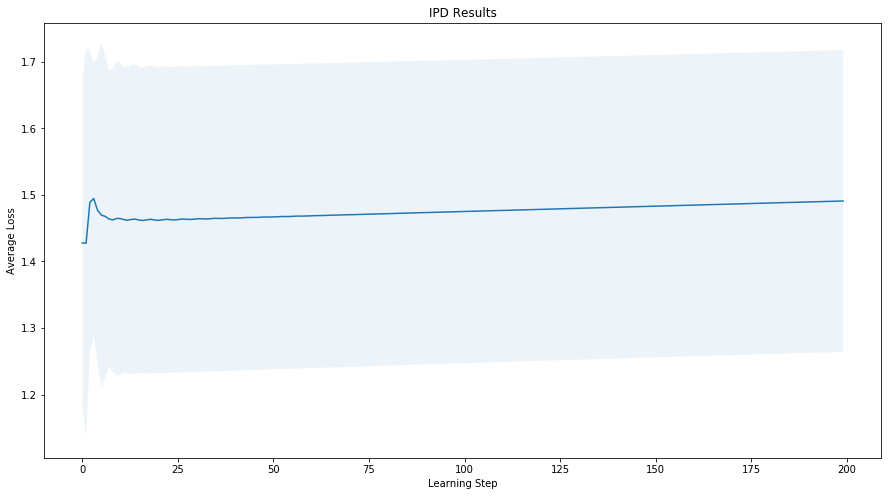

Jax time: 52.25697565078735
[1.42774579 1.4106087  1.42695815 1.46556498 1.48097487 1.48780699
 1.48974637 1.49010591 1.49252386 1.4967672  1.50169253 1.50706233
 1.51209204 1.51579865 1.51897819 1.52288246 1.5275971  1.53284186
 1.53780479 1.54169847 1.54485575 1.54820143 1.55213376 1.55662678
 1.56111826 1.56485346 1.56769561 1.5702636  1.57330528 1.57712498
 1.58132067 1.58490635 1.58728934 1.58924309 1.59192726 1.59578344
 1.60024245 1.6036781  1.60535005 1.6068074  1.60931373 1.6132007
 1.61745789 1.62027449 1.62147128 1.62281378 1.62533238 1.6289871
 1.63253367 1.63483455 1.6361614  1.63775539 1.64036288 1.64365774
 1.64651956 1.64846251 1.64989432 1.65168285 1.65435441 1.65742371
 1.65988728 1.66154945 1.66292023 1.66486055 1.66774023 1.67076711
 1.67282555 1.67407764 1.67543587 1.6778023  1.68110367 1.68360557
 1.68476654 1.6856632  1.68708475 1.68984943 1.69279868 1.69402605
 1.69471059 1.6953713  1.69647665 1.6985414  1.70079522 1.70215825
 1.70282865 1.70327393 1.70407234 1.

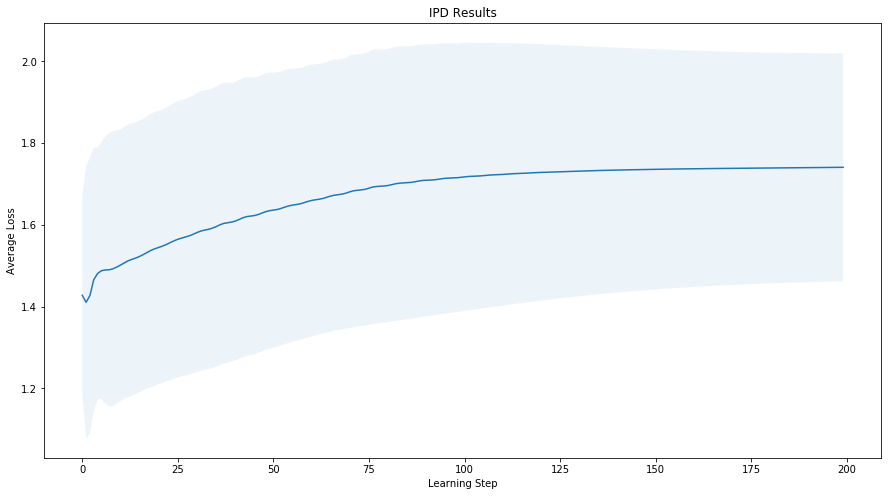

Jax time: 52.757845401763916
[1.42774579 1.44094422 1.53817193 1.62949951 1.68493409 1.71531409
 1.73541474 1.75266137 1.76764389 1.76830887 1.76651311 1.76621485
 1.7664571  1.76603781 1.76580691 1.76501287 1.76235602 1.7575396
 1.75151997 1.74857933 1.74813828 1.74680011 1.7458265  1.74673151
 1.74778885 1.74703974 1.74481109 1.74181351 1.74005172 1.74172939
 1.74695961 1.74737466 1.74351302 1.73835481 1.73411002 1.73437366
 1.73841189 1.74175273 1.73980311 1.73520722 1.73309391 1.73015002
 1.72545758 1.72281166 1.72370228 1.72590032 1.72433564 1.7183393
 1.71009913 1.70307298 1.69815052 1.69479472 1.69287086 1.69299796
 1.69653468 1.70799551 1.72253995 1.73108997 1.72389751 1.70615159
 1.69454702 1.69269823 1.69812095 1.70373603 1.70462068 1.70278424
 1.70176432 1.7026929  1.69744089 1.69073899 1.68909815 1.69012376
 1.6897615  1.68749784 1.68515994 1.68392402 1.68447207 1.68721239
 1.69164006 1.69643194 1.70017605 1.70165622 1.70274617 1.70541552
 1.71168139 1.71483337 1.71228125 1

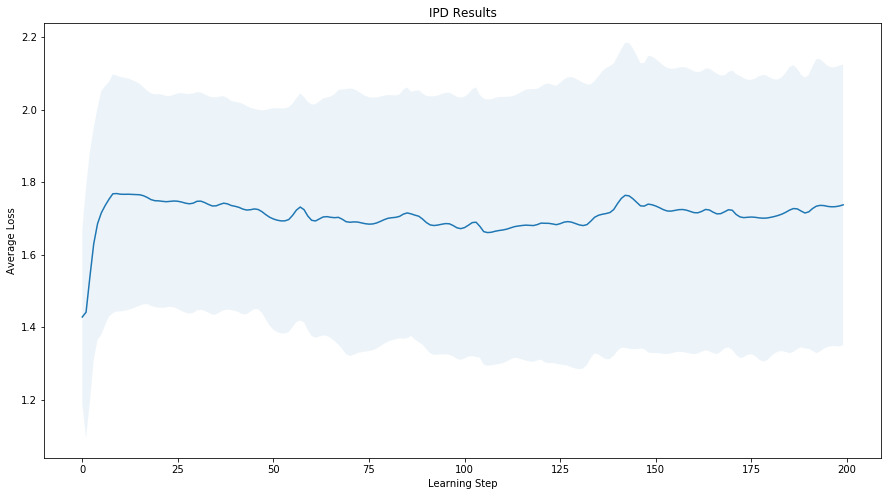

Jax time: 52.18993902206421
[1.42774579 1.42149231 1.46926686 1.49184061 1.47857032 1.47192698
 1.46873344 1.46244718 1.45912643 1.46145446 1.46517916 1.46468924
 1.46227019 1.46128902 1.46298613 1.46442821 1.46350672 1.46220871
 1.46248623 1.46414111 1.46448322 1.46341831 1.46284077 1.46379835
 1.46497625 1.46469864 1.46382096 1.46387691 1.46500196 1.46560742
 1.46507597 1.46456186 1.46505483 1.46601043 1.46616557 1.46564144
 1.46551819 1.46620517 1.46685536 1.46674593 1.46638328 1.4665747
 1.46725305 1.46760597 1.46740331 1.46726033 1.46764084 1.46819183
 1.46832769 1.46815492 1.46821753 1.4686632  1.46904906 1.46906657
 1.4689909  1.46920372 1.46962345 1.46986254 1.46984734 1.46988776
 1.47018051 1.47052681 1.47066572 1.4706755  1.47081618 1.4711287
 1.47139132 1.47148018 1.47154398 1.47175265 1.47204321 1.47223603
 1.47231664 1.47243888 1.47267945 1.47292964 1.47307783 1.47317637
 1.47334602 1.47358913 1.47379803 1.47392689 1.47405423 1.47425291
 1.47448147 1.47465801 1.47478714 1.

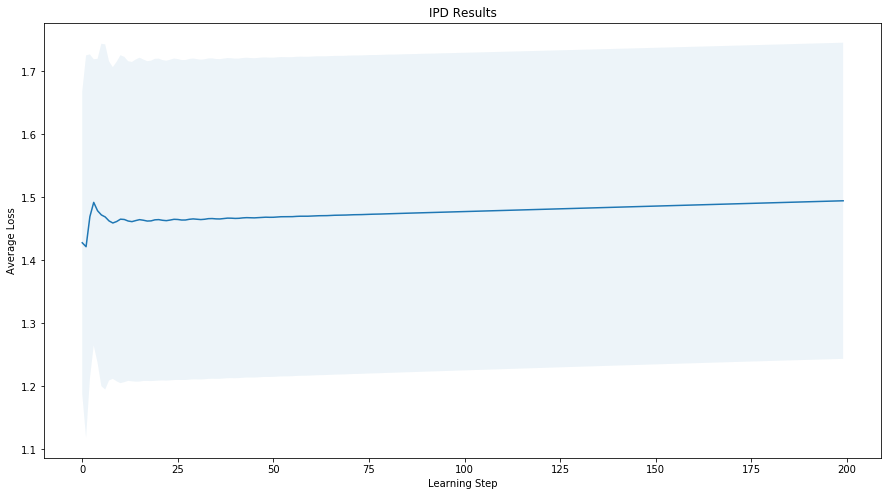

Jax time: 52.11225914955139
[1.42774579 1.56649057 1.81735312 1.8831299  1.90331085 1.93154458
 1.95891249 1.96144419 1.92158589 1.92243862 1.89984971 1.87864384
 1.86666275 1.86783522 1.8610443  1.85600523 1.85013731 1.8350836
 1.81976036 1.80389215 1.79503884 1.78708179 1.78757001 1.78701549
 1.77775792 1.77807297 1.7736424  1.77023232 1.76569995 1.7656106
 1.77457536 1.7935939  1.80012828 1.80454988 1.81611793 1.82493919
 1.82901959 1.82470356 1.81423782 1.80621346 1.80368102 1.79711335
 1.79117762 1.78819894 1.78553993 1.78330349 1.78396256 1.79021485
 1.80140735 1.80269147 1.79452422 1.79154999 1.79314839 1.79281977
 1.79243496 1.79215424 1.79158377 1.78851112 1.78335889 1.77774271
 1.76765862 1.76078568 1.75977227 1.75951553 1.75876487 1.76152516
 1.7624298  1.76365497 1.76696192 1.77418425 1.77839364 1.78012557
 1.77876406 1.77698462 1.77753213 1.77674858 1.77577331 1.77515401
 1.77483568 1.7746294  1.7744425  1.77419974 1.77373394 1.77235169
 1.76500015 1.75060216 1.75156502 1.

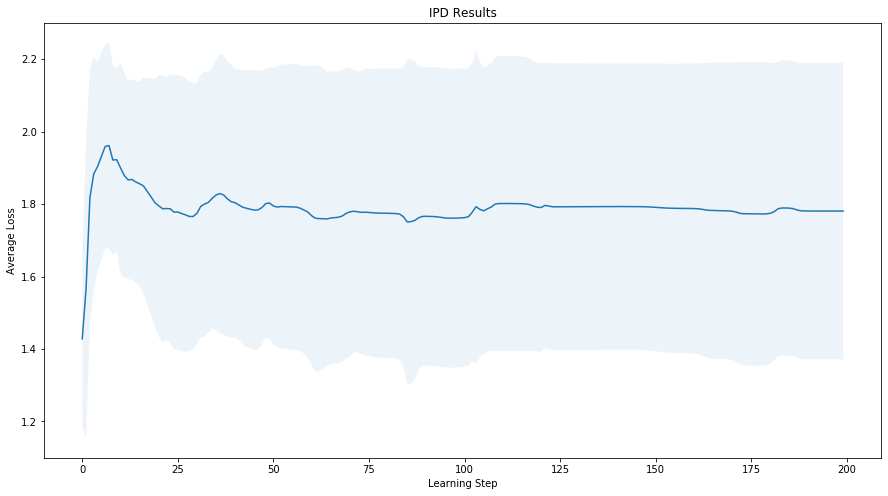

Jax time: 52.60527586936951
[1.42774579 1.41031583 1.4275007  1.46014154 1.4655394  1.46354558
 1.45787069 1.45356893 1.45423707 1.45480467 1.45552736 1.45639518
 1.45638408 1.45609948 1.45644386 1.45711612 1.4576679  1.45808874
 1.45845905 1.45892175 1.45947125 1.45992204 1.46023472 1.46055756
 1.46101593 1.46159187 1.46213841 1.46254301 1.46285833 1.46321972
 1.46369834 1.46424144 1.46473787 1.46513986 1.46550157 1.46590568
 1.46637936 1.46687735 1.46733914 1.46775064 1.46814958 1.46857727
 1.46903939 1.46950689 1.46995213 1.47037413 1.47079457 1.47123154
 1.47168276 1.47213364 1.47257233 1.47300165 1.473432   1.47387095
 1.47431513 1.47475783 1.47519443 1.4756273  1.47606145 1.47649966
 1.4769396  1.47737773 1.47781332 1.47824781 1.47868271 1.47911911
 1.47955606 1.47999201 1.48042664 1.48086076 1.48129494 1.4817301
 1.48216502 1.48259892 1.48303229 1.48346551 1.48389881 1.48433213
 1.48476508 1.48519744 1.48562951 1.48606124 1.48649267 1.48692413
 1.48735536 1.48778619 1.48821645 1

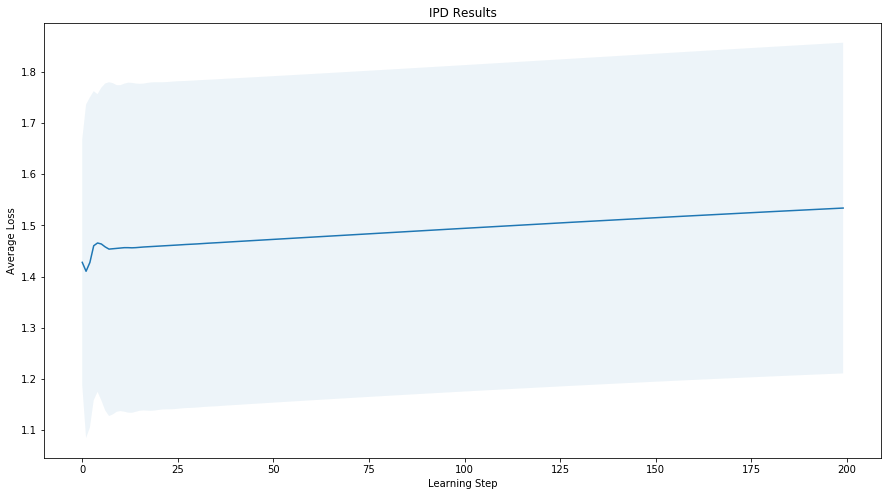

Jax time: 52.03041982650757
[1.42774579 1.44136929 1.56028062 1.6522082  1.69978388 1.72197156
 1.73672026 1.7422434  1.74944558 1.75215623 1.75374257 1.74911251
 1.7398344  1.73296372 1.73146868 1.73074883 1.7235827  1.71425587
 1.70940304 1.7093343  1.71051668 1.71237812 1.71163433 1.7040923
 1.69563198 1.68776066 1.68848161 1.69265615 1.68923863 1.68243867
 1.67690071 1.67492069 1.67446305 1.67641906 1.6795633  1.67849765
 1.67389142 1.66866941 1.66372046 1.6612894  1.66520985 1.66937119
 1.6726466  1.67300472 1.66654287 1.6551538  1.64362079 1.63679554
 1.63760755 1.64334235 1.64711237 1.64458013 1.63622814 1.62924595
 1.6277252  1.63262763 1.64225962 1.65070053 1.65145303 1.64289963
 1.63163047 1.6274866  1.63064252 1.63725028 1.64132488 1.63841378
 1.63595352 1.63747207 1.64173708 1.64778286 1.65404798 1.65424378
 1.64875617 1.64340363 1.64046645 1.64030582 1.6432147  1.6461993
 1.64286864 1.63608681 1.63123141 1.63015815 1.63258403 1.6381736
 1.64317008 1.64525034 1.64316947 1.6

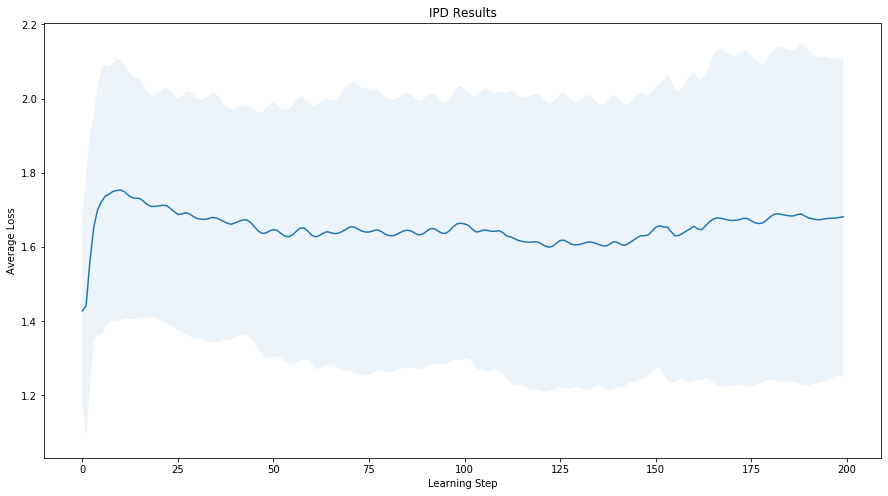

Jax time: 52.7987802028656
[1.42774579 1.57487968 1.82000573 1.86206655 1.88651559 1.8504758
 1.82535682 1.82485685 1.84554339 1.86117949 1.85510344 1.85189521
 1.84457393 1.84455317 1.85422464 1.85612714 1.85818759 1.85742064
 1.85455558 1.83444122 1.81949862 1.82191628 1.78824591 1.77051487
 1.75943475 1.7529417  1.74577965 1.75424494 1.76180075 1.75407435
 1.75990327 1.75875468 1.75793092 1.75693757 1.75154045 1.7476013
 1.74969476 1.75124721 1.75013069 1.74504902 1.74296313 1.7408699
 1.73799089 1.73564837 1.73905713 1.74079442 1.74618451 1.75103277
 1.74454631 1.73573501 1.73465264 1.73667282 1.73714196 1.73032222
 1.72943805 1.72601578 1.72825593 1.72587459 1.72670157 1.72646628
 1.7282079  1.72868379 1.72837379 1.72751257 1.72599797 1.72324215
 1.71868583 1.7151171  1.71208975 1.71922428 1.71871326 1.72034107
 1.71225631 1.70661408 1.71532399 1.72389328 1.719763   1.72386625
 1.72007868 1.72638094 1.72593852 1.72643156 1.7262336  1.72583033
 1.72447475 1.72175487 1.72216331 1.72

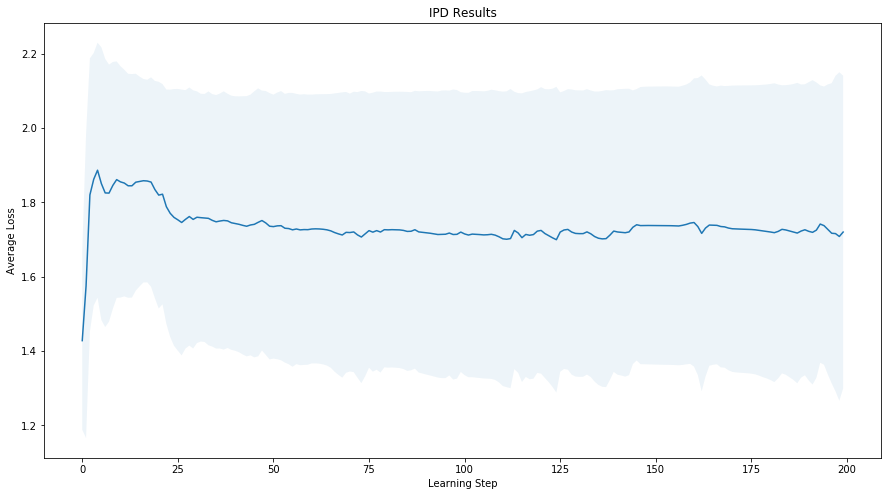

Jax time: 52.05353379249573
[1.42774579 1.68933023 1.89841836 1.96173979 1.98478732 1.97357435
 1.96107452 1.93690733 1.94843536 1.94421026 1.9410279  1.93552566
 1.94029409 1.94395722 1.94244334 1.94406292 1.96190384 1.9628113
 1.96029658 1.9490126  1.94295359 1.93421473 1.93343277 1.93620309
 1.94578687 1.94490895 1.93972961 1.93736054 1.93660042 1.93715087
 1.93970525 1.94910043 1.94968898 1.94928605 1.94846572 1.94420964
 1.93655598 1.9352514  1.93525005 1.93537488 1.93551671 1.93565903
 1.93578943 1.93587921 1.93585176 1.93546983 1.93398378 1.93047943
 1.92331972 1.93417925 1.93656174 1.93674194 1.93674293 1.93661544
 1.93617171 1.93435459 1.92926717 1.92928244 1.93225855 1.94285353
 1.94606842 1.94630092 1.94637542 1.94643229 1.94648885 1.94654878
 1.94661418 1.94668829 1.94677172 1.94686925 1.94698446 1.9471194
 1.94727369 1.94743843 1.94760034 1.94774379 1.94786244 1.94795615
 1.94803073 1.94809106 1.94814095 1.94818463 1.9482238  1.9482603
 1.94829481 1.94832852 1.94836364 1.9

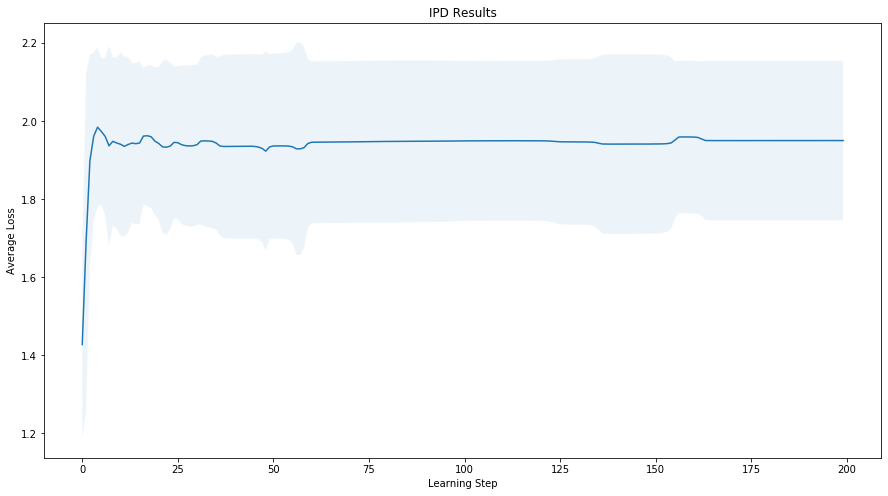

Jax time: 52.19463896751404
[1.42774579 1.40747568 1.41613111 1.44543199 1.45501225 1.4557548
 1.45123219 1.44489471 1.44467814 1.446431   1.44728319 1.44786823
 1.4478441  1.44743711 1.447467   1.44803432 1.44859351 1.44880381
 1.44877084 1.44879534 1.44910086 1.44960497 1.4500125  1.45016363
 1.45017773 1.45028037 1.45058732 1.45101183 1.45136434 1.45155179
 1.45164973 1.45180131 1.45207805 1.45242707 1.45273757 1.45295295
 1.45311381 1.45330165 1.45355955 1.45385934 1.45414032 1.45437041
 1.45456906 1.4547806  1.45502897 1.45530051 1.4555638  1.45580029
 1.4560198  1.45624535 1.45648966 1.45674638 1.45699923 1.45723877
 1.45746933 1.45770225 1.4579447  1.45819396 1.4584416  1.45868227
 1.45891838 1.45915518 1.45939716 1.45964248 1.45988715 1.46012829
 1.46036733 1.46060636 1.46084815 1.46109139 1.4613344  1.46157577
 1.46181614 1.46205663 1.46229813 1.46254049 1.46278252 1.46302432
 1.46326527 1.46350625 1.4637477  1.46398935 1.4642314  1.4644726
 1.46471388 1.46495519 1.46519664 1.

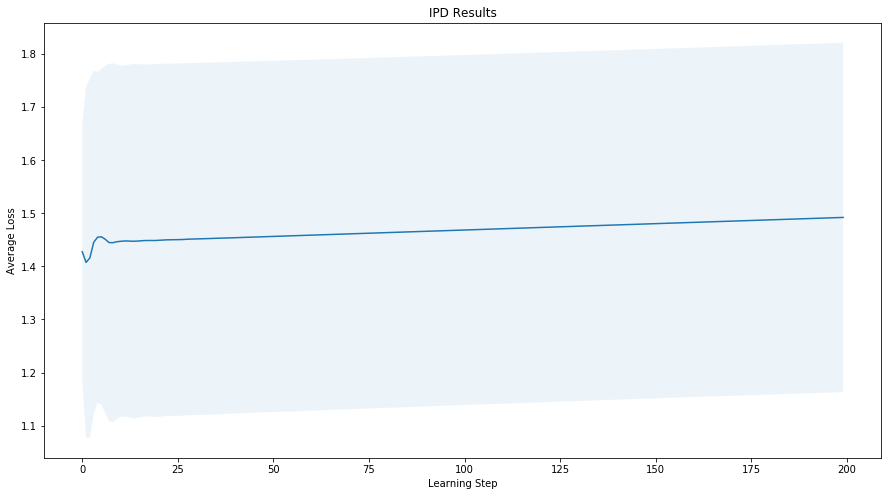

Jax time: 51.56212592124939
[1.42774579 1.42133045 1.46876708 1.49116421 1.47771093 1.47085567
 1.46742785 1.461018   1.45760582 1.45978414 1.46329466 1.46258667
 1.46004439 1.45895036 1.46047458 1.46170193 1.46060484 1.45919522
 1.45933141 1.46079377 1.46093463 1.45972193 1.45902533 1.45982205
 1.46080355 1.46034312 1.45933092 1.45925444 1.46020736 1.46062041
 1.45992292 1.45927688 1.45962476 1.46040221 1.4603731  1.45969484
 1.45943608 1.45996745 1.46043859 1.46015499 1.45964469 1.45969374
 1.46020988 1.46038571 1.46001753 1.45972825 1.45996029 1.46034491
 1.46030751 1.45997581 1.4598914  1.46018319 1.46040082 1.46025
 1.46001949 1.46008251 1.46034403 1.46041554 1.46023653 1.4601233
 1.46026457 1.46044943 1.4604218  1.46027163 1.46025981 1.46041707
 1.46051672 1.46044174 1.46034775 1.46040328 1.46053682 1.46056641
 1.46048505 1.4604516  1.46053743 1.46062894 1.46061425 1.46055321
 1.46056754 1.46065537 1.46070387 1.46067086 1.46064057 1.46068456
 1.46075611 1.46077186 1.46074033 1.46

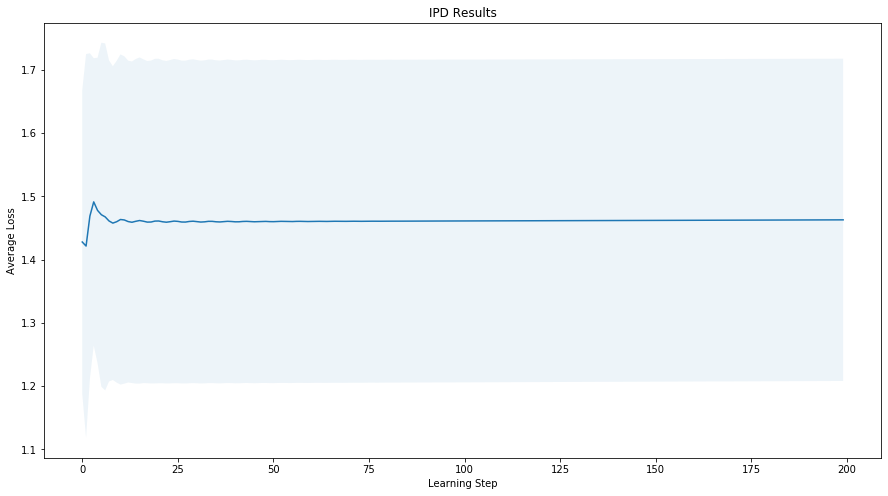

Jax time: 51.806349754333496
[1.42774579 1.41014715 1.42682791 1.45896108 1.46414513 1.46190523
 1.4558521  1.45127016 1.4518703  1.45227507 1.45276037 1.45331792
 1.45303481 1.45261362 1.45284664 1.45333039 1.45360528 1.45372076
 1.45384038 1.45413121 1.45452717 1.45477142 1.45482152 1.45487677
 1.45511109 1.45550444 1.45586456 1.45604347 1.45610595 1.45622618
 1.45649644 1.45684783 1.45713732 1.45730505 1.45742459 1.45760367
 1.45787348 1.45817087 1.45841426 1.45859207 1.45875841 1.45896958
 1.45922696 1.45948542 1.45970813 1.45990039 1.46009674 1.46032002
 1.46056307 1.46080018 1.46101619 1.46122101 1.46143206 1.46165814
 1.46189093 1.46211741 1.46233343 1.46254589 1.46276381 1.46298873
 1.46321555 1.4634378  1.46365473 1.46387169 1.46409215 1.46431543
 1.46453865 1.46475905 1.46497796 1.46519687 1.46541803 1.4656401
 1.46586165 1.46608167 1.46630103 1.4665213  1.46674209 1.46696339
 1.46718377 1.46740389 1.46762355 1.46784406 1.46806459 1.46828511
 1.46850537 1.46872564 1.46894544 

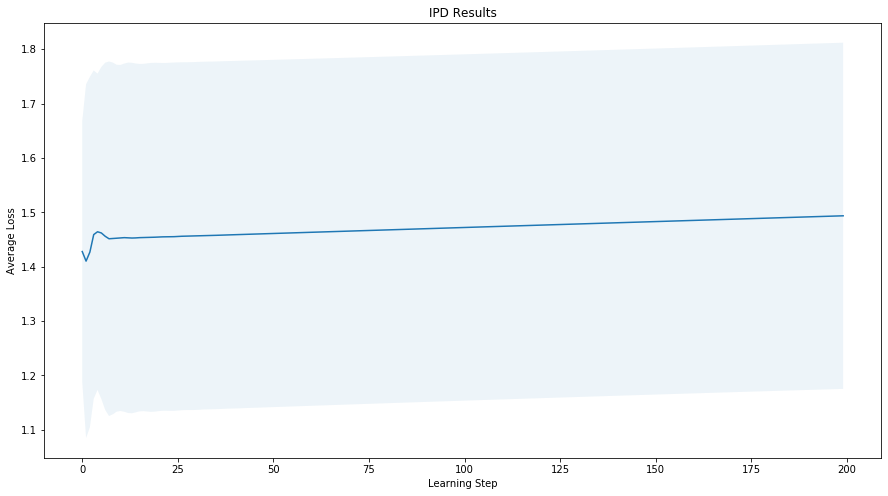

Jax time: 52.80998468399048
[1.42774579 1.6457857  1.86594829 1.94152964 1.96331708 1.98416033
 1.95931929 1.96278348 1.9680501  1.988655   1.9718115  1.97827256
 1.9888045  1.98435289 1.98712608 1.99477655 1.97833991 1.9758714
 1.97798871 1.96180798 1.95599731 1.94388518 1.92847291 1.91013874
 1.90072575 1.89493493 1.89496248 1.88851894 1.87906287 1.87149724
 1.8635254  1.85005301 1.83810733 1.82565512 1.82107773 1.81817286
 1.81521641 1.81476508 1.81456257 1.81433637 1.81396987 1.813311
 1.81243841 1.81185647 1.81150012 1.81117661 1.81376111 1.81552885
 1.81551974 1.81477204 1.81753112 1.82777277 1.82924973 1.82873875
 1.82796906 1.82684837 1.8369275  1.8312642  1.829742   1.82940575
 1.82943047 1.82954045 1.82968492 1.82985408 1.83005038 1.83028933
 1.83061469 1.83114043 1.83224275 1.83540406 1.84059638 1.83298518
 1.83112244 1.8283412  1.82547019 1.82372362 1.82342198 1.82330429
 1.8232344  1.82318504 1.82314738 1.82311595 1.82308808 1.82306263
 1.82303716 1.82301168 1.82298419 1.8

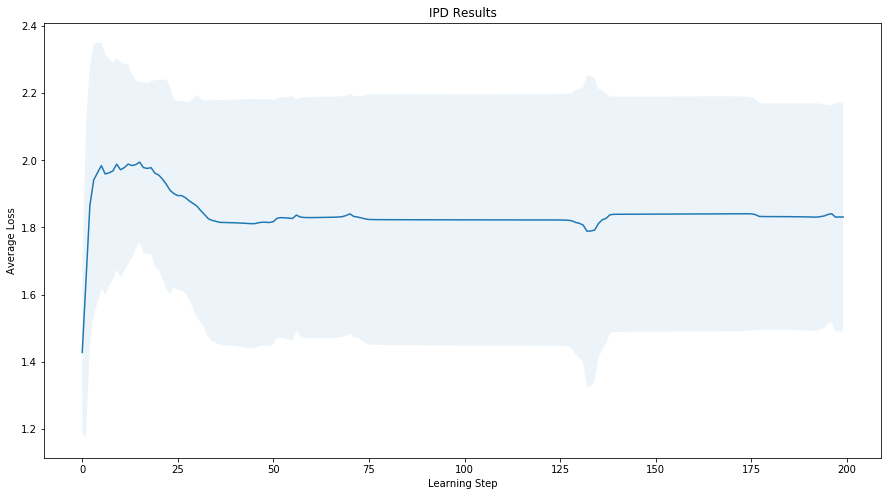

Jax time: 52.16536569595337
[1.42774579 1.40734278 1.41558746 1.44436774 1.45374789 1.45427421
 1.44952437 1.44293791 1.4425948  1.44420092 1.44484014 1.44516626
 1.44486418 1.44423629 1.44413484 1.44459288 1.44499719 1.4449897
 1.44470094 1.44448648 1.44460732 1.44496471 1.44521565 1.44517038
 1.44496037 1.44484496 1.44496217 1.4452173  1.44539368 1.445382
 1.44526898 1.44521821 1.44530998 1.44548103 1.44560453 1.44561777
 1.44557257 1.44556411 1.44563819 1.44575702 1.44584689 1.44587442
 1.44586956 1.44588715 1.44595077 1.4460385  1.44610943 1.44614504
 1.44616344 1.44619495 1.44625285 1.4463232  1.44638333 1.44642416
 1.4464557  1.44649491 1.44654859 1.4466092  1.44666399 1.4467078
 1.44674654 1.44679018 1.44684149 1.44689672 1.44694852 1.446994
 1.44703698 1.44708258 1.44713289 1.44718473 1.44723469 1.44728154
 1.4473268  1.44737367 1.44742301 1.44747344 1.44752267 1.44756988
 1.44761637 1.44766411 1.44771279 1.44776208 1.44781107 1.44785879
 1.44790581 1.44795376 1.44800248 1.4480

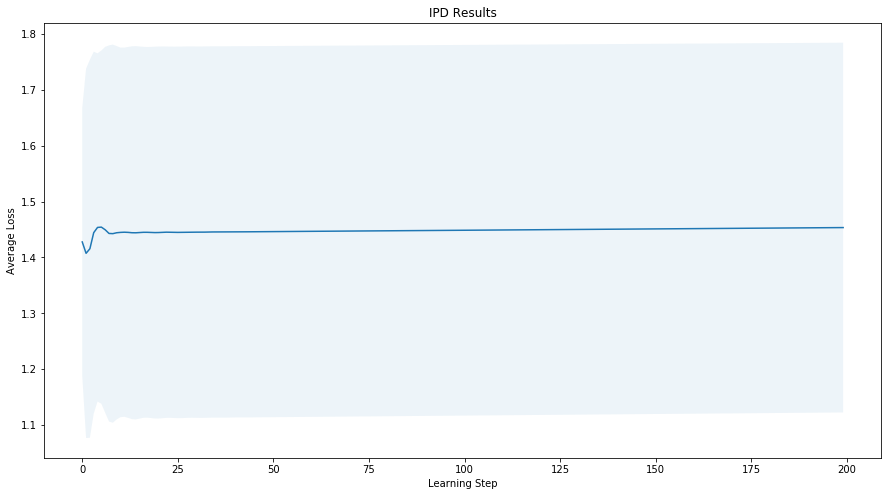

Jax time: 51.9286949634552
[1.42774579 1.42611399 1.48551796 1.50118318 1.48762253 1.48220526
 1.48186601 1.47769766 1.47638418 1.48058024 1.48475399 1.48470781
 1.4839114  1.48567795 1.4896218  1.49103225 1.49058881 1.49151533
 1.49491065 1.49749279 1.49770386 1.49799557 1.50042138 1.50353188
 1.50473515 1.50491836 1.50638831 1.50928542 1.51133538 1.51192423
 1.51278074 1.51506606 1.51750857 1.51870348 1.51939487 1.52103562
 1.52342987 1.52513966 1.52600092 1.52718832 1.52926897 1.53126568
 1.53243932 1.5334284  1.53511943 1.53716597 1.53864673 1.53964434
 1.54100024 1.54291946 1.54462095 1.54574853 1.54688745 1.54857816
 1.55038539 1.55169098 1.5527376  1.55417162 1.55596526 1.55744837
 1.55850676 1.55971234 1.56138566 1.56300939 1.56415948 1.56520269
 1.56667444 1.5683675  1.56966549 1.57063345 1.57186323 1.57352099
 1.57499679 1.57599188 1.57698704 1.57847785 1.58011417 1.5812631
 1.58208386 1.58325906 1.58495805 1.58642998 1.58722277 1.58789191
 1.58938268 1.5914273  1.59259602 1.

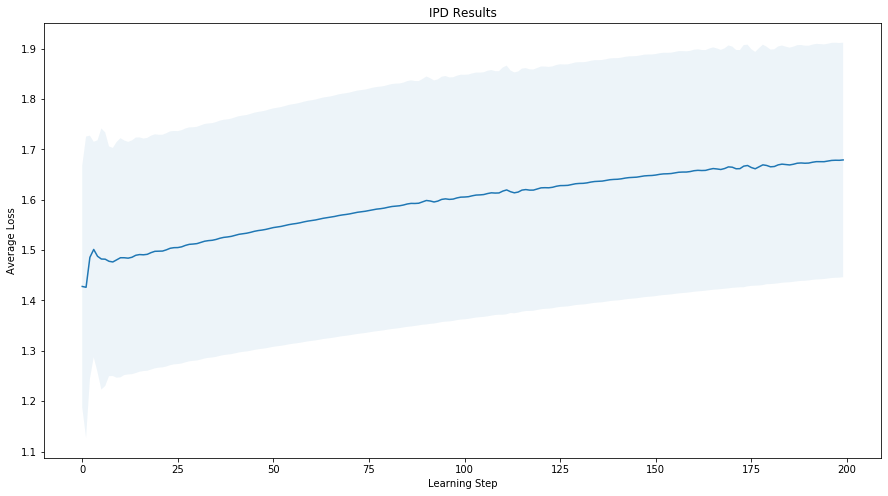

Jax time: 51.62816548347473
[1.42774579 1.4073132  1.41548554 1.44417524 1.45350195 1.45397346
 1.44916241 1.44251675 1.44214906 1.44372395 1.44431506 1.44458143
 1.44421559 1.44353881 1.44340958 1.44384368 1.44421286 1.44415455
 1.44380743 1.44353965 1.44362032 1.44394612 1.44416085 1.44406988
 1.44380869 1.44364514 1.443721   1.44393843 1.4440745  1.44401723
 1.44385672 1.44376032 1.44381121 1.44394355 1.44402406 1.44399107
 1.44389925 1.44384741 1.44388089 1.44395928 1.44400589 1.44398737
 1.44393669 1.4439107  1.4439336  1.44398074 1.44400768 1.44399816
 1.44397107 1.44395922 1.44397592 1.4440049  1.44402145 1.44401705
 1.44400374 1.44399984 1.44401161 1.44403039 1.44404159 1.44404062
 1.44403512 1.44403516 1.44404447 1.44405722 1.44406531 1.44406672
 1.44406568 1.44406796 1.44407568 1.44408464 1.44409111 1.44409411
 1.44409542 1.44409876 1.44410551 1.44411273 1.44411842 1.44412187
 1.444125   1.44412912 1.44413488 1.44414099 1.44414628 1.44415034
 1.44415397 1.44415854 1.44416386 

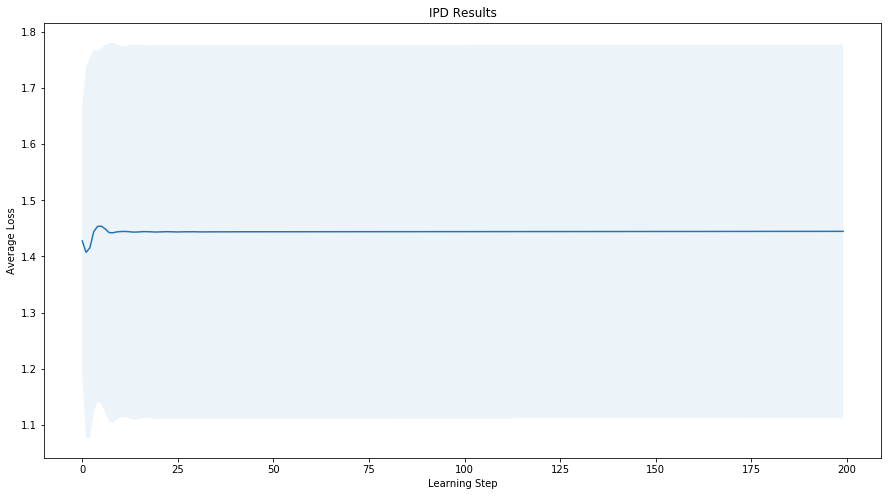

Jax time: 51.64347553253174
[1.42774579 1.4101463  1.42672786 1.45877344 1.46400413 1.46179821
 1.45575541 1.45116583 1.45176349 1.45217329 1.45266598 1.45322344
 1.45293198 1.45250603 1.45274204 1.45323359 1.45351629 1.45363106
 1.45374342 1.454029   1.45442563 1.45467645 1.45473106 1.45478624
 1.45501654 1.45540706 1.45576816 1.45595047 1.45601566 1.45613536
 1.4564037  1.45675431 1.45704474 1.45721416 1.45733481 1.45751351
 1.45778297 1.45807998 1.45832443 1.45850304 1.45867031 1.45888118
 1.45913832 1.45939732 1.45962062 1.45981369 1.46000938 1.46023339
 1.46047663 1.46071406 1.46093095 1.46113542 1.46134699 1.46157338
 1.46180671 1.46203328 1.46224972 1.46246227 1.46268073 1.46290616
 1.46313314 1.46335522 1.46357291 1.46379042 1.46401113 1.46423497
 1.46445834 1.46467911 1.46489779 1.46511756 1.46533898 1.46556105
 1.46578316 1.46600346 1.46622304 1.46644373 1.46666487 1.46688627
 1.46710742 1.46732803 1.46754789 1.46776872 1.4679896  1.46821033
 1.46843103 1.46865157 1.4688717  

Jax time: 51.550360441207886
[1.42774579 1.42493357 1.48224836 1.50799157 1.4984674  1.49567784
 1.49763478 1.49471296 1.49325286 1.49823325 1.50597032 1.51004153
 1.51054586 1.51191941 1.51694565 1.52247309 1.52501977 1.52606781
 1.52901349 1.53427453 1.53834341 1.54012282 1.54180469 1.54565423
 1.55036199 1.55333433 1.55487365 1.55722819 1.56138581 1.565318
 1.56751142 1.56903828 1.57194439 1.57610783 1.57928826 1.58070583
 1.58221769 1.58579644 1.59010183 1.59212613 1.59212761 1.59394044
 1.59885765 1.60288021 1.60261471 1.60185942 1.60480087 1.60914642
 1.61167004 1.61233392 1.61389658 1.61711365 1.61976753 1.62097648
 1.62261482 1.62600522 1.62813534 1.62755601 1.62805691 1.63400794
 1.63883249 1.63597719 1.63253146 1.63186972 1.63348979 1.6365202
 1.63921853 1.64035247 1.64043349 1.64200161 1.64509179 1.64765341
 1.64792508 1.64773974 1.64985962 1.65300727 1.65476765 1.65449144
 1.65512155 1.65799494 1.66087857 1.66141872 1.66083211 1.66249953
 1.66615797 1.66820133 1.66735415 1.

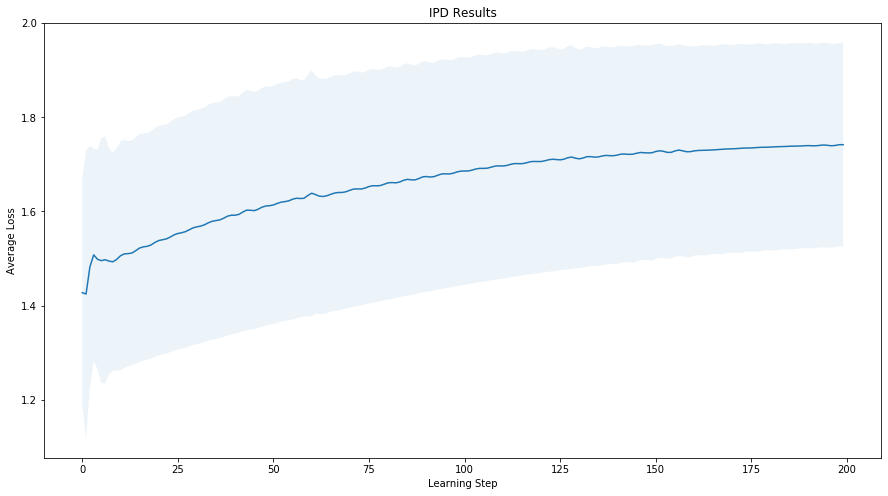

Jax time: 51.63631081581116
[1.42774579 1.43097501 1.4991333  1.50753421 1.49355532 1.49041121
 1.49283862 1.49139958 1.49203632 1.497893   1.50198898 1.50278383
 1.5042312  1.50871053 1.51319525 1.51472084 1.51612497 1.51998246
 1.52465436 1.52687166 1.52821644 1.53150542 1.53597194 1.5387201
 1.540163   1.54296351 1.54711451 1.5501552  1.55176393 1.55412771
 1.55795396 1.56114685 1.56292616 1.5649112  1.56836423 1.57165092
 1.57359354 1.57529743 1.57830584 1.58162443 1.58372462 1.58525316
 1.58782361 1.59109507 1.59327415 1.59462917 1.59697038 1.60030514
 1.60216053 1.60275208 1.60528016 1.60984112 1.61064822 1.60861679
 1.60707056 1.60947091 1.61434205 1.61715761 1.61608838 1.6160236
 1.61945236 1.62252379 1.62374006 1.62483234 1.62727784 1.62983951
 1.63139687 1.63268744 1.63478807 1.63717094 1.63881603 1.64006993
 1.64189676 1.64416881 1.64588418 1.6470886  1.64866255 1.65079741
 1.65256859 1.65375572 1.65512622 1.65708261 1.65886626 1.66005318
 1.66131007 1.66308044 1.66480541 1.

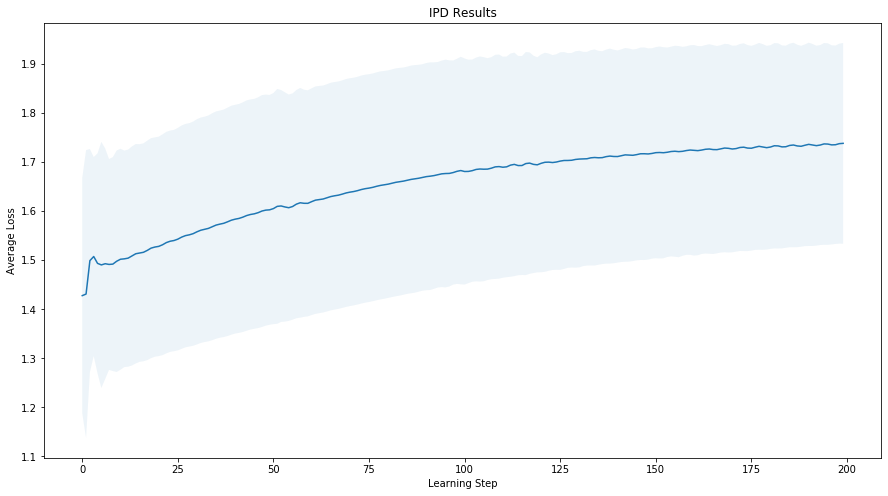

Jax time: 52.53575778007507
[1.42774579 1.42728498 1.48858852 1.49379608 1.47607219 1.46852254
 1.46646085 1.46237331 1.46080994 1.46286747 1.462527   1.46050928
 1.45990679 1.46096032 1.46087245 1.45917668 1.45881141 1.45964938
 1.46002378 1.45879804 1.45828675 1.45893363 1.4594811  1.45877914
 1.45817797 1.45858807 1.45915145 1.45883333 1.45826581 1.45843249
 1.45893962 1.45887014 1.45840545 1.45838549 1.45879329 1.45887677
 1.45853551 1.45840123 1.45869018 1.45885925 1.45863837 1.45845115
 1.45862262 1.45882627 1.45871247 1.45851578 1.45858583 1.45878521
 1.45876023 1.45858452 1.4585768  1.45874408 1.45878465 1.45864826
 1.45858945 1.45870996 1.45879115 1.45870282 1.45861759 1.45868711
 1.4587848  1.45874458 1.45865434 1.45867822 1.45877244 1.45877354
 1.45869395 1.45868233 1.4587591  1.45878986 1.45873161 1.45869729
 1.45874957 1.45879739 1.45876392 1.45871961 1.45874654 1.45879865
 1.45878948 1.45874549 1.4587509  1.45879782 1.45880767 1.45877258
 1.45876179 1.45879798 1.45882057 

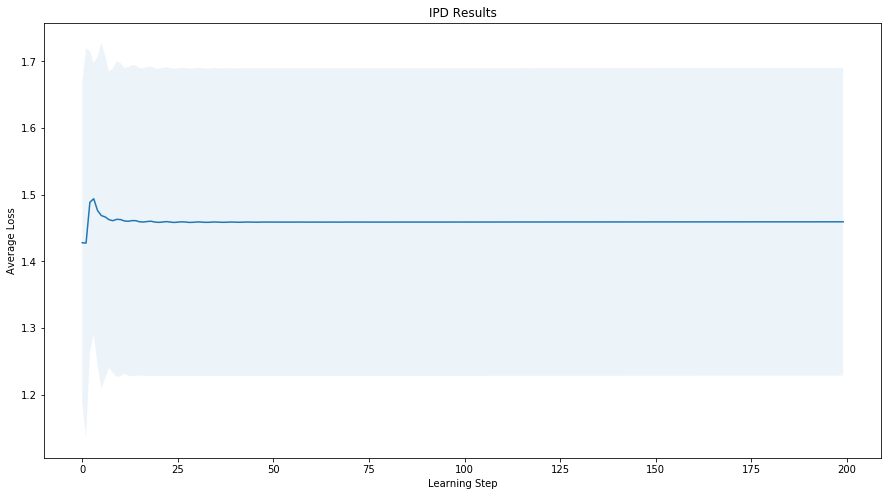

Jax time: 52.13187217712402
[1.42774579 1.42195624 1.47195813 1.50491161 1.49752998 1.4957031
 1.49822193 1.49599004 1.49320638 1.49638158 1.5044066  1.5110395
 1.51301162 1.51330858 1.51601364 1.52164487 1.52661189 1.52896094
 1.5304468  1.53367735 1.53851354 1.54250631 1.54473504 1.5466761
 1.55006638 1.55440063 1.55783819 1.55989686 1.56196549 1.56540142
 1.56949737 1.57249899 1.57409752 1.57606257 1.57980271 1.58402041
 1.58619967 1.58662973 1.58855562 1.59330637 1.5976919  1.5981694
 1.59730559 1.59954676 1.60432243 1.60821557 1.60903619 1.60912216
 1.61158266 1.61579309 1.61891208 1.61944101 1.61993582 1.62270922
 1.62653419 1.62871198 1.62892409 1.6302813  1.63345134 1.63583013
 1.63637894 1.63767642 1.64260125 1.64407961 1.64185867 1.64059199
 1.64137582 1.64591889 1.64946046 1.64989345 1.64921909 1.65010912
 1.65392951 1.65726753 1.65784119 1.65686963 1.65760388 1.66136736
 1.66471297 1.66492805 1.66346162 1.66427478 1.66822161 1.67130397
 1.67096194 1.66947612 1.67083624 1.67

Jax time: 51.63210868835449
[1.42774579 1.45764799 1.59368939 1.64639458 1.66221553 1.65839413
 1.66383736 1.6798708  1.68904803 1.69418962 1.69928542 1.70878528
 1.71796317 1.72468912 1.72926665 1.73094105 1.73675083 1.73991956
 1.73579231 1.72825468 1.72511722 1.73390037 1.73856401 1.73540227
 1.72886137 1.72624008 1.73236563 1.73719579 1.73275217 1.72576735
 1.72262171 1.73027049 1.73859372 1.73704996 1.73295149 1.73222414
 1.73791843 1.74393045 1.74115459 1.73844968 1.74247348 1.75006376
 1.75032132 1.73987524 1.73335445 1.7334884  1.73672009 1.73801633
 1.73229891 1.73025387 1.73502697 1.73811007 1.73837321 1.73480609
 1.73497468 1.73916882 1.74051646 1.74120986 1.73951787 1.73923015
 1.74527715 1.74978155 1.74560127 1.73693268 1.73477889 1.74127069
 1.74455374 1.73540558 1.72052065 1.71447845 1.71311693 1.71611968
 1.71643265 1.71413382 1.71393819 1.71675794 1.72295126 1.72825236
 1.72712746 1.72434746 1.7224505  1.72320687 1.73096674 1.73646242
 1.73396372 1.73214919 1.73376279 

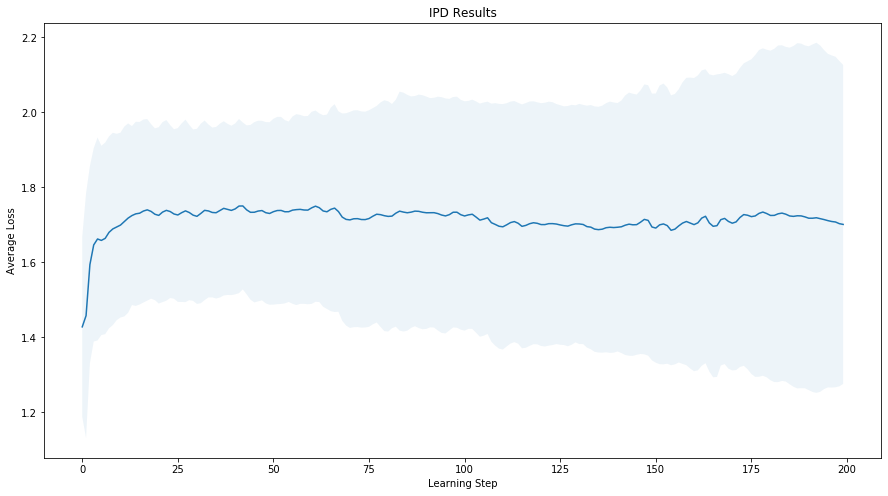

Jax time: 52.351094007492065
[1.42774579 1.69626097 1.90215219 1.9592327  1.97632314 1.96083357
 1.95286536 1.93286516 1.94826802 1.95392064 1.96051478 1.97140692
 1.96365027 1.95220218 1.96007307 1.96235778 1.97013986 1.97296807
 1.96621266 1.96562998 1.97019198 1.97529778 1.96787785 1.95685929
 1.95197812 1.9505862  1.94975957 1.94898985 1.94734168 1.94035192
 1.93570444 1.92889943 1.9245247  1.918999   1.92856289 1.9344213
 1.93494096 1.9352825  1.93560429 1.93591066 1.9361923  1.93644408
 1.93666762 1.93686901 1.93705526 1.93723223 1.93740109 1.9375581
 1.93769877 1.93781685 1.93791433 1.93799822 1.93807296 1.93814147
 1.93820543 1.93826652 1.93832436 1.93837909 1.93843118 1.93848025
 1.93852702 1.93857038 1.9386115  1.93865051 1.9386874  1.93872203
 1.93875473 1.93878614 1.93881542 1.93884345 1.9388703  1.93889561
 1.93891961 1.93894261 1.93896448 1.9389859  1.93900541 1.93902433
 1.93904269 1.93906075 1.93907791 1.93909423 1.93910963 1.9391249
 1.93913921 1.93915321 1.93916688 1.

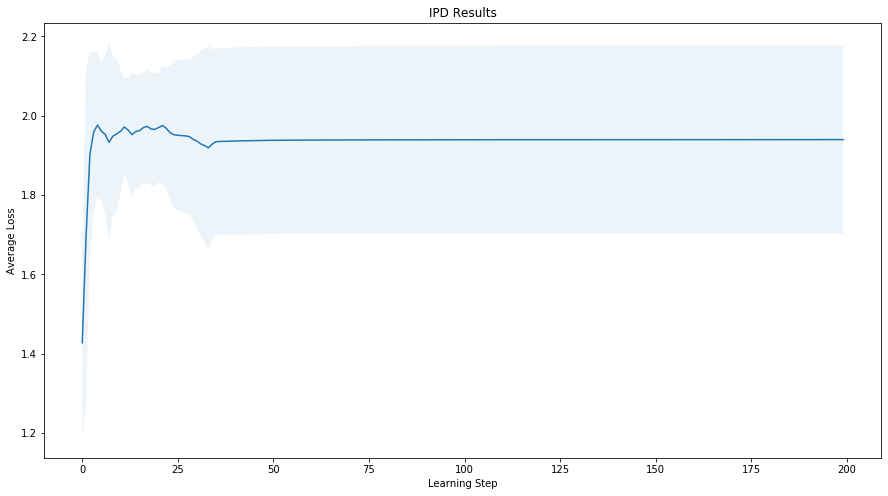

Jax time: 52.23440408706665
[1.42774579 1.42429921 1.47893791 1.49337879 1.47800832 1.47043967
 1.46729621 1.46160281 1.45939442 1.46201619 1.46381313 1.4618439
 1.45999062 1.46030523 1.46211224 1.46133326 1.45959407 1.45933223
 1.46085051 1.46123233 1.45978049 1.45895754 1.45980096 1.46085218
 1.46018981 1.45910635 1.45923623 1.46026149 1.46039442 1.45952207
 1.45913528 1.45976069 1.46031093 1.45990955 1.45933574 1.45950548
 1.46008212 1.46011338 1.45964399 1.45949185 1.45987293 1.46014169
 1.45991083 1.45963463 1.45977261 1.46007896 1.46007271 1.45983227
 1.4597898  1.46001157 1.46013891 1.46001072 1.45988886 1.45998941
 1.46015098 1.46013759 1.46002062 1.4600245  1.4601536  1.46021429
 1.46014737 1.46010159 1.46017329 1.4602605  1.46025065 1.46019935
 1.46021964 1.46029716 1.46032895 1.46029787 1.46028815 1.46033937
 1.46038969 1.46038683 1.46036918 1.46039382 1.46044332 1.46046289
 1.4604528  1.46045989 1.46049765 1.46052976 1.46053277 1.46053302
 1.46055747 1.46059152 1.46060703 1

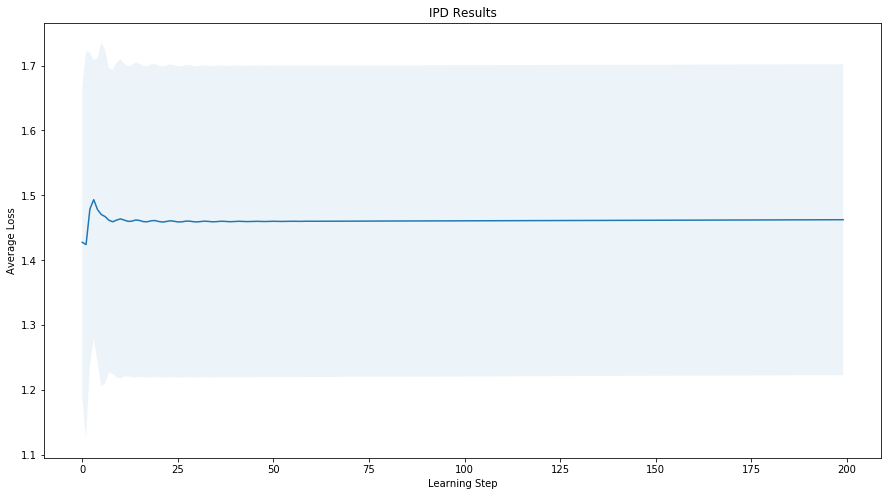

Jax time: 51.65729475021362
[1.42774579 1.46415511 1.60484936 1.63518875 1.63636478 1.63065039
 1.6516383  1.66299049 1.67017208 1.68337065 1.69689992 1.70967634
 1.71886527 1.72023898 1.72424658 1.73367268 1.73949269 1.74059366
 1.73339684 1.73713296 1.74620014 1.74552442 1.74259879 1.74681313
 1.75378754 1.75573991 1.75382035 1.75250704 1.75619652 1.76222326
 1.76089542 1.75925492 1.76017883 1.76302616 1.76095214 1.75719656
 1.75772862 1.76112673 1.77131171 1.77166893 1.76604178 1.76358427
 1.76935675 1.77522799 1.76992942 1.76507688 1.76527453 1.77046741
 1.7715068  1.76593913 1.76461811 1.76482138 1.76553268 1.76357872
 1.76396333 1.76234873 1.76300922 1.76481518 1.75948876 1.75518597
 1.75539191 1.7574107  1.75496409 1.75147857 1.75549414 1.7540204
 1.75196735 1.74886621 1.7465556  1.74694612 1.74786538 1.74540209
 1.73848755 1.73572073 1.73775457 1.74021964 1.73628024 1.72900916
 1.72628206 1.73026578 1.73316921 1.72801997 1.72147494 1.72285787
 1.72715146 1.72529562 1.72090999 1

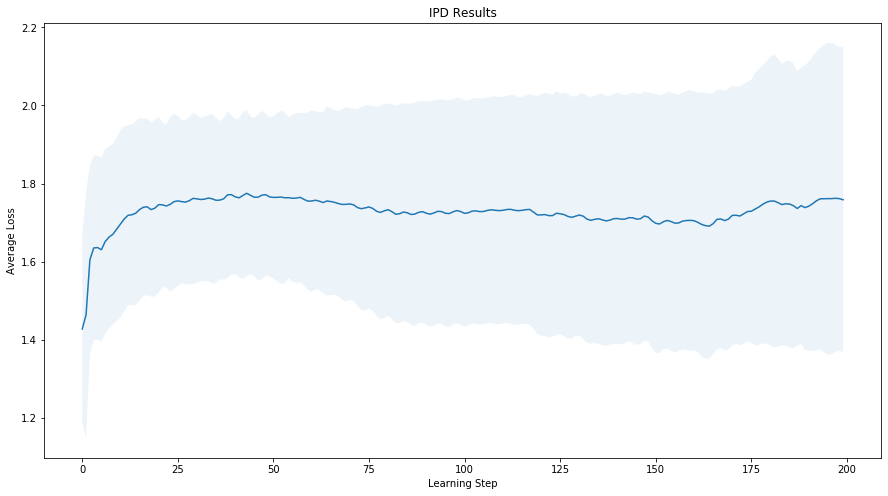

Jax time: 52.13488817214966
[1.42774579 1.42464743 1.48020042 1.49487564 1.47984551 1.47268718
 1.47008801 1.46468659 1.46265224 1.46557229 1.46783585 1.46623799
 1.46458262 1.46518162 1.46741259 1.46706347 1.46556715 1.46553871
 1.46743526 1.46825767 1.46712646 1.46651757 1.46768221 1.46915177
 1.46886297 1.4680251  1.46842415 1.46983146 1.4703576  1.46978073
 1.46964384 1.47060639 1.47154726 1.47148003 1.47116991 1.47163922
 1.47258783 1.47297547 1.47279462 1.47292455 1.47365144 1.47428359
 1.47436561 1.47437035 1.47482996 1.47549558 1.47582052 1.47586958
 1.47613198 1.47670199 1.47717157 1.47734542 1.47751886 1.47795359
 1.47846274 1.47876411 1.47894031 1.47926227 1.47973814 1.48012712
 1.48035699 1.48061689 1.48102696 1.48145203 1.48174822 1.4819944
 1.48234061 1.48276029 1.48311011 1.48337509 1.48367784 1.48406794
 1.48444742 1.48474583 1.48503022 1.48538404 1.48576939 1.486101
 1.48638804 1.4867117  1.48708592 1.4874401  1.48774263 1.48804825
 1.48840219 1.48876683 1.48908927 1.4

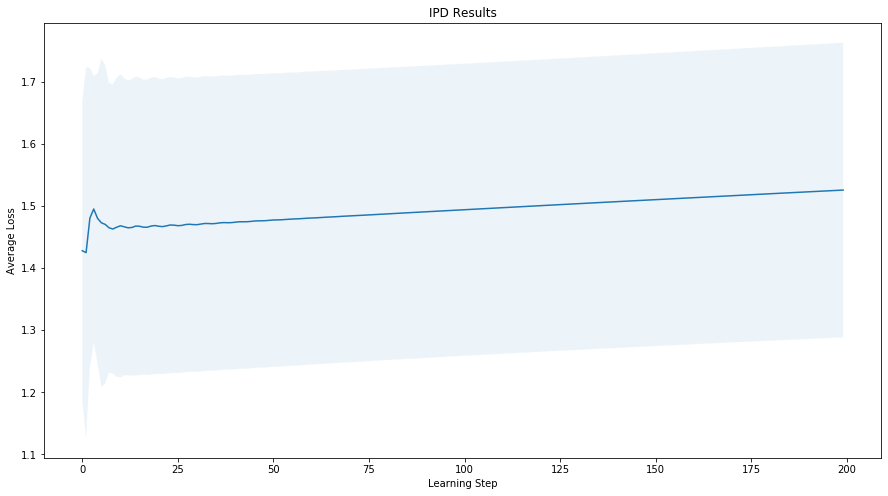

Jax time: 52.0783326625824
[1.42774579 1.67201099 1.88877505 1.95376607 1.99215583 1.99497421
 1.99444532 1.98069452 1.9704881  1.9978075  1.97572586 1.96746418
 1.94384719 1.93619153 1.95006531 1.94829856 1.94223435 1.93692982
 1.93247744 1.92288908 1.9385578  1.93702269 1.92998503 1.92311494
 1.92295715 1.92493135 1.92909253 1.93867275 1.93905988 1.94122208
 1.93914563 1.93692278 1.93694749 1.92646181 1.92371532 1.92314152
 1.9229265  1.92285304 1.92286043 1.92293576 1.9230703  1.9232485
 1.9234496  1.92365911 1.9238745  1.92410541 1.92436918 1.92467975
 1.92504463 1.92545357 1.92587612 1.92627303 1.92660905 1.92686845
 1.92705295 1.92717417 1.92724448 1.92727473 1.92727165 1.92724064
 1.92718964 1.92712945 1.92706548 1.92700312 1.92694115 1.92687866
 1.92681424 1.92674748 1.92667827 1.92660609 1.92652755 1.92643754
 1.9263297  1.92619573 1.92602974 1.92584867 1.92573202 1.92563641
 1.92500696 1.92287811 1.9227463  1.91873501 1.90831825 1.90753174
 1.90716746 1.90695891 1.90680934 1.

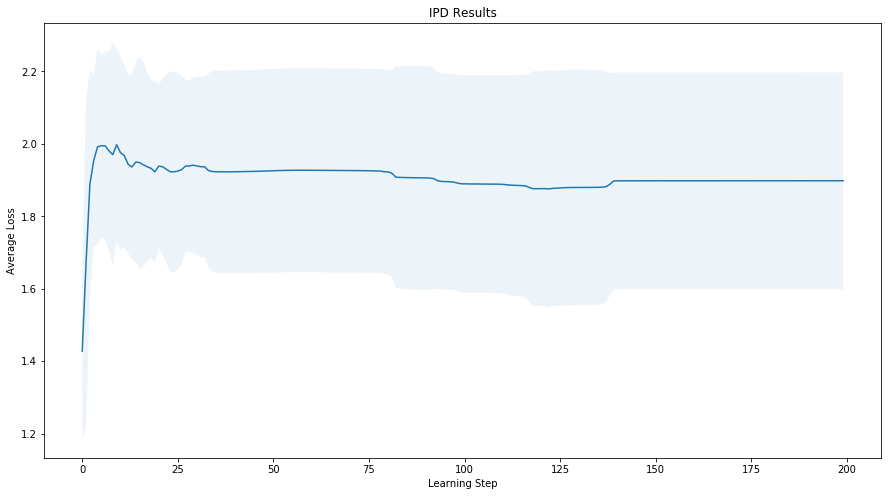

Jax time: 51.798644065856934
[1.42774579 1.41552382 1.44765498 1.47927686 1.4727964  1.46782218
 1.46394262 1.4600471  1.45655065 1.45531864 1.45729434 1.45871377
 1.45800709 1.45681192 1.45611967 1.45645    1.45722896 1.45738492
 1.45697391 1.45649613 1.45646672 1.4568456  1.45706726 1.45693402
 1.45665896 1.45658799 1.45677641 1.45692773 1.45687639 1.45672531
 1.45668024 1.45678624 1.45687829 1.45684794 1.45675971 1.45673874
 1.45680828 1.45686585 1.45684359 1.45678685 1.45677842 1.45682813
 1.45686749 1.45685176 1.45681324 1.45680944 1.45684662 1.45687535
 1.45686509 1.45683826 1.45683659 1.4568637  1.45688641 1.45688046
 1.45686249 1.45686156 1.45688171 1.45689952 1.45689731 1.45688562
 1.45688506 1.45689996 1.45691415 1.45691445 1.45690755 1.45690745
 1.4569187  1.45693004 1.45693197 1.45692811 1.45692901 1.45693769
 1.45694687 1.45695018 1.4569486  1.45695002 1.45695691 1.45696451
 1.45696835 1.45696822 1.45697032 1.4569759  1.45698291 1.45698636
 1.45698791 1.45699014 1.45699514

Jax time: 51.95810508728027
[1.42774579 1.58466054 1.82797443 1.88449695 1.91798772 1.92278648
 1.92580119 1.9012886  1.87547918 1.86612176 1.86018301 1.86027226
 1.86222415 1.86462692 1.86776489 1.86605229 1.85730025 1.84321612
 1.83076261 1.82702472 1.82514004 1.82010217 1.81643468 1.81060782
 1.81063234 1.8076837  1.80608768 1.8083038  1.81320554 1.81435111
 1.81128677 1.810828   1.80902036 1.79951082 1.7910243  1.79230747
 1.7948047  1.7888317  1.77930772 1.77681365 1.78760461 1.78882717
 1.78207243 1.7777853  1.77780431 1.77877514 1.78387004 1.78806145
 1.78115387 1.78128859 1.77656639 1.77055573 1.76467952 1.76961451
 1.77463126 1.77129747 1.76697233 1.76564161 1.76580688 1.76666363
 1.7691252  1.76265952 1.75808475 1.75681818 1.75834982 1.76517771
 1.7642376  1.76281525 1.76575931 1.77084633 1.77213682 1.7694239
 1.7638385  1.76059149 1.76047826 1.76332824 1.76958321 1.77445855
 1.7737147  1.77143406 1.77582847 1.79213928 1.79789945 1.79110135
 1.78748256 1.78949166 1.79157962 1

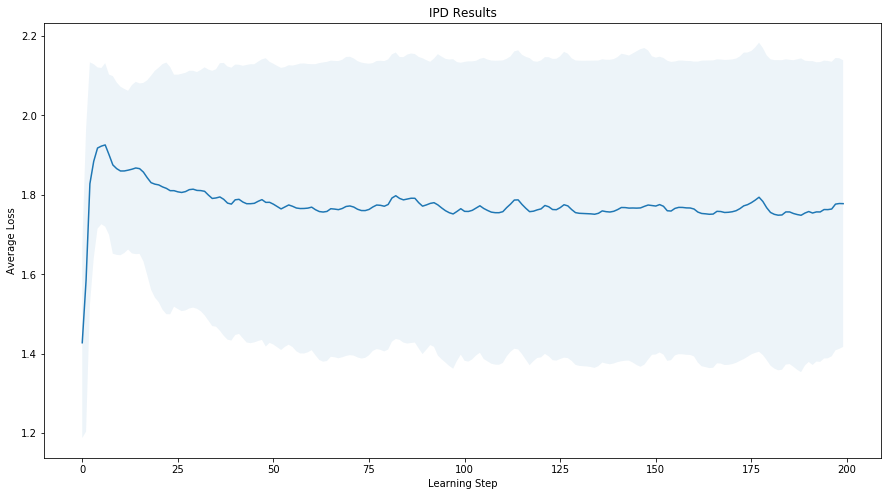

Jax time: 51.76083827018738
[1.42774579 1.42131593 1.46872263 1.49110356 1.47763454 1.47076028
 1.46731141 1.46089078 1.45747058 1.45963593 1.4631269  1.46239971
 1.45984639 1.45874238 1.46025131 1.46145966 1.46034706 1.4589274
 1.45905106 1.46049612 1.46061916 1.45939332 1.45868592 1.45946852
 1.46043259 1.4599561  1.45893178 1.45884353 1.45978083 1.46017689
 1.45946439 1.45880697 1.45914185 1.45990318 1.45985754 1.45916586
 1.45889531 1.45941281 1.45986764 1.45956868 1.45904477 1.45908147
 1.45958316 1.4597429  1.45935986 1.45905809 1.45927688 1.45964616
 1.45959359 1.4592478  1.45915042 1.45942808 1.45963059 1.45946464
 1.45922048 1.45927055 1.45951753 1.45957388 1.4593802  1.45925384
 1.45938105 1.45955141 1.45950935 1.45934437 1.45931915 1.45946259
 1.4595474  1.45945753 1.45935005 1.45939154 1.45951094 1.45952592
 1.45943018 1.45938254 1.4594549  1.45953196 1.45950291 1.45942713
 1.4594279  1.45950164 1.45953555 1.45948826 1.4594435  1.45947349
 1.459531   1.45953245 1.45948641 1

Jax time: 51.85403394699097
[1.42774579 1.43634066 1.5267398  1.57548887 1.58892545 1.59680151
 1.60834843 1.61593535 1.62184265 1.63127497 1.64541266 1.65381243
 1.65907403 1.66493809 1.67525148 1.68836303 1.6993137  1.70359679
 1.70251311 1.70560752 1.71584332 1.72482821 1.72848846 1.72546198
 1.72526421 1.73409413 1.74244899 1.74969508 1.75348387 1.7533498
 1.75510782 1.75842633 1.7612758  1.76240857 1.76223716 1.76334757
 1.76500647 1.76608929 1.76645185 1.7661472  1.76681069 1.76668628
 1.76570372 1.76589072 1.765918   1.76649408 1.76542919 1.76281068
 1.76207749 1.76265576 1.76312341 1.76226636 1.76071743 1.76029794
 1.76064298 1.7607425  1.75989928 1.75922531 1.75973469 1.76022017
 1.75990077 1.75842464 1.75785925 1.75860259 1.75863726 1.75730334
 1.75468361 1.75403675 1.75508994 1.75585026 1.75504052 1.75269482
 1.75244137 1.75311931 1.75280845 1.750286   1.74646443 1.74536034
 1.74558109 1.74582336 1.74500876 1.74355762 1.7447634  1.74663394
 1.74698795 1.74522247 1.7432191  1

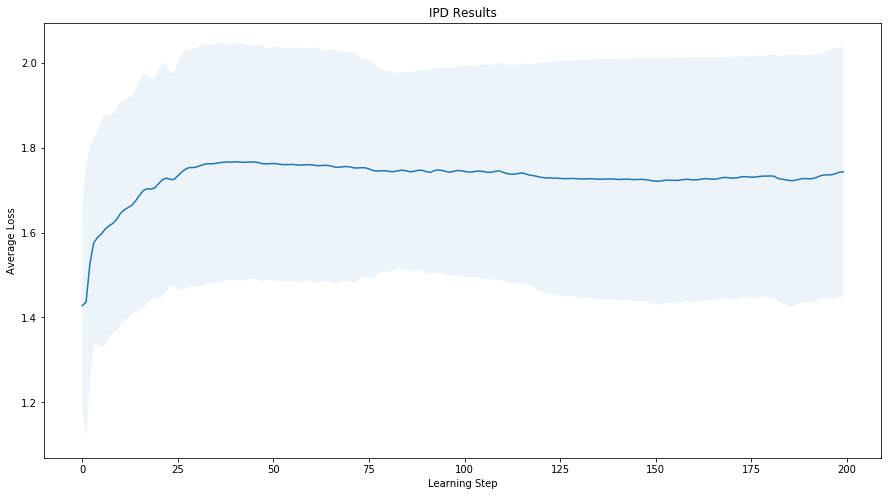

Jax time: 52.614957094192505
[1.42774579 1.41271867 1.43693127 1.46952568 1.46895643 1.46446001
 1.45899063 1.45569622 1.4547889  1.45394251 1.45463858 1.45528999
 1.45464422 1.45393857 1.45382633 1.45387812 1.45406594 1.45418495
 1.45418297 1.45415262 1.45402158 1.45389112 1.45391609 1.45406085
 1.45418721 1.45415424 1.45399853 1.45390965 1.45397608 1.45411446
 1.45417144 1.45409472 1.45399191 1.45398162 1.45406539 1.45414307
 1.45413408 1.45406633 1.45402776 1.45405933 1.45412024 1.45414267
 1.45411297 1.45407726 1.45408004 1.45411594 1.45414429 1.45413959
 1.45411734 1.45410972 1.45412665 1.45415017 1.45415722 1.45414763
 1.45413924 1.45414582 1.45416166 1.45417222 1.45417108 1.45416634
 1.45416829 1.45417812 1.45418811 1.45419162 1.45419063 1.45419099
 1.45419713 1.45420547 1.45421081 1.45421249 1.45421389 1.45421791
 1.45422409 1.45423004 1.45423318 1.45423554 1.45423871 1.45424398
 1.45424946 1.45425362 1.45425666 1.45425969 1.45426431 1.45426918
 1.45427336 1.4542771  1.45428057

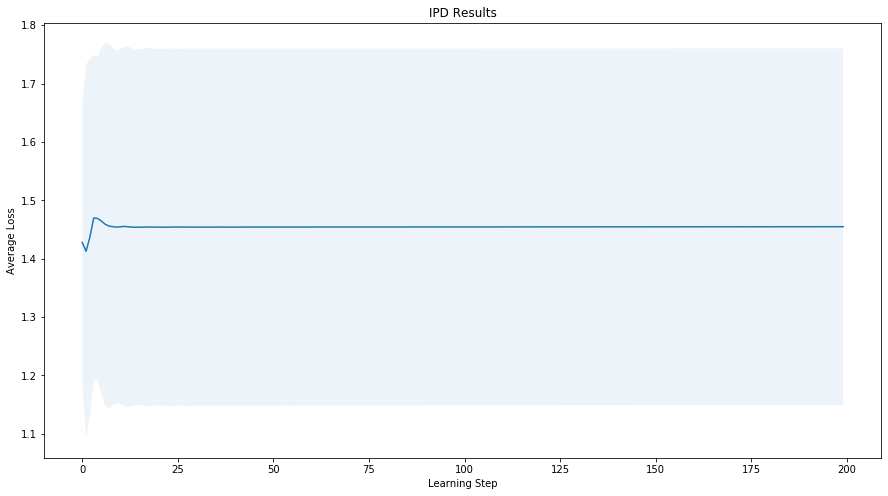

Jax time: 51.9450740814209
[1.42774579 1.42794933 1.49216108 1.50908352 1.49743409 1.49416699
 1.49630732 1.49350324 1.49310142 1.4989191  1.50530658 1.50707021
 1.50736528 1.51052013 1.51641734 1.5197753  1.5205637  1.522583
 1.52765592 1.53213071 1.53376867 1.53502384 1.53882047 1.54370554
 1.54640247 1.54754749 1.55007538 1.55459683 1.55818837 1.55976333
 1.56139037 1.56502883 1.56909757 1.57136318 1.57257595 1.57512754
 1.57920295 1.58227004 1.58344545 1.58482364 1.58846617 1.59254982
 1.5940329  1.59385279 1.59626983 1.60147344 1.6042687  1.60278754
 1.60309127 1.6071986  1.61019902 1.61082202 1.612898   1.6171875
 1.61756086 1.61547099 1.61558752 1.61949583 1.6233888  1.62458533
 1.6249993  1.62670886 1.62992668 1.63253089 1.63360384 1.63454112
 1.63675827 1.63962248 1.64137607 1.64217703 1.64355494 1.64613753
 1.64843533 1.64946672 1.65025443 1.65219912 1.65480042 1.65635201
 1.65687004 1.65795609 1.66045828 1.6627403  1.66340418 1.66355462
 1.66539314 1.66845073 1.66982291 1.66

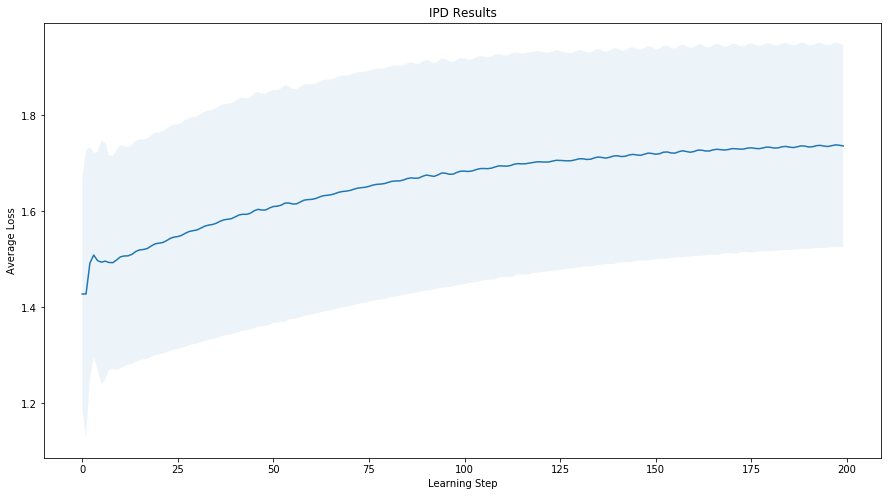

Jax time: 51.96927618980408
[1.42774579 1.41274988 1.43705299 1.469723   1.46918153 1.464736
 1.45934287 1.45607937 1.45517204 1.45434418 1.45508195 1.45579702
 1.45519651 1.4545076  1.45441534 1.45450559 1.45474396 1.4549087
 1.45493749 1.45493218 1.45483618 1.45475025 1.45481862 1.45499799
 1.4551537  1.45515439 1.45504028 1.45499351 1.45509646 1.45526635
 1.45535633 1.45531895 1.45525729 1.45528488 1.45540151 1.45551249
 1.45554083 1.45551329 1.45551377 1.45558028 1.45567402 1.45573231
 1.45574175 1.45574521 1.45578441 1.45585424 1.45591787 1.45595107
 1.45596737 1.45599715 1.45604934 1.45610752 1.45615134 1.45618001
 1.45620946 1.45625183 1.45630281 1.45634934 1.45638573 1.45641891
 1.45645737 1.45650283 1.45654858 1.45658943 1.45662548 1.4566632
 1.4567056  1.45674972 1.45679144 1.45683038 1.45686859 1.4569093
 1.45695185 1.45699395 1.45703396 1.45707313 1.45711345 1.45715452
 1.45719635 1.4572368  1.45727709 1.45731705 1.45735777 1.45739907
 1.45743996 1.45748047 1.45752084 1.457

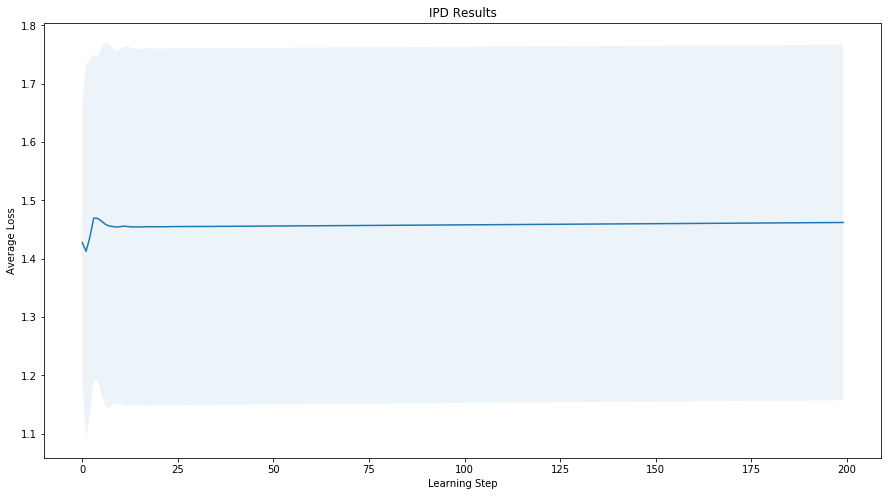

Jax time: 51.829230308532715
[1.42774579 1.41902922 1.46141579 1.49930973 1.49577066 1.49551082
 1.49888602 1.49832079 1.49450732 1.49483209 1.50117227 1.5091155
 1.5133443  1.51411629 1.51525916 1.51925169 1.52491786 1.52929287
 1.53149396 1.53330022 1.53658389 1.54108277 1.54502192 1.5475025
 1.54949713 1.55248313 1.55651376 1.56020739 1.56256307 1.56435513
 1.56718752 1.5712748  1.57490868 1.57665105 1.57773637 1.58056302
 1.5852744  1.58889725 1.58943028 1.58948461 1.59220561 1.59700551
 1.60080232 1.60165227 1.60181537 1.60413895 1.60829322 1.61189667
 1.61325038 1.61372304 1.61586819 1.61982695 1.623213   1.62413096
 1.62422885 1.62650182 1.63087893 1.63404664 1.63390685 1.63336043
 1.63622045 1.64121257 1.64346954 1.64202843 1.64172612 1.64649972
 1.65072189 1.65039312 1.64772827 1.64966048 1.65807541 1.659586
 1.65694728 1.65303964 1.65148298 1.65506729 1.66057139 1.66317721
 1.66198767 1.66080889 1.66316769 1.66741801 1.66987576 1.66928865
 1.66855604 1.67063328 1.67411615 1.6

Jax time: 52.202608585357666
[1.42774579 1.41031396 1.42729962 1.45976727 1.46525769 1.46333158
 1.45767452 1.45336011 1.45402685 1.4546051  1.45534359 1.45621178
 1.45618464 1.45589287 1.45624331 1.45693153 1.45749901 1.45791941
 1.45827694 1.45872964 1.45928163 1.45974475 1.46006717 1.4603901
 1.46084186 1.4614137  1.4619628  1.46237463 1.46269462 1.46305592
 1.46353188 1.46407456 1.46457352 1.4649793  1.46534316 1.46574776
 1.46622111 1.46672023 1.46718381 1.46759803 1.46799808 1.46842663
 1.46888932 1.46935834 1.46980527 1.47022891 1.4706505  1.47108819
 1.47154119 1.47199352 1.47243334 1.47286437 1.47329589 1.4737359
 1.47418174 1.4746255  1.4750634  1.4754977  1.47593331 1.47637259
 1.47681396 1.47725379 1.47769063 1.47812633 1.47856267 1.47900066
 1.47943896 1.47987635 1.48031209 1.48074778 1.48118345 1.48161956
 1.48205551 1.48249137 1.48292609 1.48336041 1.48379524 1.48422997
 1.484664   1.48509791 1.48553141 1.48596478 1.48639751 1.48683008
 1.4872627  1.48769497 1.48812651 1

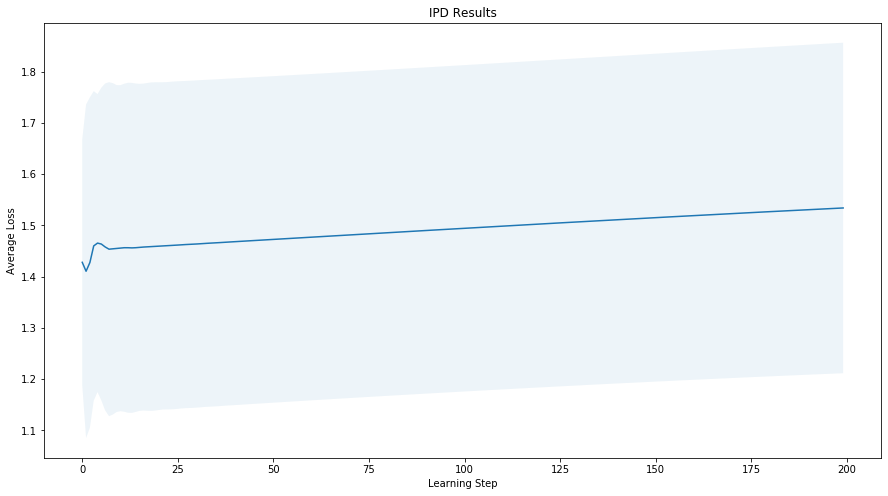

Jax time: 51.748852252960205
[1.42774579 1.4183922  1.458279   1.48655288 1.47565218 1.47000744
 1.46682706 1.46116906 1.45658665 1.45682341 1.46039315 1.46133882
 1.45937053 1.45755451 1.45756002 1.45911    1.45962291 1.45871441
 1.4577745  1.45794274 1.45885027 1.45900416 1.45835578 1.45786119
 1.45818194 1.45877415 1.45871199 1.45818556 1.45795482 1.4583307
 1.45871551 1.45854553 1.45812842 1.4580594  1.45841962 1.45865425
 1.45844427 1.45813226 1.45816086 1.45847039 1.45859602 1.45838526
 1.45816767 1.45824926 1.45849599 1.45854637 1.45835573 1.45821626
 1.45832154 1.4585068  1.45850773 1.4583479  1.45826903 1.45837805
 1.45850941 1.45848166 1.45835513 1.4583198  1.45842139 1.45850901
 1.45846661 1.45837197 1.45836649 1.45845404 1.45850809 1.45846157
 1.45839474 1.45840742 1.4584794  1.45850869 1.4584643  1.45842036
 1.45844303 1.45849925 1.45851179 1.45847306 1.45844741 1.45847416
 1.45851596 1.45851774 1.45848643 1.45847391 1.45850098 1.45853071
 1.45852642 1.45850267 1.45849967 

Jax time: 53.540722131729126
[1.42774579 1.5713348  1.82108287 1.88592314 1.91657709 1.92992772
 1.95613574 1.93843713 1.9196981  1.89283605 1.86756559 1.86439042
 1.86535524 1.85895922 1.84608411 1.82577779 1.82076747 1.81491816
 1.80399915 1.80611955 1.81609099 1.81087448 1.80569586 1.80107256
 1.78960116 1.77830696 1.77614617 1.7818843  1.78461751 1.78104426
 1.7755724  1.76749033 1.76156107 1.75895853 1.75841151 1.75569211
 1.75021335 1.75003327 1.75207218 1.75403174 1.75907033 1.75782646
 1.75525968 1.75416794 1.7543239  1.75917601 1.75778214 1.75945699
 1.76751321 1.76266692 1.76599722 1.76533061 1.76360454 1.7660388
 1.76744741 1.76497617 1.762897   1.76142317 1.75884683 1.75291881
 1.7500773  1.74938052 1.74878421 1.74814307 1.75027843 1.7552555
 1.75818903 1.76332641 1.76302594 1.76209636 1.76224718 1.76334086
 1.76461382 1.76710228 1.77409212 1.78715781 1.79047249 1.78727231
 1.78719146 1.78876018 1.78649309 1.78223316 1.77943292 1.77865561
 1.77821545 1.77780035 1.77729353 1

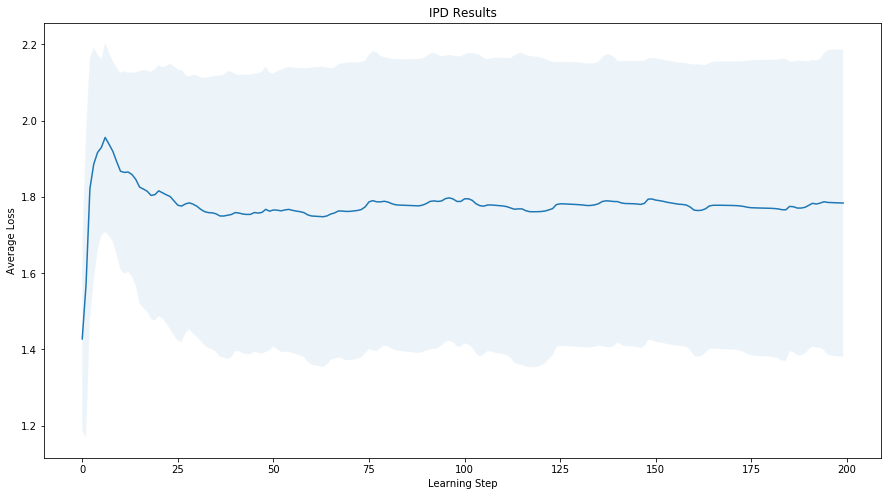

Jax time: 51.76330304145813
[1.42774579 1.42610463 1.48430664 1.50044278 1.48706208 1.48183688
 1.48118062 1.47697653 1.47575976 1.48001377 1.48411538 1.48409245
 1.48336649 1.48514792 1.48909156 1.49052634 1.49010784 1.49102992
 1.4944501  1.49706913 1.49728391 1.49755183 1.49999145 1.50317026
 1.50438482 1.50452672 1.50597809 1.50894501 1.51104663 1.51160136
 1.51240825 1.51472714 1.51725178 1.51844937 1.51908355 1.52071273
 1.52318035 1.52493666 1.52576067 1.52690638 1.52902515 1.53109017
 1.53226321 1.53320613 1.53489611 1.53700391 1.53851774 1.53948658
 1.54081686 1.54277132 1.54452229 1.54564827 1.5467565  1.54845469
 1.55030767 1.5516349  1.55266218 1.55408516 1.55590894 1.55742527
 1.5584819  1.559672   1.561357   1.5630128  1.56417555 1.56520911
 1.56668182 1.5683976  1.56971327 1.57068173 1.57191373 1.57358465
 1.57506973 1.57606889 1.57708115 1.57859288 1.58021688 1.58134263
 1.58220502 1.5834607  1.58512933 1.5864662  1.58729491 1.58824448
 1.58979029 1.59138158 1.59235692 

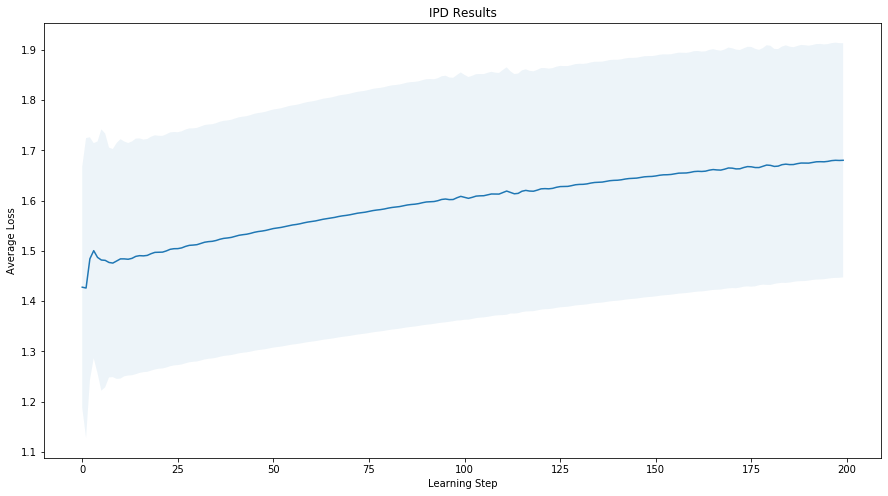

Jax time: 52.08430504798889
[1.42774579 1.59296416 1.82962869 1.88066649 1.90694374 1.91022197
 1.89693394 1.87504242 1.85847043 1.85744046 1.86353781 1.87109617
 1.87974119 1.87907167 1.87260826 1.86874192 1.87116143 1.87181637
 1.87318404 1.87751382 1.87588803 1.87301627 1.86293411 1.84998828
 1.83743763 1.83104269 1.83300041 1.83718064 1.82998776 1.82909195
 1.82954432 1.83193552 1.83192284 1.83810263 1.83649633 1.82603271
 1.81507422 1.81205358 1.82061529 1.82921623 1.8287264  1.83083897
 1.82998599 1.82320141 1.8132665  1.80956506 1.8114586  1.81457662
 1.81209376 1.80950611 1.81033547 1.81386882 1.81435191 1.8170303
 1.82165661 1.82453497 1.81291697 1.79774737 1.79160678 1.7881886
 1.79085037 1.79566415 1.79412101 1.78859612 1.78471859 1.78873807
 1.80413737 1.82530238 1.82692389 1.81147469 1.79485053 1.78481224
 1.7720909  1.78235911 1.78630036 1.7824222  1.78977934 1.81865818
 1.8295807  1.82880926 1.82231269 1.81380425 1.80622837 1.79522167
 1.77973102 1.77526363 1.77458912 1.

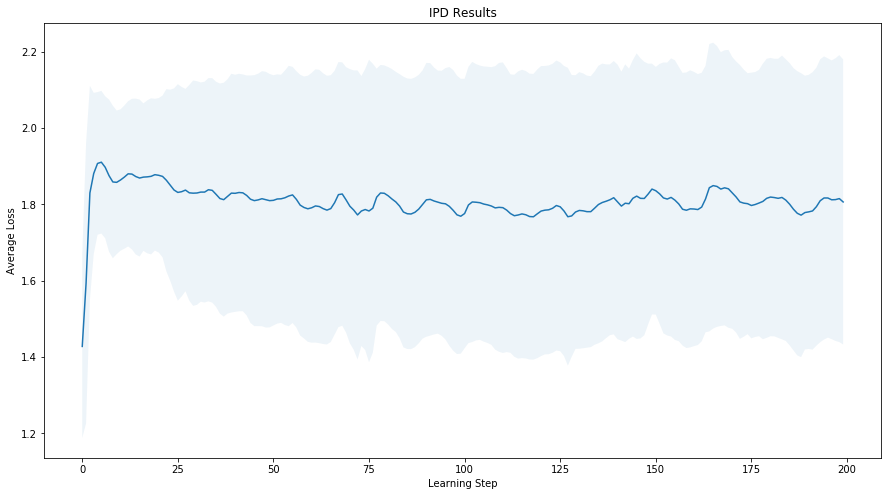

Jax time: 51.49117970466614
[1.42774579 1.42729972 1.48863087 1.49385092 1.47614202 1.46860969
 1.46656735 1.46249065 1.4609359  1.46300843 1.46268652 1.46067984
 1.4600853  1.46115336 1.46108507 1.45940269 1.45904458 1.45989554
 1.46028892 1.45907761 1.45857403 1.4592328  1.45979748 1.45911124
 1.45851935 1.45893992 1.4595195  1.45921703 1.45865994 1.45883728
 1.45935938 1.4593051  1.4588522  1.45884293 1.45926479 1.45936331
 1.45903467 1.45891149 1.45921346 1.45939777 1.45918966 1.45901338
 1.45919802 1.45941638 1.45931589 1.45913073 1.45921374 1.45942724
 1.45941568 1.45925154 1.45925638 1.459438   1.45949253 1.4593678
 1.45932098 1.45945562 1.45955104 1.45947475 1.45940097 1.45948434
 1.45959695 1.45956912 1.45949009 1.45952714 1.4596357  1.45965014
 1.45958213 1.4595828  1.45967425 1.45971888 1.45967239 1.45964981
 1.45971655 1.45977842 1.45975703 1.45972435 1.45976534 1.45983169
 1.45983503 1.45980269 1.4598211  1.45988276 1.45990563 1.45988214
 1.45988387 1.45993421 1.45997047 1

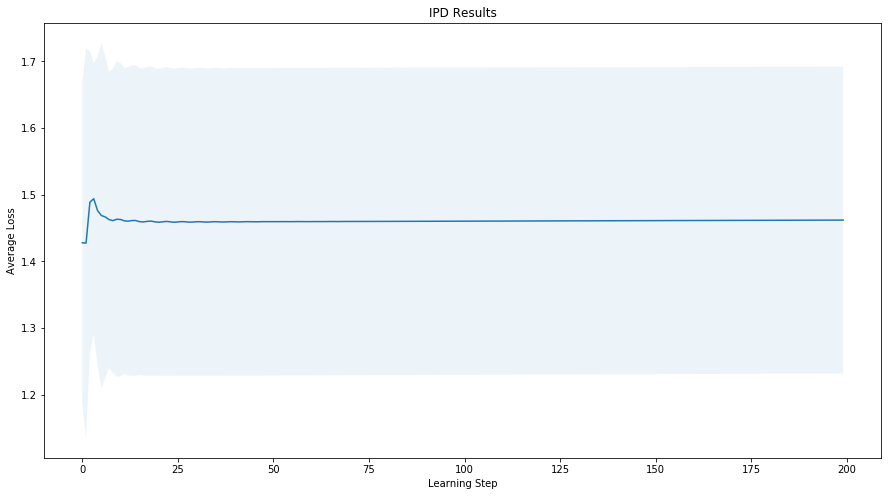

Jax time: 51.87754249572754
[1.42774579 1.4291279  1.49386352 1.50063662 1.48479172 1.47942933
 1.47972549 1.47701605 1.47653518 1.48046759 1.48240983 1.48180266
 1.4822062  1.48501065 1.48732545 1.48729595 1.48780619 1.49021399
 1.49285574 1.49346309 1.49392152 1.4959596  1.49857756 1.4997479
 1.50028817 1.50199431 1.50445823 1.50598017 1.50668856 1.50812539
 1.51041601 1.51213362 1.51301804 1.51425804 1.51637173 1.51820976
 1.5192463  1.52035248 1.52227596 1.52419753 1.52537127 1.52639452
 1.52811025 1.53007546 1.53139068 1.53237387 1.53387721 1.53582942
 1.53729278 1.53827828 1.539584   1.54145691 1.54306072 1.54409286
 1.54523332 1.54696764 1.54868012 1.54980086 1.55082132 1.55237571
 1.55414345 1.55538579 1.55633659 1.55769604 1.55945218 1.56083027
 1.56176598 1.56293842 1.56461565 1.56612037 1.56709419 1.56810768
 1.56964826 1.57124699 1.57230663 1.57320253 1.57456681 1.57620717
 1.57738822 1.57821814 1.57938772 1.58100406 1.58232359 1.58314633
 1.58412459 1.58564534 1.58709928 1

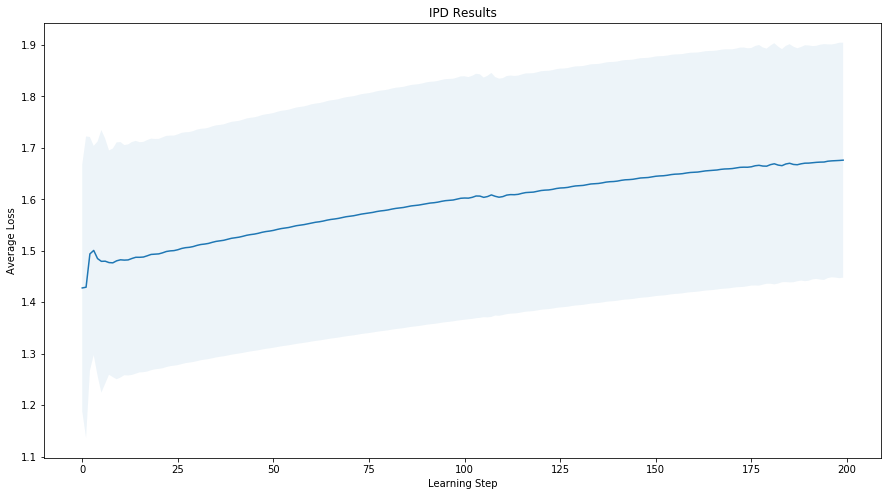

Jax time: 52.29733204841614


In [0]:
#@title IPD jax GPM tuning
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''
from itertools import product
import random as rnd
from copy import deepcopy

gamma = 0.96
dims, Ls = ipd(gamma)

def alpha_fn1(beta, eta):
    term1=beta*eta
    term2=1-beta
    return 2*term1/term2+term2

def alpha_fn2(beta, eta):
    term1=eta
    term2=1-beta
    return 2*term1/term2+term2

num_runs = 50
num_epochs = 200
std = 1
beta = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
eta = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.5,1.0]
perm = list(product(beta, eta))
a1list = [(b,e,alpha_fn1(b,e)) for b,e in perm]
a2list = [(b,e,alpha_fn2(b,e)) for b,e in perm]
params = a1list+a2list
rnd.shuffle(params)
print(len(beta),len(eta),len(perm),len(a1list),len(a2list),len(params))

th = init_th(dims, std)
th0 = jp.zeros(th.shape)

def update_gpm(Ls, dims, alpha=1.0, eta=1.0, beta=1.0, th, th0=None):
    n = th.shape[0]
    losses = Ls(th)
    if th0 is None:
        th0=jp.zeros(th.shape)

    grad_L = jacobian(Ls)(th) # n x n x d
    xi = jp.einsum('iij->ij',grad_L)
    assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
    assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
    difference = th-th0
    full_hessian = jax.hessian(Ls)(th)
    diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
    for i in range(th.shape[0]):
        diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
    diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
    diff_term = index_update(diff_term, index[0, 1] , difference[1])
    diff_term = index_update(diff_term, index[1, 0] , difference[0])
    third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))
    updates = eta*xi - beta*(th-th0) - alpha*third_term
    th0 = th
    th = th - updates.reshape(th.shape)

    return th, th0, losses
update_fn = jit(partial(update_gpm, Ls, dims))

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

thlist=[]
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    thlist.append(convert2jax(torch_th))

lossmap={}
for tup in params:
    b, e, a = tup
    t1 = time.time()
    plt.figure(figsize=(15, 8))
    losses_out = np.zeros((num_runs, num_epochs))

    for i in range(num_runs):
        torch_th = torch_init_th(dims, std)
        th = deepcopy(thlist[i])
        th0 = jp.zeros(th.shape)
        for k in range(num_epochs):
            th, th0, losses = update_fn(th, th0, a, e, b)
            losses_out[i, k] = (1-gamma)*losses[0]

    mean = np.mean(losses_out, axis=0)
    dev = np.std(losses_out, axis=0)
    plt.plot(np.arange(num_epochs), mean)
    plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)
    lossmap[tup]=(losses_out, mean, dev)
    print(mean)
    print('average loss: (alpha=%f, beta=%f, eta=%f) : %f'%(a,b,e, np.mean(mean[-50:])))

    plt.title('IPD Results')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
    plt.show()
    print('Jax time:', time.time()-t1)

In [0]:
print(lossmap.keys())

dict_keys([(0.25, 0.1, 0.8166666666666667), (0.1, 0.001, 0.9002222222222223), (0.4, 0.005, 0.6066666666666667), (0.35, 1.0, 3.7269230769230766), (0.4, 5e-05, 0.6000666666666666), (0.35, 0.001, 0.6530769230769231), (0.2, 0.005, 0.8025), (0.35, 0.1, 0.9576923076923077), (0.2, 0.001, 0.8005), (0.2, 0.05, 0.925), (0.5, 0.0001, 0.5004), (0.3, 0.001, 0.7008571428571428), (0.2, 1.0, 3.3), (0.3, 0.0005, 0.7014285714285714), (0.25, 1.0, 3.4166666666666665), (0.45, 0.0005, 0.5508181818181819), (0.5, 0.05, 0.7), (0.2, 0.0001, 0.80025), (0.15, 0.1, 0.8852941176470588), (0.4, 0.0001, 0.6003333333333333), (0.35, 1e-05, 0.6500107692307693), (0.3, 0.005, 0.7042857142857143), (0.5, 5e-05, 0.5002), (0.25, 0.0005, 0.7513333333333333), (0.5, 1e-05, 0.50004), (0.3, 0.0001, 0.7002857142857143), (0.25, 1e-05, 0.7500066666666667), (0.45, 0.01, 0.5863636363636364), (0.4, 0.0001, 0.6001333333333333), (0.3, 5e-05, 0.7001428571428571), (0.1, 0.001, 0.9022222222222223), (0.35, 0.001, 0.6510769230769231), (0.15, 0.

In [0]:
selected_keys=[]
for k,v in lossmap.items():
    mean_loss = np.mean(v[0], axis=0)
    if np.mean(mean_loss[-50:]) < 1.5:
        selected_keys.append(k)
        print(k,np.mean(mean_loss))
print(len(selected_keys))

(0.4, 5e-05, 0.6000666666666666) 1.451382507684827
(0.5, 0.0001, 0.5004) 1.4410238218784333
(0.3, 0.0005, 0.7014285714285714) 1.4757609813392163
(0.45, 0.0005, 0.5508181818181819) 1.4680468913018705
(0.2, 0.0001, 0.80025) 1.4629449254095552
(0.4, 0.0001, 0.6003333333333333) 1.4536542066335678
(0.35, 1e-05, 0.6500107692307693) 1.4541701462447643
(0.5, 5e-05, 0.5002) 1.4383444418370723
(0.25, 0.0005, 0.7513333333333333) 1.4766319004058837
(0.5, 1e-05, 0.50004) 1.436206662634015
(0.3, 0.0001, 0.7002857142857143) 1.4604587408363818
(0.25, 1e-05, 0.7500066666666667) 1.458590300786495
(0.4, 0.0001, 0.6001333333333333) 1.4536353986263277
(0.3, 5e-05, 0.7001428571428571) 1.4585220196187496
(0.1, 5e-05, 0.9001111111111111) 1.4604978441715242
(0.1, 0.0005, 0.9011111111111111) 1.4753075828373432
(0.2, 0.0001, 0.80005) 1.46293457544446
(0.5, 0.0001, 0.5002) 1.440988495886326
(0.45, 5e-05, 0.5501818181818182) 1.4459230708122255
(0.2, 1e-05, 0.8000250000000001) 1.459688345128298
(0.45, 5e-05, 0.5500

In [0]:
# Analyse setting (0.5, 1e-05, 0.50004)
outloss, out_mean, out_dev = lossmap[(0.5, 1e-05, 0.50004)]
plt.figure(figsize=(15, 8))
for i in range(outloss.shape[0]):
    plt.plot(np.arange(num_epochs), outloss[i])
    plt.title('IPD Results - Ours')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()


NameError: ignored

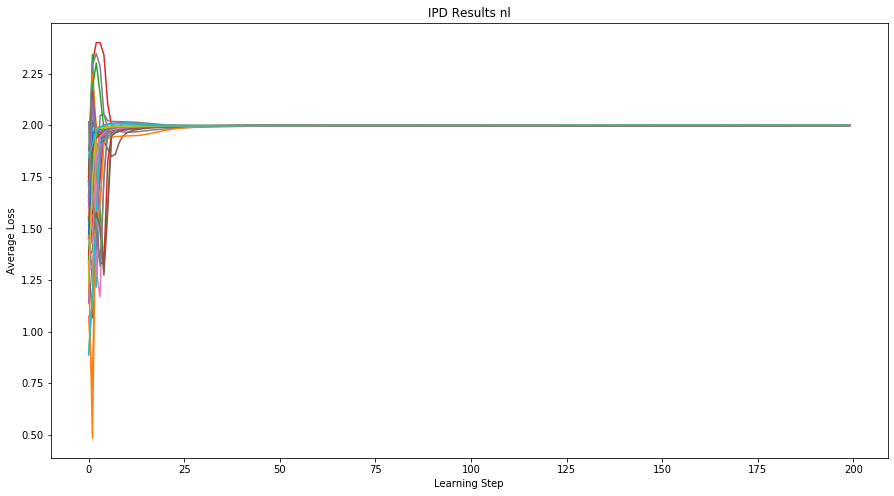

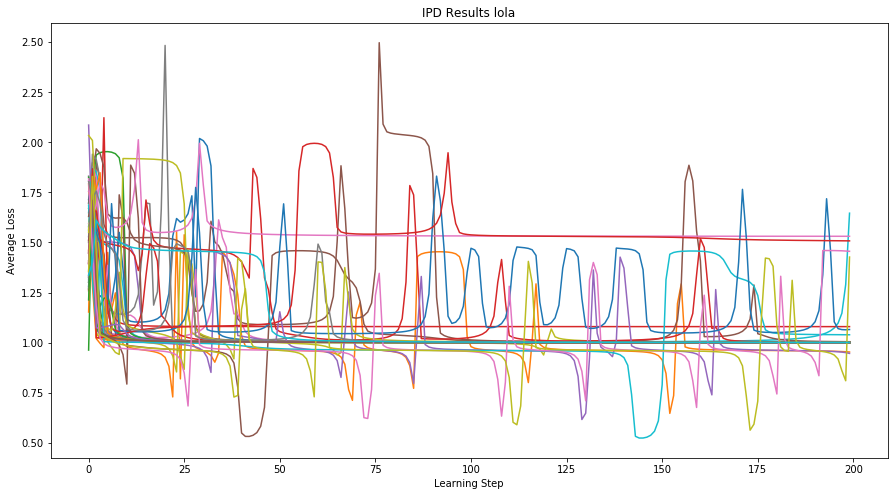

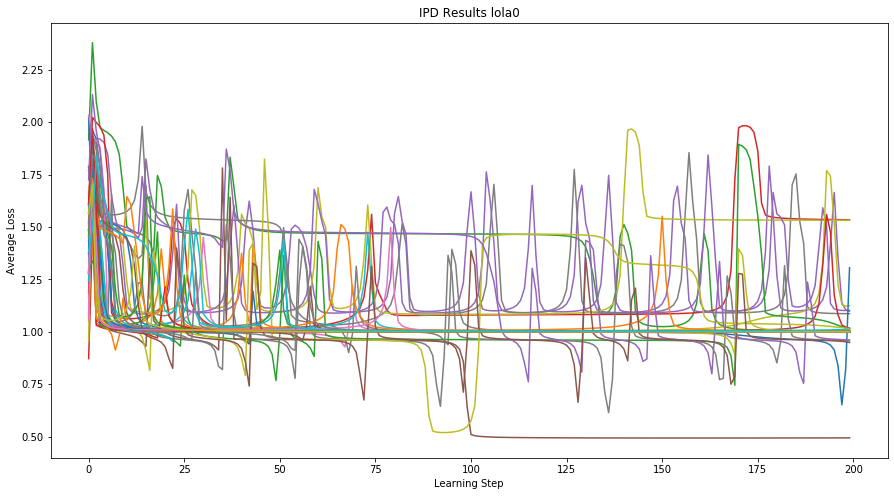

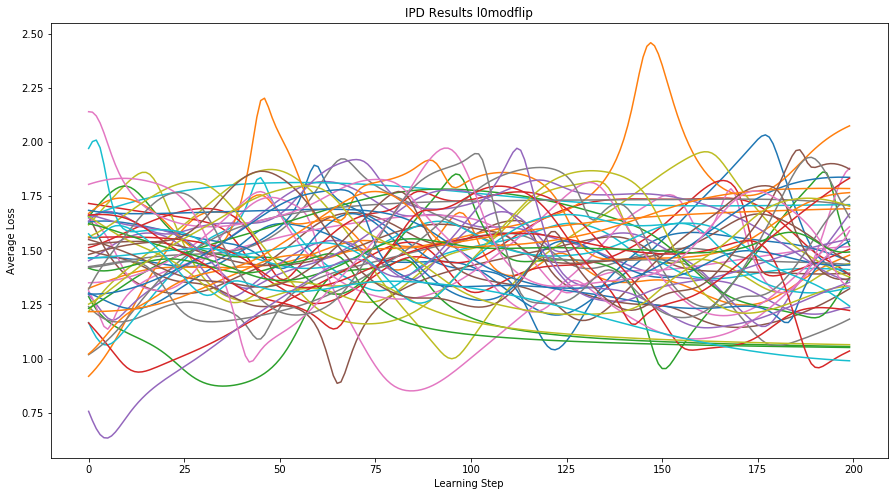

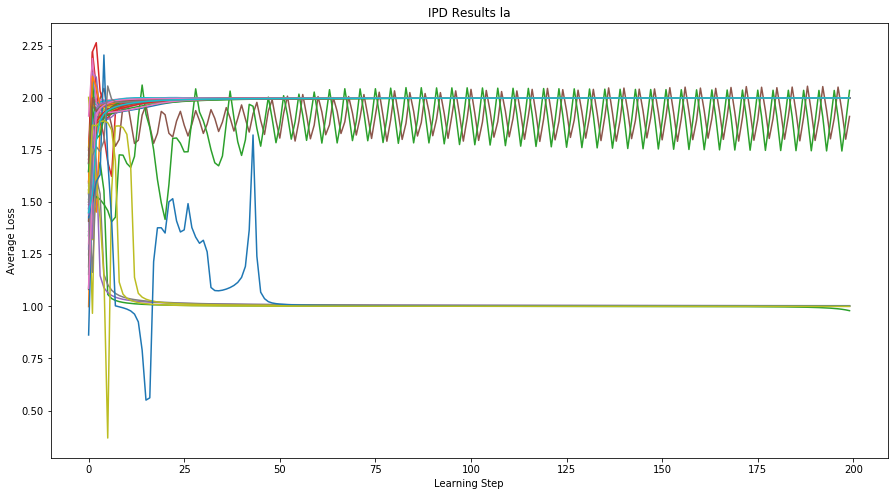

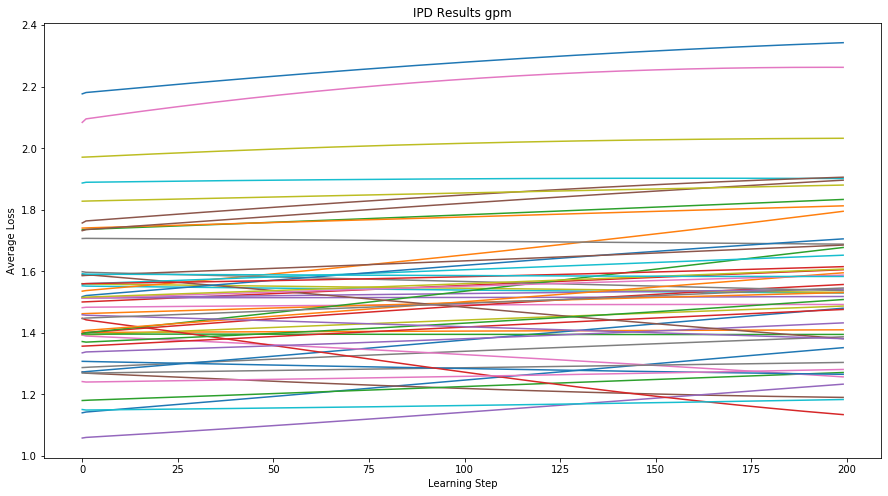

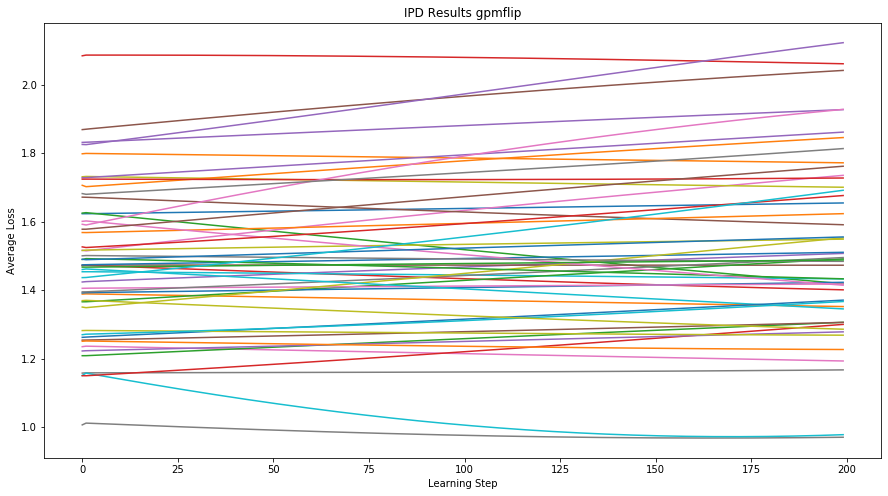

In [0]:
for algo in lossalgomap.keys():
    plt.figure(figsize=(15, 8))
    for i in range(num_runs):
        plt.plot(np.arange(num_epochs), lossalgomap[algo][i])
        plt.title('IPD Results %s'%(algo))
        plt.xlabel('Learning Step')
        plt.ylabel('Average Loss')
    # plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
    plt.show()


gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0005 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.005 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.05 eta Traced

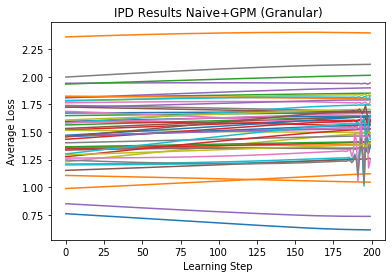

Jax time: 72.47431564331055


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1e-3

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,1e-4,'gpm')),
           jit(partial(update_th,Ls,dims,5e-4,'gpm')),
           jit(partial(update_th,Ls,dims,1e-3,'gpm')),
           jit(partial(update_th,Ls,dims,5e-3,'gpm')),
           jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           jit(partial(update_th,Ls,dims,5e-2,'gpm')),
           jit(partial(update_th,Ls,dims,1e-1,'gpm')),
           jit(partial(update_th,Ls,dims,0.5,'gpm')),
           jit(partial(update_th,Ls,dims,1,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPM (Granular)')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0005 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.005 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.01 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.05 eta Traced<ShapedArray

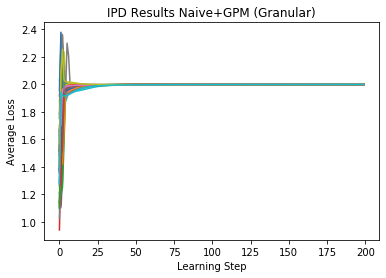

Jax time: 72.91975998878479


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,1e-4,'gpm')),
           jit(partial(update_th,Ls,dims,5e-4,'gpm')),
           jit(partial(update_th,Ls,dims,1e-3,'gpm')),
           jit(partial(update_th,Ls,dims,5e-3,'gpm')),
           jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           jit(partial(update_th,Ls,dims,5e-2,'gpm')),
           jit(partial(update_th,Ls,dims,1e-1,'gpm')),
           jit(partial(update_th,Ls,dims,0.5,'gpm')),
           jit(partial(update_th,Ls,dims,1,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPM (Granular)')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True

Jax time: 72.94457626342773


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,1e-4,'gpm')),
           jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           jit(partial(update_th,Ls,dims,0.5,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//50](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPM')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.01 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.5 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>


Jax time: 61.98065257072449


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1e-3

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,1e-4,'gpm')),
           jit(partial(update_th,Ls,dims,1e-2,'gpm')),
           jit(partial(update_th,Ls,dims,0.5,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//50](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPM')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.0001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0.5 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>


Jax time: 63.084460496902466


gpmflip alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0005 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.005 eta Traced<ShapedArray(float32[], weak_type=True):

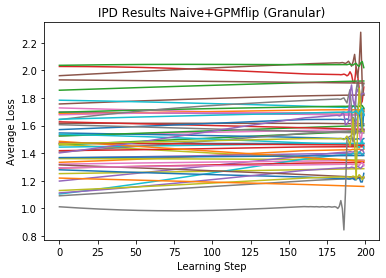

Jax time: 73.02514290809631


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1e-3

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-3,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-3,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-1,'gpmflip')),
           jit(partial(update_th,Ls,dims,0.5,'gpmflip')),
           jit(partial(update_th,Ls,dims,1,'gpmflip'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPMflip (Granular)')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0005 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.005 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace

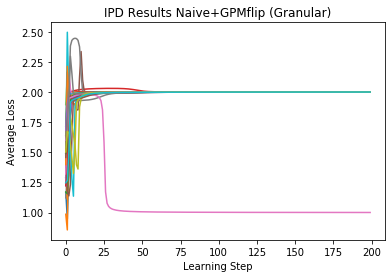

Jax time: 74.13704633712769


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-3,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-3,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,5e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-1,'gpmflip')),
           jit(partial(update_th,Ls,dims,0.5,'gpmflip')),
           jit(partial(update_th,Ls,dims,1,'gpmflip'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPMflip (Granular)')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta

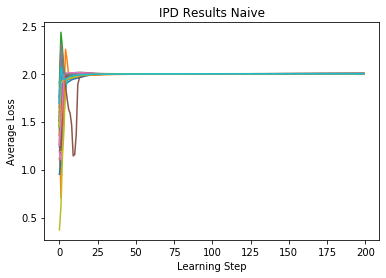

Jax time: 73.15804505348206


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,0,'gpmflip'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpmflip alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0001 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.01 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.5 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>


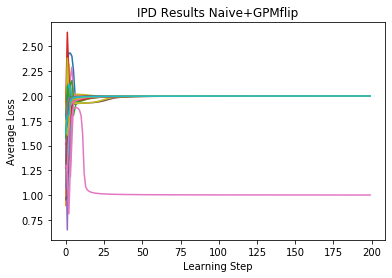

Jax time: 61.61737251281738


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,0.5,'gpmflip'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//50](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPMflip')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpmflip alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.0001 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.01 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>
gpmflip alpha 0.5 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Correct: Traced<ShapedArray(float32[2,5]):JaxprTrace(level=-1/1)>


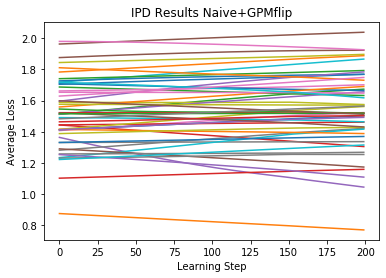

Jax time: 63.124938011169434


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0
eta = 1e-3

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-4,'gpmflip')),
           jit(partial(update_th,Ls,dims,1e-2,'gpmflip')),
           jit(partial(update_th,Ls,dims,0.5,'gpmflip'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//50](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+GPMflip')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0.2
eta = 1e-3

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+Momentum')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)

gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray

Jax time: 76.34162664413452


gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)> beta Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>
gpm alpha 0 eta Traced<ShapedArray(int32[], we

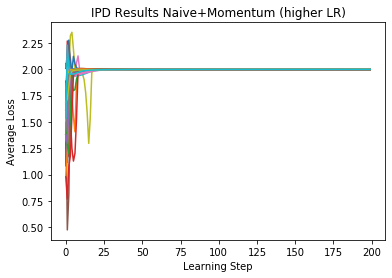

Jax time: 74.81191372871399


In [0]:
#@title IPD jax switching fron naive to l0mod

'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)
torch_dims, torch_Ls = torch_ipd(gamma)

num_runs = 50
num_epochs = 200
# alpha = 1e-2
std = 1
beta = 0.2
eta = 1

th = init_th(dims, std)
update_fn=[jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm')),
           jit(partial(update_th,Ls,dims,0,'gpm'))]

def convert2jax(th):
    jax_th=[]
    for x in th:
        jax_th.append(jp.array(x.data.numpy()))
    return jp.stack(jax_th)

t1 = time.time()
losses_out = np.zeros((num_runs, num_epochs))
for i in range(num_runs):
    torch_th = torch_init_th(dims, std)
    th = convert2jax(torch_th)
    th0 = jp.zeros(th.shape)
    for k in range(num_epochs):
        th, th0, losses = update_fn[k//20](th, th0, eta, beta)
        losses_out[i, k] = (1-gamma)*losses[0]

for i in range(num_runs):
    plt.plot(np.arange(num_epochs), losses_out[i])
    plt.title('IPD Results Naive+Momentum (higher LR)')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
# plt.legend(list(np.arange(outloss.shape[0])), loc='best', frameon=True, framealpha=1, ncol=3)
plt.show()
print('Jax time:', time.time()-t1)